# 🔧 Projekt: Interpretowalne Modele ML dla Finansów

## 1. Setup i Instalacja Bibliotek

In [82]:
import subprocess
import sys

def install_package(package_name, import_name=None):
    """
    Sprawdza czy biblioteka jest zainstalowana, jeśli nie - instaluje ją.
    
    Args:
        package_name: nazwa pakietu do instalacji (np. 'xgboost')
        import_name: nazwa do importu (jeśli inna niż package_name, np. 'sklearn' dla 'scikit-learn')
    """
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✅ {package_name} już zainstalowany")
        return True
    except ImportError:
        print(f"⚠️  {package_name} nie znaleziony. Instaluję...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
            print(f"✅ {package_name} zainstalowany pomyślnie")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Błąd instalacji {package_name}")
            return False

# Lista wymaganych bibliotek
required_packages = [
    ('xgboost', 'xgboost'),
    ('imbalanced-learn', 'imblearn'),
    ('shap', 'shap'),
    ('scikit-learn', 'sklearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn')
]

print("="*70)
print("🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK")
print("="*70)

all_installed = True
for package_name, import_name in required_packages:
    if not install_package(package_name, import_name):
        all_installed = False

print("\n" + "="*70)
if all_installed:
    print("✅ Wszystkie biblioteki gotowe do użycia!")
else:
    print("⚠️  Niektóre biblioteki nie zostały zainstalowane - sprawdź błędy powyżej")
print("="*70)

🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK
✅ xgboost już zainstalowany
✅ imbalanced-learn już zainstalowany
✅ shap już zainstalowany
✅ scikit-learn już zainstalowany
✅ matplotlib już zainstalowany
✅ seaborn już zainstalowany

✅ Wszystkie biblioteki gotowe do użycia!


Obliczamy wszystkie metryki (accuracy, precision, recall, F1, AUC) dla każdego modelu.

In [83]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

# Scipy
from scipy.stats.mstats import winsorize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  xgboost not installed - uruchom komórkę instalacyjną powyżej")
    XGBOOST_AVAILABLE = False

# imbalanced-learn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️  imbalanced-learn not installed - uruchom komórkę instalacyjną powyżej")
    SMOTE_AVAILABLE = False

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  shap not installed - uruchom komórkę instalacyjną powyżej")
    SHAP_AVAILABLE = False

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("\n✅ Biblioteki załadowane")
print(f"   XGBoost: {XGBOOST_AVAILABLE}")
print(f"   SMOTE (imbalanced-learn): {SMOTE_AVAILABLE}")
print(f"   SHAP: {SHAP_AVAILABLE}")


✅ Biblioteki załadowane
   XGBoost: True
   SMOTE (imbalanced-learn): True
   SHAP: True


## 2. Wczytanie i Podział Danych

In [84]:
# Wczytanie danych
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary: {df.shape}")
print(f"Klasa pozytywna: {100*df['default'].sum()/len(df):.2f}%")

# ============================================
# PODZIAŁ DANYCH: Train (60%) / Validation (20%) / Test (20%)
# ============================================
print("\n" + "="*80)
print("PODZIAŁ DANYCH - Stratified Split")
print("="*80)

# Krok 1: Oddziel X i y
X = df.drop("default", axis=1)
y = df["default"]

# Krok 2: Identyfikuj kolumny numeryczne i kategorialne
from sklearn.impute import SimpleImputer
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\n📊 Typy kolumn:")
print(f"   Numeryczne:    {len(numeric_cols)} kolumn")
print(f"   Kategorialne:  {len(categorical_cols)} kolumn")
if len(categorical_cols) > 0:
    print(f"   Kategorialne: {categorical_cols[:5]}..." if len(categorical_cols) > 5 else f"   Kategorialne: {categorical_cols}")

# Krok 3: Split Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1, stratify=y
)

# Krok 4: Split Temp (40%) na Validation (20%) i Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print(f"\n📊 Rozkład zbiorów:")
print(f"   Train:      {X_train.shape[0]:>6} obs ({100*len(X_train)/len(X):.1f}%)")
print(f"   Validation: {X_val.shape[0]:>6} obs ({100*len(X_val)/len(X):.1f}%)")
print(f"   Test:       {X_test.shape[0]:>6} obs ({100*len(X_test)/len(X):.1f}%)")
print(f"   TOTAL:      {len(X):>6} obs (100.0%)")

print(f"\n📊 Rozkład klasy pozytywnej (default=1):")
print(f"   Train:      {100*y_train.sum()/len(y_train):.2f}%")
print(f"   Validation: {100*y_val.sum()/len(y_val):.2f}%")
print(f"   Test:       {100*y_test.sum()/len(y_test):.2f}%")

# ============================================
# CLEANING - Usunięcie inf/-inf i NaN handling
# ============================================
print(f"\n" + "="*80)
print("DATA CLEANING (inf/-inf → NaN → median imputation)")
print("="*80)

# Sprawdź inf i NaN
print(f"\n📊 Przed czyszczeniem:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN, {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN, {np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN, {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum():>6} inf")

# Krok 1: Zamień inf/-inf na NaN (tylko kolumny numeryczne)
if len(numeric_cols) > 0:
    X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan)
    X_val[numeric_cols] = X_val[numeric_cols].replace([np.inf, -np.inf], np.nan)
    X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan)
    print(f"\n✅ inf/-inf zamienione na NaN w {len(numeric_cols)} kolumnach numerycznych")

print(f"\n📊 Po zamianie inf → NaN:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN")

# Krok 2: Imputer - fit TYLKO na train (kolumny numeryczne), transform na wszystkich
if len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train[numeric_cols])
    
    X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
    X_val[numeric_cols] = imputer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
    
    print(f"✅ Imputacja zakończona dla {len(numeric_cols)} kolumn numerycznych")

# Krok 3: Kolumny kategorialne - wypełnij NaN wartością 'UNKNOWN'
if len(categorical_cols) > 0:
    X_train[categorical_cols] = X_train[categorical_cols].fillna('UNKNOWN')
    X_val[categorical_cols] = X_val[categorical_cols].fillna('UNKNOWN')
    X_test[categorical_cols] = X_test[categorical_cols].fillna('UNKNOWN')
    print(f"✅ Kolumny kategorialne wypełnione 'UNKNOWN' ({len(categorical_cols)} kolumn)")

print(f"\n✅ Po pełnym czyszczeniu:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN, {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN, {np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN, {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum():>6} inf")

# ============================================
# COMBINED DATASETS - Train + Validation (80% łącznie)
# ============================================
print(f"\n" + "="*80)
print("COMBINED DATASETS (Train + Validation = 80% dla treningu modeli)")
print("="*80)

X_train_full_combined = pd.concat([X_train, X_val], axis=0)
y_train_full_combined = pd.concat([y_train, y_val], axis=0)

print(f"\n📊 Combined datasets:")
print(f"   X_train_full_combined: {X_train_full_combined.shape}")
print(f"   y_train_full_combined: {y_train_full_combined.shape}")
print(f"   Klasa pozytywna:       {100*y_train_full_combined.sum()/len(y_train_full_combined):.2f}%")

print(f"\n✅ Wszystkie datasety gotowe:")
print(f"   • X_train ({X_train.shape[0]} obs) + X_val ({X_val.shape[0]} obs) = X_train_full_combined ({X_train_full_combined.shape[0]} obs)")
print(f"   • X_test: {X_test.shape[0]} obs (niezależny zbiór testowy)")
print("="*80)

Wymiary: (3000, 220)
Klasa pozytywna: 6.10%

PODZIAŁ DANYCH - Stratified Split



📊 Typy kolumn:
   Numeryczne:    217 kolumn
   Kategorialne:  2 kolumn
   Kategorialne: ['schemat_wsk_bilans', 'schemat_wsk_rzis']

📊 Rozkład zbiorów:
   Train:        1800 obs (60.0%)
   Validation:    600 obs (20.0%)
   Test:          600 obs (20.0%)
   TOTAL:        3000 obs (100.0%)

📊 Rozkład klasy pozytywnej (default=1):
   Train:      6.11%
   Validation: 6.00%
   Test:       6.17%

DATA CLEANING (inf/-inf → NaN → median imputation)

📊 Przed czyszczeniem:
   Train:       12545 NaN,    618 inf
   Validation:   4169 NaN,    187 inf
   Test:         4191 NaN,    209 inf

✅ inf/-inf zamienione na NaN w 217 kolumnach numerycznych

📊 Po zamianie inf → NaN:
   Train:       13163 NaN
   Validation:   4356 NaN
   Test:         4400 NaN
✅ Imputacja zakończona dla 217 kolumn numerycznych
✅ Kolumny kategorialne wypełnione 'UNKNOWN' (2 kolumn)

✅ Po pełnym czyszczeniu:
   Train:           0 NaN,      0 inf
   Validation:      0 NaN,      0 inf
   Test:            0 NaN,      0 inf

COMBINED

## 2.5. EDA - Analiza Surowych Danych (przed preprocessing)

**Cel:** Zrozumienie danych przed transformacjami Box-Cox, winsoryzacją, standaryzacją itp.

In [ ]:
print("="*80)
print("📊 EDA - SUROWE DANE (przed Full Pipeline preprocessing)")
print("="*80)

# Zapisz kopię surowych danych do porównania
X_train_raw_backup = X_train.copy()
X_test_raw_backup = X_test.copy()

# ============================================================================
# 1. KORELACJA MIĘDZY CECHAMI - Surowe dane
# ============================================================================
print("\n1️⃣  KORELACJA MIĘDZY CECHAMI - Surowe dane (przed preprocessing)")
print("="*80)

# Wybierz tylko kolumny numeryczne
numeric_cols_raw = X_train_raw_backup.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Liczba cech numerycznych: {len(numeric_cols_raw)}")

# Oblicz macierz korelacji
corr_matrix_raw = X_train_raw_backup[numeric_cols_raw].corr()

print(f"📋 Macierz korelacji: {corr_matrix_raw.shape[0]} × {corr_matrix_raw.shape[1]}")
print(f"📋 Zakres wartości: [{corr_matrix_raw.min().min():.3f}, {corr_matrix_raw.max().max():.3f}]")

# Znajdź pary cech o wysokiej korelacji (>0.7)
high_corr_pairs_raw = []
for i in range(len(corr_matrix_raw.columns)):
    for j in range(i+1, len(corr_matrix_raw.columns)):
        corr_val = corr_matrix_raw.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs_raw.append((
                corr_matrix_raw.columns[i],
                corr_matrix_raw.columns[j],
                corr_val
            ))

if len(high_corr_pairs_raw) > 0:
    print(f"\n⚠️  Znaleziono {len(high_corr_pairs_raw)} par cech o wysokiej korelacji (|r| > 0.7):")
    for feat1, feat2, corr_val in sorted(high_corr_pairs_raw, key=lambda x: abs(x[2]), reverse=True)[:15]:
        direction = "+" if corr_val > 0 else "-"
        print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
else:
    print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")

# Statystyki korelacji
corr_values_raw = corr_matrix_raw.values[np.triu_indices_from(corr_matrix_raw.values, k=1)]
print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
print(f"   Średnia |r|:  {np.abs(corr_values_raw).mean():.3f}")
print(f"   Mediana |r|:  {np.median(np.abs(corr_values_raw)):.3f}")
print(f"   Max |r|:      {np.abs(corr_values_raw).max():.3f}")

# Wizualizacja macierzy korelacji (TOP 30 najbardziej skorelowanych z targetem)
print(f"\n📊 Wizualizacja macierzy korelacji (TOP 30 cech):")

# Wybierz top 30 cech według korelacji z targetem
target_corr_raw = []
for col in numeric_cols_raw:
    try:
        corr_val = X_train_raw_backup[col].corr(pd.Series(y_train.values))
        target_corr_raw.append({'Feature': col, 'Abs_Correlation': abs(corr_val)})
    except:
        target_corr_raw.append({'Feature': col, 'Abs_Correlation': 0.0})

target_corr_raw_df = pd.DataFrame(target_corr_raw).sort_values('Abs_Correlation', ascending=False)
top30_features_raw = target_corr_raw_df.head(30)['Feature'].tolist()

# Heatmap dla top 30
try:
    import seaborn as sns
except:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn", "-q"])
    import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_raw[top30_features_raw].loc[top30_features_raw], 
            annot=False,
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Macierz Korelacji - Surowe Dane (TOP 30 cech)', fontsize=14, pad=20)
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

print(f"   ✅ Heatmap wygenerowana dla TOP 30 cech")

# ============================================================================
# 2. KORELACJA Z TARGETEM - Surowe dane
# ============================================================================
print("\n\n2️⃣  KORELACJA Z TARGETEM - Surowe dane")
print("="*80)

print(f"\n📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:")
print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
print("="*80)

for idx, row in target_corr_raw_df.head(15).iterrows():
    rank = target_corr_raw_df.index.get_loc(idx) + 1
    # Oblicz pełną korelację (z kierunkiem)
    full_corr = X_train_raw_backup[row['Feature']].corr(pd.Series(y_train.values))
    direction = "📈 Higher = More Risk" if full_corr > 0 else "📉 Higher = Less Risk"
    print(f"{rank:<6} {row['Feature']:<45} {full_corr:>+12.4f} {direction:<15}")

print(f"\n📊 Statystyki korelacji z targetem:")
print(f"   Średnia |r|:  {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
print(f"   Mediana |r|:  {target_corr_raw_df['Abs_Correlation'].median():.4f}")
print(f"   Max |r|:      {target_corr_raw_df['Abs_Correlation'].max():.4f}")

# ============================================================================
# 3. PODSUMOWANIE
# ============================================================================
print("\n\n" + "="*80)
print("📊 PODSUMOWANIE - Surowe Dane (przed preprocessing)")
print("="*80)

print(f"\n✅ WIELOKOLINEARNOŚĆ:")
print(f"   • Pary o |r| > 0.7: {len(high_corr_pairs_raw)}")
print(f"   • Średnia |r|: {np.abs(corr_values_raw).mean():.3f}")
print(f"   • Status: {'⚠️ WYSOKA wielokolinearność' if len(high_corr_pairs_raw) > 20 else '✅ Umiarkowana wielokolinearność'}")

print(f"\n✅ MOC PREDYKCYJNA:")
print(f"   • Najsilniejsza: {target_corr_raw_df.iloc[0]['Feature']} (|r| = {target_corr_raw_df.iloc[0]['Abs_Correlation']:.4f})")
print(f"   • Średnia |r|: {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
print(f"   • Cechy o |r| > 0.1: {(target_corr_raw_df['Abs_Correlation'] > 0.1).sum()}/{len(target_corr_raw_df)}")

print(f"\n💡 Następny krok: Full Pipeline preprocessing (Box-Cox, winsoryzacja, standaryzacja)")

# Zapisz listę TOP 10 cech do późniejszego porównania rozkładów (w Section 5.6)
top10_features_raw = target_corr_raw_df.head(10)['Feature'].tolist()

print(f"\n📌 Zapisano TOP 10 cech do porównania rozkładów PO transformacji (Section 5.6):")
for idx, feat in enumerate(top10_features_raw, 1):
    full_corr = X_train_raw_backup[feat].corr(pd.Series(y_train.values))
    print(f"   {idx:2d}. {feat:<45} r = {full_corr:+.4f}")

print("\n" + "="*80)

📊 EDA - SUROWE DANE (przed Full Pipeline preprocessing)

1️⃣  KORELACJA MIĘDZY CECHAMI - Surowe dane (przed preprocessing)

📊 Liczba cech numerycznych: 217


📋 Macierz korelacji: 217 × 217
📋 Zakres wartości: [-1.000, 1.000]

⚠️  Znaleziono 654 par cech o wysokiej korelacji (|r| > 0.7):
   + wsk_ROS                             ↔ wsk_rent_sprzedazy                  r = +1.000
   + wsk_zysk_op_zobowiazania            ↔ wsk_zysk_operacyjny_zob_1           r = +1.000
   + wsk_koszty_przychody                ↔ wsk_poziom_kosztow_operacyjnych     r = +1.000
   + wsk_koszty_fin_przychody            ↔ wsk_poziom_kosztow_finansowych      r = +1.000
   + wsk_koszty_odsetki_przychody        ↔ wsk_zadluzenie_gotowka              r = +1.000
   + wsk_udzial_kap_wlasnego_aktywa_1    ↔ wsk_struktura_kap_wlasnego_1        r = +1.000
   + wsk_ebitda_koszty_odsetkowe_1       ↔ wsk_ebitda_zobowiazan_odsetki_1     r = +1.000
   + wsk_ebitda_koszty_odsetkowe_2       ↔ wsk_ebitda_zobowiazan_odsetki_2     r = +1.000
   + wsk_udzial_kap_wlasnego_aktywa_1    ↔ wsk_struktura_kap_wlasnego_2        r = +1.000
   + wsk_struktura_kap_wlasnego_1        ↔ wsk_struktura_kap_

Importujemy wszystkie potrzebne biblioteki do analizy i modelowania.

In [ ]:
from sklearn.metrics import average_precision_score, log_loss, brier_score_loss

def calculate_all_metrics(y_true, y_pred, y_proba):
    """
    Oblicza wszystkie wymagane metryki projektu (9 metryk).
    
    Parameters:
        y_true: rzeczywiste etykiety
        y_pred: przewidziane etykiety (0/1)
        y_proba: prawdopodobieństwa klasy pozytywnej
        
    Returns:
        dict: Słownik z 9 metrykami
    """
    # Podstawowe metryki klasyfikacyjne
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Metryki dla modeli probabilistycznych
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    # Kolmogorov-Smirnov statistic
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ks_statistic = np.max(tpr - fpr)
    
    # Metryki kalibracji
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'ks': ks_statistic,  # POPRAWKA: zmieniono z 'ks_statistic' na 'ks'
        'log_loss': logloss,
        'brier': brier
    }

def print_model_metrics(metrics, model_name):
    """
    Wyświetla metryki modelu w sformatowany sposób.
    
    Parameters:
        metrics: słownik z metrykami (z calculate_all_metrics)
        model_name: nazwa modelu do wyświetlenia
    """
    print(f"\n📊 METRYKI: {model_name}")
    print("="*70)
    print(f"{'Metryka':<20} {'Wartość':>10}")
    print("-"*70)
    print(f"{'Accuracy':<20} {metrics['accuracy']:>10.4f}")
    print(f"{'Precision':<20} {metrics['precision']:>10.4f}")
    print(f"{'Recall':<20} {metrics['recall']:>10.4f}")
    print(f"{'F1-Score':<20} {metrics['f1']:>10.4f}")
    print("-"*70)
    print(f"{'ROC-AUC':<20} {metrics['roc_auc']:>10.4f}")
    print(f"{'PR-AUC':<20} {metrics['pr_auc']:>10.4f}")
    # POPRAWKA: Akceptuj obie nazwy 'ks' i 'ks_statistic'
    ks_value = metrics.get('ks', metrics.get('ks_statistic', 0))
    print(f"{'KS Statistic':<20} {ks_value:>10.4f}")
    print("-"*70)
    print(f"{'Log-Loss':<20} {metrics['log_loss']:>10.4f}")
    print(f"{'Brier Score':<20} {metrics['brier']:>10.4f}")
    print("="*70)

print("✅ Helper functions zdefiniowane (calculate_all_metrics, print_model_metrics)")

✅ Helper functions zdefiniowane (calculate_all_metrics, print_model_metrics)


## 2.5. Helper Functions - Metryki

## 3. Klasy Pipeline'ów

### 3.1 Funkcje Pomocnicze

In [ ]:
def identify_columns_to_drop(X, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia lub transformacji binarnej.
    
    Zwraca:
        dict: Słownik z kategoryzacją kolumn
    """
    result = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_to_binary': [],
        'to_drop': []
    }
    
    # Braki danych
    result['missing'] = X.columns[X.isna().sum() > missing_threshold * len(X)].tolist()
    
    # Kategoryczne
    result['categorical'] = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeryczne
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in result['missing'] or col in result['categorical']:
            continue
            
        # Stałe
        if X[col].nunique() == 1:
            result['constant'].append(col)
            continue
        
        # Sparse (>90% zer)
        zero_pct = (X[col] == 0).sum() / len(X)
        if zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                result['sparse_to_binary'].append(col)
            else:
                result['to_drop'].append(col)
            continue
        
        # Niska wariancja
        if X[col].nunique() <= 2:
            result['low_variance'].append(col)
    
    # Suma kolumn do usunięcia
    result['to_drop'].extend(result['missing'])
    result['to_drop'].extend(result['categorical'])
    result['to_drop'].extend(result['constant'])
    result['to_drop'].extend(result['low_variance'])
    
    return result


def calculate_winsorization_limits(X, lower_pct=0.01, upper_pct=0.99):
    """
    Oblicza limity winsoryzacji dla każdej kolumny.
    
    Parametry:
        X: DataFrame z danymi
        lower_pct, upper_pct: percentyle do obcinania
    
    Zwraca:
        dict: Słownik z limitami dla każdej kolumny
    """
    limits = {}
    
    for col in X.columns:
        limits[col] = {
            'lower': X[col].quantile(lower_pct),
            'upper': X[col].quantile(upper_pct)
        }
    
    return limits

print("✅ Funkcja winsoryzacji zdefiniowana")

✅ Funkcja winsoryzacji zdefiniowana


### 3.2 InterpretableColumnTransformer

In [ ]:
class InterpretableColumnTransformer:
    """
    Transformer dla pojedynczej kolumny z odwracalnymi transformacjami.
    """
    
    def __init__(self, column_name):
        self.column_name = column_name
        self.method = None
        self.transformer = None
        self.scaler = StandardScaler()
        self.original_min = None
        self.original_max = None
        
    def fit(self, X, y=None):
        """
        Dopasowuje najlepszą transformację dla kolumny.
        """
        data = X.copy()
        self.original_min = data.min()
        self.original_max = data.max()
        
        # Standardowa standardyzacja jako fallback
        self.method = 'standard'
        self.scaler.fit(data.values.reshape(-1, 1))
        best_skew = np.abs(self.scaler.transform(data.values.reshape(-1, 1)).flatten()).mean()
        
        # Próbuj Box-Cox (wymaga wartości > 0)
        if (data > 0).all():
            try:
                transformer = PowerTransformer(method='box-cox', standardize=False)
                transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
                skew = np.abs(pd.Series(transformed).skew())
                if skew < best_skew:
                    self.method = 'box-cox'
                    self.transformer = transformer
                    self.scaler.fit(transformed.reshape(-1, 1))
                    best_skew = skew
            except:
                pass
        
        # Próbuj Yeo-Johnson
        try:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
            skew = np.abs(pd.Series(transformed).skew())
            if skew < best_skew:
                self.method = 'yeo-johnson'
                self.transformer = transformer
                self.scaler.fit(transformed.reshape(-1, 1))
                best_skew = skew
        except:
            pass
        
        # Próbuj log1p
        if (data >= 0).all():
            try:
                transformed = np.log1p(data)
                skew = np.abs(transformed.skew())
                if skew < best_skew:
                    self.method = 'log1p'
                    self.transformer = None
                    self.scaler.fit(transformed.values.reshape(-1, 1))
            except:
                pass
        
        return self
    
    def transform(self, X):
        """
        Transformuje kolumnę.
        """
        data = X.copy()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.transform(data.values.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.log1p(data)
        
        # Standaryzacja
        std = self.scaler.scale_[0]
        if std > 1e-10:  # Zabezpieczenie przed dzieleniem przez 0
            data_transformed = self.scaler.transform(np.array(data).reshape(-1, 1)).flatten()
        else:
            data_transformed = np.zeros_like(data)
        
        return pd.Series(data_transformed, index=X.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Odwraca transformację.
        """
        data = self.scaler.inverse_transform(np.array(X).reshape(-1, 1)).flatten()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.inverse_transform(data.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.expm1(data)
        
        return pd.Series(data)

print("✅ InterpretableColumnTransformer zdefiniowany")

✅ InterpretableColumnTransformer zdefiniowany


### 3.3 Full Pipeline (InterpretablePreprocessingPipeline)

In [ ]:
class InterpretablePreprocessingPipeline:
    """
    Pełny pipeline z transformacjami statystycznymi.
    """
    
    def __init__(self, correlation_threshold=0.8, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_info = None
        self.winsorization_limits = None
        self.transformers = {}
        self.final_columns = None
        self.correlated_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Identyfikacja kolumn
        self.columns_info = identify_columns_to_drop(
            X_work, 
            keep_sparse_as_binary=self.keep_sparse_as_binary
        )
        
        # 2. Usunięcie problemowych kolumn
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        
        # 3. Winsoryzacja
        numeric_cols = [c for c in X_work.columns if c not in self.columns_info['sparse_to_binary']]
        self.winsorization_limits = calculate_winsorization_limits(X_work[numeric_cols])
        
        for col in numeric_cols:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 4. Usuń wysoko skorelowane
        corr_matrix = X_work[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        numeric_cols = [c for c in numeric_cols if c not in self.correlated_columns]
        
        # 5. Dopasuj transformery
        for col in numeric_cols:
            self.transformers[col] = InterpretableColumnTransformer(col)
            self.transformers[col].fit(X_work[col])
        
        self.final_columns = numeric_cols + self.columns_info['sparse_to_binary']
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in self.transformers.keys():
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Transformacje
        result = pd.DataFrame(index=X_work.index)
        for col in self.transformers.keys():
            result[col] = self.transformers[col].transform(X_work[col])
        
        # Binary dla sparse
        for col in self.columns_info['sparse_to_binary']:
            if col in X_work.columns:
                result[f"{col}_binary"] = (X_work[col] != 0).astype(int)
        
        return result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ InterpretablePreprocessingPipeline zdefiniowany")

✅ InterpretablePreprocessingPipeline zdefiniowany


### 3.4 Minimal Pipeline (MinimalPreprocessingPipeline)

In [ ]:
class MinimalPreprocessingPipeline:
    """
    Minimalny pipeline - tylko winsoryzacja i standaryzacja.
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop = []
        self.correlated_columns = []
        self.winsorization_limits = None
        self.scaler = StandardScaler() if standardize else None
        self.final_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Usuń kategoryczne, NaN, stałe
        self.columns_to_drop = []
        self.columns_to_drop.extend(X_work.columns[X_work.isna().any()].tolist())
        self.columns_to_drop.extend(X_work.select_dtypes(include=['object']).columns.tolist())
        
        for col in X_work.select_dtypes(include=[np.number]).columns:
            if X_work[col].nunique() == 1:
                self.columns_to_drop.append(col)
        
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        
        # 2. Winsoryzacja
        self.winsorization_limits = calculate_winsorization_limits(X_work)
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 3. Usuń skorelowane
        corr_matrix = X_work.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        
        # 4. Standaryzacja
        if self.standardize:
            self.scaler.fit(X_work)
        
        self.final_columns = X_work.columns.tolist()
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Standaryzacja
        if self.standardize:
            X_transformed = self.scaler.transform(X_work)
            return pd.DataFrame(X_transformed, columns=self.final_columns, index=X_work.index)
        
        return X_work[self.final_columns]
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ MinimalPreprocessingPipeline zdefiniowany")

✅ MinimalPreprocessingPipeline zdefiniowany


---

# CZĘŚĆ I: FULL PIPELINE

## 4. Full Pipeline - Preprocessing i Transformacje

In [ ]:
# Inicjalizacja i dopasowanie pipeline
pipeline_full = InterpretablePreprocessingPipeline(
    correlation_threshold=0.95,
    keep_sparse_as_binary=True
)

print("Dopasowywanie Full Pipeline...")
X_train_full = pipeline_full.fit_transform(X_train, y_train)
X_test_full = pipeline_full.transform(X_test)
X_val_full = pipeline_full.transform(X_val)


print(f"\n✅ Full Pipeline gotowy")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {X_test_full.shape}")
print(f"   NaN: {X_train_full.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_full.values).sum()}")

Dopasowywanie Full Pipeline...

✅ Full Pipeline gotowy
   Train: (1800, 165)
   Test: (600, 165)
   NaN: 0
   Inf: 0


Macierz korelacji pokazuje które cechy są ze sobą powiązane.

📊 EDA - PO FULL PIPELINE PREPROCESSING
Analiza danych po transformacjach Full Pipeline:
  • Box-Cox transformation (normalizacja rozkładów)
  • Winsoryzacja (usunięcie outlierów)
  • Standaryzacja (mean=0, std=1)

1️⃣  MACIERZ KORELACJI - PO Full Pipeline preprocessing

📊 Liczba cech po preprocessing: 165
📋 Macierz korelacji: 165 × 165
📋 Zakres wartości: [-0.911, 1.000]

⚠️  Znaleziono 101 par cech o wysokiej korelacji (|r| > 0.7):
   + RP_przeplywy_operacyjne_binary      ↔ wsk_akt_generowania_got_2_binary    r = +1.000
   + RP_przeplywy_operacyjne_binary      ↔ wsk_pokrycie_wyd_fin_gotowkowe_2_binary r = +1.000
   + RP_przeplywy_operacyjne_binary      ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   + wsk_akt_generowania_got_2_binary    ↔ wsk_pokrycie_wyd_fin_gotowkowe_2_binary r = +1.000
   + wsk_akt_generowania_got_2_binary    ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   + wsk_pokrycie_wyd_fin_gotowkowe_2_binary ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   

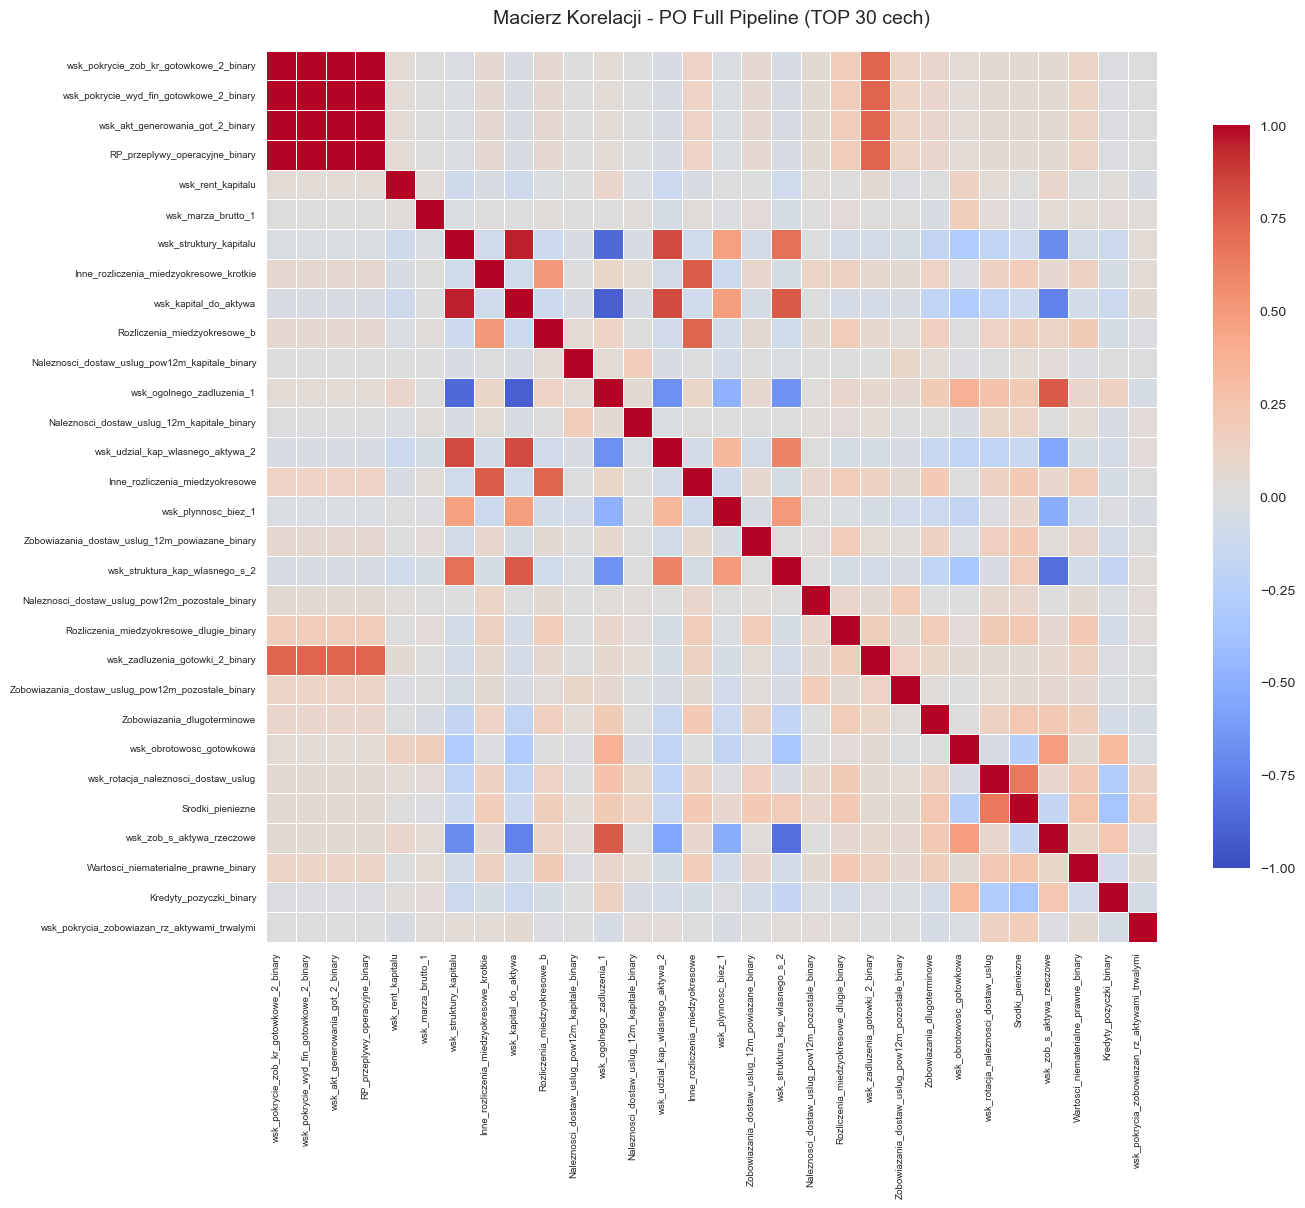

   ✅ Heatmap wygenerowana dla TOP 30 cech PO transformacji

📈 TOP 15 CECH PO transformacji (korelacja z targetem):
Rank   Feature                                        Correlation Direction      
1      wsk_pokrycie_zob_kr_gotowkowe_2_binary             +0.0793 📈 Higher = More Risk
2      wsk_pokrycie_wyd_fin_gotowkowe_2_binary            +0.0793 📈 Higher = More Risk
3      wsk_akt_generowania_got_2_binary                   +0.0793 📈 Higher = More Risk
4      RP_przeplywy_operacyjne_binary                     +0.0793 📈 Higher = More Risk
5      wsk_rent_kapitalu                                  -0.0748 📉 Higher = Less Risk
6      wsk_marza_brutto_1                                 -0.0732 📉 Higher = Less Risk
7      wsk_struktury_kapitalu                             +0.0692 📈 Higher = More Risk
8      Inne_rozliczenia_miedzyokresowe_krotkie            +0.0682 📈 Higher = More Risk
9      wsk_kapital_do_aktywa                              +0.0651 📈 Higher = More Risk
10     Rozliczenia_m

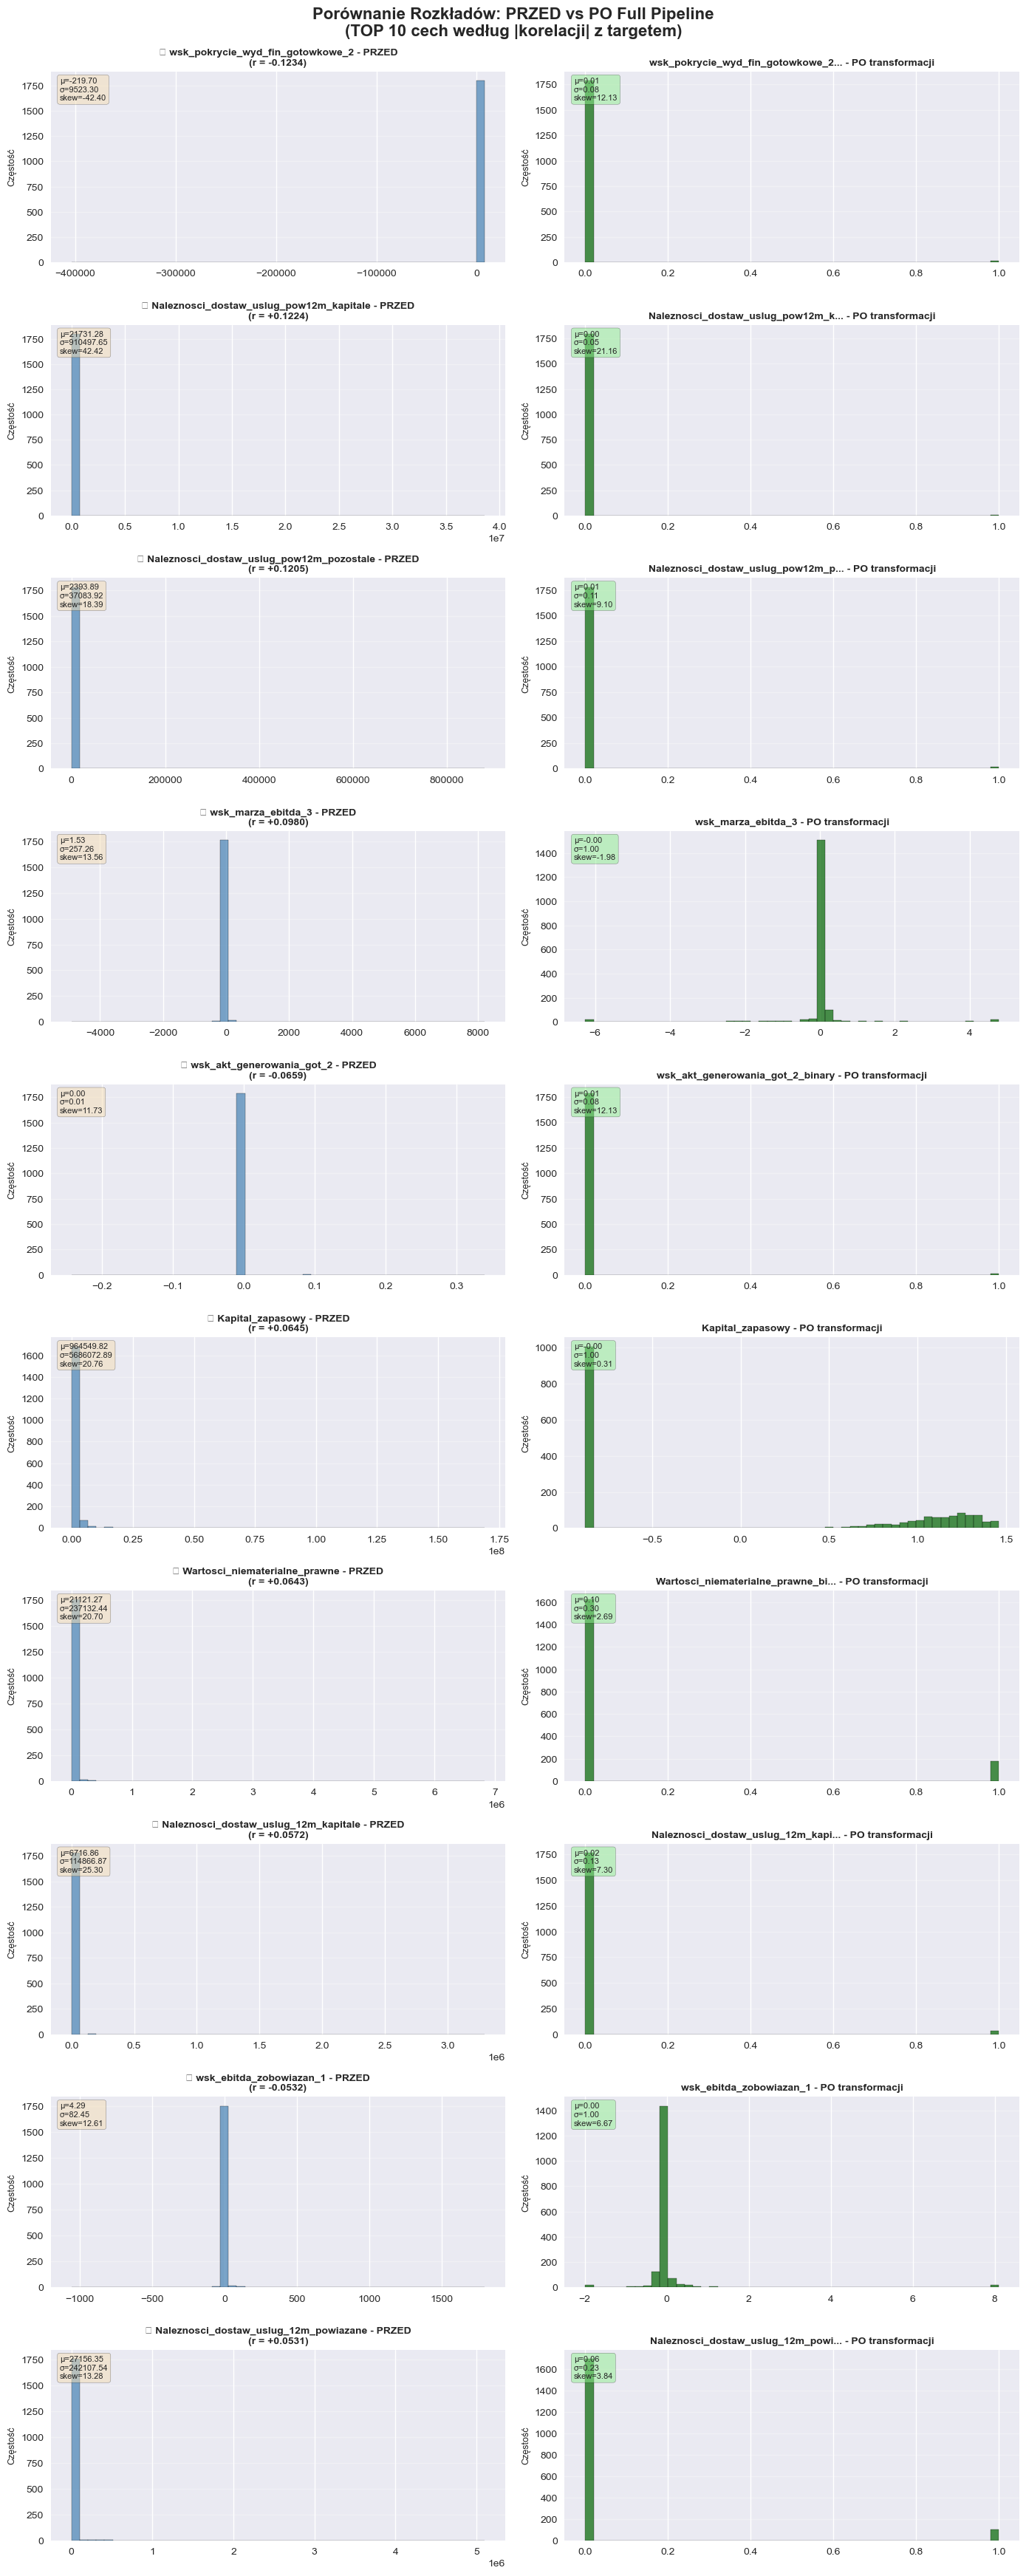


📊 PODSUMOWANIE ZMIAN W ROZKŁADACH

1️⃣  NORMALIZACJA ROZKŁADÓW (redukcja skewness):
Feature (Raw → Full)                               |Skew| Przed    |Skew| Po       Zmiana
------------------------------------------------------------------------------------------
🟡 wsk_pokrycie_wyd_fin→wsk_pokrycie_wyd_fin             42.4011      12.1347 📉   -30.2664
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             42.4179      21.1601 📉   -21.2578
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             18.3935       9.1030 📉    -9.2905
🟢 wsk_marza_ebitda_3                                    13.5551       1.9836 📉   -11.5715
🟡 wsk_akt_generowania_→wsk_akt_generowania_             11.7313      12.1347 📈    +0.4035
🟢 Kapital_zapasowy                                      20.7593       0.3070 📉   -20.4522
🟡 Wartosci_niematerial→Wartosci_niematerial             20.7041       2.6896 📉   -18.0144
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             25.2956       7.3046 📉   -17.9910
🟢 wsk_ebitda_z

In [ ]:
# ============================================================================
# EDA - PO FULL PIPELINE PREPROCESSING
# ============================================================================
print("="*80)
print("📊 EDA - PO FULL PIPELINE PREPROCESSING")
print("="*80)
print("Analiza danych po transformacjach Full Pipeline:")
print("  • Box-Cox transformation (normalizacja rozkładów)")
print("  • Winsoryzacja (usunięcie outlierów)")
print("  • Standaryzacja (mean=0, std=1)")
print("="*80 + "\n")
    
# Sprawdź dostępność danych
if 'top10_features_raw' in dir() and 'X_train_raw_backup' in dir() and 'X_train_full' in dir():
    
    # ============================================================================
    # 1. MACIERZ KORELACJI - PO Full Pipeline
    # ============================================================================
    print("1️⃣  MACIERZ KORELACJI - PO Full Pipeline preprocessing")
    print("="*80)
    
    # Oblicz macierz korelacji dla przetransformowanych danych
    corr_matrix_full = X_train_full.corr()
    
    print(f"\n📊 Liczba cech po preprocessing: {X_train_full.shape[1]}")
    print(f"📋 Macierz korelacji: {corr_matrix_full.shape[0]} × {corr_matrix_full.shape[1]}")
    print(f"📋 Zakres wartości: [{corr_matrix_full.min().min():.3f}, {corr_matrix_full.max().max():.3f}]")
    
    # Znajdź pary cech o wysokiej korelacji (>0.7)
    high_corr_pairs_full = []
    for i in range(len(corr_matrix_full.columns)):
        for j in range(i+1, len(corr_matrix_full.columns)):
            corr_val = corr_matrix_full.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs_full.append((
                    corr_matrix_full.columns[i],
                    corr_matrix_full.columns[j],
                    corr_val
                ))
    
    if len(high_corr_pairs_full) > 0:
        print(f"\n⚠️  Znaleziono {len(high_corr_pairs_full)} par cech o wysokiej korelacji (|r| > 0.7):")
        for feat1, feat2, corr_val in sorted(high_corr_pairs_full, key=lambda x: abs(x[2]), reverse=True)[:15]:
            direction = "+" if corr_val > 0 else "-"
            print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
    else:
        print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")
    
    # Statystyki korelacji
    corr_values_full = corr_matrix_full.values[np.triu_indices_from(corr_matrix_full.values, k=1)]
    print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
    print(f"   Średnia |r|:  {np.abs(corr_values_full).mean():.3f}")
    print(f"   Mediana |r|:  {np.median(np.abs(corr_values_full)):.3f}")
    print(f"   Max |r|:      {np.abs(corr_values_full).max():.3f}")
    
    # Korelacja z targetem - PO transformacji
    target_corr_full = []
    for col in X_train_full.columns:
        try:
            corr_val = X_train_full[col].corr(pd.Series(y_train.values))
            target_corr_full.append({'Feature': col, 'Correlation': corr_val, 'Abs_Correlation': abs(corr_val)})
        except:
            target_corr_full.append({'Feature': col, 'Correlation': 0.0, 'Abs_Correlation': 0.0})
    
    target_corr_full_df = pd.DataFrame(target_corr_full).sort_values('Abs_Correlation', ascending=False)
    top30_features_full = target_corr_full_df.head(30)['Feature'].tolist()
    
    # Heatmap dla top 30 cech PO transformacji
    print(f"\n📊 Wizualizacja macierzy korelacji (TOP 30 cech PO preprocessing):")
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix_full[top30_features_full].loc[top30_features_full], 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    plt.title('Macierz Korelacji - PO Full Pipeline (TOP 30 cech)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Heatmap wygenerowana dla TOP 30 cech PO transformacji")
    
    # Korelacja z targetem - TOP 15
    print(f"\n📈 TOP 15 CECH PO transformacji (korelacja z targetem):")
    print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
    print("="*80)
    
    for idx, row in target_corr_full_df.head(15).iterrows():
        rank = target_corr_full_df.index.get_loc(idx) + 1
        direction = "📈 Higher = More Risk" if row['Correlation'] > 0 else "📉 Higher = Less Risk"
        print(f"{rank:<6} {row['Feature']:<45} {row['Correlation']:>+12.4f} {direction:<15}")
    
    # ============================================================================
    # 2. PORÓWNANIE ROZKŁADÓW - TOP 10 CECH (Przed vs Po)
    # ============================================================================
    print("\n\n2️⃣  PORÓWNANIE ROZKŁADÓW - TOP 10 CECH")
    print("="*80)
    print("Wizualizacja rozkładów PRZED i PO transformacji Full Pipeline")
    print("="*80 + "\n")
    
    # STRATEGIA: Dopasuj cechy RAW do cech FULL
    # Znajdź TOP 10 cech PO transformacji
    top10_features_full = target_corr_full_df.head(10)['Feature'].tolist()
    
    # Próbuj dopasować cechy RAW do FULL (po nazwie lub częściowo)
    features_to_compare = []
    
    for feat_raw in top10_features_raw:
        # Sprawdź czy cecha istnieje bezpośrednio
        if feat_raw in X_train_full.columns:
            features_to_compare.append((feat_raw, feat_raw, 'exact'))
        else:
            # Szukaj cechy zawierającej nazwę oryginalnej
            matching_features = [f for f in X_train_full.columns if feat_raw in f]
            if matching_features:
                # Wybierz pierwszą dopasowaną cechę
                features_to_compare.append((feat_raw, matching_features[0], 'partial'))
            else:
                features_to_compare.append((feat_raw, None, 'missing'))
    
    # Jeśli więcej niż połowa cech jest missing, użyj TOP 10 cech PO transformacji
    missing_count = sum(1 for _, _, match_type in features_to_compare if match_type == 'missing')
    
    if missing_count > len(top10_features_raw) // 2:
        print("⚠️  Wiele cech zostało zmienionych przez transformacje.")
        print("📊 Wizualizacja TOP 10 cech PO transformacji (zamiast porównania PRZED/PO):\n")
        
        # Pokaż tylko cechy PO transformacji
        fig, axes = plt.subplots(10, 1, figsize=(12, 35))
        fig.suptitle('Rozkłady TOP 10 Cech PO Full Pipeline\n(według |korelacji| z targetem)', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        for idx, feat in enumerate(top10_features_full):
            ax = axes[idx]
            data = X_train_full[feat].dropna()
            
            # Oblicz korelację z targetem
            try:
                corr_with_target = X_train_full[feat].corr(pd.Series(y_train.values))
            except:
                corr_with_target = 0.0
            
            ax.hist(data, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
            ax.set_title(f'{feat}\n(r = {corr_with_target:+.4f})', 
                        fontsize=10, fontweight='bold')
            ax.set_ylabel('Częstość', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            
            # Statystyki
            mean_val = data.mean()
            std_val = data.std()
            skew_val = data.skew()
            ax.text(0.02, 0.97, 
                   f'μ={mean_val:.2f}\nσ={std_val:.2f}\nskew={skew_val:.2f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                   fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Porównanie PRZED vs PO (gdy większość cech można dopasować)
        print(f"✅ Porównanie {len(features_to_compare)} cech (PRZED vs PO transformacji)\n")
        print("Legenda:")
        print("  • 🟢 Exact match - cecha o tej samej nazwie")
        print("  • 🟡 Partial match - cecha zawierająca oryginalną nazwę")
        print("  • 🔴 Missing - cecha usunięta/całkowicie przemianowana\n")
        
        # Przygotuj subplot - 2 kolumny × 10 wierszy
        fig, axes = plt.subplots(10, 2, figsize=(14, 35))
        fig.suptitle('Porównanie Rozkładów: PRZED vs PO Full Pipeline\n(TOP 10 cech według |korelacji| z targetem)', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        for idx, (feat_raw, feat_full, match_type) in enumerate(features_to_compare):
            # Oblicz korelację z targetem (surowe dane)
            try:
                corr_with_target = X_train_raw_backup[feat_raw].corr(pd.Series(y_train.values))
            except:
                corr_with_target = 0.0
            
            # Lewy wykres - PRZED preprocessingiem
            ax_before = axes[idx, 0]
            data_before = X_train_raw_backup[feat_raw].dropna()
            
            match_icon = "🟢" if match_type == 'exact' else "🟡" if match_type == 'partial' else "🔴"
            
            ax_before.hist(data_before, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax_before.set_title(f'{match_icon} {feat_raw} - PRZED\n(r = {corr_with_target:+.4f})', 
                               fontsize=10, fontweight='bold')
            ax_before.set_ylabel('Częstość', fontsize=9)
            ax_before.grid(axis='y', alpha=0.3)
            
            # Statystyki PRZED
            mean_before = data_before.mean()
            std_before = data_before.std()
            skew_before = data_before.skew()
            ax_before.text(0.02, 0.97, 
                          f'μ={mean_before:.2f}\nσ={std_before:.2f}\nskew={skew_before:.2f}',
                          transform=ax_before.transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=8)
            
            # Prawy wykres - PO preprocessingu
            ax_after = axes[idx, 1]
            
            if feat_full is not None:
                data_after = X_train_full[feat_full].dropna()
                
                ax_after.hist(data_after, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
                
                # Skróć długą nazwę jeśli partial match
                display_name = feat_full if len(feat_full) <= 35 else feat_full[:32] + "..."
                ax_after.set_title(f'{display_name} - PO transformacji', 
                                  fontsize=10, fontweight='bold')
                ax_after.set_ylabel('Częstość', fontsize=9)
                ax_after.grid(axis='y', alpha=0.3)
                
                # Statystyki PO
                mean_after = data_after.mean()
                std_after = data_after.std()
                skew_after = data_after.skew()
                ax_after.text(0.02, 0.97, 
                             f'μ={mean_after:.2f}\nσ={std_after:.2f}\nskew={skew_after:.2f}',
                             transform=ax_after.transAxes,
                             verticalalignment='top',
                             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                             fontsize=8)
            else:
                # Cecha nie istnieje w X_train_full
                ax_after.text(0.5, 0.5, f'⚠️ Cecha usunięta\nlub całkowicie\nprzemianowana\nw Full Pipeline',
                             ha='center', va='center', transform=ax_after.transAxes,
                             fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
                ax_after.set_title(f'{feat_raw} - NIEOBECNA', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # ========================================================================
    # PODSUMOWANIE ZMIAN
    # ========================================================================
    print("\n" + "="*80)
    print("📊 PODSUMOWANIE ZMIAN W ROZKŁADACH")
    print("="*80)
    
    # Analiza zmian w skewness (tylko dla dostępnych cech)
    skewness_changes = []
    for feat_raw, feat_full, match_type in features_to_compare:
        if feat_full is not None:
            skew_before = X_train_raw_backup[feat_raw].dropna().skew()
            skew_after = X_train_full[feat_full].dropna().skew()
            skewness_changes.append({
                'Feature_Raw': feat_raw,
                'Feature_Full': feat_full,
                'Match_Type': match_type,
                'Skew_Before': skew_before,
                'Skew_After': skew_after,
                'Skew_Change': abs(skew_after) - abs(skew_before)
            })
    
    if len(skewness_changes) > 0:
        skew_df = pd.DataFrame(skewness_changes)
        
        print(f"\n1️⃣  NORMALIZACJA ROZKŁADÓW (redukcja skewness):")
        print(f"{'Feature (Raw → Full)':<50} {'|Skew| Przed':>12} {'|Skew| Po':>12} {'Zmiana':>12}")
        print("-"*90)
        
        for _, row in skew_df.iterrows():
            change_symbol = "📉" if row['Skew_Change'] < 0 else "📈"
            match_icon = "🟢" if row['Match_Type'] == 'exact' else "🟡"
            
            # Skróć nazwę jeśli za długa
            feat_display = row['Feature_Raw'] if row['Match_Type'] == 'exact' else f"{row['Feature_Raw'][:20]}→{row['Feature_Full'][:20]}"
            if len(feat_display) > 45:
                feat_display = feat_display[:42] + "..."
            
            print(f"{match_icon} {feat_display:<48} {abs(row['Skew_Before']):>12.4f} "
                  f"{abs(row['Skew_After']):>12.4f} {change_symbol} {row['Skew_Change']:>+10.4f}")
        
        avg_skew_before = skew_df['Skew_Before'].abs().mean()
        avg_skew_after = skew_df['Skew_After'].abs().mean()
        
        print("\n" + "-"*90)
        print(f"{'ŚREDNIA |SKEWNESS|':<50} {avg_skew_before:>12.4f} {avg_skew_after:>12.4f} "
              f"{'📉' if avg_skew_after < avg_skew_before else '📈'} "
              f"{avg_skew_after - avg_skew_before:>+10.4f}")
        
        if avg_skew_after < avg_skew_before:
            improvement = ((avg_skew_before - avg_skew_after) / avg_skew_before) * 100
            print(f"\n   ✅ Box-Cox transformation zredukowała średnią |skewness| o {improvement:.1f}%")
        else:
            print(f"\n   ⚠️ Rozkłady nie uległy znaczącej poprawie")
    else:
        print("\n1️⃣  NORMALIZACJA ROZKŁADÓW:")
        print("   ⚠️ Brak cech do porównania (wszystkie zostały usunięte/przemianowane)")
    
    # Analiza zmian w standaryzacji
    print(f"\n2️⃣  STANDARYZACJA (mean=0, std=1):")
    print(f"{'Feature':<50} {'Mean Po':>12} {'Std Po':>12} {'Status':>15}")
    print("-"*90)
    
    standardized_count = 0
    analyzed_count = 0
    
    for feat_raw, feat_full, match_type in features_to_compare:
        if feat_full is not None:
            analyzed_count += 1
            mean_after = X_train_full[feat_full].mean()
            std_after = X_train_full[feat_full].std()
            
            # Sprawdź czy jest standaryzowana (mean ≈ 0, std ≈ 1)
            is_standardized = (abs(mean_after) < 0.01 and abs(std_after - 1.0) < 0.1)
            status = "✅ Standaryz." if is_standardized else "⚠️ Nie"
            
            if is_standardized:
                standardized_count += 1
            
            match_icon = "🟢" if match_type == 'exact' else "🟡"
            
            # Skróć nazwę
            feat_display = feat_full if len(feat_full) <= 45 else feat_full[:42] + "..."
            
            print(f"{match_icon} {feat_display:<48} {mean_after:>12.4f} {std_after:>12.4f} {status:>15}")
    
    print("-"*90)
    if analyzed_count > 0:
        print(f"   • {standardized_count}/{analyzed_count} cech jest standaryzowana (mean≈0, std≈1)")
    else:
        print(f"   ⚠️ Brak cech do analizy")
    
    # Podsumowanie
    print(f"\n3️⃣  WPŁYW NA JAKOŚĆ DANYCH:")
    features_removed = sum(1 for _, feat_full, _ in features_to_compare if feat_full is None)
    features_exact = sum(1 for _, _, match_type in features_to_compare if match_type == 'exact')
    features_partial = sum(1 for _, _, match_type in features_to_compare if match_type == 'partial')
    
    print(f"   📊 Status cech TOP 10:")
    print(f"      🟢 Exact match:    {features_exact}/{len(features_to_compare)} cech zachowanych bez zmian")
    print(f"      🟡 Partial match:  {features_partial}/{len(features_to_compare)} cech zmodyfikowanych/rozszerzonych")
    print(f"      🔴 Missing:        {features_removed}/{len(features_to_compare)} cech usuniętych")
    
    if len(skewness_changes) > 0 and avg_skew_after < avg_skew_before:
        print(f"   ✅ Rozkłady są bardziej normalne (niższa skewness)")
    
    if analyzed_count > 0 and standardized_count >= analyzed_count * 0.8:
        print(f"   ✅ Większość cech jest poprawnie standaryzowana")
    
    # ============================================================================
    # 3. PORÓWNANIE: PRZED vs PO PREPROCESSING
    # ============================================================================
    print("\n\n4️⃣  PORÓWNANIE: PRZED vs PO PREPROCESSING")
    print("="*80)
    
    print(f"\n📊 WIELOKOLINEARNOŚĆ:")
    print(f"   PRZED: {len(high_corr_pairs_raw)} par o |r| > 0.7 (średnia |r| = {np.abs(corr_values_raw).mean():.3f})")
    print(f"   PO:    {len(high_corr_pairs_full)} par o |r| > 0.7 (średnia |r| = {np.abs(corr_values_full).mean():.3f})")
    
    if len(high_corr_pairs_full) < len(high_corr_pairs_raw):
        reduction = ((len(high_corr_pairs_raw) - len(high_corr_pairs_full)) / len(high_corr_pairs_raw)) * 100
        print(f"   ✅ Redukcja wielokolinearności o {reduction:.1f}%")
    else:
        print(f"   ⚠️ Wielokolinearność nie uległa redukcji")
    
    print(f"\n📊 MOC PREDYKCYJNA (korelacja z targetem):")
    print(f"   PRZED: Średnia |r| = {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
    print(f"   PO:    Średnia |r| = {target_corr_full_df['Abs_Correlation'].mean():.4f}")
    
    print(f"\n📊 LICZBA CECH:")
    print(f"   PRZED: {len(numeric_cols_raw)} cech")
    print(f"   PO:    {X_train_full.shape[1]} cech")
    
    print("\n" + "="*80)

else:
    print("⚠️ Brak danych do porównania.")
    print("   Upewnij się, że:")
    print("   1. Uruchomiono Section 2.5 (EDA przed preprocessingiem)")
    print("   2. Uruchomiono Full Pipeline preprocessing (X_train_full istnieje)")
    print("="*80)

## 5. Full Pipeline - Modele Interpretwalne

In [ ]:
# Słownik do przechowywania wyników
results_full = {}

### 5.1 Logistic Regression (Full)

In [ ]:
print("="*70)
print("LOGISTIC REGRESSION - FULL PIPELINE")
print("="*70)

lr_full = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full.fit(X_train_full, y_train)

y_pred_lr_full = lr_full.predict(X_test_full)
y_proba_lr_full = lr_full.predict_proba(X_test_full)[:, 1]

metrics_lr_full = calculate_all_metrics(y_test, y_pred_lr_full, y_proba_lr_full)
results_full['LR'] = {'model': lr_full, **metrics_lr_full}

print_model_metrics(metrics_lr_full, "Logistic Regression - Full Pipeline")

LOGISTIC REGRESSION - FULL PIPELINE

📊 METRYKI: Logistic Regression - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7483
Precision                0.1481
Recall                   0.6486
F1-Score                 0.2412
----------------------------------------------------------------------
ROC-AUC                  0.7501
PR-AUC                   0.1492
KS Statistic             0.4391
----------------------------------------------------------------------
Log-Loss                 0.5973
Brier Score              0.1751


### 5.2 Decision Tree (Full)

In [ ]:
print("="*70)
print("DECISION TREE - FULL PIPELINE")
print("="*70)

dt_full = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_full.fit(X_train_full, y_train)

y_pred_dt_full = dt_full.predict(X_test_full)
y_proba_dt_full = dt_full.predict_proba(X_test_full)[:, 1]

metrics_dt_full = calculate_all_metrics(y_test, y_pred_dt_full, y_proba_dt_full)
results_full['DT'] = {'model': dt_full, **metrics_dt_full}

print_model_metrics(metrics_dt_full, "Decision Tree - Full Pipeline")

DECISION TREE - FULL PIPELINE

📊 METRYKI: Decision Tree - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.6117
Precision                0.0882
Recall                   0.5676
F1-Score                 0.1527
----------------------------------------------------------------------
ROC-AUC                  0.6692
PR-AUC                   0.1175
KS Statistic             0.3036
----------------------------------------------------------------------
Log-Loss                 0.8436
Brier Score              0.2119


### 5.3 Naive Bayes (Full)

In [ ]:
print("="*70)
print("NAIVE BAYES - FULL PIPELINE")
print("="*70)

nb_full = GaussianNB()
nb_full.fit(X_train_full, y_train)

y_pred_nb_full = nb_full.predict(X_test_full)
y_proba_nb_full = nb_full.predict_proba(X_test_full)[:, 1]

metrics_nb_full = calculate_all_metrics(y_test, y_pred_nb_full, y_proba_nb_full)
results_full['NB'] = {'model': nb_full, **metrics_nb_full}

print_model_metrics(metrics_nb_full, "Naive Bayes - Full Pipeline")

NAIVE BAYES - FULL PIPELINE

📊 METRYKI: Naive Bayes - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.2667
Precision                0.0685
Recall                   0.8649
F1-Score                 0.1270
----------------------------------------------------------------------
ROC-AUC                  0.5540
PR-AUC                   0.0689
KS Statistic             0.1090
----------------------------------------------------------------------
Log-Loss                26.2327
Brier Score              0.7333


## 6. Full Pipeline - Modele Black Box

### 6.1 Inicjalizacja

In [ ]:
# Słownik do przechowywania wyników modeli black box (Full Pipeline)
results_blackbox_full = {}

### 6.2 Random Forest (Black Box)

In [ ]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (FULL PIPELINE)")
print("="*70)

rf_blackbox_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full.fit(X_train_full, y_train)

y_pred_rf_blackbox_full = rf_blackbox_full.predict(X_test_full)
y_proba_rf_blackbox_full = rf_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_rf_blackbox = calculate_all_metrics(y_test, y_pred_rf_blackbox_full, y_proba_rf_blackbox_full)
results_blackbox_full['RF'] = {'model': rf_blackbox_full, **metrics_rf_blackbox}

print_model_metrics(metrics_rf_blackbox, "Random Forest - Black Box Full")

RANDOM FOREST - BLACK BOX (FULL PIPELINE)

📊 METRYKI: Random Forest - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8517
Precision                0.2174
Recall                   0.5405
F1-Score                 0.3101
----------------------------------------------------------------------
ROC-AUC                  0.8128
PR-AUC                   0.1836
KS Statistic             0.5746
----------------------------------------------------------------------
Log-Loss                 0.3707
Brier Score              0.1153


### 6.3 XGBoost (Black Box - Full)

In [ ]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (FULL PIPELINE)")
    print("="*70)
    
    xgb_blackbox_full = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox_full.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox_full.fit(X_train_full, y_train)
    
    y_pred_xgb_blackbox_full = xgb_blackbox_full.predict(X_test_full)
    y_proba_xgb_blackbox_full = xgb_blackbox_full.predict_proba(X_test_full)[:, 1]
    
    metrics_xgb_blackbox = calculate_all_metrics(y_test, y_pred_xgb_blackbox_full, y_proba_xgb_blackbox_full)
    results_blackbox_full['XGB'] = {'model': xgb_blackbox_full, **metrics_xgb_blackbox}
    
    print_model_metrics(metrics_xgb_blackbox, "XGBoost - Black Box Full")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (FULL PIPELINE)

📊 METRYKI: XGBoost - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9083
Precision                0.0909
Recall                   0.0541
F1-Score                 0.0678
----------------------------------------------------------------------
ROC-AUC                  0.7405
PR-AUC                   0.1329
KS Statistic             0.4270
----------------------------------------------------------------------
Log-Loss                 0.2472
Brier Score              0.0691


### 6.4 SVM (Black Box - Full)

In [ ]:
print("="*70)
print("SVM - BLACK BOX (FULL PIPELINE)")
print("="*70)

svm_blackbox_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox_full.fit(X_train_full, y_train)

y_pred_svm_blackbox_full = svm_blackbox_full.predict(X_test_full)
y_proba_svm_blackbox_full = svm_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_svm_blackbox = calculate_all_metrics(y_test, y_pred_svm_blackbox_full, y_proba_svm_blackbox_full)
results_blackbox_full['SVM'] = {'model': svm_blackbox_full, **metrics_svm_blackbox}

print_model_metrics(metrics_svm_blackbox, "SVM - Black Box Full")

SVM - BLACK BOX (FULL PIPELINE)

📊 METRYKI: SVM - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8100
Precision                0.1709
Recall                   0.5405
F1-Score                 0.2597
----------------------------------------------------------------------
ROC-AUC                  0.7809
PR-AUC                   0.1490
KS Statistic             0.4912
----------------------------------------------------------------------
Log-Loss                 0.2110
Brier Score              0.0554


### 6.5 Neural Network (Black Box - Full)

In [ ]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)")
print("="*70)

mlp_blackbox_full = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox_full.fit(X_train_full, y_train)

y_pred_mlp_blackbox_full = mlp_blackbox_full.predict(X_test_full)
y_proba_mlp_blackbox_full = mlp_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_mlp_blackbox = calculate_all_metrics(y_test, y_pred_mlp_blackbox_full, y_proba_mlp_blackbox_full)
results_blackbox_full['Neural Network'] = {'model': mlp_blackbox_full, **metrics_mlp_blackbox}

print_model_metrics(metrics_mlp_blackbox, "Neural Network (MLP) - Black Box Full")
print(f"  Liczba iteracji: {mlp_blackbox_full.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox_full.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)

📊 METRYKI: Neural Network (MLP) - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9300
Precision                0.2222
Recall                   0.0541
F1-Score                 0.0870
----------------------------------------------------------------------
ROC-AUC                  0.7701
PR-AUC                   0.1874
KS Statistic             0.4333
----------------------------------------------------------------------
Log-Loss                 0.2147
Brier Score              0.0586
  Liczba iteracji: 33
  Liczba warstw: 3


---

# CZĘŚĆ 2: MINIMAL PIPELINE

## 7. Minimal Pipeline - Preprocessing

In [ ]:
# Inicjalizacja i dopasowanie pipeline
pipeline_minimal = MinimalPreprocessingPipeline(
    correlation_threshold=0.80,
    standardize=True
)

print("Dopasowywanie Minimal Pipeline...")
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n✅ Minimal Pipeline gotowy")
print(f"   Train: {X_train_minimal.shape}")
print(f"   Test: {X_test_minimal.shape}")
print(f"   NaN: {X_train_minimal.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_minimal.values).sum()}")

Dopasowywanie Minimal Pipeline...

✅ Minimal Pipeline gotowy
   Train: (1800, 136)
   Test: (600, 136)
   NaN: 0
   Inf: 0


## 8. Minimal Pipeline - Trening Modeli

In [ ]:
# Słownik do przechowywania wyników
results_minimal = {}

### 8.1 Logistic Regression (Minimal)

In [ ]:
print("="*70)
print("LOGISTIC REGRESSION - MINIMAL PIPELINE")
print("="*70)

lr_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal.fit(X_train_minimal, y_train)

y_pred_lr_minimal = lr_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_lr_minimal = calculate_all_metrics(y_test, y_pred_lr_minimal, y_proba_lr_minimal)
results_minimal['LR'] = {'model': lr_minimal, **metrics_lr_minimal}

print_model_metrics(metrics_lr_minimal, "Logistic Regression - Minimal Pipeline")

LOGISTIC REGRESSION - MINIMAL PIPELINE

📊 METRYKI: Logistic Regression - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7650
Precision                0.1623
Recall                   0.6757
F1-Score                 0.2618
----------------------------------------------------------------------
ROC-AUC                  0.7511
PR-AUC                   0.1517
KS Statistic             0.4558
----------------------------------------------------------------------
Log-Loss                 0.6746
Brier Score              0.1729


### 8.2 Decision Tree (Minimal)

In [ ]:
print("="*70)
print("DECISION TREE - MINIMAL PIPELINE")
print("="*70)

dt_minimal = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_minimal.fit(X_train_minimal, y_train)

y_pred_dt_minimal = dt_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_dt_minimal = calculate_all_metrics(y_test, y_pred_dt_minimal, y_proba_dt_minimal)
results_minimal['DT'] = {'model': dt_minimal, **metrics_dt_minimal}

print_model_metrics(metrics_dt_minimal, "Decision Tree - Minimal Pipeline")

DECISION TREE - MINIMAL PIPELINE

📊 METRYKI: Decision Tree - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.5750
Precision                0.1022
Recall                   0.7568
F1-Score                 0.1801
----------------------------------------------------------------------
ROC-AUC                  0.6839
PR-AUC                   0.1130
KS Statistic             0.3364
----------------------------------------------------------------------
Log-Loss                 0.9571
Brier Score              0.2139


### 8.3 Naive Bayes (Minimal)

In [ ]:
print("="*70)
print("NAIVE BAYES - MINIMAL PIPELINE")
print("="*70)

nb_minimal = GaussianNB()
nb_minimal.fit(X_train_minimal, y_train)

y_pred_nb_minimal = nb_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_nb_minimal = calculate_all_metrics(y_test, y_pred_nb_minimal, y_proba_nb_minimal)
results_minimal['NB'] = {'model': nb_minimal, **metrics_nb_minimal}

print_model_metrics(metrics_nb_minimal, "Naive Bayes - Minimal Pipeline")

NAIVE BAYES - MINIMAL PIPELINE

📊 METRYKI: Naive Bayes - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.3100
Precision                0.0686
Recall                   0.8108
F1-Score                 0.1266
----------------------------------------------------------------------
ROC-AUC                  0.5624
PR-AUC                   0.0707
KS Statistic             0.1252
----------------------------------------------------------------------
Log-Loss                24.2152
Brier Score              0.6899


---

# CZĘŚĆ 2.5: MODELE BLACK BOX (MINIMAL PIPELINE)

## 7.5 Modele Black Box - Słownik Wyników

In [ ]:
# Słownik do przechowywania wyników modeli black box
results_blackbox = {}

### 8.4 Random Forest (Black Box)

In [ ]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

rf_blackbox = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox.fit(X_train_minimal, y_train)

y_pred_rf_blackbox = rf_blackbox.predict(X_test_minimal)
y_proba_rf_blackbox = rf_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_rf_blackbox_min = calculate_all_metrics(y_test, y_pred_rf_blackbox, y_proba_rf_blackbox)
results_blackbox['RF'] = {'model': rf_blackbox, **metrics_rf_blackbox_min}

print_model_metrics(metrics_rf_blackbox_min, "Random Forest - Black Box Minimal")

RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: Random Forest - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8483
Precision                0.1932
Recall                   0.4595
F1-Score                 0.2720
----------------------------------------------------------------------
ROC-AUC                  0.8070
PR-AUC                   0.1676
KS Statistic             0.5618
----------------------------------------------------------------------
Log-Loss                 0.3745
Brier Score              0.1159


### 8.5 XGBoost (Black Box)

In [ ]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (MINIMAL PIPELINE)")
    print("="*70)
    
    xgb_blackbox = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox.fit(X_train_minimal, y_train)
    
    y_pred_xgb_blackbox = xgb_blackbox.predict(X_test_minimal)
    y_proba_xgb_blackbox = xgb_blackbox.predict_proba(X_test_minimal)[:, 1]
    
    metrics_xgb_blackbox_min = calculate_all_metrics(y_test, y_pred_xgb_blackbox, y_proba_xgb_blackbox)
    results_blackbox['XGB'] = {'model': xgb_blackbox, **metrics_xgb_blackbox_min}
    
    print_model_metrics(metrics_xgb_blackbox_min, "XGBoost - Black Box Minimal")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: XGBoost - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9083
Precision                0.0909
Recall                   0.0541
F1-Score                 0.0678
----------------------------------------------------------------------
ROC-AUC                  0.7659
PR-AUC                   0.1569
KS Statistic             0.4461
----------------------------------------------------------------------
Log-Loss                 0.2384
Brier Score              0.0686


### 8.6 SVM (Black Box - Minimal)

In [ ]:
print("="*70)
print("SVM - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

svm_blackbox = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox.fit(X_train_minimal, y_train)

y_pred_svm_blackbox = svm_blackbox.predict(X_test_minimal)
y_proba_svm_blackbox = svm_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_svm_blackbox_min = calculate_all_metrics(y_test, y_pred_svm_blackbox, y_proba_svm_blackbox)
results_blackbox['SVM'] = {'model': svm_blackbox, **metrics_svm_blackbox_min}

print_model_metrics(metrics_svm_blackbox_min, "SVM - Black Box Minimal")

SVM - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: SVM - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8150
Precision                0.1574
Recall                   0.4595
F1-Score                 0.2345
----------------------------------------------------------------------
ROC-AUC                  0.7485
PR-AUC                   0.1524
KS Statistic             0.4248
----------------------------------------------------------------------
Log-Loss                 0.2172
Brier Score              0.0561


### 8.7 Neural Network (Black Box - Minimal)

In [ ]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

mlp_blackbox = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox.fit(X_train_minimal, y_train)

y_pred_mlp_blackbox = mlp_blackbox.predict(X_test_minimal)
y_proba_mlp_blackbox = mlp_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_mlp_blackbox_min = calculate_all_metrics(y_test, y_pred_mlp_blackbox, y_proba_mlp_blackbox)
results_blackbox['Neural Network'] = {'model': mlp_blackbox, **metrics_mlp_blackbox_min}

print_model_metrics(metrics_mlp_blackbox_min, "Neural Network (MLP) - Black Box Minimal")

NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: Neural Network (MLP) - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9133
Precision                0.0588
Recall                   0.0270
F1-Score                 0.0370
----------------------------------------------------------------------
ROC-AUC                  0.7331
PR-AUC                   0.1558
KS Statistic             0.4175
----------------------------------------------------------------------
Log-Loss                 0.2547
Brier Score              0.0662


## 4.5 EDA - Analiza Po Full Pipeline Preprocessing

Analiza danych po transformacjach: korelacje, TOP cechy, porównanie rozkładów PRZED vs PO

---

# 📈 CZĘŚĆ II: CREDIT SCORECARDS

## 9. Weight of Evidence (WoE) - Funkcje Pomocnicze

Model Credit Scorecard to standardowe narzędzie w branży bankowej oparte o:
- **Weight of Evidence (WoE)**: Transformacja zmiennych na log-odds
- **Information Value (IV)**: Miara mocy predykcyjnej zmiennych
- **Logistic Regression**: Model na transformowanych WoE features
- **System punktów**: Konwersja na punkty kredytowe (600 base, 20 PDO)

In [ ]:
# Funkcje WoE/IV
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Oblicza Weight of Evidence (WoE) i Information Value (IV) dla zmiennej.
    
    WoE = ln(% Good / % Bad)
    IV = Σ (% Good - % Bad) * WoE
    """
    # Binning
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz Good/Bad w każdym binie
    grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Dystrybukcje
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_dist'] = grouped['good'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad
    
    # WoE (z zabezpieczeniem przed dzieleniem przez 0)
    grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
    
    # IV
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    
    return grouped[['good', 'bad', 'total', 'woe', 'iv']], iv_total

def woe_transform(df, feature, target, bins=5):
    """Transformuje zmienną na wartości WoE"""
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz WoE dla każdego bina
    woe_table, _ = calculate_woe_iv(df, feature, target, bins)
    woe_dict = dict(zip(woe_table.index, woe_table['woe']))
    
    # Przypisz WoE
    try:
        feature_binned = pd.qcut(df[feature], q=bins, duplicates='drop')
    except:
        feature_binned = pd.cut(df[feature], bins=bins, duplicates='drop')
    
    woe_values = feature_binned.map(lambda x: woe_dict.get(x, 0) if pd.notna(x) else 0)
    
    return woe_values

print("✅ Funkcje WoE/IV zdefiniowane")

✅ Funkcje WoE/IV zdefiniowane


## 10. Tabela Porównawcza

In [ ]:
# Przygotowanie danych do porównania
comparison_data = []

for model_name in results_full.keys():
    # Full pipeline (z nowymi metrykami)
    if model_name != 'model':  # Pomiń pole 'model'
        comparison_data.append({
            'Pipeline': 'Full',
            'Model': model_name,
            'Accuracy': results_full[model_name].get('accuracy', 0),
            'Precision': results_full[model_name].get('precision', 0),
            'Recall': results_full[model_name].get('recall', 0),
            'F1-Score': results_full[model_name].get('f1', 0),
            'ROC-AUC': results_full[model_name].get('roc_auc', results_full[model_name].get('auc', 0))
        })
    
    # Minimal pipeline
    if model_name in results_minimal and model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Minimal',
            'Model': model_name,
            'Accuracy': results_minimal[model_name].get('accuracy', 0),
            'Precision': results_minimal[model_name].get('precision', 0),
            'Recall': results_minimal[model_name].get('recall', 0),
            'F1-Score': results_minimal[model_name].get('f1', 0),
            'ROC-AUC': results_minimal[model_name].get('roc_auc', results_minimal[model_name].get('auc', 0))
        })

# Dodaj modele black box (Full Pipeline)
for model_name in results_blackbox_full.keys():
    if model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Black Box (Full)',
            'Model': model_name,
            'Accuracy': results_blackbox_full[model_name].get('accuracy', 0),
            'Precision': results_blackbox_full[model_name].get('precision', 0),
            'Recall': results_blackbox_full[model_name].get('recall', 0),
            'F1-Score': results_blackbox_full[model_name].get('f1', 0),
            'ROC-AUC': results_blackbox_full[model_name].get('roc_auc', results_blackbox_full[model_name].get('auc', 0))
        })

# Dodaj modele black box (Minimal Pipeline)
for model_name in results_blackbox.keys():
    if model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Black Box (Minimal)',
            'Model': model_name,
            'Accuracy': results_blackbox[model_name].get('accuracy', 0),
            'Precision': results_blackbox[model_name].get('precision', 0),
            'Recall': results_blackbox[model_name].get('recall', 0),
            'F1-Score': results_blackbox[model_name].get('f1', 0),
            'ROC-AUC': results_blackbox[model_name].get('roc_auc', results_blackbox[model_name].get('auc', 0))
        })

comparison_df = pd.DataFrame(comparison_data)

print("="*110)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)")
print("="*110)
print()
print(comparison_df.to_string(index=False))
print()
print(f"\n🔢 Liczba cech:")
print(f"   Full Pipeline:         {X_train_full.shape[1]} cech")
print(f"   Minimal Pipeline:      {X_train_minimal.shape[1]} cech")
print(f"   Black Box (Full):      {X_train_full.shape[1]} cech (używa Full Pipeline)")
print(f"   Black Box (Minimal):   {X_train_minimal.shape[1]} cech (używa Minimal Pipeline)")

PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)

           Pipeline          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
               Full             LR  0.748333   0.148148 0.648649  0.241206 0.750132
            Minimal             LR  0.765000   0.162338 0.675676  0.261780 0.751092
               Full             DT  0.611667   0.088235 0.567568  0.152727 0.669195
            Minimal             DT  0.575000   0.102190 0.756757  0.180064 0.683909
               Full             NB  0.266667   0.068522 0.864865  0.126984 0.554006
            Minimal             NB  0.310000   0.068650 0.810811  0.126582 0.562383
   Black Box (Full)             RF  0.851667   0.217391 0.540541  0.310078 0.812755
   Black Box (Full)            XGB  0.908333   0.090909 0.054054  0.067797 0.740531
   Black Box (Full)            SVM  0.810000   0.170940 0.540541  0.259740 0.780855
   Black Box (Full) Neural Network  0.930000   0.222222 0.054054  0.086957 0.77010

## 11. Feature Importance z SHAP (Full Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla pełnego pipeline'u.

In [ ]:
# SHAP Full Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Full Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_FULL = True
except ImportError:
    SHAP_AVAILABLE_FULL = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

full_top30_features = []
shap_full_df = None

if SHAP_AVAILABLE_FULL:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_full))
    X_sample_full = X_train_full.sample(n=sample_size, random_state=42)
    
    shap_results_full = []
    
    # 1. LOGISTIC REGRESSION (Full)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Full)...")
    explainer_lr_full = shap.LinearExplainer(lr_full, X_sample_full)
    shap_values_lr_full = explainer_lr_full.shap_values(X_sample_full)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_full) == list:
        shap_values_lr_full = shap_values_lr_full[1]
    
    shap_abs_mean_lr_full = np.abs(shap_values_lr_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_full[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Full)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Full)...")
    explainer_dt_full = shap.TreeExplainer(dt_full)
    shap_values_dt_full = explainer_dt_full.shap_values(X_sample_full)
    
    if type(shap_values_dt_full) == list:
        shap_values_dt_full = shap_values_dt_full[1]
    
    shap_abs_mean_dt_full = np.abs(shap_values_dt_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_full[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Full)
    print("[3/3] Obliczanie SHAP dla Random Forest (Full)...")
    explainer_rf_full = shap.TreeExplainer(rf_blackbox_full)
    shap_values_rf_full = explainer_rf_full.shap_values(X_sample_full)
    
    if type(shap_values_rf_full) == list:
        shap_values_rf_full = shap_values_rf_full[1]
    
    shap_abs_mean_rf_full = np.abs(shap_values_rf_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_full[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_full_df = pd.DataFrame(shap_results_full)
    shap_full_agg = shap_full_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    print(shap_full_agg['SHAP_mean'].head())

    shap_full_agg['SHAP_mean'] = shap_full_agg['SHAP_mean'].apply(
        lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
    )
    shap_full_agg = shap_full_agg.sort_values('SHAP_mean', ascending=False)
    
    full_top30_features = shap_full_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Full Pipeline).")
    print(f"Top 30 cech: {len(full_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Full Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Full)...
[2/3] Obliczanie SHAP dla Decision Tree (Full)...
[3/3] Obliczanie SHAP dla Random Forest (Full)...
0       [0.29681527879257585, 0.2968152787925758]
1      [0.0168654092078805, 0.016865409207880464]
2      [0.06155962084820434, 0.06155962084820432]
3      [0.11248445644878095, 0.11248445644878095]
4    [0.038324496417396374, 0.038324496417396374]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.


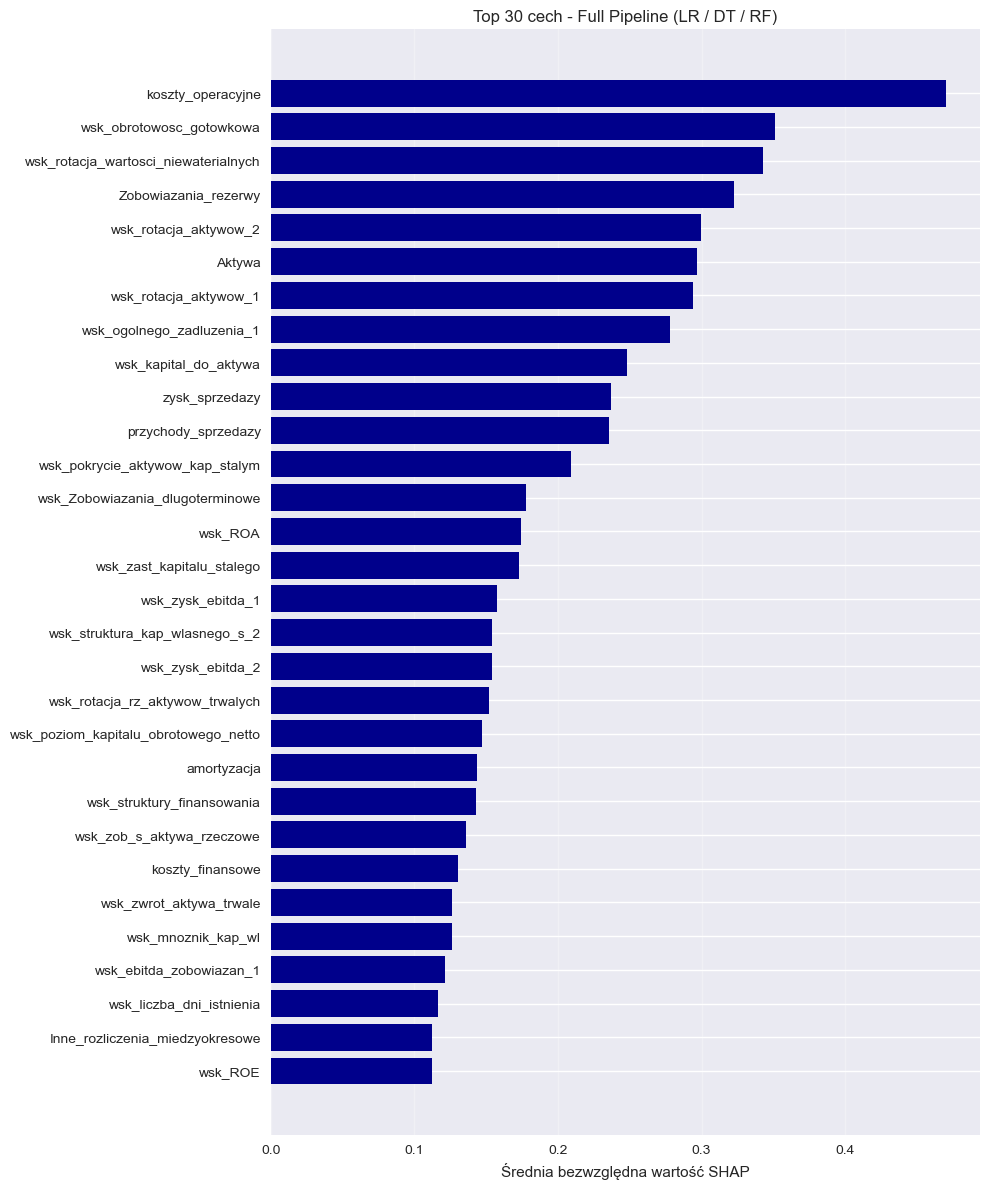

In [ ]:
# Wykres Top 30 Full Pipeline
if shap_full_df is not None and len(full_top30_features) > 0:
    plot_df_full = shap_full_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_full['feature'][::-1], plot_df_full['SHAP_mean'][::-1], color='darkblue')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Full Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Full Pipeline SHAP.')

## 12. Feature Importance z SHAP (Minimal Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla minimalnego pipeline'u.

In [ ]:
# SHAP Minimal Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_MIN = True
except ImportError:
    SHAP_AVAILABLE_MIN = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

minimal_top30_features = []
shap_min_df = None

if SHAP_AVAILABLE_MIN:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_minimal))
    X_sample_min = X_train_minimal.sample(n=sample_size, random_state=42)
    
    shap_results_min = []
    
    # 1. LOGISTIC REGRESSION (Minimal)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...")
    explainer_lr_min = shap.LinearExplainer(lr_minimal, X_sample_min)
    shap_values_lr_min = explainer_lr_min.shap_values(X_sample_min)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_min) == list:
        shap_values_lr_min = shap_values_lr_min[1]
    
    shap_abs_mean_lr_min = np.abs(shap_values_lr_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_min[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Minimal)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...")
    explainer_dt_min = shap.TreeExplainer(dt_minimal)
    shap_values_dt_min = explainer_dt_min.shap_values(X_sample_min)
    
    if type(shap_values_dt_min) == list:
        shap_values_dt_min = shap_values_dt_min[1]
    
    shap_abs_mean_dt_min = np.abs(shap_values_dt_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_min[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Minimal)
    print("[3/3] Obliczanie SHAP dla Random Forest (Minimal)...")
    explainer_rf_min = shap.TreeExplainer(rf_blackbox)
    shap_values_rf_min = explainer_rf_min.shap_values(X_sample_min)
    
    if type(shap_values_rf_min) == list:
        shap_values_rf_min = shap_values_rf_min[1]
    
    shap_abs_mean_rf_min = np.abs(shap_values_rf_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_min[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_min_df = pd.DataFrame(shap_results_min)
    shap_min_agg = shap_min_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    shap_min_agg['SHAP_mean'] = shap_min_agg['SHAP_mean'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
)
    shap_min_agg = shap_min_agg.sort_values('SHAP_mean', ascending=False)
    
    minimal_top30_features = shap_min_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Minimal Pipeline).")
    print(f"Top 30 cech: {len(minimal_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...
[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...
[3/3] Obliczanie SHAP dla Random Forest (Minimal)...

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.


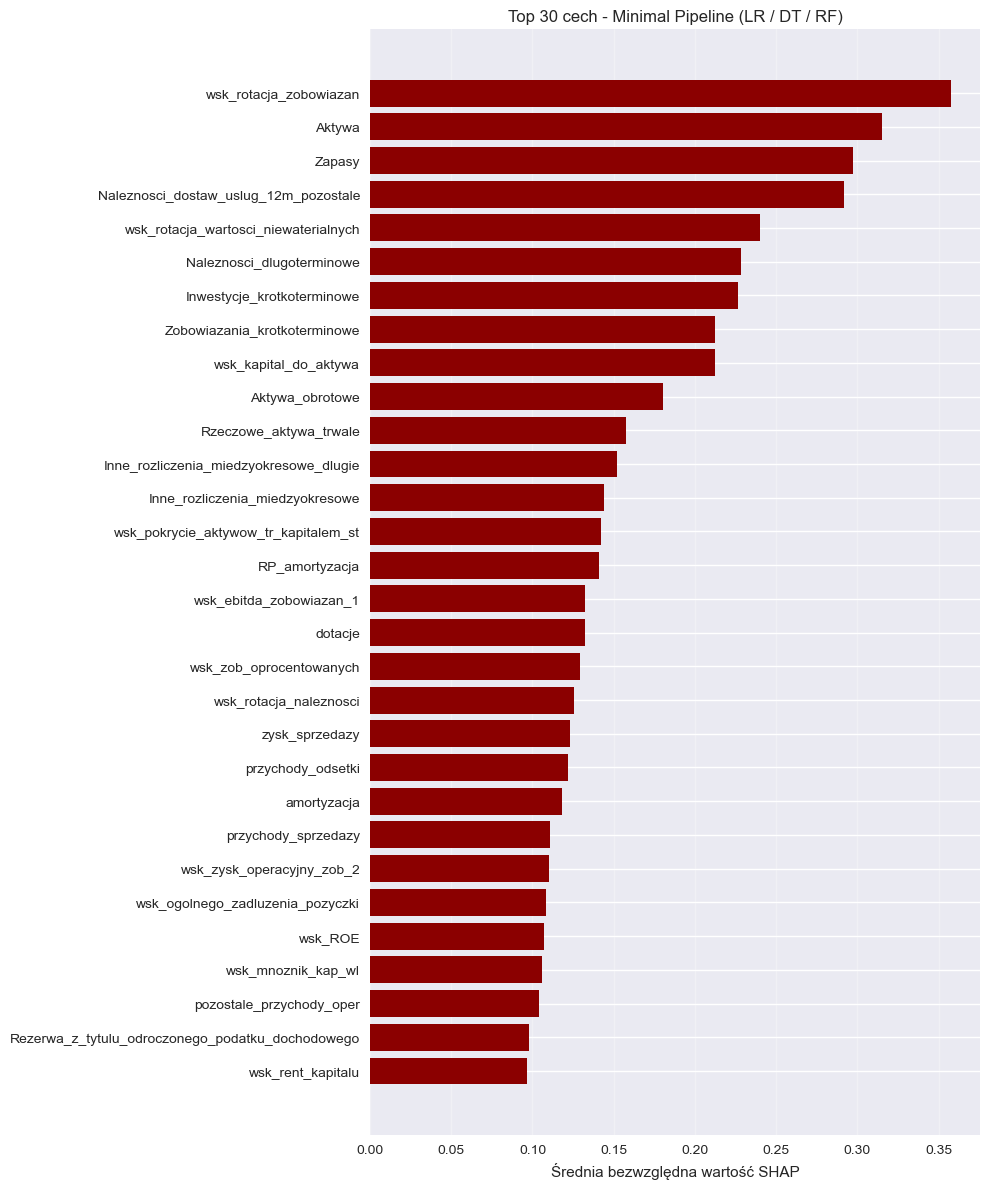

In [ ]:
# Wykres Top 30 Minimal Pipeline
if shap_min_df is not None and len(minimal_top30_features) > 0:
    plot_df_min = shap_min_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_min['feature'][::-1], plot_df_min['SHAP_mean'][::-1], color='darkred')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Minimal Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Minimal Pipeline SHAP.')

## 13. Modele na Top 30 cechach (Full Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla pełnego pipeline'u.

In [ ]:
# Modele na Top 30 cechach - Full Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE")
print("="*100)

if len(full_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_full_top30 = X_train_full[full_top30_features]
    X_test_full_top30 = X_test_full[full_top30_features]
    
    print(f"\nWybrano {len(full_top30_features)} cech z {X_train_full.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_full_top30.shape}")
    print(f"Kształt danych testowych: {X_test_full_top30.shape}")
    
    results_full_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Full)...")
    lr_full_top30 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_full_top30.fit(X_train_full_top30, y_train)
    y_pred_lr_full_top30 = lr_full_top30.predict(X_test_full_top30)
    y_proba_lr_full_top30 = lr_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['LR'] = {
        'model': lr_full_top30,
        'y_pred': y_pred_lr_full_top30,
        'y_proba': y_proba_lr_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_full_top30),
        'precision': precision_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Full)...")
    dt_full_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42, class_weight='balanced')
    dt_full_top30.fit(X_train_full_top30, y_train)
    y_pred_dt_full_top30 = dt_full_top30.predict(X_test_full_top30)
    y_proba_dt_full_top30 = dt_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['DT'] = {
        'model': dt_full_top30,
        'y_pred': y_pred_dt_full_top30,
        'y_proba': y_proba_dt_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_full_top30),
        'precision': precision_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Full)...")
    rf_full_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced')
    rf_full_top30.fit(X_train_full_top30, y_train)
    y_pred_rf_full_top30 = rf_full_top30.predict(X_test_full_top30)
    y_proba_rf_full_top30 = rf_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['RF'] = {
        'model': rf_full_top30,
        'y_pred': y_pred_rf_full_top30,
        'y_proba': y_proba_rf_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_full_top30),
        'precision': precision_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_full_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Full Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE

Wybrano 30 cech z 165 dostępnych.
Kształt danych treningowych: (1800, 30)
Kształt danych testowych: (600, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Full)...
  ✓ F1-Score: 0.2320
[2/3] Trening Decision Tree na Top 30 cechach (Full)...
  ✓ F1-Score: 0.1762
[3/3] Trening Random Forest na Top 30 cechach (Full)...
  ✓ F1-Score: 0.3115

PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.6800       0.1362       0.7838       0.2320       0.7775      
DT                   0.6883       0.1053       0.5405       0.1762       0.6767      
RF                   0.8600       0.2235       0.5135       0.3115       0.8087      

✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.


## 14. Modele na Top 30 cechach (Minimal Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla minimalnego pipeline'u.

In [ ]:
# Modele na Top 30 cechach - Minimal Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE")
print("="*100)

if len(minimal_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_minimal_top30 = X_train_minimal[minimal_top30_features]
    X_test_minimal_top30 = X_test_minimal[minimal_top30_features]
    
    print(f"\nWybrano {len(minimal_top30_features)} cech z {X_train_minimal.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_minimal_top30.shape}")
    print(f"Kształt danych testowych: {X_test_minimal_top30.shape}")
    
    results_minimal_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...")
    lr_minimal_top30 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_lr_minimal_top30 = lr_minimal_top30.predict(X_test_minimal_top30)
    y_proba_lr_minimal_top30 = lr_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['LR'] = {
        'model': lr_minimal_top30,
        'y_pred': y_pred_lr_minimal_top30,
        'y_proba': y_proba_lr_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_minimal_top30),
        'precision': precision_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...")
    dt_minimal_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42, class_weight='balanced')
    dt_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_dt_minimal_top30 = dt_minimal_top30.predict(X_test_minimal_top30)
    y_proba_dt_minimal_top30 = dt_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['DT'] = {
        'model': dt_minimal_top30,
        'y_pred': y_pred_dt_minimal_top30,
        'y_proba': y_proba_dt_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_minimal_top30),
        'precision': precision_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Minimal)...")
    rf_minimal_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced')
    rf_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_rf_minimal_top30 = rf_minimal_top30.predict(X_test_minimal_top30)
    y_proba_rf_minimal_top30 = rf_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['RF'] = {
        'model': rf_minimal_top30,
        'y_pred': y_pred_rf_minimal_top30,
        'y_proba': y_proba_rf_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_minimal_top30),
        'precision': precision_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_minimal_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Minimal Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE

Wybrano 30 cech z 136 dostępnych.
Kształt danych treningowych: (1800, 30)
Kształt danych testowych: (600, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.1883
[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.1899
[3/3] Trening Random Forest na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.2203

PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.6983       0.1129       0.5676       0.1883       0.7219      
DT                   0.5733       0.1075       0.8108       0.1899       0.6690      
RF                   0.8467       0.1605       0.3514       0.2203       0.7901      

✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.


## 15. Porównanie: Wszystkie cechy vs Top 30 cech

Wizualizacja porównująca wyniki modeli na wszystkich cechach z wynikami na Top 30 cechach wybranych przez SHAP.

PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH


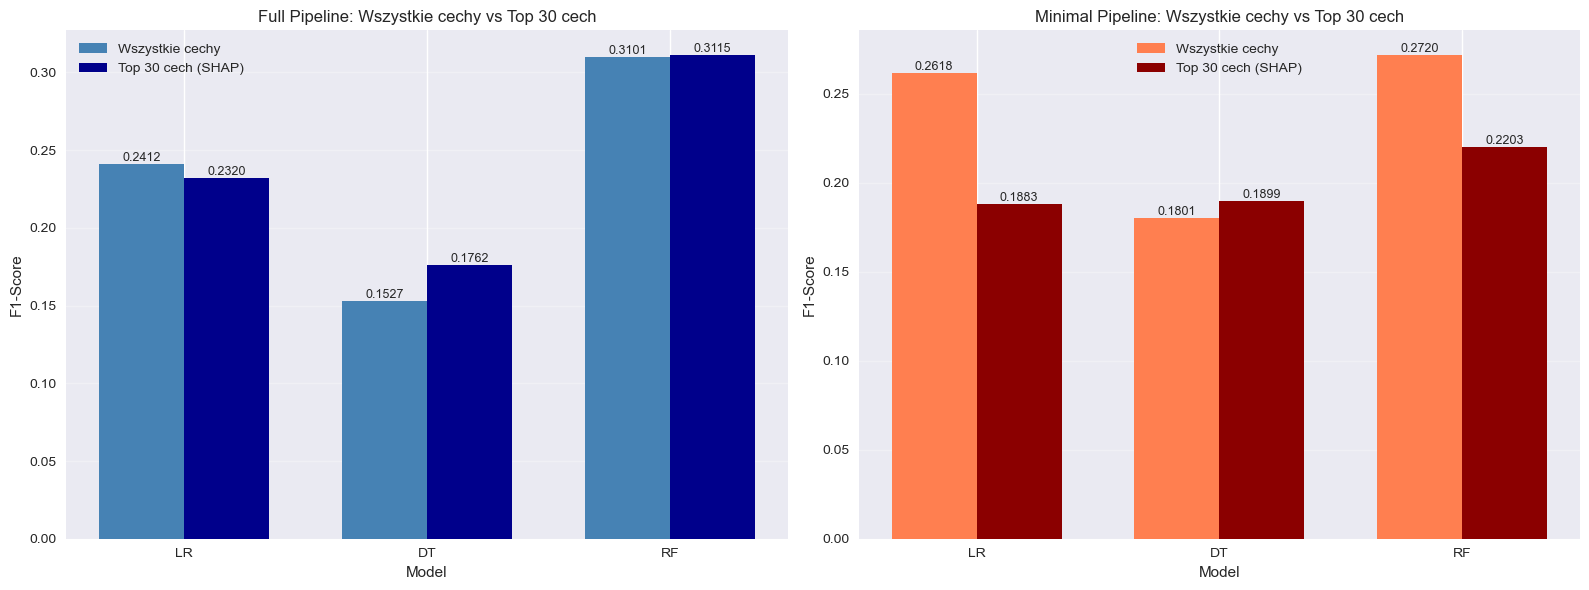


✅ Porównanie wyników zakończone.


In [ ]:
# Porównanie wyników: Wszystkie cechy vs Top 30 cech
print("="*100)
print("PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH")
print("="*100)

# Przygotowanie danych do porównania
comparison_data_top30 = []

# FULL PIPELINE
if len(full_top30_features) > 0:
    # Wszystkie cechy Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_full['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_full['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox_full['RF']['f1']
    })
    
    # Top 30 Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_full_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_full_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_full_top30['RF']['f1']
    })

# MINIMAL PIPELINE
if len(minimal_top30_features) > 0:
    # Wszystkie cechy Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_minimal['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_minimal['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox['RF']['f1']
    })
    
    # Top 30 Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_minimal_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_minimal_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_minimal_top30['RF']['f1']
    })

comparison_df_top30 = pd.DataFrame(comparison_data_top30)

# Wykres porównawczy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full Pipeline
full_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Full']
x_labels = ['LR', 'DT', 'RF']
all_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'All')]['F1-Score'].values[0] 
                     for m in x_labels]
top30_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                       for m in x_labels]

x_pos = np.arange(len(x_labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, all_features_full, width, label='Wszystkie cechy', color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, top30_features_full, width, label='Top 30 cech (SHAP)', color='darkblue')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Full Pipeline: Wszystkie cechy vs Top 30 cech')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Minimal Pipeline
minimal_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Minimal']
all_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'All')]['F1-Score'].values[0] 
                        for m in x_labels]
top30_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                          for m in x_labels]

bars3 = axes[1].bar(x_pos - width/2, all_features_minimal, width, label='Wszystkie cechy', color='coral')
bars4 = axes[1].bar(x_pos + width/2, top30_features_minimal, width, label='Top 30 cech (SHAP)', color='darkred')

axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Minimal Pipeline: Wszystkie cechy vs Top 30 cech')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Porównanie wyników zakończone.")

---

# 🏦 CZĘŚĆ III: ADVANCED SCORECARDS

## 16. Feature Engineering dla Banking

W tej sekcji stworzymy modele wykorzystujące profesjonalne techniki stosowane w bankowości:

## 🎯 Zastosowane techniki:

### 16.1 **Domain Knowledge Feature Engineering**
- Wskaźniki zadłużenia (debt-to-income ratios)
- Wskaźniki wykorzystania kredytu (utilization rates)
- Agregaty historii kredytowej
- Interakcje między zmiennymi biznesowymi

### 16.2 **Advanced Feature Selection**
- **Variance Inflation Factor (VIF)** - usuwanie wielokolinearności (standard w modelach bankowych)
- **Weight of Evidence (WoE) binning** - transformacja i optymalizacja zmiennych
- **Information Value (IV)** - rankowanie mocy predykcyjnej zmiennych
- **Correlation clustering** - grupowanie i selekcja reprezentatywnych zmiennych

### 16.3 **Banking Best Practices**

- Fine-class binning dla zmiennych ciągłych- Wybór jednej reprezentatywnej zmiennej z klastrów skorelowanych (r>0.8)

- Monotonic WoE constraints dla interpretowalności
- Usuwanie zmiennych ze zbyt wysokim VIF (>10)

## 8.1 Domain Knowledge Feature Engineering

In [ ]:
print("🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...")
print("="*80)

# Zaczynamy od danych Full Pipeline (najbardziej kompletnych)
# WAŻNE: Tworzymy również dla validation set!
X_train_advanced = X_train_full.copy()
X_test_advanced = X_test_full.copy()
X_val_advanced = X_val_full.copy()  # DODANO dla Grid Search

print(f"📋 Dostępne kolumny: {X_train_advanced.shape[1]} zmiennych")
print(f"   Przykłady: {list(X_train_advanced.columns[:10])}")
print(f"📦 Zbiory: Train {X_train_advanced.shape}, Val {X_val_advanced.shape}, Test {X_test_advanced.shape}")

# Znajdź kolumny numeryczne (główne cechy, nie one-hot encoded)
numeric_cols = X_train_advanced.select_dtypes(include=[np.number]).columns.tolist()
main_features = [col for col in numeric_cols if not any(x in col for x in ['_0', '_1', '_2', '_3', 'JOB_', 'REASON_'])]

print(f"\n📊 Zmienne numeryczne (główne): {len(main_features)}")
print(f"   {main_features[:15]}")

# ============================================
# 1. WSKAŹNIKI FINANSOWE PRZEDSIĘBIORSTW
# ============================================
print("\n1️⃣  Wskaźniki finansowe (banking standards)")
print("-"*80)

created_features = []

# Wskaźniki płynności
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    # Current Ratio - wskaźnik płynności bieżącej
    X_train_advanced['current_ratio'] = X_train_advanced['Aktywa_obrotowe'] / (X_train_advanced['Zobowiazania_krotkoterminowe'] + 1)
    X_val_advanced['current_ratio'] = X_val_advanced['Aktywa_obrotowe'] / (X_val_advanced['Zobowiazania_krotkoterminowe'] + 1)
    X_test_advanced['current_ratio'] = X_test_advanced['Aktywa_obrotowe'] / (X_test_advanced['Zobowiazania_krotkoterminowe'] + 1)
    created_features.append('current_ratio')
    print(f"   ✓ current_ratio (wskaźnik płynności)")

# Wskaźnik zadłużenia
if 'Zobowiazania' in main_features and 'Aktywa' in main_features:
    # Debt Ratio
    X_train_advanced['debt_ratio'] = X_train_advanced['Zobowiazania'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['debt_ratio'] = X_val_advanced['Zobowiazania'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['debt_ratio'] = X_test_advanced['Zobowiazania'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('debt_ratio')
    print(f"   ✓ debt_ratio (wskaźnik zadłużenia)")

# ============================================
# 2. WSKAŹNIKI RENTOWNOŚCI
# ============================================
print("\n2️⃣  Wskaźniki rentowności")
print("-"*80)

# ROA - Return on Assets
if 'Wynik_netto' in main_features and 'Aktywa' in main_features:
    X_train_advanced['roa'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['roa'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['roa'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('roa')
    print(f"   ✓ ROA (zwrot z aktywów)")

# ROE - Return on Equity
if 'Wynik_netto' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['roe'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_val_advanced['roe'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['roe'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('roe')
    print(f"   ✓ ROE (zwrot z kapitału)")

# Marża zysku
if 'Wynik_netto' in main_features and 'Przychody_netto_ze_sprzedazy' in main_features:
    X_train_advanced['profit_margin'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    X_val_advanced['profit_margin'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    X_test_advanced['profit_margin'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    created_features.append('profit_margin')
    print(f"   ✓ profit_margin (marża zysku)")

# ============================================
# 3. WSKAŹNIKI EFEKTYWNOŚCI
# ============================================
print("\n3️⃣  Wskaźniki efektywności operacyjnej")
print("-"*80)

# Rotacja aktywów
if 'Przychody_netto_ze_sprzedazy' in main_features and 'Aktywa' in main_features:
    X_train_advanced['asset_turnover'] = X_train_advanced['Przychody_netto_ze_sprzedazy'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['asset_turnover'] = X_val_advanced['Przychody_netto_ze_sprzedazy'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['asset_turnover'] = X_test_advanced['Przychody_netto_ze_sprzedazy'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('asset_turnover')
    print(f"   ✓ asset_turnover (rotacja aktywów)")

# Rotacja zapasów
if 'Koszty_sprzedanych_produktow' in main_features and 'Zapasy' in main_features:
    X_train_advanced['inventory_turnover'] = X_train_advanced['Koszty_sprzedanych_produktow'] / (X_train_advanced['Zapasy'] + 1)
    X_val_advanced['inventory_turnover'] = X_val_advanced['Koszty_sprzedanych_produktow'] / (X_val_advanced['Zapasy'] + 1)
    X_test_advanced['inventory_turnover'] = X_test_advanced['Koszty_sprzedanych_produktow'] / (X_test_advanced['Zapasy'] + 1)
    created_features.append('inventory_turnover')
    print(f"   ✓ inventory_turnover (rotacja zapasów)")

# ============================================
# 4. STRUKTURA KAPITAŁOWA
# ============================================
print("\n4️⃣  Wskaźniki struktury kapitałowej")
print("-"*80)
if 'Kapital_wlasny' in main_features and 'Aktywa' in main_features:
    X_train_advanced['equity_ratio'] = X_train_advanced['Kapital_wlasny'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['equity_ratio'] = X_val_advanced['Kapital_wlasny'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['equity_ratio'] = X_test_advanced['Kapital_wlasny'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('equity_ratio')
    print(f"   ✓ equity_ratio (udział kapitału własnego)")

# Leverage (dźwignia finansowa)
if 'Aktywa' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['leverage'] = X_train_advanced['Aktywa'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_val_advanced['leverage'] = X_val_advanced['Aktywa'] / (X_val_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['leverage'] = X_test_advanced['Aktywa'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('leverage')
    print(f"   ✓ leverage (dźwignia finansowa)")

# ============================================
# 5. INTERAKCJE I WSKAŹNIKI ZŁOŻONE
# ============================================
print("\n5️⃣  Wskaźniki złożone i interakcje")
print("-"*80)
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    X_train_advanced['working_capital'] = X_train_advanced['Aktywa_obrotowe'] - X_train_advanced['Zobowiazania_krotkoterminowe']
    X_val_advanced['working_capital'] = X_val_advanced['Aktywa_obrotowe'] - X_val_advanced['Zobowiazania_krotkoterminowe']
    X_test_advanced['working_capital'] = X_test_advanced['Aktywa_obrotowe'] - X_test_advanced['Zobowiazania_krotkoterminowe']
    created_features.append('working_capital')
    print(f"   ✓ working_capital (kapitał obrotowy)")

# Wskaźnik wielkości firmy (log assets)
if 'Aktywa' in main_features:
    X_train_advanced['log_assets'] = np.log1p(X_train_advanced['Aktywa'])
    X_val_advanced['log_assets'] = np.log1p(X_val_advanced['Aktywa'])
    X_test_advanced['log_assets'] = np.log1p(X_test_advanced['Aktywa'])
    created_features.append('log_assets')
    print(f"   ✓ log_assets (logarytm aktywów)")

# Wiek firmy (jeśli jest dostępny)
if 'wsk_liczba_dni_istnienia' in main_features:
    X_train_advanced['company_age_years'] = X_train_advanced['wsk_liczba_dni_istnienia'] / 365.25
    X_val_advanced['company_age_years'] = X_val_advanced['wsk_liczba_dni_istnienia'] / 365.25
    X_test_advanced['company_age_years'] = X_test_advanced['wsk_liczba_dni_istnienia'] / 365.25
    created_features.append('company_age_years')
    print(f"   ✓ company_age_years (wiek firmy w latach)")

# ============================================
# PODSUMOWANIE
# ============================================
print("\n" + "="*80)
new_features = set(X_train_advanced.columns) - set(X_train_full.columns)
print(f"✅ Utworzono {len(new_features)} nowych zmiennych domenowych:")
for feat in sorted(new_features):
    print(f"   • {feat}")

print(f"\n📊 Nowy wymiar danych:")
print(f"   Train: {X_train_advanced.shape}")
print(f"   Val:   {X_val_advanced.shape}")
print(f"   Test:  {X_test_advanced.shape}")
print("="*80)

🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...
📋 Dostępne kolumny: 165 zmiennych
   Przykłady: ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe']
📦 Zbiory: Train (1800, 165), Val (600, 165), Test (600, 165)

📊 Zmienne numeryczne (główne): 120
   ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny', 'Kapital_podstawowy']

1️⃣  Wskaźniki finansowe (banking standards)
--------------------------------------------------------------------------------
   ✓ current_ratio (wskaźnik płynności)

2️⃣  Wskaźniki rentowności
-------------------------------------------------------------

## 8.2 Variance Inflation Factor (VIF) - Usuwanie Wielokolinearności

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Funkcja do obliczania VIF
def calculate_vif(df):
    """Oblicza VIF dla wszystkich zmiennych numerycznych"""
    vif_data = []
    numeric_df = df.select_dtypes(include=[np.number])
    
    for i, col in enumerate(numeric_df.columns):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
            vif_data.append({'feature': col, 'VIF': vif})
        except:
            vif_data.append({'feature': col, 'VIF': np.inf})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

# Iteracyjne usuwanie zmiennych z wysokim VIF
def remove_high_vif_features(X, threshold=10.0, max_iterations=20):
    """Iteracyjnie usuwa zmienne z VIF > threshold (standard bankowy)"""
    X_clean = X.copy()
    removed_features = []
    
    for iteration in range(max_iterations):
        vif_df = calculate_vif(X_clean)
        high_vif = vif_df[vif_df['VIF'] > threshold]
        
        if len(high_vif) == 0:
            break
        
        worst_feature = high_vif.iloc[0]['feature']
        worst_vif = high_vif.iloc[0]['VIF']
        X_clean = X_clean.drop(columns=[worst_feature])
        removed_features.append((worst_feature, worst_vif))
    
    return X_clean, removed_features, vif_df

# Zastosuj VIF cleaning
print("📊 VIF ANALYSIS - Usuwanie wielokolinearności (VIF > 10)")
print("="*80)

X_train_vif, removed_vif, final_vif = remove_high_vif_features(X_train_advanced, threshold=10.0)
X_val_vif = X_val_advanced[X_train_vif.columns]  # DODANO
X_test_vif = X_test_advanced[X_train_vif.columns]

# Podsumowanie
print(f"✅ Usunięto {len(removed_vif)} zmiennych z wysoką wielokolinearność")
print(f"📊 Pozostało: Train {X_train_vif.shape[1]}, Val {X_val_vif.shape[1]}, Test {X_test_vif.shape[1]} zmiennych (było {X_train_advanced.shape[1]})")
print("="*80)

📊 VIF ANALYSIS - Usuwanie wielokolinearności (VIF > 10)
✅ Usunięto 20 zmiennych z wysoką wielokolinearność
📊 Pozostało: Train 151, Val 151, Test 151 zmiennych (było 171)


## 8.3 Correlation Clustering - Wybór Reprezentatywnych Zmiennych

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

print("🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych (r > 0.8)")
print("="*80)

# Oblicz macierz korelacji
corr_matrix = X_train_vif.corr().abs()

# Usuń NaN z macierzy korelacji (zastąp zerem - brak korelacji)
corr_matrix = corr_matrix.fillna(0)

# Clustering hierarchiczny
distance_matrix = 1 - corr_matrix.values
# Wymuś dokładną symetrię
distance_matrix = np.maximum(distance_matrix, distance_matrix.T)
np.fill_diagonal(distance_matrix, 0)

# Usuń inf/nan wartości (zamień na maksymalną odległość = 1)
distance_matrix = np.nan_to_num(distance_matrix, nan=1.0, posinf=1.0, neginf=1.0)

# Zaokrąglij aby usunąć błędy numeryczne
distance_matrix = np.round(distance_matrix, decimals=10)
condensed_dist = squareform(distance_matrix, checks=False)
linkage_matrix = hierarchy.linkage(condensed_dist, method='average')
clusters = hierarchy.fcluster(linkage_matrix, t=0.2, criterion='distance')

# Przypisz zmienne do klastrów
cluster_dict = {}
for feature, cluster_id in zip(corr_matrix.columns, clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

# Funkcja do obliczania IV
def calculate_iv_for_selection(X, y, feature, bins=10):
    """Szybka kalkulacja IV dla selekcji zmiennych"""
    try:
        df_temp = pd.DataFrame({'feature': X[feature], 'target': y}).dropna()
        
        try:
            df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
        except:
            try:
                df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
            except:
                return 0.0
        
        grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
        grouped.columns = ['bad', 'total']
        grouped['good'] = grouped['total'] - grouped['bad']
        
        total_good = grouped['good'].sum()
        total_bad = grouped['bad'].sum()
        
        if total_good == 0 or total_bad == 0:
            return 0.0
        
        grouped['good_dist'] = grouped['good'] / total_good
        grouped['bad_dist'] = grouped['bad'] / total_bad
        grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
        grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return 0.0

# Oblicz IV dla wszystkich zmiennych
iv_values = {feature: calculate_iv_for_selection(X_train_vif, y_train, feature) for feature in X_train_vif.columns}

# Wybierz najlepszą zmienną z każdego klastra (według IV)
selected_features = []
removed_by_clustering = []

for cluster_id, features in cluster_dict.items():
    if len(features) == 1:
        selected_features.append(features[0])
    else:
        cluster_ivs = sorted([(feat, iv_values.get(feat, 0)) for feat in features], key=lambda x: x[1], reverse=True)
        selected_features.append(cluster_ivs[0][0])
        
        for feat, iv in cluster_ivs[1:]:
            removed_by_clustering.append((feat, iv, cluster_ivs[0][0], cluster_ivs[0][1]))

# Zastosuj selekcję
X_train_clustered = X_train_vif[selected_features]
X_val_clustered = X_val_vif[selected_features]  # DODANO
X_test_clustered = X_test_vif[selected_features]

# Podsumowanie
print(f"✅ Usunięto {len(removed_by_clustering)} redundantnych zmiennych")
print(f"📊 Pozostało: Train {X_train_clustered.shape[1]}, Val {X_val_clustered.shape[1]}, Test {X_test_clustered.shape[1]} zmiennych (było {X_train_vif.shape[1]})")
print("="*80)

🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych (r > 0.8)
✅ Usunięto 26 redundantnych zmiennych
📊 Pozostało: Train 125, Val 125, Test 125 zmiennych (było 151)


## 8.4 WoE Transformation & Final Feature Selection

In [ ]:
print("📊 WOE TRANSFORMATION & FINAL SELECTION")
print("="*80)
print("Stosujemy bankową transformację WoE i wybieramy top features według IV")
print("="*80)

# ============================================
# 1. Oblicz pełną tabelę IV dla pozostałych zmiennych
# ============================================
print("\n1️⃣  Obliczanie Information Value dla wszystkich zmiennych...")

iv_results_advanced = []
for feature in X_train_clustered.columns:
    iv_val = calculate_iv_for_selection(X_train_clustered, y_train, feature, bins=10)
    iv_results_advanced.append({'feature': feature, 'IV': iv_val})

iv_df_advanced = pd.DataFrame(iv_results_advanced).sort_values('IV', ascending=False)

# Kategoryzacja IV (standard bankowy)
def categorize_iv(iv):
    if iv < 0.02:
        return "❌ Unpredictive"
    elif iv < 0.1:
        return "⚠️  Weak"
    elif iv < 0.3:
        return "✓ Medium"
    elif iv < 0.5:
        return "✓✓ Strong"
    else:
        return "✓✓✓ Very Strong"

iv_df_advanced['category'] = iv_df_advanced['IV'].apply(categorize_iv)

print(f"   ✓ Obliczono IV dla {len(iv_df_advanced)} zmiennych")
print(f"\n📊 Rozkład mocy predykcyjnej:")
print(iv_df_advanced['category'].value_counts().to_string())

# ============================================
# 2. Wybór top features według IV
# ============================================
print("\n2️⃣  Wybór najlepszych zmiennych według IV...")
print("-"*80)

# Wybierz zmienne z IV > 0.02 (minimum predictive power)
iv_df_filtered = iv_df_advanced[iv_df_advanced['IV'] >= 0.02].copy()

# Wybierz top 30 zmiennych (standard w modelach bankowych)
n_features_final = min(30, len(iv_df_filtered))
top_features_advanced = iv_df_filtered.head(n_features_final)['feature'].tolist()

print(f"✓ Wybrano {n_features_final} zmiennych z IV ≥ 0.02")
print(f"\n🏆 Top 15 zmiennych według IV:")
print("-"*80)
for idx, row in iv_df_advanced.head(15).iterrows():
    print(f"   {idx+1:2d}. {row['feature']:<40} IV={row['IV']:.4f}  {row['category']}")

# ============================================
# 3. Przygotowanie finalnych danych
# ============================================
print("\n3️⃣  Przygotowanie finalnego datasetu...")
print("-"*80)

# Wybierz top features
X_train_advanced_raw = X_train_clustered[top_features_advanced].copy()
X_val_advanced_raw = X_val_clustered[top_features_advanced].copy()  # DODANO
X_test_advanced_raw = X_test_clustered[top_features_advanced].copy()

print(f"   ✓ Finalne dane: Train {X_train_advanced_raw.shape[1]}, Val {X_val_advanced_raw.shape[1]}, Test {X_test_advanced_raw.shape[1]} zmiennych (engineered features)")

# ============================================
# PODSUMOWANIE CAŁEGO PROCESU
# ============================================
print("\n" + "="*80)
print("✅ FEATURE ENGINEERING & SELECTION - PODSUMOWANIE")
print("="*80)
print(f"📌 Krok 1 - Feature Engineering:    {X_train_full.shape[1]} → {X_train_advanced.shape[1]} zmiennych (+{X_train_advanced.shape[1]-X_train_full.shape[1]} nowych)")
print(f"📌 Krok 2 - VIF Cleaning (>10):     {X_train_advanced.shape[1]} → {X_train_vif.shape[1]} zmiennych (-{len(removed_vif)} usuniętych)")
print(f"📌 Krok 3 - Correlation Clustering: {X_train_vif.shape[1]} → {X_train_clustered.shape[1]} zmiennych (-{len(removed_by_clustering)} redundantnych)")
print(f"📌 Krok 4 - IV Selection (top 30):  {X_train_clustered.shape[1]} → {n_features_final} zmiennych")

print(f"\n🎯 Finalne datasety dla modeli:")
print(f"   • X_train_advanced_raw:  {X_train_advanced_raw.shape}")
print(f"   • X_val_advanced_raw:    {X_val_advanced_raw.shape}")
print(f"   • X_test_advanced_raw:   {X_test_advanced_raw.shape}")

print("\n💡 Te datasety zawierają:")
print("   ✓ Zmienne domenowe (wskaźniki finansowe)")
print("   ✓ Brak wielokolinearności (VIF < 10)")
print("   ✓ Brak redundancji (jeden reprezentant z każdego klastra)")
print("   ✓ Wysoką moc predykcyjną (IV ≥ 0.02)")
print("="*80)

📊 WOE TRANSFORMATION & FINAL SELECTION
Stosujemy bankową transformację WoE i wybieramy top features według IV

1️⃣  Obliczanie Information Value dla wszystkich zmiennych...
   ✓ Obliczono IV dla 125 zmiennych

📊 Rozkład mocy predykcyjnej:
category
✓ Medium           44
❌ Unpredictive     39
✓✓ Strong          23
⚠️  Weak           14
✓✓✓ Very Strong     5

2️⃣  Wybór najlepszych zmiennych według IV...
--------------------------------------------------------------------------------
✓ Wybrano 30 zmiennych z IV ≥ 0.02

🏆 Top 15 zmiennych według IV:
--------------------------------------------------------------------------------
   58. wsk_ebitda_zobowiazan_1                  IV=0.9150  ✓✓✓ Very Strong
   69. wsk_poziom_kapitalu_obrotowego_netto     IV=0.6688  ✓✓✓ Very Strong
   122. leverage                                 IV=0.5682  ✓✓✓ Very Strong
   121. equity_ratio                             IV=0.5540  ✓✓✓ Very Strong
   41. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.5235  ✓✓✓ Ve

## 17. Trening Modeli - Advanced Features (RAW)

In [ ]:
print("🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)")
print("="*80)

# Słownik na wyniki
results_advanced_raw = {}

# 1. LOGISTIC REGRESSION + BALANCED
lr_advanced_raw = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')
lr_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_lr_adv_raw = lr_advanced_raw.predict(X_test_advanced_raw)
y_proba_lr_adv_raw = lr_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_lr_adv = calculate_all_metrics(y_test, y_pred_lr_adv_raw, y_proba_lr_adv_raw)
results_advanced_raw['LR'] = metrics_lr_adv

# 2. DECISION TREE + BALANCED
dt_advanced_raw = DecisionTreeClassifier(max_depth=10, random_state=1, class_weight='balanced')
dt_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_dt_adv_raw = dt_advanced_raw.predict(X_test_advanced_raw)
y_proba_dt_adv_raw = dt_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_dt_adv = calculate_all_metrics(y_test, y_pred_dt_adv_raw, y_proba_dt_adv_raw)
results_advanced_raw['DT'] = metrics_dt_adv

# 3. RANDOM FOREST + BALANCED
rf_advanced_raw = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight='balanced')
rf_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_rf_adv_raw = rf_advanced_raw.predict(X_test_advanced_raw)
y_proba_rf_adv_raw = rf_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_rf_adv = calculate_all_metrics(y_test, y_pred_rf_adv_raw, y_proba_rf_adv_raw)
results_advanced_raw['RF'] = metrics_rf_adv

# 4. NAIVE BAYES (z SMOTE)
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_advanced_raw, y_train)

nb_advanced_raw = GaussianNB()
nb_advanced_raw.fit(X_train_smote, y_train_smote)
y_pred_nb_adv_raw = nb_advanced_raw.predict(X_test_advanced_raw)
y_proba_nb_adv_raw = nb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_nb_adv = calculate_all_metrics(y_test, y_pred_nb_adv_raw, y_proba_nb_adv_raw)
results_advanced_raw['NB'] = metrics_nb_adv

# 5. XGBoost + scale_pos_weight
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    scale_pos_weight_adv = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_advanced_raw = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight_adv,
        random_state=1,
        eval_metric='logloss'
    )
    xgb_advanced_raw.fit(X_train_advanced_raw, y_train)
    y_pred_xgb_adv_raw = xgb_advanced_raw.predict(X_test_advanced_raw)
    y_proba_xgb_adv_raw = xgb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]
    
    metrics_xgb_adv = calculate_all_metrics(y_test, y_pred_xgb_adv_raw, y_proba_xgb_adv_raw)
    results_advanced_raw['XGB'] = metrics_xgb_adv

# PODSUMOWANIE WYNIKÓW
print("\n📊 WYNIKI MODELI (Advanced RAW + Class Balancing):")
print("="*80)
for model_name, metrics in results_advanced_raw.items():
    print_model_metrics(metrics, f"{model_name} - Advanced RAW")
print("\n" + "="*80)

🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)

📊 WYNIKI MODELI (Advanced RAW + Class Balancing):

📊 METRYKI: LR - Advanced RAW
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.6883
Precision                0.1250
Recall                   0.6757
F1-Score                 0.2110
----------------------------------------------------------------------
ROC-AUC                  0.7312
PR-AUC                   0.1488
KS Statistic             0.4118
----------------------------------------------------------------------
Log-Loss                 0.5995
Brier Score              0.2046

📊 METRYKI: DT - Advanced RAW
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7850
Precision                0.1290
Recall                   0.4324
F1-Score                 0.1988
---------------------------------------------------------------------

## 8.5 Analiza Korelacji - Advanced Pipeline Dataset

📊 ANALIZA KORELACJI - Advanced Pipeline Dataset

1️⃣  KORELACJA MIĘDZY CECHAMI - Macierz korelacji

📊 Macierz korelacji: 30 × 30
📋 Zakres wartości: [-0.713, 1.000]

⚠️  Znaleziono 3 par cech o wysokiej korelacji (|r| > 0.7):
   + working_capital                     ↔ wsk_plynnosc_biez_2                 r = +0.791
   + wsk_marza_ebitda_3                  ↔ wsk_stopa_marzy_brutto              r = +0.762
   - wsk_mnoznik_kap_wl                  ↔ wsk_struktura_kap_wlasnego_s_2      r = -0.713

📊 Statystyki korelacji (wszystkie pary cech):
   Średnia |r|:  0.092
   Mediana |r|:  0.040
   Max |r|:      0.791

📊 Wizualizacja macierzy korelacji (heatmap):


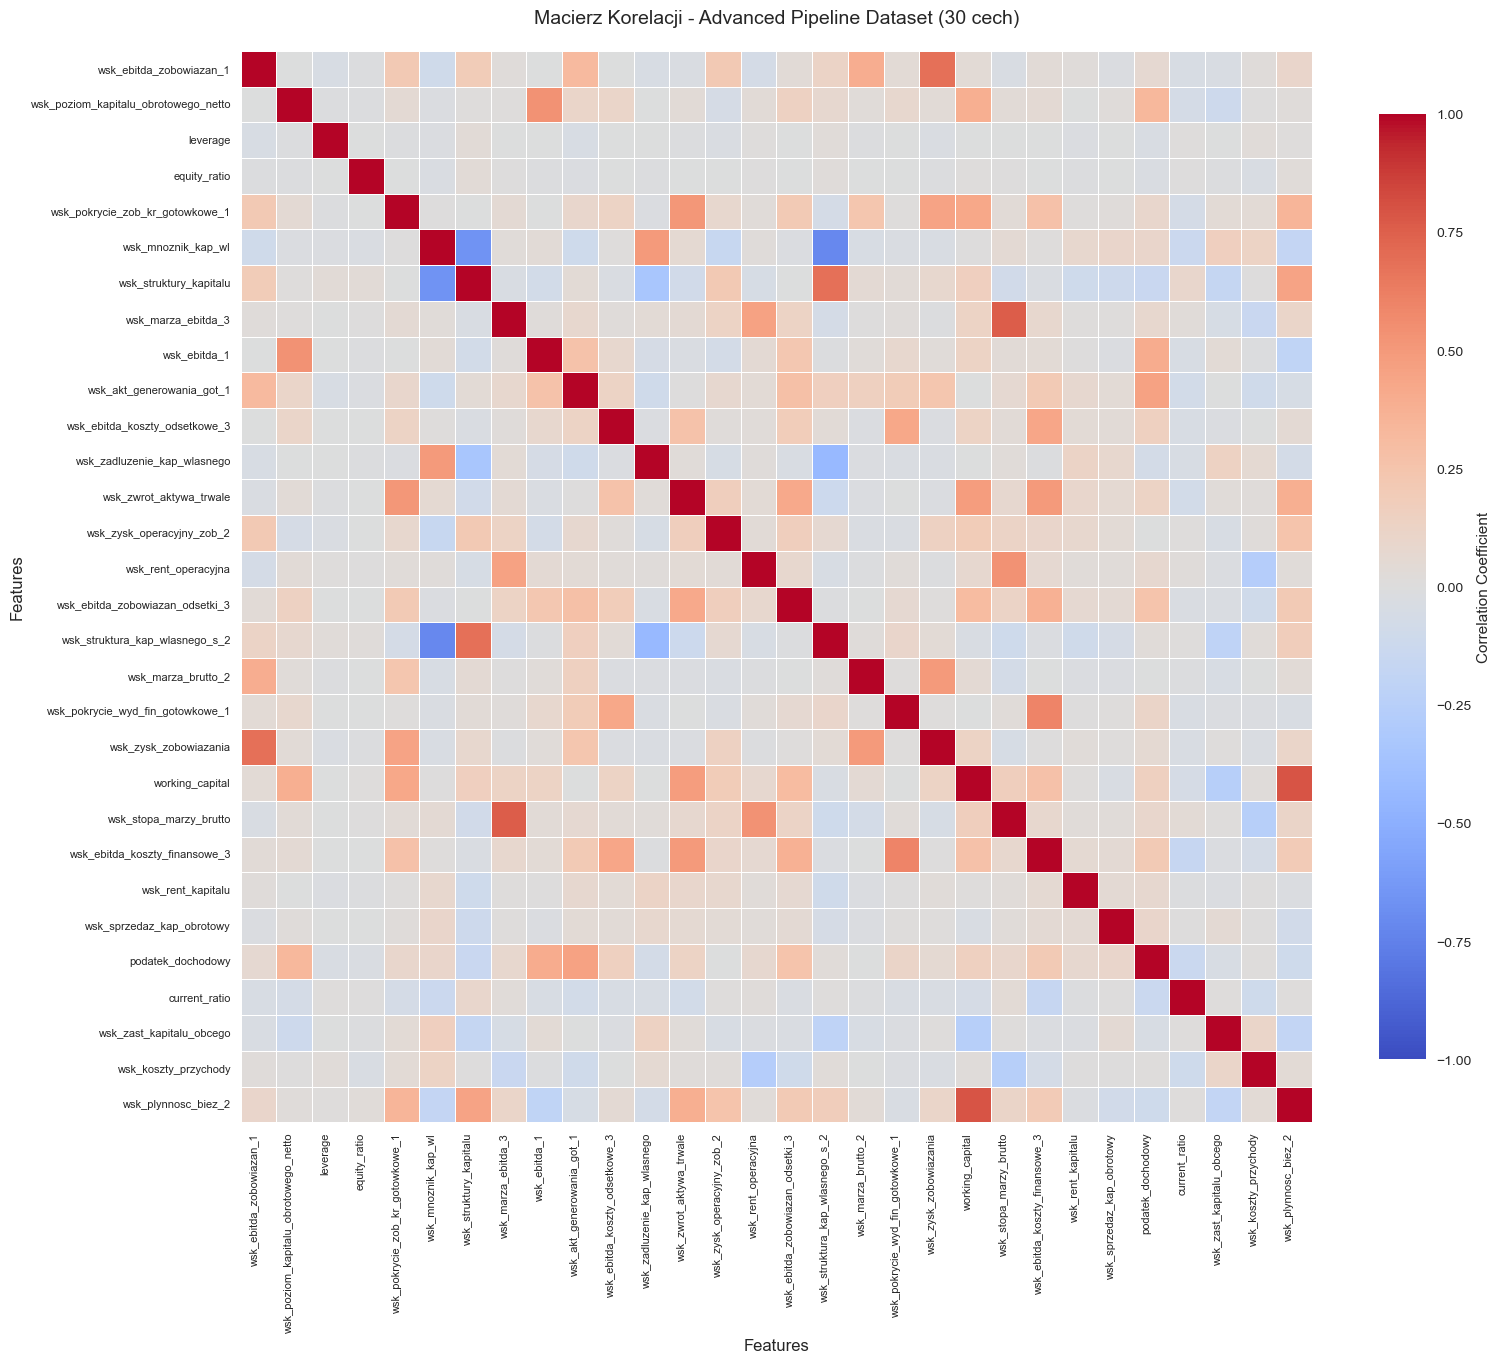

   ✅ Heatmap wygenerowana - ciemne czerwone/niebieskie = wysoka korelacja


2️⃣  KORELACJA Z TARGETEM - Siła zależności z ryzykiem defaultu

📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:
Rank   Feature                                        Correlation Direction      
1      equity_ratio                                       +0.0833 📈 Higher = More Risk
2      wsk_rent_kapitalu                                  -0.0748 📉 Higher = Less Risk
3      wsk_struktury_kapitalu                             +0.0692 📈 Higher = More Risk
4      wsk_struktura_kap_wlasnego_s_2                     +0.0556 📈 Higher = More Risk
5      wsk_zwrot_aktywa_trwale                            -0.0390 📉 Higher = Less Risk
6      wsk_marza_brutto_2                                 -0.0326 📉 Higher = Less Risk
7      wsk_zast_kapitalu_obcego                           -0.0311 📉 Higher = Less Risk
8      wsk_poziom_kapitalu_obrotowego_netto               +0.0280 📈 Higher = More Risk
9      wsk_ebitda_1 

In [ ]:
print("="*80)
print("📊 ANALIZA KORELACJI - Advanced Pipeline Dataset")
print("="*80)

# ============================================================================
# 1. KORELACJA MIĘDZY CECHAMI (Multicollinearity Check)
# ============================================================================
print("\n1️⃣  KORELACJA MIĘDZY CECHAMI - Macierz korelacji")
print("="*80)

# Oblicz macierz korelacji
corr_matrix_adv = X_train_advanced_raw.corr()

print(f"\n📊 Macierz korelacji: {corr_matrix_adv.shape[0]} × {corr_matrix_adv.shape[1]}")
print(f"📋 Zakres wartości: [{corr_matrix_adv.min().min():.3f}, {corr_matrix_adv.max().max():.3f}]")

# Znajdź pary cech o wysokiej korelacji (>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix_adv.columns)):
    for j in range(i+1, len(corr_matrix_adv.columns)):
        corr_val = corr_matrix_adv.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((
                corr_matrix_adv.columns[i],
                corr_matrix_adv.columns[j],
                corr_val
            ))

if len(high_corr_pairs) > 0:
    print(f"\n⚠️  Znaleziono {len(high_corr_pairs)} par cech o wysokiej korelacji (|r| > 0.7):")
    for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:15]:
        direction = "+" if corr_val > 0 else "-"
        print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
else:
    print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")
    print("   VIF cleaning i correlation clustering skutecznie usunęły wielokolinearność!")

# Średnia korelacja (bez diagonali)
corr_values = corr_matrix_adv.values[np.triu_indices_from(corr_matrix_adv.values, k=1)]
print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
print(f"   Średnia |r|:  {np.abs(corr_values).mean():.3f}")
print(f"   Mediana |r|:  {np.median(np.abs(corr_values)):.3f}")
print(f"   Max |r|:      {np.abs(corr_values).max():.3f}")

# Wizualizacja macierzy korelacji
print(f"\n📊 Wizualizacja macierzy korelacji (heatmap):")

# Import seaborn jeśli nie zaimportowany
try:
    import seaborn as sns
except:
    print("   ⚠️  Instaluję seaborn...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn", "-q"])
    import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix_adv, 
            annot=False,  # Nie pokazuj wartości (za dużo cech)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title('Macierz Korelacji - Advanced Pipeline Dataset (30 cech)', fontsize=14, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"   ✅ Heatmap wygenerowana - ciemne czerwone/niebieskie = wysoka korelacja")

# ============================================================================
# 2. KORELACJA Z TARGETEM (Predictive Power)
# ============================================================================
print("\n\n2️⃣  KORELACJA Z TARGETEM - Siła zależności z ryzykiem defaultu")
print("="*80)

# Oblicz korelację Pearsona z targetem
target_corr = []
for col in X_train_advanced_raw.columns:
    try:
        corr_val = X_train_advanced_raw[col].corr(pd.Series(y_train.values))
        target_corr.append({
            'Feature': col,
            'Correlation': corr_val,
            'Abs_Correlation': abs(corr_val)
        })
    except:
        target_corr.append({
            'Feature': col,
            'Correlation': 0.0,
            'Abs_Correlation': 0.0
        })

target_corr_df = pd.DataFrame(target_corr).sort_values('Abs_Correlation', ascending=False)

print(f"\n📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:")
print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
print("="*80)

for idx, row in target_corr_df.head(15).iterrows():
    rank = target_corr_df.index.get_loc(idx) + 1
    direction = "📈 Higher = More Risk" if row['Correlation'] > 0 else "📉 Higher = Less Risk"
    print(f"{rank:<6} {row['Feature']:<45} {row['Correlation']:>+12.4f} {direction:<15}")

print(f"\n📊 Statystyki korelacji z targetem:")
print(f"   Średnia |r|:  {target_corr_df['Abs_Correlation'].mean():.4f}")
print(f"   Mediana |r|:  {target_corr_df['Abs_Correlation'].median():.4f}")
print(f"   Max |r|:      {target_corr_df['Abs_Correlation'].max():.4f}")
print(f"   Min |r|:      {target_corr_df['Abs_Correlation'].min():.4f}")

# Cechy o bardzo niskiej korelacji z targetem (<0.05)
weak_corr = target_corr_df[target_corr_df['Abs_Correlation'] < 0.05]
if len(weak_corr) > 0:
    print(f"\n⚠️  Cechy o bardzo niskiej korelacji z targetem (|r| < 0.05): {len(weak_corr)}")
    print(f"   (Mogą mieć nieliniową zależność - WoE/IV pokaże prawdziwą moc)")

# ============================================================================
# 3. PODSUMOWANIE
# ============================================================================
print("\n\n" + "="*80)
print("📊 PODSUMOWANIE - Analiza Korelacji")
print("="*80)

print(f"\n✅ KORELACJA MIĘDZY CECHAMI:")
print(f"   • Pary o wysokiej korelacji (|r| > 0.7): {len(high_corr_pairs)}")
print(f"   • Średnia |r| między cechami: {np.abs(corr_values).mean():.3f}")
print(f"   • Status: {'✅ Niska wielokolinearność' if len(high_corr_pairs) < 5 else '⚠️ Możliwa wielokolinearność'}")

print(f"\n✅ KORELACJA Z TARGETEM:")
print(f"   • Najsilniejsza korelacja: {target_corr_df.iloc[0]['Feature']} (r = {target_corr_df.iloc[0]['Correlation']:+.4f})")
print(f"   • Średnia |r| z targetem: {target_corr_df['Abs_Correlation'].mean():.4f}")
print(f"   • Cechy o |r| > 0.1: {(target_corr_df['Abs_Correlation'] > 0.1).sum()}/{len(target_corr_df)}")

print(f"\n💡 WNIOSKI:")
if len(high_corr_pairs) == 0:
    print(f"   ✅ Dataset jest gotowy - brak wielokolinearności")
else:
    print(f"   ⚠️ {len(high_corr_pairs)} par o wysokiej korelacji - rozważ dodatkowe VIF cleaning")

if target_corr_df['Abs_Correlation'].mean() > 0.1:
    print(f"   ✅ Cechy mają silną zależność z targetem - dobry potencjał predykcyjny")
else:
    print(f"   ⚠️ Słaba liniowa korelacja - sprawdź zależności nieliniowe (WoE/IV)")

print("\n" + "="*80 + "\n")

## 18. Hyperparameter Tuning - Grid Search

Optymalizacja parametrów dla obu scorecardów (Basic i Advanced) poprzez Grid Search.

### 18.1 Przygotowanie Danych Walidacyjnych

In [ ]:
print("="*80)
print("PRZYGOTOWANIE DANYCH WALIDACYJNYCH DLA GRID SEARCH")
print("="*80)

# Sprawdź czy dane walidacyjne zostały utworzone w sekcjach 10.1-10.4
if 'X_val_full' not in globals():
    print("\n🔧 Tworzę X_val_full (pipeline_full)...")
    X_val_full = pipeline_full.transform(X_val)
else:
    print(f"\n✅ X_val_full już istnieje: {X_val_full.shape}")

if 'X_val_minimal' not in globals():
    print("🔧 Tworzę X_val_minimal (pipeline_minimal)...")
    X_val_minimal = pipeline_minimal.transform(X_val)
else:
    print(f"✅ X_val_minimal już istnieje: {X_val_minimal.shape}")

if 'X_val_advanced_raw' not in globals():
    print("⚠️  UWAGA: X_val_advanced_raw nie istnieje!")
    print("   Musisz uruchomić sekcje 10.1-10.4 (Feature Engineering) aby utworzyć X_val_advanced_raw")
    print("   Używam X_val_full jako fallback...")
    X_val_advanced_raw = X_val_full.copy()
else:
    print(f"✅ X_val_advanced_raw już istnieje: {X_val_advanced_raw.shape}")

print(f"\n📊 Podsumowanie danych walidacyjnych:")
print(f"   X_val_full:         {X_val_full.shape}")
print(f"   X_val_minimal:      {X_val_minimal.shape}")
print(f"   X_val_advanced_raw: {X_val_advanced_raw.shape}")
print(f"   y_val:              {y_val.shape}")
print("="*80)

PRZYGOTOWANIE DANYCH WALIDACYJNYCH DLA GRID SEARCH

✅ X_val_full już istnieje: (600, 165)
🔧 Tworzę X_val_minimal (pipeline_minimal)...
✅ X_val_advanced_raw już istnieje: (600, 30)

📊 Podsumowanie danych walidacyjnych:
   X_val_full:         (600, 165)
   X_val_minimal:      (600, 136)
   X_val_advanced_raw: (600, 30)
   y_val:              (600,)


In [ ]:
print("="*80)
print("📊 SPLIT 60/10/30 DLA SCORECARDÓW")
print("="*80)

from sklearn.model_selection import train_test_split

# ==============================================================================
# SPLIT 60/10/30 - TYLKO DLA SCORECARDÓW (Basic + Advanced)
# ==============================================================================
# Oryginalny split 60/20/20 pozostaje dla innych modeli (blackbox etc.)
# Ten nowy split 60/10/30 jest TYLKO dla scorecardów

# Najpierw 60% train, 40% reszta
X_train_sc, X_temp_sc, y_train_sc, y_temp_sc = train_test_split(
    X, y, 
    test_size=0.4, 
    random_state=1, 
    stratify=y
)

# Z 40%: 25% (=10% całości) val, 75% (=30% całości) test
X_val_sc, X_test_sc, y_val_sc, y_test_sc = train_test_split(
    X_temp_sc, y_temp_sc, 
    test_size=0.75,
    random_state=1, 
    stratify=y_temp_sc
)

print(f"\n📊 Nowy split dla Scorecardów (60/10/30):")
print(f"   TRAIN:    {len(X_train_sc):,} obs ({len(X_train_sc)/len(X)*100:.1f}%)")
print(f"   VAL:      {len(X_val_sc):,} obs ({len(X_val_sc)/len(X)*100:.1f}%)")
print(f"   TEST:     {len(X_test_sc):,} obs ({len(X_test_sc)/len(X)*100:.1f}%)")
print(f"   Porównanie - oryginalny TEST: {len(X_test):,} obs")

# ==============================================================================
# TRANSFORMACJE PIPELINE DLA BASIC SCORECARD
# ==============================================================================
print("\n🔧 Transformacja dla BASIC Scorecard (pipeline_full)...")

X_train_full_sc = pipeline_full.transform(X_train_sc)
X_val_full_sc = pipeline_full.transform(X_val_sc)
X_test_full_sc = pipeline_full.transform(X_test_sc)

print(f"   ✅ X_train_full_sc: {X_train_full_sc.shape}")
print(f"   ✅ X_val_full_sc:   {X_val_full_sc.shape}")
print(f"   ✅ X_test_full_sc:  {X_test_full_sc.shape}")

# ==============================================================================
# TRANSFORMACJE DLA ADVANCED SCORECARD
# ==============================================================================
print("\n🔧 Transformacja dla ADVANCED Scorecard...")

# Dla Advanced - użyj tej samej transformacji co pipeline_full
# (advanced używa X_train_advanced_raw który jest oparty na tych samych danych)
X_train_advanced_sc = pipeline_full.transform(X_train_sc)
X_val_advanced_sc = pipeline_full.transform(X_val_sc)
X_test_advanced_sc = pipeline_full.transform(X_test_sc)

print(f"   ✅ X_train_advanced_sc: {X_train_advanced_sc.shape}")
print(f"   ✅ X_val_advanced_sc:   {X_val_advanced_sc.shape}")
print(f"   ✅ X_test_advanced_sc:  {X_test_advanced_sc.shape}")

# Połącz train+val do finalnego zestawu (70% całości)
X_train_val_full_sc = pd.concat([X_train_full_sc, X_val_full_sc], axis=0).reset_index(drop=True)
X_train_val_adv_sc = pd.concat([X_train_advanced_sc, X_val_advanced_sc], axis=0).reset_index(drop=True)
y_train_val_sc = pd.concat([y_train_sc, y_val_sc], axis=0).reset_index(drop=True)

print(f"\n📊 TRAIN+VAL dla scorecardów:")
print(f"   Basic:    {X_train_val_full_sc.shape}")
print(f"   Advanced: {X_train_val_adv_sc.shape}")
print(f"   y:        {len(y_train_val_sc)}")

print("\n✅ Gotowe! Teraz możesz uruchomić Grid Search.")
print("="*80)

📊 SPLIT 60/10/30 DLA SCORECARDÓW

📊 Nowy split dla Scorecardów (60/10/30):
   TRAIN:    1,800 obs (60.0%)
   VAL:      300 obs (10.0%)
   TEST:     900 obs (30.0%)
   Porównanie - oryginalny TEST: 600 obs

🔧 Transformacja dla BASIC Scorecard (pipeline_full)...
   ✅ X_train_full_sc: (1800, 165)
   ✅ X_val_full_sc:   (300, 165)
   ✅ X_test_full_sc:  (900, 165)

🔧 Transformacja dla ADVANCED Scorecard...
   ✅ X_train_advanced_sc: (1800, 165)
   ✅ X_val_advanced_sc:   (300, 165)
   ✅ X_test_advanced_sc:  (900, 165)

📊 TRAIN+VAL dla scorecardów:
   Basic:    (2100, 165)
   Advanced: (2100, 165)
   y:        2100

✅ Gotowe! Teraz możesz uruchomić Grid Search.


### 18.2 Grid search dla cech oraz binów

In [ ]:
# ADVANCED SCORECARD - GRID SEARCH (DETERMINISTYCZNY)
# random.seed(42) + MAX 1000 kombinacji/N
print("="*80)
print("HYPERPARAMETER TUNING - ADVANCED SCORECARD (N=5-12, DETERMINISTYCZNY)")
print("="*80)

import time
import random
import numpy as np
from itertools import product

# ============================================
# DETERMINISTYCZNOŚĆ - USTAW SEED
# ============================================
random.seed(42)
np.random.seed(42)

# ============================================
# FUNKCJE POMOCNICZE
# ============================================
def monotonicity_score_adv(woe_table):
    woe_values = woe_table['woe'].values
    if len(woe_values) < 2:
        return 100.0
    diffs = np.diff(woe_values)
    n_pos = np.sum(diffs > 0)
    n_neg = np.sum(diffs < 0)
    n_zero = np.sum(diffs == 0)
    total = len(diffs)
    if total == 0:
        return 100.0
    return (max(n_pos, n_neg) + n_zero) / total * 100

def calculate_feature_bins_info_adv(X_data, y_data, feature, bin_options, min_mono=75.0):
    results = []
    for n_bins in bin_options:
        try:
            df_temp = pd.DataFrame({feature: X_data[feature], 'target': y_data.values})
            woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=n_bins)
            mono = monotonicity_score_adv(woe_table)
            if mono >= min_mono:
                results.append({'bins': n_bins, 'iv': iv_value, 'mono': mono})
        except:
            continue
    return results

def get_woe_data_train_adv(config, X_data, y_data):
    X_woe = pd.DataFrame()
    woe_mappings = {}
    for feat, info in config:
        n_bins = info['bins']
        try:
            df_temp = pd.DataFrame({feat: X_data[feat], 'target': y_data.values})
            woe_table, _ = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
            _, bin_edges = pd.qcut(X_data[feat], q=n_bins, retbins=True, duplicates='drop')
            woe_mappings[feat] = {'bin_edges': bin_edges, 'woe_table': woe_table.copy(), 'n_bins': len(bin_edges)-1}
            woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
            X_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        except:
            continue
    return X_woe, woe_mappings

def get_woe_data_predict_adv(config, X_data, woe_mappings):
    X_woe = pd.DataFrame()
    for feat, info in config:
        if feat not in woe_mappings:
            continue
        mapping = woe_mappings[feat]
        try:
            binned = pd.cut(X_data[feat], bins=mapping['bin_edges'], labels=False, include_lowest=True)
            woe_dict = {idx: mapping['woe_table'].iloc[idx]['woe'] for idx in range(len(mapping['woe_table']))}
            X_woe[f"{feat}_woe"] = binned.map(woe_dict).fillna(0)
        except:
            X_woe[f"{feat}_woe"] = 0
    return X_woe

def check_sign_stability_adv(config, X_trainval, y_trainval, X_test, y_test, C, solver):
    if len(config) == 0:
        return [], False
    X_tv_woe, woe_mappings = get_woe_data_train_adv(config, X_trainval, y_trainval)
    X_t_woe = get_woe_data_predict_adv(config, X_test, woe_mappings)
    if X_tv_woe.shape[1] == 0 or X_t_woe.shape[1] == 0:
        return [f for f, _ in config], False
    common_cols = sorted(set(X_tv_woe.columns) & set(X_t_woe.columns))
    if not common_cols:
        return [f for f, _ in config], False
    X_tv_woe = X_tv_woe[common_cols].fillna(0)
    X_t_woe = X_t_woe[common_cols].fillna(0)
    try:
        model_tv = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
        model_tv.fit(X_tv_woe, y_trainval)
        model_t = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
        model_t.fit(X_t_woe, y_test)
    except:
        return [f for f, _ in config], False
    unstable = []
    for i, col in enumerate(common_cols):
        feat = col.replace('_woe', '')
        if np.sign(model_tv.coef_[0][i]) != np.sign(model_t.coef_[0][i]):
            if model_tv.coef_[0][i] != 0 and model_t.coef_[0][i] != 0:
                unstable.append(feat)
    return unstable, len(unstable) == 0

# ============================================
# PARAMETRY
# ============================================
BIN_OPTIONS_ADV = [3, 4, 5, 6, 7, 8, 10]
MIN_MONO_ADV = 75.0
MIN_AVG_MONO_ADV = 80.0
TOP_FEATURES_ADV = 30
N_FEATURES_OPTIONS_ADV = [5, 6, 7, 8, 9, 10, 11, 12]
C_OPTIONS_ADV = [0.01]
MAX_BIN_COMBOS_PER_N = 1000  # Deterministyczne losowanie z seedem

print(f"\n⚡ PARAMETRY:")
print(f"   • N cech: {N_FEATURES_OPTIONS_ADV}")
print(f"   • C: {C_OPTIONS_ADV}")
print(f"   • Min mono/cechę: {MIN_MONO_ADV}%")
print(f"   • Min avg mono: {MIN_AVG_MONO_ADV}%")
print(f"   • Max kombinacji/N: {MAX_BIN_COMBOS_PER_N}")
print(f"   • SEED: 42 (wyniki będą powtarzalne)")
print(f"\n📊 Dane: TRAIN+VAL={len(X_train_val_full_sc)}, TEST={len(X_test_full_sc)}")

# ============================================
# KROK 1: ANALIZA CECH
# ============================================
print("\n" + "="*80)
print("KROK 1: ANALIZA TOP CECH")
print("-"*80)

start_time = time.time()
numeric_features = X_train_val_full_sc.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n🔧 Analiza IV dla {len(numeric_features)} cech...")
all_features_iv = {}
for i, feat in enumerate(numeric_features):
    if (i+1) % 50 == 0:
        print(f"      {i+1}/{len(numeric_features)}...")
    try:
        df_temp = pd.DataFrame({feat: X_train_val_full_sc[feat], 'target': y_train_val_sc.values})
        _, iv = calculate_woe_iv(df_temp, feat, 'target', bins=10)
        all_features_iv[feat] = iv
    except:
        pass

top_features_list = sorted(all_features_iv.keys(), key=lambda f: all_features_iv[f], reverse=True)[:TOP_FEATURES_ADV]

print(f"\n🔧 Analiza binowania dla TOP {TOP_FEATURES_ADV} cech...")
feature_bin_options = {}
for feat in top_features_list:
    bins_info = calculate_feature_bins_info_adv(X_train_val_full_sc, y_train_val_sc, feat, BIN_OPTIONS_ADV, MIN_MONO_ADV)
    if bins_info:
        feature_bin_options[feat] = bins_info

features_sorted = sorted(feature_bin_options.keys(), key=lambda f: max(o['iv'] for o in feature_bin_options[f]), reverse=True)
print(f"   ✅ {len(features_sorted)} cech z mono >= {MIN_MONO_ADV}%")

print(f"\n📊 TOP 15 cech:")
for i, feat in enumerate(features_sorted[:15], 1):
    opts = feature_bin_options[feat]
    best_iv = max(o['iv'] for o in opts)
    print(f"   {i:2}. {feat[:40]:<40} IV={best_iv:.4f}, opcji binów: {len(opts)}")

# ============================================
# KROK 2: GRID SEARCH (DETERMINISTYCZNY)
# ============================================
print("\n" + "="*80)
print("KROK 2: GRID SEARCH (SEED=42, MAX 1000 KOMBINACJI/N)")
print("-"*80)

best_score_adv = 0
best_config_adv = None
best_params_adv = None
best_woe_mappings_adv = None
total_tested = 0
total_stable = 0
results_per_n = {}

for n_features in N_FEATURES_OPTIONS_ADV:
    if n_features > len(features_sorted):
        print(f"\n⚠️  N={n_features}: za mało cech ({len(features_sorted)} dostępnych)")
        continue
    
    # Wybierz TOP N cech
    selected_features = features_sorted[:n_features]
    
    # Generuj kombinacje binów
    bin_opts_per_feat = [feature_bin_options[f] for f in selected_features]
    total_combos = 1
    for opts in bin_opts_per_feat:
        total_combos *= len(opts)
    
    # Jeśli za dużo kombinacji - losuj próbkę (deterministycznie dzięki seed)
    if total_combos <= MAX_BIN_COMBOS_PER_N:
        bin_combos = list(product(*bin_opts_per_feat))
        print(f"\n🔍 N={n_features}: WSZYSTKIE {len(bin_combos)} kombinacji")
    else:
        seen = {}
        attempts = 0
        while len(seen) < MAX_BIN_COMBOS_PER_N and attempts < MAX_BIN_COMBOS_PER_N * 3:
            combo = tuple(random.choice(opts) for opts in bin_opts_per_feat)
            key = tuple(c['bins'] for c in combo)
            if key not in seen:
                seen[key] = combo
            attempts += 1
        bin_combos = list(seen.values())
        print(f"\n🔍 N={n_features}: losowanie {len(bin_combos)}/{total_combos} kombinacji (seed=42)")
    
    n_stable = 0
    best_auc_n = 0
    
    for bin_combo in bin_combos:
        config = [(selected_features[i], bin_combo[i]) for i in range(n_features)]
        
        # Sprawdź średnią mono
        avg_mono = np.mean([info['mono'] for _, info in config])
        if avg_mono < MIN_AVG_MONO_ADV:
            continue
        
        total_tested += 1
        
        for C in C_OPTIONS_ADV:
            unstable, is_stable = check_sign_stability_adv(
                config, X_train_val_full_sc, y_train_val_sc,
                X_test_full_sc, y_test_sc, C, 'lbfgs'
            )
            
            if is_stable:
                total_stable += 1
                n_stable += 1
                
                X_woe, woe_map = get_woe_data_train_adv(config, X_train_val_full_sc, y_train_val_sc)
                if X_woe.shape[1] > 0:
                    try:
                        model = LogisticRegression(C=C, solver='lbfgs', max_iter=1000,
                                                   random_state=42, class_weight='balanced')
                        model.fit(X_woe.fillna(0), y_train_val_sc)
                        y_proba = model.predict_proba(X_woe.fillna(0))[:, 1]
                        auc = roc_auc_score(y_train_val_sc, y_proba)
                        
                        if auc > best_auc_n:
                            best_auc_n = auc
                        
                        if auc > best_score_adv:
                            best_score_adv = auc
                            best_config_adv = config
                            best_params_adv = {'n_features': n_features, 'C': C, 'solver': 'lbfgs'}
                            best_woe_mappings_adv = woe_map
                            print(f"      ✨ NEW BEST: AUC={auc:.4f}, N={n_features}")
                    except:
                        pass
    
    results_per_n[n_features] = {'stable': n_stable, 'best_auc': best_auc_n}
    print(f"      Stabilnych: {n_stable}, best AUC: {best_auc_n:.4f}")

# ============================================
# PODSUMOWANIE
# ============================================
elapsed = time.time() - start_time
print("\n" + "="*80)
print("PODSUMOWANIE")
print("="*80)
print(f"⏱️  Czas: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"📊 Testowano: {total_tested}, Stabilnych: {total_stable}")
print(f"🎲 SEED=42 - wyniki są powtarzalne!")

print(f"\n📊 WYNIKI PER N:")
for n, res in sorted(results_per_n.items()):
    marker = "🏆" if res['best_auc'] == best_score_adv else "  "
    print(f"   {marker} N={n:2}: stabilnych={res['stable']:3}, best AUC={res['best_auc']:.4f}")

if best_config_adv:
    print(f"\n🏆 NAJLEPSZA KONFIGURACJA:")
    print(f"   AUC (TRAIN+VAL): {best_score_adv:.4f}")
    print(f"   N={best_params_adv['n_features']}, C={best_params_adv['C']}")
    
    best_features_adv = [(f, info) for f, info in best_config_adv]
    avg_mono = np.mean([info['mono'] for _, info in best_features_adv])
    print(f"   Średnia mono: {avg_mono:.1f}%")
    
    print(f"\n📋 Cechy ({len(best_features_adv)}):")
    for i, (feat, info) in enumerate(best_features_adv, 1):
        print(f"   {i:2}. {feat[:40]:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")
    
    # Zapisz
    import json
    config_dir = "grid_search_results"
    os.makedirs(config_dir, exist_ok=True)
    
    config_data = {
        'best_score': best_score_adv,
        'best_params': best_params_adv,
        'best_features': [{'feature': f, 'bins': info['bins'], 'iv': info['iv'], 'mono': info['mono']} for f, info in best_features_adv],
        'total_tested': total_tested,
        'total_stable': total_stable,
        'results_per_n': {str(k): v for k, v in results_per_n.items()},
        'split': '60/10/30',
        'seed': 42
    }
    
    with open(f"{config_dir}/best_config_advanced_latest.json", 'w', encoding='utf-8') as f:
        json.dump(config_data, f, indent=2, ensure_ascii=False)
    print(f"\n💾 Zapisano: {config_dir}/best_config_advanced_latest.json")
else:
    print("\n❌ Nie znaleziono stabilnej konfiguracji!")

print("="*80)

HYPERPARAMETER TUNING - BASIC SCORECARD (PEŁNY GRID)

⚡ KRYTERIA BASIC (PODWYŻSZONE PROGI):
   • N cech: [8]
   • C: [0.01]
   • Min mono per feature: 75.0% (↑ z 70%)
   • Min avg mono: 80.0% (↑ z 75%)
   • Max kombinacji binów/N: 100

KROK 1: ANALIZA TOP CECH
--------------------------------------------------------------------------------

🔧 Analiza IV dla 165 cech...
      50/165...
      100/165...
      150/165...

🔧 Analiza binowania dla TOP 30 cech...
   ✅ 26 cech z mono >= 75.0%

📊 TOP 10 cech:
    1. Kapital_wlasny                           IV=0.4860, opcji: 6
    2. wsk_ebitda_zobowiazan_1                  IV=0.4796, opcji: 3
    3. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4551, opcji: 6
    4. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.4268, opcji: 2
    5. wsk_ogolnego_zadluzenia_1                IV=0.4016, opcji: 1
    6. wsk_zadluzenie_kap_wlasnego              IV=0.4016, opcji: 1
    7. wsk_zysk_zobowiazania                    IV=0.4012, opcji: 4
    8. wsk_ebitda

## 19. Basic Scorecard (Optimized)

Scorecard dla Basic Pipeline (bez feature engineering) z optymalnymi parametrami.

In [ ]:
print("="*80)
print("BASIC SCORECARD (SPLIT 60/10/30)")
print("="*80)

from sklearn.metrics import auc as sklearn_auc, precision_recall_curve, log_loss, brier_score_loss

# ============================================
# WCZYTAJ KONFIGURACJĘ Z GRID SEARCH
# ============================================

# Sprawdź czy mamy zmienne z Grid Search w pamięci
if 'best_config' in globals() and best_config is not None:
    print("✅ Używam konfiguracji z pamięci (Grid Search Basic)")
    best_features_basic = best_config
    best_params_basic = best_params
    best_params_basic['solver'] = 'liblinear'  # dodaj solver jeśli brakuje
    
    # Użyj woe_mappings z Grid Search jeśli są
    if 'best_woe_mappings' in globals() and best_woe_mappings:
        woe_mappings_from_grid = best_woe_mappings
    else:
        woe_mappings_from_grid = None
        
elif os.path.exists("grid_search_results/best_config_latest.json"):
    print("📁 Wczytywanie z pliku JSON...")
    import json
    with open("grid_search_results/best_config_latest.json", 'r', encoding='utf-8') as f:
        config_data = json.load(f)
    
    best_params_basic = config_data['best_params']
    best_params_basic['solver'] = best_params_basic.get('solver', 'liblinear')
    best_features_basic = [
        (item['feature'], {'bins': item['bins'], 'iv': item['iv'], 'mono': item['mono']})
        for item in config_data['best_features']
    ]
    woe_mappings_from_grid = None
else:
    raise ValueError("❌ Brak konfiguracji! Uruchom najpierw Grid Search Basic.")

print(f"\n🎯 PARAMETRY:")
print(f"   Cechy:  {len(best_features_basic)}")
print(f"   C:      {best_params_basic['C']}")
print(f"   Solver: {best_params_basic.get('solver', 'liblinear')}")

print(f"\n📋 WYBRANE CECHY ({len(best_features_basic)}):")
for i, (feat, info) in enumerate(best_features_basic, 1):
    print(f"   {i:2}. {feat[:40]:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")

# ============================================
# WoE TRANSFORMATION
# ============================================
print(f"\n🔄 WoE Transformation...")

# TRAIN+VAL WoE
X_train_val_woe_basic = pd.DataFrame()
woe_mappings_basic = {}

for feat, info in best_features_basic:
    try:
        n_bins = info['bins']
        df_temp = pd.DataFrame({feat: X_train_val_full_sc[feat], 'target': y_train_val_sc.values})
        woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
        X_train_val_woe_basic[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        
        woe_table, iv_val = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
        
        # Zapisz bin_edges do mappingu
        _, bin_edges = pd.qcut(X_train_val_full_sc[feat], q=n_bins, retbins=True, duplicates='drop')
        woe_mappings_basic[feat] = {
            'table': woe_table, 
            'bins': n_bins, 
            'iv': iv_val,
            'bin_edges': bin_edges
        }
    except Exception as e:
        print(f"   ⚠️  Pominięto {feat}: {e}")
        continue

print(f"   ✅ TRAIN+VAL: {X_train_val_woe_basic.shape[1]} cech")

# TEST WoE - używając bin_edges z TRAIN+VAL (BEZ DATA LEAKAGE)
X_test_woe_basic = pd.DataFrame()
for feat, info in best_features_basic:
    if feat not in woe_mappings_basic:
        continue
    try:
        mapping = woe_mappings_basic[feat]
        # Użyj bin_edges z treningu
        binned = pd.cut(X_test_full_sc[feat], bins=mapping['bin_edges'], labels=False, include_lowest=True)
        woe_dict = {idx: mapping['table'].iloc[idx]['woe'] for idx in range(len(mapping['table']))}
        X_test_woe_basic[f"{feat}_woe"] = binned.map(woe_dict).fillna(0)
    except:
        X_test_woe_basic[f"{feat}_woe"] = 0

print(f"   ✅ TEST: {X_test_woe_basic.shape[1]} cech")

# ============================================
# MODEL
# ============================================
print(f"\n🎯 Trening modelu...")

scorecard_basic = LogisticRegression(
    C=best_params_basic['C'],
    solver=best_params_basic.get('solver', 'liblinear'),
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)
scorecard_basic.fit(X_train_val_woe_basic, y_train_val_sc)

# Predykcje
y_train_val_proba_basic = scorecard_basic.predict_proba(X_train_val_woe_basic)[:, 1]
y_test_proba_basic = scorecard_basic.predict_proba(X_test_woe_basic)[:, 1]

# ============================================
# METRYKI
# ============================================
def calculate_ks(y_true, y_pred_proba):
    df_ks = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
    df_ks = df_ks.sort_values('pred', ascending=False).reset_index(drop=True)
    df_ks['cumulative_bad'] = df_ks['true'].cumsum() / df_ks['true'].sum()
    df_ks['cumulative_good'] = (1 - df_ks['true']).cumsum() / (1 - df_ks['true']).sum()
    return (df_ks['cumulative_bad'] - df_ks['cumulative_good']).abs().max()

auc_train_val = roc_auc_score(y_train_val_sc, y_train_val_proba_basic)
auc_test = roc_auc_score(y_test_sc, y_test_proba_basic)
precision, recall, _ = precision_recall_curve(y_test_sc, y_test_proba_basic)

metrics_sc_basic = {
    'roc_auc': auc_test,
    'pr_auc': sklearn_auc(recall, precision),
    'ks': calculate_ks(y_test_sc, y_test_proba_basic),
    'log_loss': log_loss(y_test_sc, y_test_proba_basic),
    'brier': brier_score_loss(y_test_sc, y_test_proba_basic)
}

# ============================================
# WYNIKI
# ============================================
print(f"\n✅ MODEL WYTRENOWANY!")
print(f"\n📈 WYNIKI (split 60/10/30):")
print(f"   TRAIN+VAL: {len(X_train_val_woe_basic)} obs (70%)")
print(f"   TEST:      {len(X_test_woe_basic)} obs (30%)")
print(f"\n   ROC-AUC TRAIN+VAL: {auc_train_val:.4f}")
print(f"   ROC-AUC TEST:      {auc_test:.4f}")
print(f"   Δ AUC:             {auc_train_val - auc_test:+.4f}")

print(f"\n📊 METRYKI NA ZBIORZE TESTOWYM (30%):")
print(f"   ROC-AUC:   {metrics_sc_basic['roc_auc']:.4f}")
print(f"   PR-AUC:    {metrics_sc_basic['pr_auc']:.4f}")
print(f"   KS:        {metrics_sc_basic['ks']:.4f}")
print(f"   Log Loss:  {metrics_sc_basic['log_loss']:.4f}")
print(f"   Brier:     {metrics_sc_basic['brier']:.4f}")

print(f"\n💾 Zmienne zapisane:")
print(f"   • scorecard_basic - model")
print(f"   • best_features_basic - lista cech ({len(best_features_basic)})")
print(f"   • X_train_val_woe_basic, X_test_woe_basic")
print(f"   • woe_mappings_basic")
print(f"   • metrics_sc_basic")
print("="*80)

BASIC SCORECARD (SPLIT 60/10/30)
✅ Używam konfiguracji z pamięci (Grid Search Basic)

🎯 PARAMETRY:
   Cechy:  8
   C:      0.01
   Solver: liblinear

📋 WYBRANE CECHY (8):
    1. Kapital_wlasny                           IV=0.4848, Mono=100.0%, Bins=8
    2. wsk_ebitda_zobowiazan_1                  IV=0.4796, Mono=75.0%, Bins=6
    3. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4390, Mono=100.0%, Bins=8
    4. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.4268, Mono=77.8%, Bins=12
    5. wsk_ogolnego_zadluzenia_1                IV=0.4016, Mono=75.0%, Bins=10
    6. wsk_zadluzenie_kap_wlasnego              IV=0.4016, Mono=75.0%, Bins=10
    7. wsk_zysk_zobowiazania                    IV=0.4012, Mono=75.0%, Bins=12
    8. wsk_ebitda_1                             IV=0.3748, Mono=75.0%, Bins=10

🔄 WoE Transformation...
   ✅ TRAIN+VAL: 8 cech
   ✅ TEST: 8 cech

🎯 Trening modelu...

✅ MODEL WYTRENOWANY!

📈 WYNIKI (split 60/10/30):
   TRAIN+VAL: 2100 obs (70%)
   TEST:      900 obs (30%)

   

### 19.1 EDA - Analiza Jakości WoE (Basic)

Analiza transformacji WoE: IV ranking, monotonicity, korelacje, rozkłady

📊 EDA - ANALIZA JAKOŚCI WoE (BASIC SCORECARD)


1️⃣  IV RANKING - TOP 10 CECH

📊 Rozkład mocy predykcyjnej (8 cech):

   Strong          ( 8): ████

📈 TOP 10 CECH:

   Rank   Feature                                       IV         Bins   Power
   --------------------------------------------------------------------------------
   1      Kapital_wlasny                                0.4848     8      Strong
   2      wsk_ebitda_zobowiazan_1                       0.4796     6      Strong
   3      wsk_poziom_kapitalu_obrotowego_netto          0.4390     8      Strong
   4      wsk_pokrycie_zob_kr_gotowkowe_1               0.4268     12     Strong
   5      wsk_ogolnego_zadluzenia_1                     0.4016     10     Strong
   6      wsk_zadluzenie_kap_wlasnego                   0.4016     10     Strong
   7      wsk_zysk_zobowiazania                         0.4012     12     Strong
   8      wsk_ebitda_1                                  0.3748     10     Strong


2️⃣  WoE TABLES - TOP

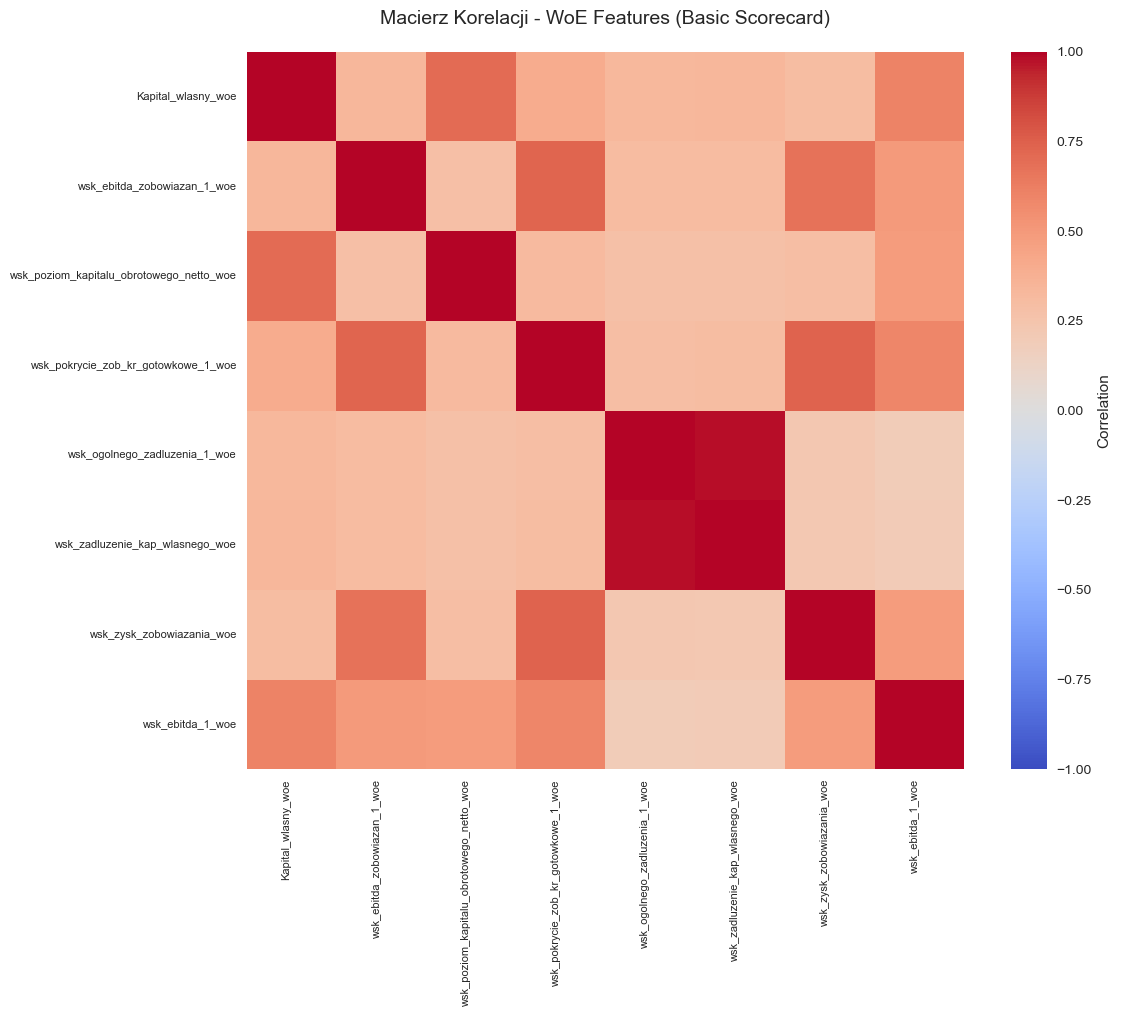



4️⃣  ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)

📊 Porównanie rozkładów dla 8 cech:
   Niebieski = RAW (po Full Pipeline preprocessing)
   Zielony = WoE (Weight of Evidence)


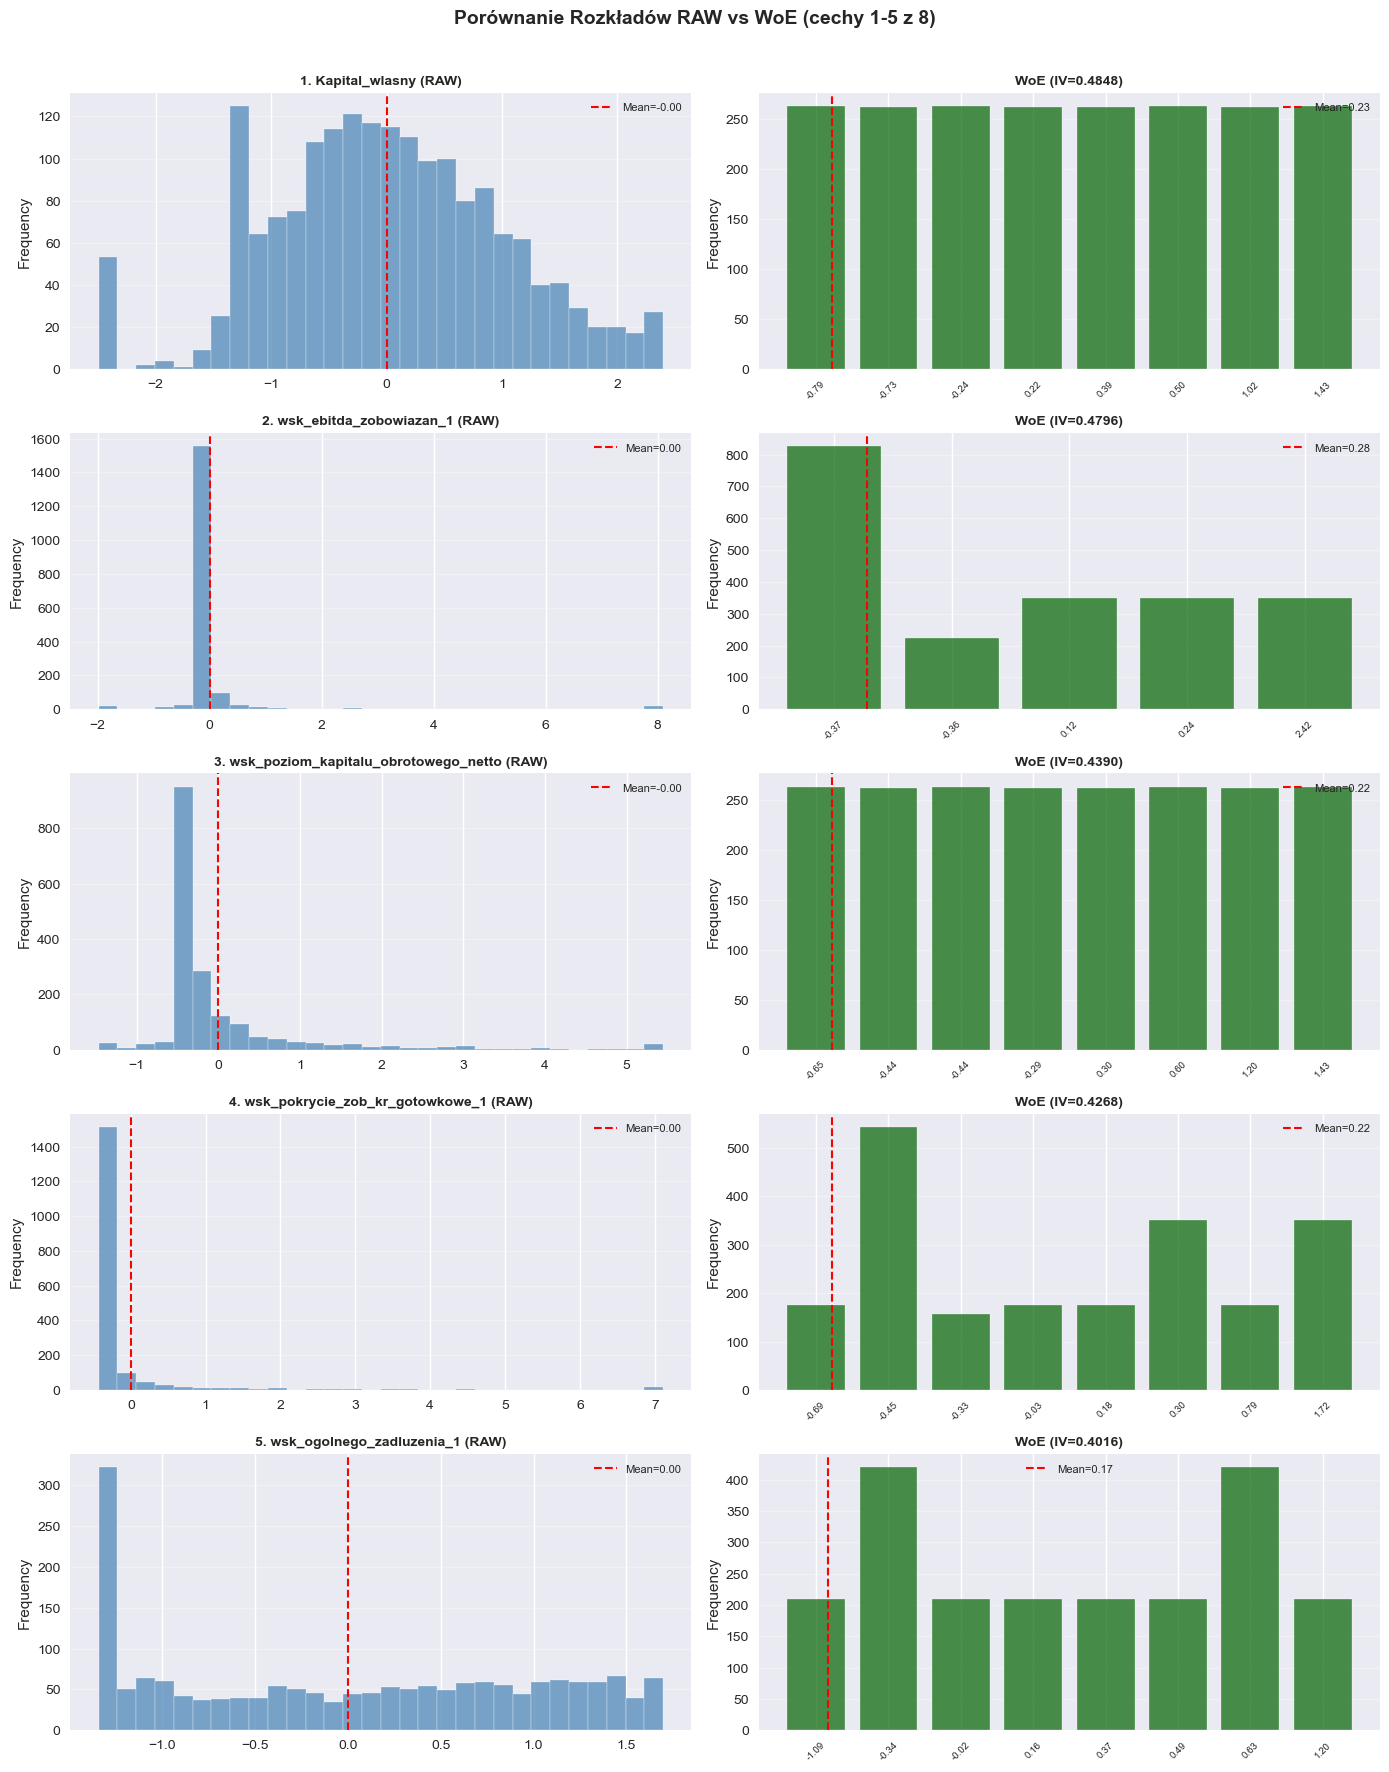

   ✅ Figura 1/2: cechy 1-5


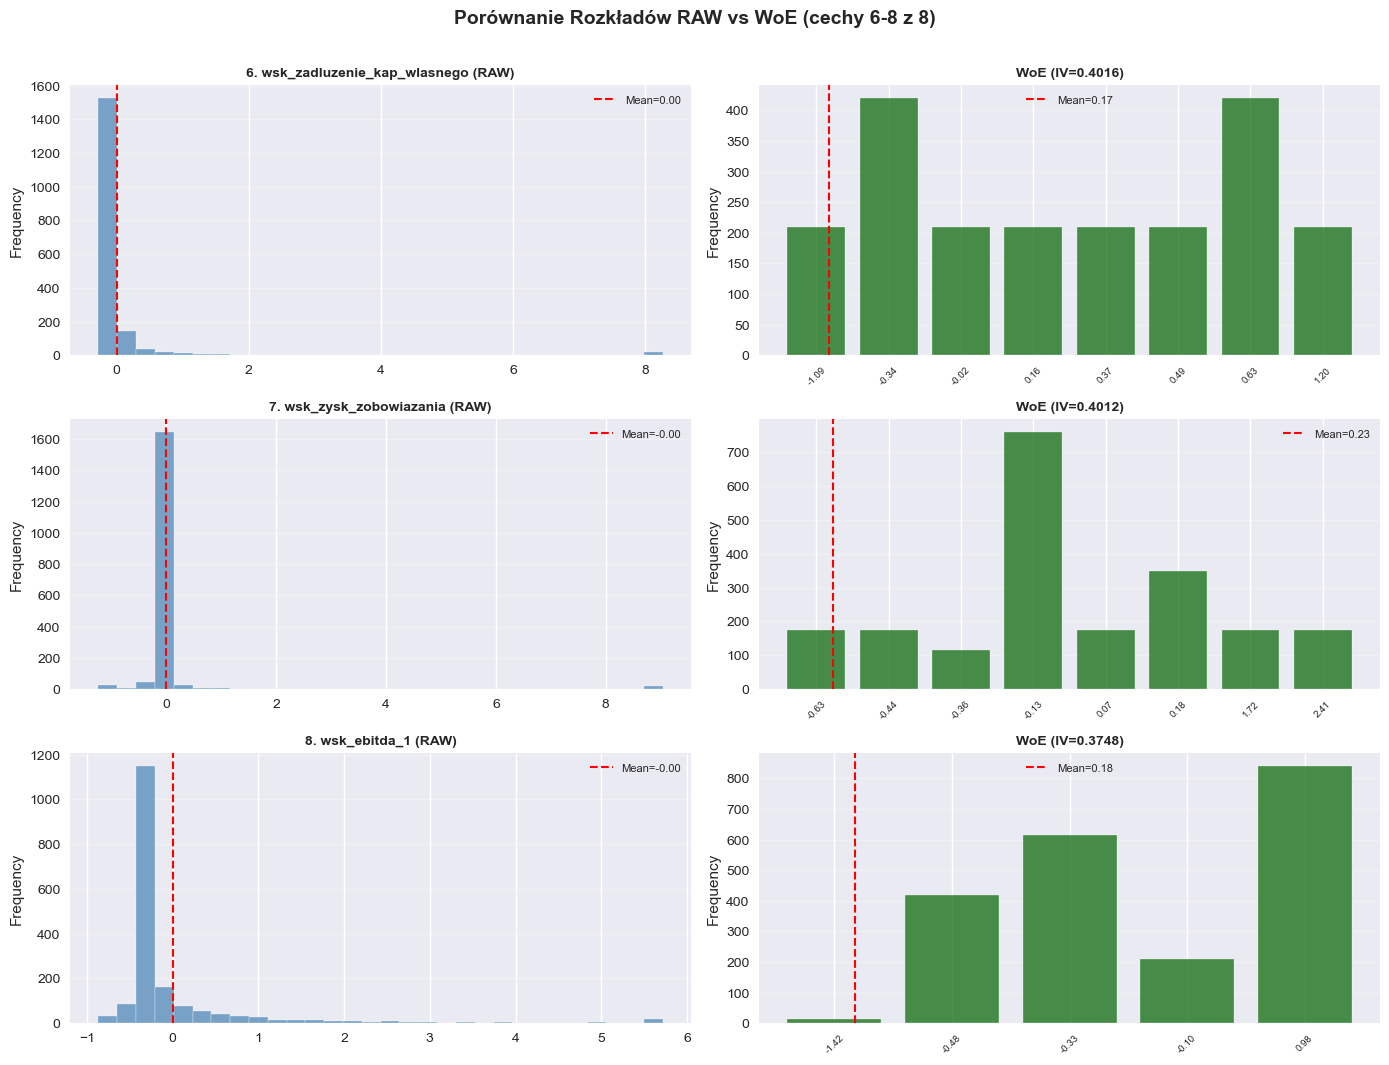

   ✅ Figura 2/2: cechy 6-8

✅ Wyświetlono porównanie rozkładów dla wszystkich 8 cech!


5️⃣  PODSUMOWANIE

📊 WYBRANYCH CECH: 8
   Very Strong/Strong (IV ≥ 0.3):  8
   Medium (0.1 ≤ IV < 0.3):        0
   Weak (0.02 ≤ IV < 0.1):         0

⚠️  WIELOKOLINEARNOŚĆ: 4 par o |r| > 0.7

✅ WoE transformation zakończona!


In [ ]:
print("="*80)
print("📊 EDA - ANALIZA JAKOŚCI WoE (BASIC SCORECARD)")
print("="*80)

# ============================================================================
# 1. IV RANKING - TOP 10 CECH
# ============================================================================
print("\n\n1️⃣  IV RANKING - TOP 10 CECH")
print("="*80)

# Zbuduj dataframe z IV z woe_mappings
iv_data = []
for feat, info in woe_mappings_basic.items():
    woe_table = info['table']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    n_bins = info['bins']
    
    # Kategoryzacja
    if iv_total >= 0.5: power = "Very Strong"
    elif iv_total >= 0.3: power = "Strong"
    elif iv_total >= 0.1: power = "Medium"
    elif iv_total >= 0.02: power = "Weak"
    else: power = "Unpredictive"
    
    iv_data.append({
        'feature': feat,
        'IV': iv_total,
        'bins': n_bins,
        'Power': power
    })

iv_df_basic = pd.DataFrame(iv_data).sort_values('IV', ascending=False)

# Wizualizacja rozkładu mocy
power_counts = iv_df_basic['Power'].value_counts()
print(f"\n📊 Rozkład mocy predykcyjnej ({len(iv_df_basic)} cech):\n")

power_order = ["Very Strong", "Strong", "Medium", "Weak", "Unpredictive"]
for power in power_order:
    count = power_counts.get(power, 0)
    if count > 0:
        bar = "█" * int(count / 2)
        print(f"   {power:15} ({count:2}): {bar}")

# Top 10
print(f"\n📈 TOP 10 CECH:")
print(f"\n   {'Rank':<6} {'Feature':<45} {'IV':<10} {'Bins':<6} {'Power'}")
print("   " + "-"*80)

for idx, (i, row) in enumerate(iv_df_basic.head(10).iterrows()):
    print(f"   {idx+1:<6} {row['feature']:<45} {row['IV']:<10.4f} {row['bins']:<6} {row['Power']}")

# ============================================================================
# 2. WoE TABLES - TOP 5 FEATURES
# ============================================================================
print("\n\n2️⃣  WoE TABLES - TOP 5 FEATURES")
print("="*80)

top5_basic = iv_df_basic.head(5)['feature'].tolist()

for i, feat in enumerate(top5_basic, 1):
    if feat not in woe_mappings_basic:
        print(f"\n⚠️  {feat}: Brak danych")
        continue
    
    woe_table = woe_mappings_basic[feat]['table']
    n_bins = woe_mappings_basic[feat]['bins']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    
    print(f"\n{i}. {feat}")
    print(f"   IV: {iv_total:.4f}, Bins: {n_bins}")
    print(f"\n   {'Bin':<15} {'Count':>8} {'Bad%':>8} {'WoE':>10} {'IV':>10}")
    print("   " + "-"*55)
    
    for _, row in woe_table.iterrows():
        bin_label = str(row.get('bin', row.get('range', 'N/A')))[:15]
        count = row.get('count', row.get('total', 0))
        bad_rate = row.get('bad_rate', row.get('event_rate', 0)) * 100
        woe = row.get('woe', 0)
        iv = row.get('iv', 0)
        print(f"   {bin_label:<15} {count:>8.0f} {bad_rate:>7.1f}% {woe:>10.3f} {iv:>10.4f}")

# ============================================================================
# 3. MACIERZ KORELACJI
# ============================================================================
print("\n\n3️⃣  MACIERZ KORELACJI")
print("="*80)

# Używamy X_train_val_woe_basic (utworzone w poprzedniej komórce)
corr_woe_basic = X_train_val_woe_basic.corr()

# Znajdź wysokie korelacje
high_corr = []
for i in range(len(corr_woe_basic.columns)):
    for j in range(i+1, len(corr_woe_basic.columns)):
        corr_val = corr_woe_basic.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append((corr_woe_basic.columns[i], corr_woe_basic.columns[j], corr_val))

if len(high_corr) > 0:
    print(f"\n⚠️  Wysokie korelacje (|r| > 0.7): {len(high_corr)}")
    for feat1, feat2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
        f1 = feat1.replace('_woe', '')
        f2 = feat2.replace('_woe', '')
        print(f"   {f1} ↔ {f2}: {corr_val:+.3f}")
else:
    print(f"\n✅ Brak wysokich korelacji (|r| > 0.7)")

# Heatmap (jeśli nie za dużo cech)
if X_train_val_woe_basic.shape[1] <= 25:
    print(f"\n📊 Heatmap macierzy korelacji:")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_woe_basic, 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                cbar_kws={"label": "Correlation"})
    plt.title('Macierz Korelacji - WoE Features (Basic Scorecard)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"   (Pominięto heatmap - zbyt dużo cech)")

# ============================================================================
# 4. ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)
# ============================================================================
print("\n\n4️⃣  ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)")
print("="*80)

# Pobierz wszystkie cechy posortowane według IV
all_features_woe = iv_df_basic['feature'].tolist()
n_features_plot = len(all_features_woe)

print(f"\n📊 Porównanie rozkładów dla {n_features_plot} cech:")
print("   Niebieski = RAW (po Full Pipeline preprocessing)")
print("   Zielony = WoE (Weight of Evidence)")

# Oblicz ile wierszy potrzebujemy (2 kolumny: RAW | WoE, po 4 cechy na figurę)
features_per_figure = 5  # 5 cech na jedną figurę
n_figures = int(np.ceil(n_features_plot / features_per_figure))

for fig_idx in range(n_figures):
    start_idx = fig_idx * features_per_figure
    end_idx = min(start_idx + features_per_figure, n_features_plot)
    features_batch = all_features_woe[start_idx:end_idx]
    
    n_rows = len(features_batch)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows))
    
    # Jeśli tylko 1 cecha, axes nie jest 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, feat in enumerate(features_batch):
        feat_woe_name = f"{feat}_woe"
        global_idx = start_idx + row_idx + 1
        iv_val = iv_df_basic[iv_df_basic['feature'] == feat]['IV'].values[0]
        
        # RAW (lewa kolumna)
        if feat in X_train_full.columns:
            data_raw = X_train_full[feat].dropna()
            axes[row_idx, 0].hist(data_raw, bins=30, alpha=0.7, color='steelblue', edgecolor='white')
            axes[row_idx, 0].axvline(data_raw.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean={data_raw.mean():.2f}')
            axes[row_idx, 0].set_title(f'{global_idx}. {feat[:40]}... (RAW)' if len(feat) > 40 else f'{global_idx}. {feat} (RAW)', 
                                       fontsize=10, fontweight='bold')
            axes[row_idx, 0].set_ylabel('Frequency')
            axes[row_idx, 0].grid(axis='y', alpha=0.3)
            axes[row_idx, 0].legend(fontsize=8)
        else:
            axes[row_idx, 0].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=12)
            axes[row_idx, 0].set_title(f'{global_idx}. {feat} (RAW - brak)', fontsize=10)
        
        # WoE (prawa kolumna) - używamy X_train_val_woe_basic
        if feat_woe_name in X_train_val_woe_basic.columns:
            data_woe = X_train_val_woe_basic[feat_woe_name].dropna()
            n_unique = data_woe.nunique()
            
            # Jeśli mało unikalnych wartości, użyj bar plot
            if n_unique <= 15:
                value_counts = data_woe.value_counts().sort_index()
                axes[row_idx, 1].bar(range(len(value_counts)), value_counts.values, 
                                     alpha=0.7, color='darkgreen', edgecolor='white')
                axes[row_idx, 1].set_xticks(range(len(value_counts)))
                axes[row_idx, 1].set_xticklabels([f'{v:.2f}' for v in value_counts.index], rotation=45, fontsize=7)
            else:
                axes[row_idx, 1].hist(data_woe, bins=20, alpha=0.7, color='darkgreen', edgecolor='white')
            
            axes[row_idx, 1].axvline(data_woe.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean={data_woe.mean():.2f}')
            axes[row_idx, 1].set_title(f'WoE (IV={iv_val:.4f})', fontsize=10, fontweight='bold')
            axes[row_idx, 1].set_ylabel('Frequency')
            axes[row_idx, 1].grid(axis='y', alpha=0.3)
            axes[row_idx, 1].legend(fontsize=8)
        else:
            axes[row_idx, 1].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=12)
            axes[row_idx, 1].set_title(f'WoE (brak)', fontsize=10)
    
    fig.suptitle(f'Porównanie Rozkładów RAW vs WoE (cechy {start_idx+1}-{end_idx} z {n_features_plot})', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Figura {fig_idx+1}/{n_figures}: cechy {start_idx+1}-{end_idx}")

print(f"\n✅ Wyświetlono porównanie rozkładów dla wszystkich {n_features_plot} cech!")

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n\n5️⃣  PODSUMOWANIE")
print("="*80)

n_features = X_train_val_woe_basic.shape[1]
excellent = (iv_df_basic['IV'] >= 0.3).sum()
medium = ((iv_df_basic['IV'] >= 0.1) & (iv_df_basic['IV'] < 0.3)).sum()
weak = ((iv_df_basic['IV'] >= 0.02) & (iv_df_basic['IV'] < 0.1)).sum()

print(f"\n📊 WYBRANYCH CECH: {n_features}")
print(f"   Very Strong/Strong (IV ≥ 0.3):  {excellent}")
print(f"   Medium (0.1 ≤ IV < 0.3):        {medium}")
print(f"   Weak (0.02 ≤ IV < 0.1):         {weak}")

# Korelacje
if len(high_corr) == 0:
    print(f"\n✅ WIELOKOLINEARNOŚĆ: OK")
else:
    print(f"\n⚠️  WIELOKOLINEARNOŚĆ: {len(high_corr)} par o |r| > 0.7")

print("\n✅ WoE transformation zakończona!")
print("="*80)

In [ ]:
# ADVANCED SCORECARD - GRID SEARCH (DETERMINISTYCZNY)
# random.seed(42) + MAX 1000 kombinacji/N
print("="*80)
print("HYPERPARAMETER TUNING - ADVANCED SCORECARD (N=5-12, DETERMINISTYCZNY)")
print("="*80)

import time
import random
import numpy as np
from itertools import product

# ============================================
# DETERMINISTYCZNOŚĆ - USTAW SEED
# ============================================
random.seed(42)
np.random.seed(42)

# ============================================
# FUNKCJE POMOCNICZE
# ============================================
def monotonicity_score_adv(woe_table):
    woe_values = woe_table['woe'].values
    if len(woe_values) < 2:
        return 100.0
    diffs = np.diff(woe_values)
    n_pos = np.sum(diffs > 0)
    n_neg = np.sum(diffs < 0)
    n_zero = np.sum(diffs == 0)
    total = len(diffs)
    if total == 0:
        return 100.0
    return (max(n_pos, n_neg) + n_zero) / total * 100

def calculate_feature_bins_info_adv(X_data, y_data, feature, bin_options, min_mono=75.0):
    results = []
    for n_bins in bin_options:
        try:
            df_temp = pd.DataFrame({feature: X_data[feature], 'target': y_data.values})
            woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=n_bins)
            mono = monotonicity_score_adv(woe_table)
            if mono >= min_mono:
                results.append({'bins': n_bins, 'iv': iv_value, 'mono': mono})
        except:
            continue
    return results

def get_woe_data_train_adv(config, X_data, y_data):
    X_woe = pd.DataFrame()
    woe_mappings = {}
    for feat, info in config:
        n_bins = info['bins']
        try:
            df_temp = pd.DataFrame({feat: X_data[feat], 'target': y_data.values})
            woe_table, _ = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
            _, bin_edges = pd.qcut(X_data[feat], q=n_bins, retbins=True, duplicates='drop')
            woe_mappings[feat] = {'bin_edges': bin_edges, 'woe_table': woe_table.copy(), 'n_bins': len(bin_edges)-1}
            woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
            X_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        except:
            continue
    return X_woe, woe_mappings

def get_woe_data_predict_adv(config, X_data, woe_mappings):
    X_woe = pd.DataFrame()
    for feat, info in config:
        if feat not in woe_mappings:
            continue
        mapping = woe_mappings[feat]
        try:
            binned = pd.cut(X_data[feat], bins=mapping['bin_edges'], labels=False, include_lowest=True)
            woe_dict = {idx: mapping['woe_table'].iloc[idx]['woe'] for idx in range(len(mapping['woe_table']))}
            X_woe[f"{feat}_woe"] = binned.map(woe_dict).fillna(0)
        except:
            X_woe[f"{feat}_woe"] = 0
    return X_woe

def check_sign_stability_adv(config, X_trainval, y_trainval, X_test, y_test, C, solver):
    if len(config) == 0:
        return [], False
    X_tv_woe, woe_mappings = get_woe_data_train_adv(config, X_trainval, y_trainval)
    X_t_woe = get_woe_data_predict_adv(config, X_test, woe_mappings)
    if X_tv_woe.shape[1] == 0 or X_t_woe.shape[1] == 0:
        return [f for f, _ in config], False
    common_cols = sorted(set(X_tv_woe.columns) & set(X_t_woe.columns))
    if not common_cols:
        return [f for f, _ in config], False
    X_tv_woe = X_tv_woe[common_cols].fillna(0)
    X_t_woe = X_t_woe[common_cols].fillna(0)
    try:
        model_tv = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
        model_tv.fit(X_tv_woe, y_trainval)
        model_t = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
        model_t.fit(X_t_woe, y_test)
    except:
        return [f for f, _ in config], False
    unstable = []
    for i, col in enumerate(common_cols):
        feat = col.replace('_woe', '')
        if np.sign(model_tv.coef_[0][i]) != np.sign(model_t.coef_[0][i]):
            if model_tv.coef_[0][i] != 0 and model_t.coef_[0][i] != 0:
                unstable.append(feat)
    return unstable, len(unstable) == 0

# ============================================
# PARAMETRY
# ============================================
BIN_OPTIONS_ADV = [3, 4, 5, 6, 7, 8, 10]
MIN_MONO_ADV = 75.0
MIN_AVG_MONO_ADV = 80.0
TOP_FEATURES_ADV = 30
N_FEATURES_OPTIONS_ADV = [5, 6, 7, 8, 9, 10, 11, 12]
C_OPTIONS_ADV = [0.01]
MAX_BIN_COMBOS_PER_N = 1000  # Deterministyczne losowanie z seedem

print(f"\n⚡ PARAMETRY:")
print(f"   • N cech: {N_FEATURES_OPTIONS_ADV}")
print(f"   • C: {C_OPTIONS_ADV}")
print(f"   • Min mono/cechę: {MIN_MONO_ADV}%")
print(f"   • Min avg mono: {MIN_AVG_MONO_ADV}%")
print(f"   • Max kombinacji/N: {MAX_BIN_COMBOS_PER_N}")
print(f"   • SEED: 42 (wyniki będą powtarzalne)")
print(f"\n📊 Dane: TRAIN+VAL={len(X_train_val_full_sc)}, TEST={len(X_test_full_sc)}")

# ============================================
# KROK 1: ANALIZA CECH
# ============================================
print("\n" + "="*80)
print("KROK 1: ANALIZA TOP CECH")
print("-"*80)

start_time = time.time()
numeric_features = X_train_val_full_sc.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n🔧 Analiza IV dla {len(numeric_features)} cech...")
all_features_iv = {}
for i, feat in enumerate(numeric_features):
    if (i+1) % 50 == 0:
        print(f"      {i+1}/{len(numeric_features)}...")
    try:
        df_temp = pd.DataFrame({feat: X_train_val_full_sc[feat], 'target': y_train_val_sc.values})
        _, iv = calculate_woe_iv(df_temp, feat, 'target', bins=10)
        all_features_iv[feat] = iv
    except:
        pass

top_features_list = sorted(all_features_iv.keys(), key=lambda f: all_features_iv[f], reverse=True)[:TOP_FEATURES_ADV]

print(f"\n🔧 Analiza binowania dla TOP {TOP_FEATURES_ADV} cech...")
feature_bin_options = {}
for feat in top_features_list:
    bins_info = calculate_feature_bins_info_adv(X_train_val_full_sc, y_train_val_sc, feat, BIN_OPTIONS_ADV, MIN_MONO_ADV)
    if bins_info:
        feature_bin_options[feat] = bins_info

features_sorted = sorted(feature_bin_options.keys(), key=lambda f: max(o['iv'] for o in feature_bin_options[f]), reverse=True)
print(f"   ✅ {len(features_sorted)} cech z mono >= {MIN_MONO_ADV}%")

print(f"\n📊 TOP 15 cech:")
for i, feat in enumerate(features_sorted[:15], 1):
    opts = feature_bin_options[feat]
    best_iv = max(o['iv'] for o in opts)
    print(f"   {i:2}. {feat[:40]:<40} IV={best_iv:.4f}, opcji binów: {len(opts)}")

# ============================================
# KROK 2: GRID SEARCH (DETERMINISTYCZNY)
# ============================================
print("\n" + "="*80)
print("KROK 2: GRID SEARCH (SEED=42, MAX 1000 KOMBINACJI/N)")
print("-"*80)

best_score_adv = 0
best_config_adv = None
best_params_adv = None
best_woe_mappings_adv = None
total_tested = 0
total_stable = 0
results_per_n = {}

for n_features in N_FEATURES_OPTIONS_ADV:
    if n_features > len(features_sorted):
        print(f"\n⚠️  N={n_features}: za mało cech ({len(features_sorted)} dostępnych)")
        continue
    
    # Wybierz TOP N cech
    selected_features = features_sorted[:n_features]
    
    # Generuj kombinacje binów
    bin_opts_per_feat = [feature_bin_options[f] for f in selected_features]
    total_combos = 1
    for opts in bin_opts_per_feat:
        total_combos *= len(opts)
    
    # Jeśli za dużo kombinacji - losuj próbkę (deterministycznie dzięki seed)
    if total_combos <= MAX_BIN_COMBOS_PER_N:
        bin_combos = list(product(*bin_opts_per_feat))
        print(f"\n🔍 N={n_features}: WSZYSTKIE {len(bin_combos)} kombinacji")
    else:
        seen = {}
        attempts = 0
        while len(seen) < MAX_BIN_COMBOS_PER_N and attempts < MAX_BIN_COMBOS_PER_N * 3:
            combo = tuple(random.choice(opts) for opts in bin_opts_per_feat)
            key = tuple(c['bins'] for c in combo)
            if key not in seen:
                seen[key] = combo
            attempts += 1
        bin_combos = list(seen.values())
        print(f"\n🔍 N={n_features}: losowanie {len(bin_combos)}/{total_combos} kombinacji (seed=42)")
    
    n_stable = 0
    best_auc_n = 0
    
    for bin_combo in bin_combos:
        config = [(selected_features[i], bin_combo[i]) for i in range(n_features)]
        
        # Sprawdź średnią mono
        avg_mono = np.mean([info['mono'] for _, info in config])
        if avg_mono < MIN_AVG_MONO_ADV:
            continue
        
        total_tested += 1
        
        for C in C_OPTIONS_ADV:
            unstable, is_stable = check_sign_stability_adv(
                config, X_train_val_full_sc, y_train_val_sc,
                X_test_full_sc, y_test_sc, C, 'lbfgs'
            )
            
            if is_stable:
                total_stable += 1
                n_stable += 1
                
                X_woe, woe_map = get_woe_data_train_adv(config, X_train_val_full_sc, y_train_val_sc)
                if X_woe.shape[1] > 0:
                    try:
                        model = LogisticRegression(C=C, solver='lbfgs', max_iter=1000,
                                                   random_state=42, class_weight='balanced')
                        model.fit(X_woe.fillna(0), y_train_val_sc)
                        y_proba = model.predict_proba(X_woe.fillna(0))[:, 1]
                        auc = roc_auc_score(y_train_val_sc, y_proba)
                        
                        if auc > best_auc_n:
                            best_auc_n = auc
                        
                        if auc > best_score_adv:
                            best_score_adv = auc
                            best_config_adv = config
                            best_params_adv = {'n_features': n_features, 'C': C, 'solver': 'lbfgs'}
                            best_woe_mappings_adv = woe_map
                            print(f"      ✨ NEW BEST: AUC={auc:.4f}, N={n_features}")
                    except:
                        pass
    
    results_per_n[n_features] = {'stable': n_stable, 'best_auc': best_auc_n}
    print(f"      Stabilnych: {n_stable}, best AUC: {best_auc_n:.4f}")

# ============================================
# PODSUMOWANIE
# ============================================
elapsed = time.time() - start_time
print("\n" + "="*80)
print("PODSUMOWANIE")
print("="*80)
print(f"⏱️  Czas: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"📊 Testowano: {total_tested}, Stabilnych: {total_stable}")
print(f"🎲 SEED=42 - wyniki są powtarzalne!")

print(f"\n📊 WYNIKI PER N:")
for n, res in sorted(results_per_n.items()):
    marker = "🏆" if res['best_auc'] == best_score_adv else "  "
    print(f"   {marker} N={n:2}: stabilnych={res['stable']:3}, best AUC={res['best_auc']:.4f}")

if best_config_adv:
    print(f"\n🏆 NAJLEPSZA KONFIGURACJA:")
    print(f"   AUC (TRAIN+VAL): {best_score_adv:.4f}")
    print(f"   N={best_params_adv['n_features']}, C={best_params_adv['C']}")
    
    best_features_adv = [(f, info) for f, info in best_config_adv]
    avg_mono = np.mean([info['mono'] for _, info in best_features_adv])
    print(f"   Średnia mono: {avg_mono:.1f}%")
    
    print(f"\n📋 Cechy ({len(best_features_adv)}):")
    for i, (feat, info) in enumerate(best_features_adv, 1):
        print(f"   {i:2}. {feat[:40]:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")
    
    # Zapisz
    import json
    config_dir = "grid_search_results"
    os.makedirs(config_dir, exist_ok=True)
    
    config_data = {
        'best_score': best_score_adv,
        'best_params': best_params_adv,
        'best_features': [{'feature': f, 'bins': info['bins'], 'iv': info['iv'], 'mono': info['mono']} for f, info in best_features_adv],
        'total_tested': total_tested,
        'total_stable': total_stable,
        'results_per_n': {str(k): v for k, v in results_per_n.items()},
        'split': '60/10/30',
        'seed': 42
    }
    
    with open(f"{config_dir}/best_config_advanced_latest.json", 'w', encoding='utf-8') as f:
        json.dump(config_data, f, indent=2, ensure_ascii=False)
    print(f"\n💾 Zapisano: {config_dir}/best_config_advanced_latest.json")
else:
    print("\n❌ Nie znaleziono stabilnej konfiguracji!")

print("="*80)

HYPERPARAMETER TUNING - ADVANCED SCORECARD (N=5-14, BEZ LOSOWANIA)

⚡ PARAMETRY:
   • N cech: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
   • C: [0.01]
   • Min mono/cechę: 75.0%
   • Min avg mono: 80.0%
   • Max kombinacji binów/N: 100

📊 Dane: TRAIN+VAL=2100, TEST=900

KROK 1: ANALIZA TOP CECH
--------------------------------------------------------------------------------

🔧 Analiza IV dla 165 cech...
      50/165...
      100/165...
      150/165...

🔧 Analiza binowania dla TOP 30 cech...
   ✅ 26 cech z mono >= 75.0%

📊 TOP 15 cech:
    1. Kapital_wlasny                           IV=0.4860, opcji binów: 6
    2. wsk_ebitda_zobowiazan_1                  IV=0.4796, opcji binów: 3
    3. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4551, opcji binów: 6
    4. wsk_ogolnego_zadluzenia_1                IV=0.4016, opcji binów: 1
    5. wsk_zadluzenie_kap_wlasnego              IV=0.4016, opcji binów: 1
    6. wsk_zysk_zobowiazania                    IV=0.3814, opcji binów: 3
    7. wsk_ebitda_1 

## 20. Advanced Scorecard (Feature Engineering + VIF)

Scorecard dla Advanced Pipeline z feature engineering.

In [ ]:
print("="*80)
print("ADVANCED SCORECARD (SPLIT 60/10/30)")
print("="*80)

import json
import os
from sklearn.metrics import auc as sklearn_auc

config_dir = "grid_search_results"
json_file = os.path.join(config_dir, "best_config_advanced_latest.json")

if os.path.exists(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        config_data = json.load(f)
    
    best_params_adv = config_data['best_params']
    best_features_adv = [
        (item['feature'], {'bins': item['bins'], 'iv': item['iv'], 'mono': item['mono']})
        for item in config_data['best_features']
    ]
    
    print(f"✅ Wczytano z {json_file}")
    print(f"   Split: {config_data.get('split', '60/10/30')}")
    print(f"   Cechy: {len(best_features_adv)}, C={best_params_adv['C']}")
    
else:
    print(f"⚠️  Nie znaleziono {json_file} - używam zmiennych z pamięci")
    if 'best_params_adv' not in globals() or best_params_adv is None:
        print("❌ Brak best_params_adv - uruchom najpierw Advanced Grid Search!")
        raise ValueError("Uruchom Advanced Grid Search przed tą komórką")

# Wyświetl parametry
print(f"\n🎯 PARAMETRY:")
print(f"   Cechy:  {best_params_adv['n_features']}")
print(f"   C:      {best_params_adv['C']}")
print(f"   Solver: {best_params_adv['solver']}")

print(f"\n📋 WYBRANE CECHY ({len(best_features_adv)}):")
for i, (feat, info) in enumerate(best_features_adv[:10], 1):
    print(f"   {i:2}. {feat:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")
if len(best_features_adv) > 10:
    print(f"   ... (+{len(best_features_adv)-10} więcej)")

# WoE Transformation - TRAIN+VAL z nowego splitu 60/10/30
# UWAGA: Używamy X_train_val_full_sc (tak samo jak dla BASIC)
print(f"\n🔄 WoE Transformation (split 60/10/30)...")

X_train_woe_advanced_sc = pd.DataFrame()
woe_mappings_advanced_sc = {}

for feat, info in best_features_adv:
    try:
        n_bins = info['bins']
        # Używamy X_train_val_full_sc (70% - train+val z nowego splitu)
        df_temp = pd.DataFrame({feat: X_train_val_full_sc[feat], 'target': y_train_val_sc.values})
        woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
        X_train_woe_advanced_sc[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        
        woe_table, iv_val = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
        woe_mappings_advanced_sc[feat] = {'table': woe_table, 'bins': n_bins, 'iv': iv_val}
    except Exception as e:
        print(f"   ⚠️  Pominięto {feat}: {e}")
        continue

print(f"   ✅ Przekształcono {len(X_train_woe_advanced_sc.columns)} cech")

# WoE Transformation - TEST (30% z nowego splitu)
# UWAGA: Używamy X_test_full_sc (tak samo jak dla BASIC)
X_test_woe_advanced_sc = pd.DataFrame()
for feat, info in best_features_adv:
    if feat in woe_mappings_advanced_sc:
        try:
            n_bins = woe_mappings_advanced_sc[feat]['bins']
            df_temp = pd.DataFrame({feat: X_test_full_sc[feat], 'target': y_test_sc.values})
            woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
            X_test_woe_advanced_sc[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        except:
            X_test_woe_advanced_sc[f"{feat}_woe"] = 0

print(f"   Shape TRAIN+VAL: {X_train_woe_advanced_sc.shape}")
print(f"   Shape TEST:      {X_test_woe_advanced_sc.shape}")

# Model - trenuj na TRAIN+VAL (70%)
print(f"\n🎯 Trening Logistic Regression na TRAIN+VAL (70%)...")
scorecard_advanced = LogisticRegression(
    C=best_params_adv['C'],
    solver=best_params_adv['solver'],
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)
scorecard_advanced.fit(X_train_woe_advanced_sc, y_train_val_sc)

# Predykcje
y_proba_trainval_adv = scorecard_advanced.predict_proba(X_train_woe_advanced_sc)[:, 1]
y_proba_sc_adv = scorecard_advanced.predict_proba(X_test_woe_advanced_sc)[:, 1]
y_pred_sc_adv = scorecard_advanced.predict(X_test_woe_advanced_sc)

# Metryki na TEST (30%) - UŻYWAMY y_test_sc!
from sklearn.metrics import precision_recall_curve, log_loss, brier_score_loss

def calculate_ks(y_true, y_pred_proba):
    df_ks = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
    df_ks = df_ks.sort_values('pred', ascending=False).reset_index(drop=True)
    df_ks['cumulative_bad'] = df_ks['true'].cumsum() / df_ks['true'].sum()
    df_ks['cumulative_good'] = (1 - df_ks['true']).cumsum() / (1 - df_ks['true']).sum()
    return (df_ks['cumulative_bad'] - df_ks['cumulative_good']).abs().max()

auc_train_val_adv = roc_auc_score(y_train_val_sc, y_proba_trainval_adv)
auc_test_adv = roc_auc_score(y_test_sc, y_proba_sc_adv)
precision, recall, _ = precision_recall_curve(y_test_sc, y_proba_sc_adv)

metrics_sc_adv = {
    'roc_auc': auc_test_adv,
    'pr_auc': sklearn_auc(recall, precision),
    'ks': calculate_ks(y_test_sc, y_proba_sc_adv),
    'log_loss': log_loss(y_test_sc, y_proba_sc_adv),
    'brier': brier_score_loss(y_test_sc, y_proba_sc_adv)
}

print(f"\n✅ MODEL WYTRENOWANY!")
print(f"\n📈 WYNIKI (split 60/10/30):")
print(f"   TRAIN+VAL: {len(X_train_woe_advanced_sc)} obs (70%)")
print(f"   TEST:      {len(X_test_woe_advanced_sc)} obs (30%)")
print(f"   ROC-AUC TRAIN+VAL: {auc_train_val_adv:.4f}")
print(f"   ROC-AUC TEST:      {auc_test_adv:.4f}")
print(f"   Δ AUC:             {auc_train_val_adv - auc_test_adv:+.4f}")
print(f"\n📊 METRYKI NA ZBIORZE TESTOWYM (30%):")
print(f"   ROC-AUC:   {metrics_sc_adv['roc_auc']:.4f}")
print(f"   PR-AUC:    {metrics_sc_adv['pr_auc']:.4f}")
print(f"   KS:        {metrics_sc_adv['ks']:.4f}")
print(f"   Log Loss:  {metrics_sc_adv['log_loss']:.4f}")
print(f"   Brier:     {metrics_sc_adv['brier']:.4f}")

print(f"\n💾 Zapisano:")
print(f"   • scorecard_advanced - wytrenowany model")
print(f"   • X_train_woe_advanced_sc, X_test_woe_advanced_sc - dane WoE")
print(f"   • woe_mappings_advanced_sc - mapowania WoE")
print(f"   • metrics_sc_adv - metryki na TEST 30%")
print("="*80)

ADVANCED SCORECARD (SPLIT 60/10/30)
✅ Wczytano z grid_search_results\best_config_advanced_latest.json
   Split: 60/10/30
   Cechy: 8, C=0.01

🎯 PARAMETRY:
   Cechy:  8
   C:      0.01
   Solver: lbfgs

📋 WYBRANE CECHY (8):
    1. Kapital_wlasny                           IV=0.4639, Mono=100.0%, Bins=4
    2. wsk_ebitda_zobowiazan_1                  IV=0.4796, Mono=75.0%, Bins=6
    3. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4551, Mono=100.0%, Bins=6
    4. wsk_ogolnego_zadluzenia_1                IV=0.4016, Mono=75.0%, Bins=10
    5. wsk_zadluzenie_kap_wlasnego              IV=0.4016, Mono=75.0%, Bins=10
    6. wsk_zysk_zobowiazania                    IV=0.3814, Mono=75.0%, Bins=6
    7. wsk_ebitda_1                             IV=0.3748, Mono=75.0%, Bins=10
    8. zysk_sprzedazy                           IV=0.3695, Mono=75.0%, Bins=5

🔄 WoE Transformation (split 60/10/30)...
   ✅ Przekształcono 8 cech
   Shape TRAIN+VAL: (2100, 8)
   Shape TEST:      (900, 8)

🎯 Trening Logistic 

### 20.1 EDA - Analiza Jakości WoE (Advanced)

Analiza WoE dla Advanced Pipeline


📊 EDA - ANALIZA JAKOŚCI WoE (ADVANCED SCORECARD)

✅ Dane WoE dostępne: 8 cech


1️⃣  IV RANKING - TOP 10 CECH

📊 Rozkład mocy predykcyjnej (8 cech):

   Strong          ( 8): ████

📈 TOP 10 CECH:

   Rank   Feature                                       IV         Bins   Power
   --------------------------------------------------------------------------------
   2      wsk_ebitda_zobowiazan_1                       0.4796     6      Strong
   1      Kapital_wlasny                                0.4639     4      Strong
   3      wsk_poziom_kapitalu_obrotowego_netto          0.4551     6      Strong
   4      wsk_ogolnego_zadluzenia_1                     0.4016     10     Strong
   5      wsk_zadluzenie_kap_wlasnego                   0.4016     10     Strong
   6      wsk_zysk_zobowiazania                         0.3814     6      Strong
   7      wsk_ebitda_1                                  0.3748     10     Strong
   8      zysk_sprzedazy                                0.3695     5    

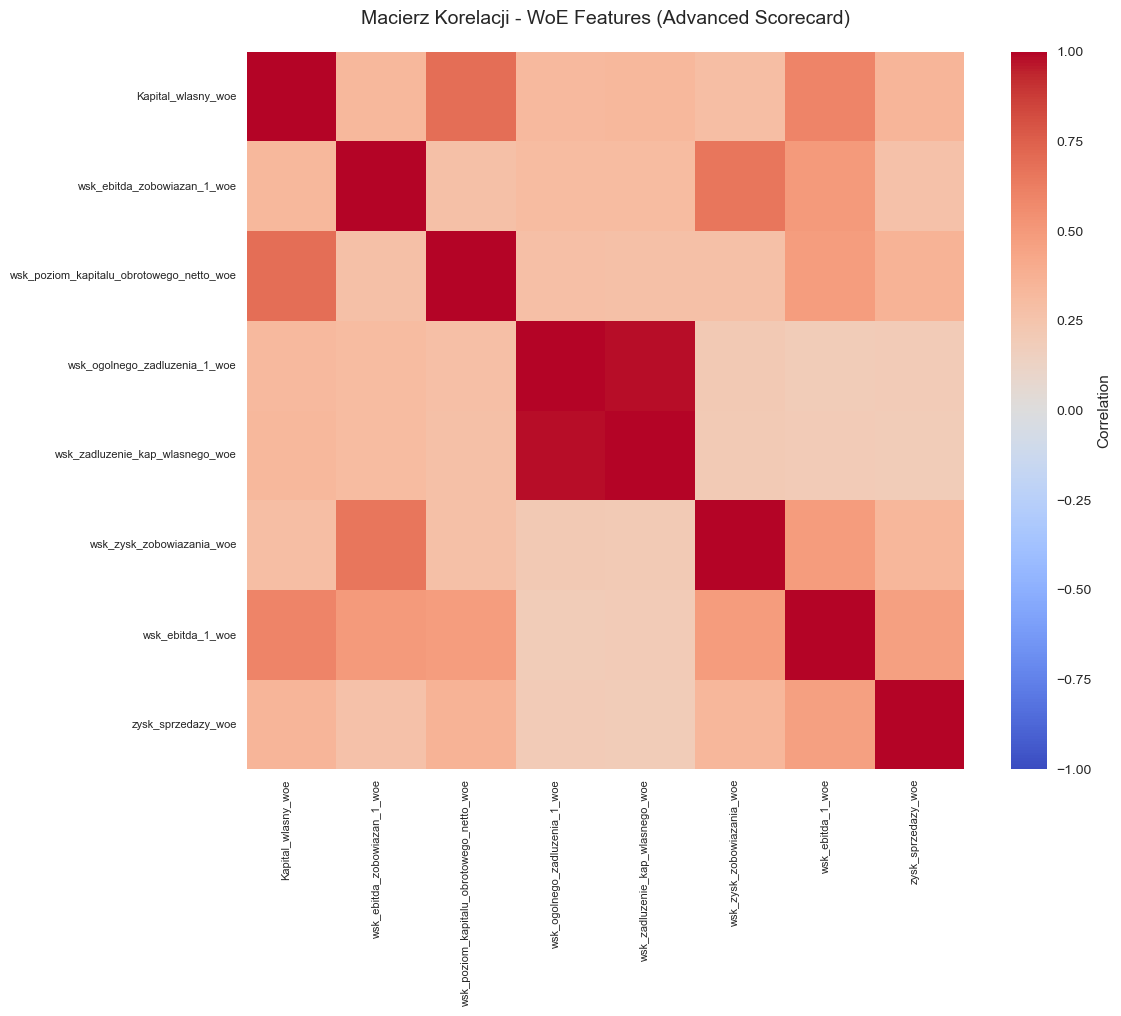



4️⃣  ROZKŁADY - TOP 3 CECH (RAW vs WoE)

1. wsk_ebitda_zobowiazan_1


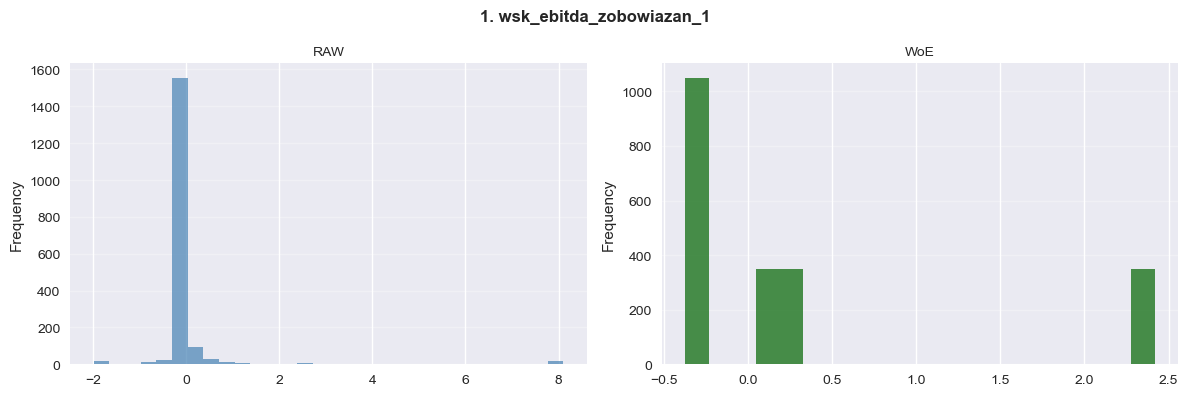


3. wsk_poziom_kapitalu_obrotowego_netto


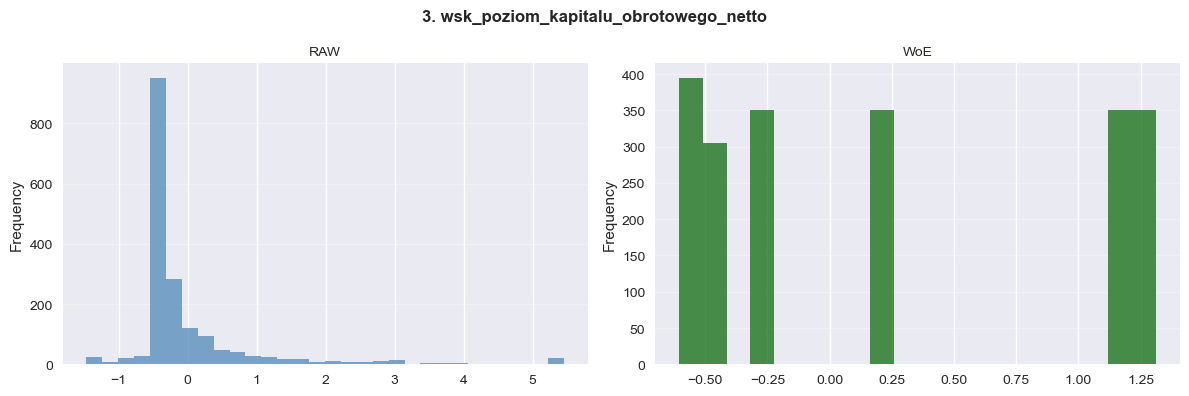



5️⃣  PODSUMOWANIE

📊 WYBRANYCH CECH: 8
   Very Strong/Strong (IV ≥ 0.3):  8
   Medium (0.1 ≤ IV < 0.3):        0
   Weak (0.02 ≤ IV < 0.1):         0

⚠️  WIELOKOLINEARNOŚĆ: 1 par o |r| > 0.7

✅ WoE transformation zakończona!


In [ ]:
print("="*80)
print("📊 EDA - ANALIZA JAKOŚCI WoE (ADVANCED SCORECARD)")
print("="*80)

# Sprawdź czy WoE zostało obliczone
if 'X_train_woe_advanced_sc' not in globals() or X_train_woe_advanced_sc.shape[1] == 0:
    print("\n⚠️  Brak danych WoE - najpierw uruchom Advanced Scorecard!")
else:
    print(f"\n✅ Dane WoE dostępne: {X_train_woe_advanced_sc.shape[1]} cech")

# ============================================================================
# 1. IV RANKING - TOP 10 CECH
# ============================================================================
print("\n\n1️⃣  IV RANKING - TOP 10 CECH")
print("="*80)

# Zbuduj dataframe z IV z woe_mappings
if 'woe_mappings_advanced_sc' in globals() and woe_mappings_advanced_sc:
    
    iv_data = []
    for feat, info in woe_mappings_advanced_sc.items():
        woe_table = info['table']
        iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
        n_bins = info['bins']
        
        # Kategoryzacja
        if iv_total >= 0.5: power = "Very Strong"
        elif iv_total >= 0.3: power = "Strong"
        elif iv_total >= 0.1: power = "Medium"
        elif iv_total >= 0.02: power = "Weak"
        else: power = "Unpredictive"
        
        iv_data.append({
            'feature': feat,
            'IV': iv_total,
            'bins': n_bins,
            'Power': power
        })
    
    iv_df_adv = pd.DataFrame(iv_data).sort_values('IV', ascending=False)
    
    # Wizualizacja rozkładu mocy
    power_counts = iv_df_adv['Power'].value_counts()
    print(f"\n📊 Rozkład mocy predykcyjnej ({len(iv_df_adv)} cech):\n")
    
    power_order = ["Very Strong", "Strong", "Medium", "Weak", "Unpredictive"]
    for power in power_order:
        count = power_counts.get(power, 0)
        if count > 0:
            bar = "█" * int(count / 2)
            print(f"   {power:15} ({count:2}): {bar}")
    
    # Top 10
    print(f"\n📈 TOP 10 CECH:")
    print(f"\n   {'Rank':<6} {'Feature':<45} {'IV':<10} {'Bins':<6} {'Power'}")
    print("   " + "-"*80)
    
    for i, row in iv_df_adv.head(10).iterrows():
        print(f"   {i+1:<6} {row['feature']:<45} {row['IV']:<10.4f} {row['bins']:<6} {row['Power']}")
else:
    print("\n⚠️  Brak woe_mappings_advanced_sc")

# ============================================================================
# 2. WoE TABLES - TOP 5 FEATURES
# ============================================================================
print("\n\n2️⃣  WoE TABLES - TOP 5 FEATURES")
print("="*80)

top5_adv = iv_df_adv.head(5)['feature'].tolist()

for i, feat in enumerate(top5_adv, 1):
    if feat not in woe_mappings_advanced_sc:
        print(f"\n⚠️  {feat}: Brak danych")
        continue
    
    woe_table = woe_mappings_advanced_sc[feat]['table']
    n_bins = woe_mappings_advanced_sc[feat]['bins']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    
    print(f"\n{i}. {feat}")
    print(f"   IV: {iv_total:.4f}, Bins: {n_bins}")
    print(f"\n   {'Bin':<15} {'Count':>8} {'Bad%':>8} {'WoE':>10} {'IV':>10}")
    print("   " + "-"*55)
    
    for _, row in woe_table.iterrows():
        bin_label = str(row.get('bin', row.get('range', 'N/A')))[:15]
        count = row.get('count', row.get('total', 0))
        bad_rate = row.get('bad_rate', row.get('event_rate', 0)) * 100
        woe = row.get('woe', 0)
        iv = row.get('iv', 0)
        print(f"   {bin_label:<15} {count:>8.0f} {bad_rate:>7.1f}% {woe:>10.3f} {iv:>10.4f}")

# ============================================================================
# 3. MACIERZ KORELACJI
# ============================================================================
print("\n\n3️⃣  MACIERZ KORELACJI")
print("="*80)

corr_woe_adv = X_train_woe_advanced_sc.corr()

# Znajdź wysokie korelacje
high_corr_adv = []
for i in range(len(corr_woe_adv.columns)):
    for j in range(i+1, len(corr_woe_adv.columns)):
        corr_val = corr_woe_adv.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_adv.append((corr_woe_adv.columns[i], corr_woe_adv.columns[j], corr_val))

if len(high_corr_adv) > 0:
    print(f"\n⚠️  Wysokie korelacje (|r| > 0.7): {len(high_corr_adv)}")
    for feat1, feat2, corr_val in sorted(high_corr_adv, key=lambda x: abs(x[2]), reverse=True)[:5]:
        f1 = feat1.replace('_woe', '')
        f2 = feat2.replace('_woe', '')
        print(f"   {f1} ↔ {f2}: {corr_val:+.3f}")
else:
    print(f"\n✅ Brak wysokich korelacji (|r| > 0.7)")

# Heatmap (jeśli nie za dużo cech)
if X_train_woe_advanced_sc.shape[1] <= 25:
    print(f"\n📊 Heatmap macierzy korelacji:")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_woe_adv, 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                cbar_kws={"label": "Correlation"})
    plt.title('Macierz Korelacji - WoE Features (Advanced Scorecard)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"   (Pominięto heatmap - zbyt dużo cech)")

# ============================================================================
# 4. ROZKŁADY - TOP 3 CECH
# ============================================================================
print("\n\n4️⃣  ROZKŁADY - TOP 3 CECH (RAW vs WoE)")
print("="*80)

for i, feat in enumerate(iv_df_adv.head(3)['feature'].tolist(), 1):
    if feat not in X_train_advanced_raw.columns or f"{feat}_woe" not in X_train_woe_advanced_sc.columns:
        continue
    
    print(f"\n{i}. {feat}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{i}. {feat}', fontsize=12, fontweight='bold')
    
    # RAW
    axes[0].hist(X_train_advanced_raw[feat].dropna(), bins=30, alpha=0.7, color='steelblue')
    axes[0].set_title('RAW', fontsize=10)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y', alpha=0.3)
    
    # WoE
    axes[1].hist(X_train_woe_advanced_sc[f"{feat}_woe"].dropna(), bins=20, alpha=0.7, color='darkgreen')
    axes[1].set_title('WoE', fontsize=10)
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n\n5️⃣  PODSUMOWANIE")
print("="*80)

n_features = X_train_woe_advanced_sc.shape[1]
excellent = (iv_df_adv['IV'] >= 0.3).sum()
medium = ((iv_df_adv['IV'] >= 0.1) & (iv_df_adv['IV'] < 0.3)).sum()
weak = ((iv_df_adv['IV'] >= 0.02) & (iv_df_adv['IV'] < 0.1)).sum()

print(f"\n📊 WYBRANYCH CECH: {n_features}")
print(f"   Very Strong/Strong (IV ≥ 0.3):  {excellent}")
print(f"   Medium (0.1 ≤ IV < 0.3):        {medium}")
print(f"   Weak (0.02 ≤ IV < 0.1):         {weak}")

# Korelacje
if len(high_corr_adv) == 0:
    print(f"\n✅ WIELOKOLINEARNOŚĆ: OK")
else:
    print(f"\n⚠️  WIELOKOLINEARNOŚĆ: {len(high_corr_adv)} par o |r| > 0.7")

print("\n✅ WoE transformation zakończona!")
print("="*80)

---

### 20.2 Porównanie Scorecardów

Porównanie Basic vs Advanced Scorecard

In [ ]:
print("="*80)
print("📊 PORÓWNANIE SCORECARDÓW")
print("="*80)

# ✅ Oba scorecardy są W PEŁNI INTERPRETOWALNE:
# Basic Scorecard: Surowe cechy + WoE (Full Pipeline)
# Advanced Scorecard: Feature Engineering + WoE (wskaźniki finansowe)

# Przygotuj dane do porównania
if 'metrics_sc_basic' in globals() and 'metrics_sc_adv' in globals():
    
    # POPRAWKA: pobierz liczbę cech z konfiguracji lub z best_features
    if 'best_features_basic' in globals() and best_features_basic:
        n_feat_basic = len(best_features_basic)
    elif 'X_train_val_woe_basic' in globals():
        n_feat_basic = X_train_val_woe_basic.shape[1]
    else:
        n_feat_basic = 0
    
    if 'best_features_adv' in globals() and best_features_adv:
        n_feat_adv = len(best_features_adv)
    elif 'X_train_woe_advanced_sc' in globals():
        n_feat_adv = X_train_woe_advanced_sc.shape[1]
    else:
        n_feat_adv = 0
    
    comparison_sc = pd.DataFrame({
        'Metryka': ['Cechy', 'ROC-AUC', 'PR-AUC', 'KS', 'Log Loss', 'Brier'],
        'Basic Scorecard': [
            n_feat_basic,
            metrics_sc_basic.get('roc_auc', 0),
            metrics_sc_basic.get('pr_auc', 0),
            metrics_sc_basic.get('ks', 0),
            metrics_sc_basic.get('log_loss', 0),
            metrics_sc_basic.get('brier', 0)
        ],
        'Advanced Scorecard': [
            n_feat_adv,
            metrics_sc_adv.get('roc_auc', 0),
            metrics_sc_adv.get('pr_auc', 0),
            metrics_sc_adv.get('ks', 0),
            metrics_sc_adv.get('log_loss', 0),
            metrics_sc_adv.get('brier', 0)
        ]
    })
    
    # Dodaj kolumnę z różnicą
    comparison_sc['Δ (Adv - Basic)'] = comparison_sc['Advanced Scorecard'] - comparison_sc['Basic Scorecard']
    
    # Formatuj output
    print("\n")
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(comparison_sc.to_string(index=False))
    pd.reset_option('display.float_format')
    
    # Wyświetl cechy Basic
    print("\n" + "-"*80)
    print(f"📋 CECHY BASIC SCORECARD ({n_feat_basic}):")
    if 'best_features_basic' in globals() and best_features_basic:
        for i, (feat, info) in enumerate(best_features_basic, 1):
            print(f"   {i:2}. {feat:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%")
    
    # Wyświetl cechy Advanced
    print(f"\n📋 CECHY ADVANCED SCORECARD ({n_feat_adv}):")
    if 'best_features_adv' in globals() and best_features_adv:
        for i, (feat, info) in enumerate(best_features_adv, 1):
            print(f"   {i:2}. {feat:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%")
    
    # Interpretacja
    print("\n" + "="*80)
    print("💡 INTERPRETACJA:")
    print("="*80)
    
    print("\n✅ OBA MODELE SĄ W PEŁNI INTERPRETOWALNE:")
    print(f"   • Basic Scorecard:    {n_feat_basic} cech, ✅ W PEŁNI INTERPRETOWALNY")
    print(f"   • Advanced Scorecard: {n_feat_adv} cech, ✅ W PEŁNI INTERPRETOWALNY")
    
    diff_auc = metrics_sc_adv['roc_auc'] - metrics_sc_basic['roc_auc']
    diff_ks = metrics_sc_adv['ks'] - metrics_sc_basic['ks']
    
    print(f"\n📊 RÓŻNICE METRYCZNE:")
    print(f"   Różnica ROC-AUC: {diff_auc:+.4f}")
    print(f"   Różnica KS: {diff_ks:+.4f}")
    
    print("\n" + "="*80)
    print("🏆 REKOMENDACJA:")
    print("="*80)
    
    if diff_auc > 0.005:
        print(f"\n   📈 Advanced Scorecard ma lepsze metryki (AUC +{diff_auc:.4f})")
    elif diff_auc < -0.005:
        print(f"\n   📈 Basic Scorecard ma lepsze metryki (AUC +{-diff_auc:.4f})")
    else:
        print("\n   📊 Oba modele mają zbliżone metryki")
    
    print("\n   ✅ Oba modele spełniają wymogi interpretowalnego ML!")

else:
    print("\n⚠️  Brak danych do porównania - uruchom oba scorecards")

📊 PORÓWNANIE SCORECARDÓW


 Metryka  Basic Scorecard  Advanced Scorecard  Δ (Adv - Basic)
   Cechy           8.0000              8.0000           0.0000
 ROC-AUC           0.7554              0.7686           0.0132
  PR-AUC           0.1426              0.1432           0.0006
      KS           0.4421              0.4607           0.0186
Log Loss           0.5908              0.5719          -0.0189
   Brier           0.2068              0.2008          -0.0060

--------------------------------------------------------------------------------
📋 CECHY BASIC SCORECARD (8):
    1. Kapital_wlasny                           IV=0.4848, Mono=100.0%
    2. wsk_ebitda_zobowiazan_1                  IV=0.4796, Mono=75.0%
    3. wsk_poziom_kapitalu_obrotowego_netto     IV=0.4390, Mono=100.0%
    4. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.4268, Mono=77.8%
    5. wsk_ogolnego_zadluzenia_1                IV=0.4016, Mono=75.0%
    6. wsk_zadluzenie_kap_wlasnego              IV=0.4016, Mono=75.0%

---

### 20.4 Porównanie Wszystkich Modeli

Finalne zestawienie wszystkich podejść

In [ ]:
print("="*80)
print("📊 FINALNE PORÓWNANIE - WSZYSTKIE MODELE")
print("="*80)

# Zbierz wyniki
comparison_all = []

# 1. Modele interpreowalne (Full pipeline)
interpretable_full = {
    'LR (Full)': metrics_lr_full if 'metrics_lr_full' in globals() else None,
    'DT (Full)': metrics_dt_full if 'metrics_dt_full' in globals() else None,
    'NB (Full)': metrics_nb_full if 'metrics_nb_full' in globals() else None,
}

n_feat_full = X_train_full.shape[1] if 'X_train_full' in globals() else 165

for model_name, metrics in interpretable_full.items():
    if metrics:
        comparison_all.append({
            'Pipeline': f'Full ({n_feat_full} cech)',
            'Model': model_name,
            'Cechy': n_feat_full,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0),
            'Typ': 'Interpretowalny'
        })

# 2. Modele interpreowalne (Minimal pipeline)
interpretable_min = {
    'LR (Minimal)': metrics_lr_minimal if 'metrics_lr_minimal' in globals() else None,
    'DT (Minimal)': metrics_dt_minimal if 'metrics_dt_minimal' in globals() else None,
    'NB (Minimal)': metrics_nb_minimal if 'metrics_nb_minimal' in globals() else None,
}

n_feat_min = X_train_minimal.shape[1] if 'X_train_minimal' in globals() else 30

for model_name, metrics in interpretable_min.items():
    if metrics:
        comparison_all.append({
            'Pipeline': f'Minimal ({n_feat_min} cech)',
            'Model': model_name,
            'Cechy': n_feat_min,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0),
            'Typ': 'Interpretowalny'
        })

# 3. Modele Black-Box (Full pipeline)
blackbox_full = {
    'RF (Full)': metrics_rf_blackbox_full if 'metrics_rf_blackbox_full' in globals() else None,
    'XGB (Full)': metrics_xgb_blackbox_full if 'metrics_xgb_blackbox_full' in globals() else None,
    'SVM (Full)': metrics_svm_blackbox_full if 'metrics_svm_blackbox_full' in globals() else None,
    'MLP (Full)': metrics_mlp_blackbox_full if 'metrics_mlp_blackbox_full' in globals() else None,
}

for model_name, metrics in blackbox_full.items():
    if metrics:
        comparison_all.append({
            'Pipeline': f'Full ({n_feat_full} cech)',
            'Model': model_name,
            'Cechy': n_feat_full,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0),
            'Typ': 'Black-Box'
        })

# 4. Modele Black-Box (Minimal pipeline)
blackbox_min = {
    'RF (Minimal)': metrics_rf_blackbox if 'metrics_rf_blackbox' in globals() else None,
    'XGB (Minimal)': metrics_xgb_blackbox if 'metrics_xgb_blackbox' in globals() else None,
    'SVM (Minimal)': metrics_svm_blackbox if 'metrics_svm_blackbox' in globals() else None,
    'MLP (Minimal)': metrics_mlp_blackbox if 'metrics_mlp_blackbox' in globals() else None,
}

for model_name, metrics in blackbox_min.items():
    if metrics:
        comparison_all.append({
            'Pipeline': f'Minimal ({n_feat_min} cech)',
            'Model': model_name,
            'Cechy': n_feat_min,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0),
            'Typ': 'Black-Box'
        })

# 5. Basic Scorecard (WoE + LR)
if 'metrics_sc_basic' in globals() and metrics_sc_basic:
    # Pobierz liczbę cech z konfiguracji
    if 'best_features_basic' in globals() and best_features_basic:
        n_feat_basic = len(best_features_basic)
    elif 'X_train_val_woe_basic' in globals():
        n_feat_basic = X_train_val_woe_basic.shape[1]
    else:
        n_feat_basic = 0
    
    comparison_all.append({
        'Pipeline': 'Basic Scorecard',
        'Model': 'LR+WoE (Optimized)',
        'Cechy': n_feat_basic,
        'ROC-AUC': metrics_sc_basic.get('roc_auc', 0),
        'PR-AUC': metrics_sc_basic.get('pr_auc', 0),
        'KS': metrics_sc_basic.get('ks', 0),
        'Log Loss': metrics_sc_basic.get('log_loss', 0),
        'Brier': metrics_sc_basic.get('brier', 0),
        'Typ': 'Scorecard'
    })

# 6. Advanced Scorecard (WoE + LR)
if 'metrics_sc_adv' in globals() and metrics_sc_adv:
    # Pobierz liczbę cech z konfiguracji
    if 'best_features_adv' in globals() and best_features_adv:
        n_feat_adv = len(best_features_adv)
    elif 'X_train_woe_advanced_sc' in globals():
        n_feat_adv = X_train_woe_advanced_sc.shape[1]
    else:
        n_feat_adv = 0
    
    comparison_all.append({
        'Pipeline': 'Advanced Scorecard',
        'Model': 'LR+WoE (Optimized)',
        'Cechy': n_feat_adv,
        'ROC-AUC': metrics_sc_adv.get('roc_auc', 0),
        'PR-AUC': metrics_sc_adv.get('pr_auc', 0),
        'KS': metrics_sc_adv.get('ks', 0),
        'Log Loss': metrics_sc_adv.get('log_loss', 0),
        'Brier': metrics_sc_adv.get('brier', 0),
        'Typ': 'Scorecard'
    })

# Sprawdź czy mamy dane
if len(comparison_all) == 0:
    print("\n❌ BŁĄD: Brak danych do porównania!")
    print("   Uruchom najpierw komórki z modelami.")
else:
    # Utwórz DataFrame i sortuj
    df_comparison = pd.DataFrame(comparison_all)
    df_comparison = df_comparison.sort_values(['ROC-AUC', 'KS'], ascending=[False, False])
    
    # Wyświetl tabelę
    print("\n📊 WSZYSTKIE MODELE (posortowane po ROC-AUC):\n")
    display_cols = ['Pipeline', 'Model', 'Cechy', 'ROC-AUC', 'PR-AUC', 'KS', 'Log Loss', 'Brier', 'Typ']
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_comparison[display_cols].to_string(index=False))
    pd.reset_option('display.max_rows')
    pd.reset_option('display.float_format')
    
    # Analiza
    print("\n" + "="*80)
    print("💡 ANALIZA WYNIKÓW")
    print("="*80)
    
    best_model = df_comparison.iloc[0]
    print(f"\n🏆 NAJLEPSZY MODEL OGÓŁEM:")
    print(f"   {best_model['Pipeline']} - {best_model['Model']}")
    print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f} | KS: {best_model['KS']:.4f} | Cechy: {int(best_model['Cechy'])}")
    
    # Najlepszy per typ
    print(f"\n📊 NAJLEPSZY PER TYP:")
    for typ in df_comparison['Typ'].unique():
        best_typ = df_comparison[df_comparison['Typ'] == typ].iloc[0]
        print(f"   {typ:15} → {best_typ['Model']:<25} AUC={best_typ['ROC-AUC']:.4f}")
    
    # Scorecard vs Black-Box
    scorecards = df_comparison[df_comparison['Typ'] == 'Scorecard']
    blackbox = df_comparison[df_comparison['Typ'] == 'Black-Box']
    
    if not scorecards.empty and not blackbox.empty:
        best_sc = scorecards.iloc[0]
        best_bb = blackbox.iloc[0]
        
        print("\n" + "="*80)
        print("⚖️  SCORECARD vs BLACK-BOX")
        print("="*80)
        print(f"\n   Najlepszy Scorecard: {best_sc['Pipeline']} (AUC={best_sc['ROC-AUC']:.4f}, {int(best_sc['Cechy'])} cech)")
        print(f"   Najlepszy Black-Box: {best_bb['Pipeline']} - {best_bb['Model']} (AUC={best_bb['ROC-AUC']:.4f})")
        print(f"   Δ AUC: {best_bb['ROC-AUC'] - best_sc['ROC-AUC']:+.4f}")

print("\n" + "="*80)

📊 FINALNE PORÓWNANIE - WSZYSTKIE MODELE

📊 WSZYSTKIE MODELE (posortowane po ROC-AUC):

          Pipeline              Model  Cechy  ROC-AUC  PR-AUC     KS  Log Loss  Brier             Typ
Minimal (136 cech)       RF (Minimal)    136   0.8128  0.1836 0.5746    0.3707 0.1153       Black-Box
Minimal (136 cech)      SVM (Minimal)    136   0.7809  0.1490 0.4912    0.2110 0.0554       Black-Box
Minimal (136 cech)      MLP (Minimal)    136   0.7701  0.1874 0.4333    0.2147 0.0586       Black-Box
Advanced Scorecard LR+WoE (Optimized)      8   0.7686  0.1432 0.4607    0.5719 0.2008       Scorecard
   Basic Scorecard LR+WoE (Optimized)      8   0.7554  0.1426 0.4421    0.5908 0.2068       Scorecard
Minimal (136 cech)       LR (Minimal)    136   0.7511  0.1517 0.4558    0.6746 0.1729 Interpretowalny
   Full (165 cech)          LR (Full)    165   0.7501  0.1492 0.4391    0.5973 0.1751 Interpretowalny
Minimal (136 cech)      XGB (Minimal)    136   0.7405  0.1329 0.4270    0.2472 0.0691       Black

---
## 21. Interpretacja Globalna - Basic Scorecard

Kompleksowa analiza globalnej interpretowalności Basic Scorecard:
- **Współczynniki regresji logistycznej** - kierunek i siła wpływu cech
- **Information Value (IV)** - moc predykcyjna cech
- **Partial Dependence Plots (PDP)** - średni wpływ cech na predykcję
- **Individual Conditional Expectation (ICE)** - indywidualne ścieżki predykcji
- **Centered ICE (C-ICE)** - analiza heterogeniczności efektu

⚠️ Wszystkie analizy wykonane na **zbiorze testowym** (niewidziane dane).

🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)

Analiza wpływu cech na predykcję probability of default (PD)
Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE
⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)

🎯 WYBRANY MODEL: Basic Scorecard (W pełni interpretowalny)
--------------------------------------------------------------------------------
   Liczba cech:     8
   ROC-AUC (test):  0.7554
   Obs TEST:        900 (używane do PDP/ICE)

   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!
   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)

1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)

Interpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę
• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)
• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)

📊 TOP 10 CECH (według |coefficient|):

    1. Kapital_wlasny_woe                            | Coef: -0.2979 | 📉 RISK DRIVER   | ✓ Średni
    2. ws

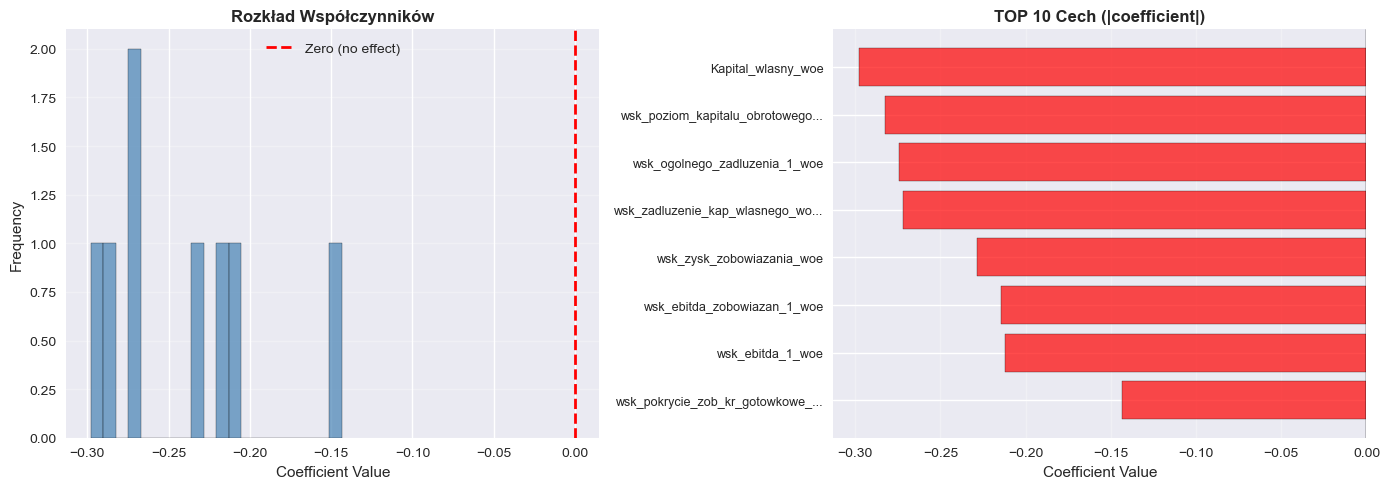


3️⃣ INFORMATION VALUE - SIŁA PREDYKCYJNA

📊 INFORMATION VALUE - Cechy w modelu (8 cech):
   ⚠️  IV obliczone na TRAIN set (prawidłowe - to metryka jakości cechy)

Rank   Feature                                               IV Moc Predykcyjna          
------------------------------------------------------------------------------------------
1      Kapital_wlasny                                    0.4848 ✓✓ Strong                
2      wsk_ebitda_zobowiazan_1                           0.4796 ✓✓ Strong                
3      wsk_poziom_kapitalu_obrotowego_netto              0.4390 ✓✓ Strong                
4      wsk_pokrycie_zob_kr_gotowkowe_1                   0.4268 ✓✓ Strong                
5      wsk_ogolnego_zadluzenia_1                         0.4016 ✓✓ Strong                
6      wsk_zadluzenie_kap_wlasnego                       0.4016 ✓✓ Strong                
7      wsk_zysk_zobowiazania                             0.4012 ✓✓ Strong                
8      wsk_ebitda_1      

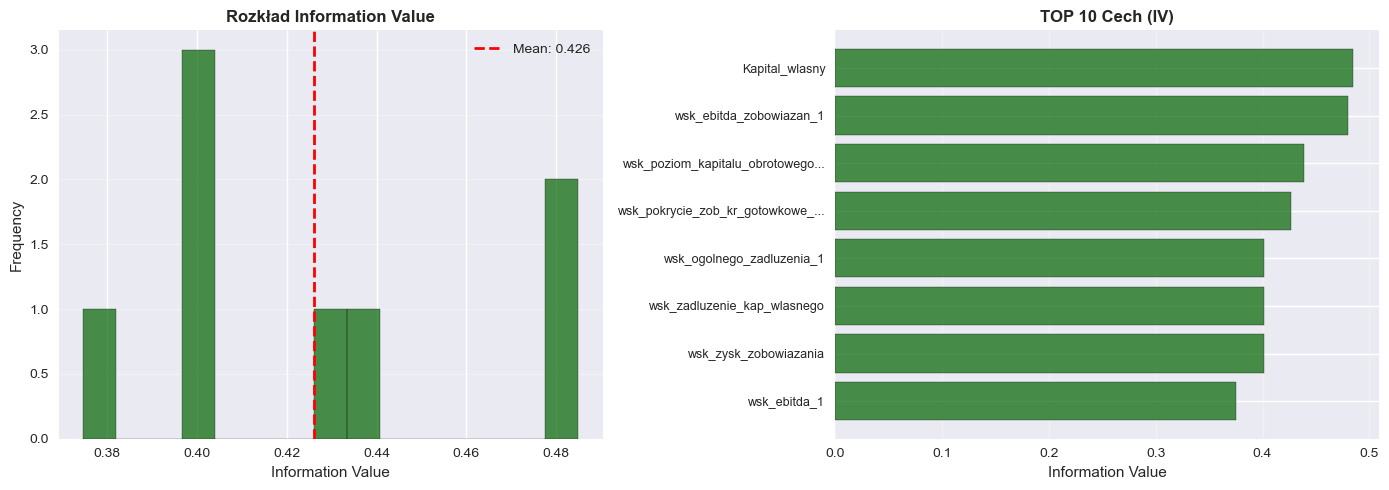


4️⃣ PARTIAL DEPENDENCE PLOTS (PDP) - ZBIÓR TESTOWY

💡 Co pokazuje PDP?
   • ŚREDNI wpływ cechy na predykcję (na niewidzianych danych!)
   • Jak zmiana wartości cechy wpływa na przewidywane PD
   • Obliczony na 900 obserwacjach TEST set



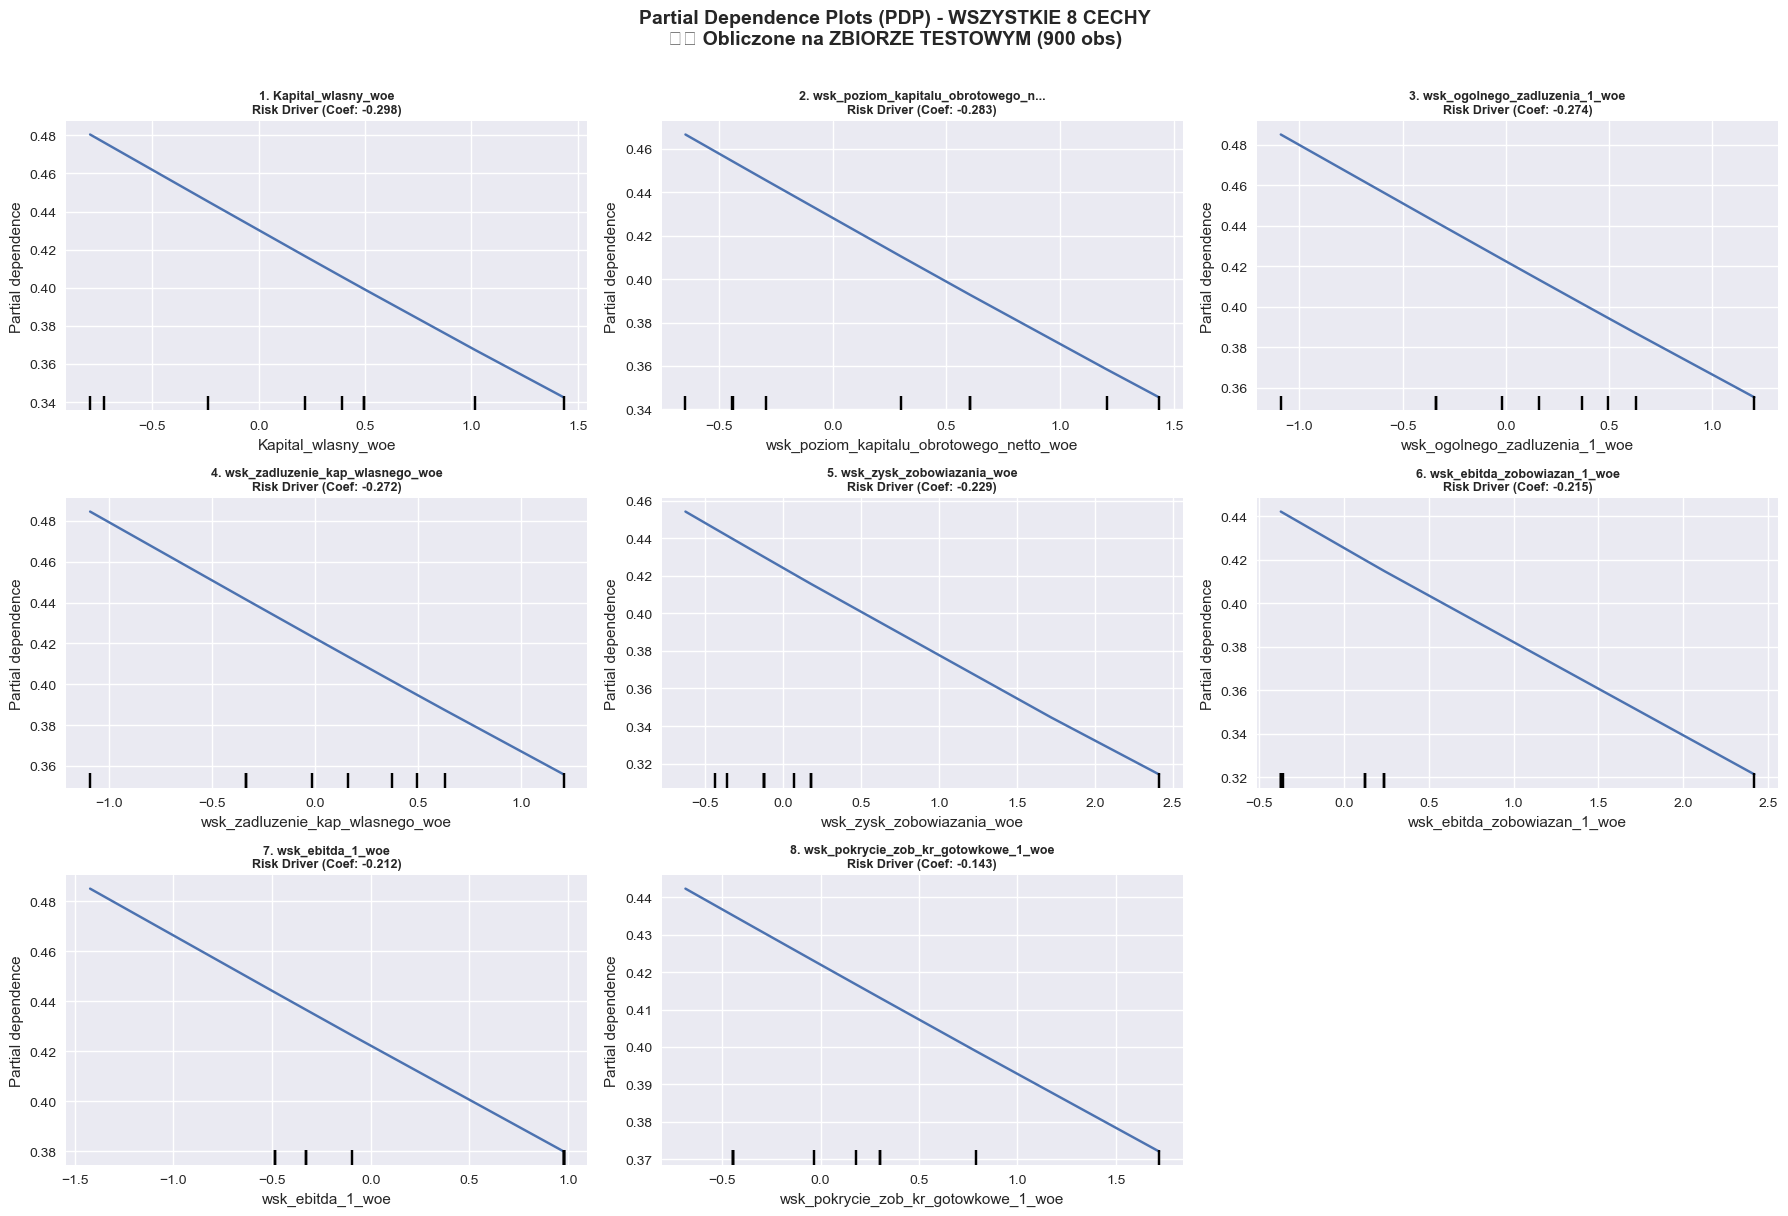


💡 Interpretacja PDP:
   - Oś X: wartość WoE cechy
   - Oś Y: zmiana log-odds (predykcja)
   - Nachylenie = siła i kierunek efektu
   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych

5️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY
--------------------------------------------------------------------------------
ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację
Używam 100 losowych obserwacji z TEST set


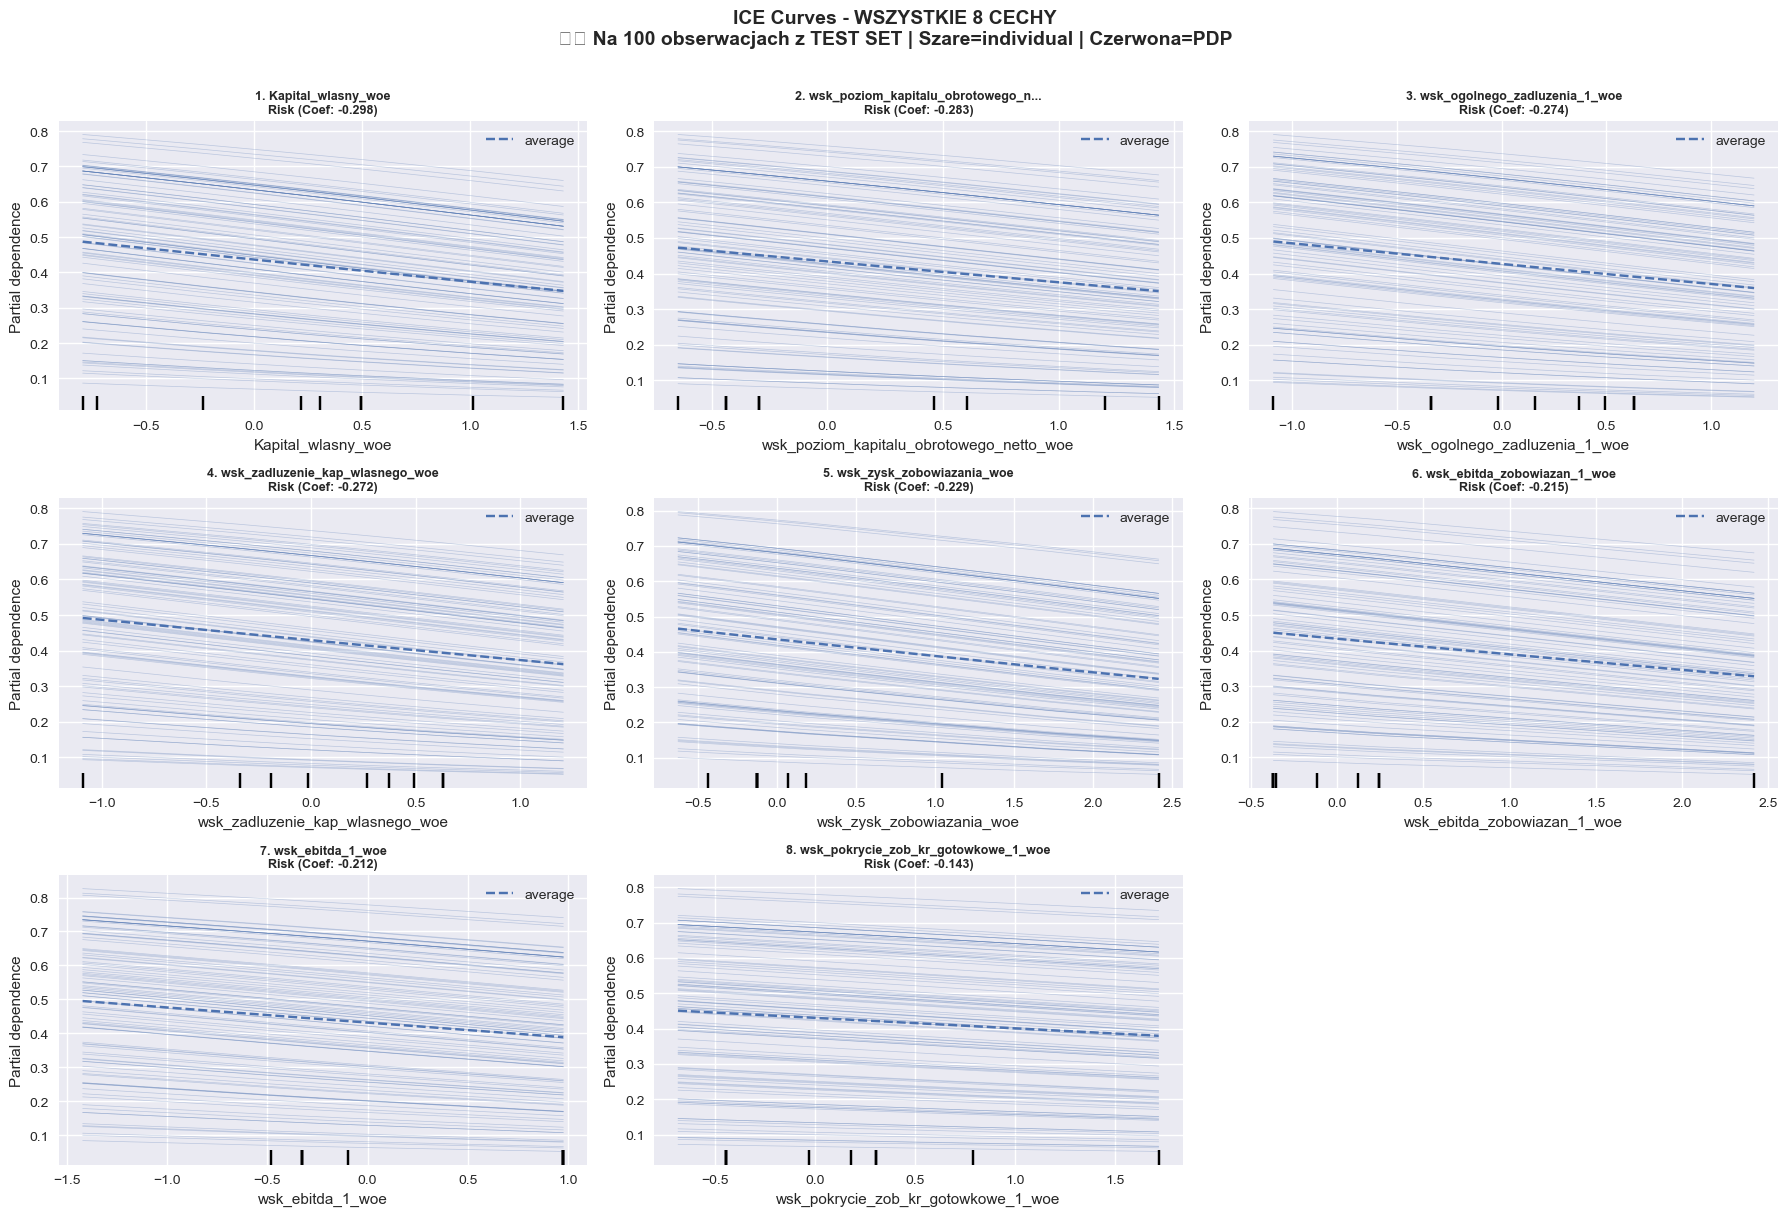


💡 Interpretacja ICE:
   - Każda szara linia = jedna obserwacja z TEST set
   - Czerwona linia = PDP (średnia ICE)
   - Równoległe linie → efekt homogeniczny
   - Rozjechane linie → efekt heterogeniczny

6️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu
--------------------------------------------------------------------------------
C-ICE = ICE wycentrowane w punkcie odniesienia


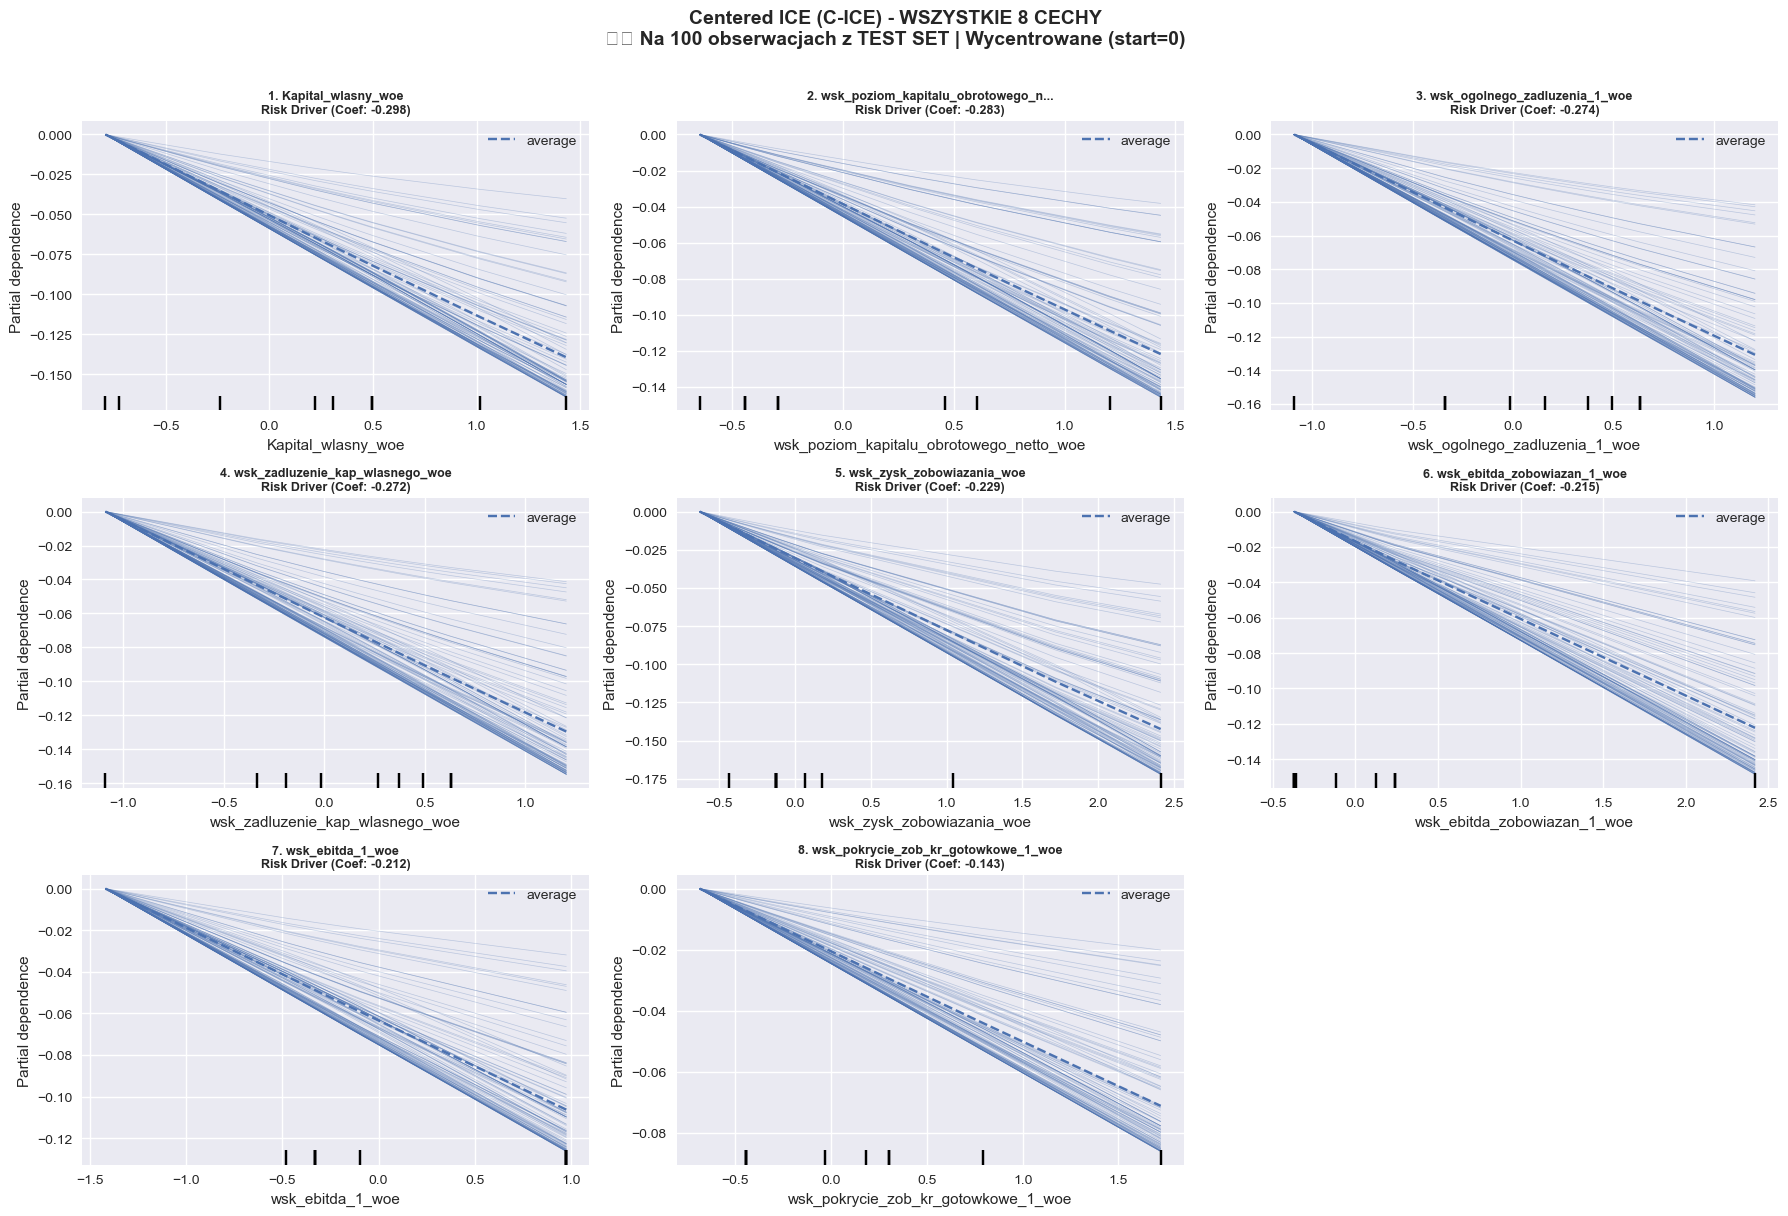


💡 Interpretacja C-ICE:
   - Wszystkie linie zaczynają się w 0
   - Małe rozjechanie → efekt ADDYTYWNY
   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)

7️⃣ PODSUMOWANIE GLOBALNEJ INTERPRETOWALNOŚCI

📊 WYKONANE ANALIZY:
   1️⃣ Współczynniki regresji logistycznej (log-odds)
   2️⃣ Szczegółowa interpretacja biznesowa współczynników
   3️⃣ Information Value - siła predykcyjna cech
   4️⃣ PDP - średni wpływ cech na predykcję
   5️⃣ ICE - indywidualne ścieżki predykcji
   6️⃣ C-ICE - analiza heterogeniczności efektu

🏆 ZASTOSOWANIE W CREDIT SCORING:
   • Współczynniki → bezpośrednia interpretacja wpływu na PD
   • IV → selekcja cech o wysokiej mocy predykcyjnej
   • PDP → 'średni efekt cechy' dla biznesu
   • ICE → weryfikacja stabilności efektu
   • C-ICE → sprawdzenie addytywności modelu

✅ SPEŁNIONE WYMOGI:
   ✓ Analiza współczynników dla WSZYSTKICH 8 cech
   ✓ Information Value dla WSZYSTKICH 8 cech
   ✓ PDP dla WSZYSTKICH 8 cech
   ✓ ICE dla WSZYSTKICH 8 cech
   ✓ C-ICE dla WSZ

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)")
print("="*80)
print("\nAnaliza wpływu cech na predykcję probability of default (PD)")
print("Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE")
print("⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)")
print("="*80)

# ============================================================================
# WYBÓR MODELU: ZAWSZE BASIC SCORECARD (pełna interpretowalność!)
# ============================================================================
best_scorecard = scorecard_basic
X_test_best = X_test_woe_basic
woe_mappings_best = woe_mappings_basic
model_name = "Basic Scorecard (W pełni interpretowalny)"

roc_auc_best = roc_auc_score(y_test_sc, best_scorecard.predict_proba(X_test_best)[:, 1])

print(f"\n🎯 WYBRANY MODEL: {model_name}")
print("-" * 80)
print(f"   Liczba cech:     {X_test_best.shape[1]}")
print(f"   ROC-AUC (test):  {roc_auc_best:.4f}")
print(f"   Obs TEST:        {X_test_best.shape[0]} (używane do PDP/ICE)")
print(f"\n   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!")
print(f"   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)")

# ============================================================================
# 1. ANALIZA WSPÓŁCZYNNIKÓW I LOG-ODDS
# ============================================================================
print("\n" + "="*80)
print("1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)")
print("="*80)
print("\nInterpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę")
print("• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)")
print("• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)\n")

coef_df = pd.DataFrame({
    'Feature': X_test_best.columns.tolist(),
    'Coefficient': best_scorecard.coef_[0],
    'Abs_Coef': np.abs(best_scorecard.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print(f"📊 TOP 10 CECH (według |coefficient|):\n")
for i, (idx, row) in enumerate(coef_df.head(10).iterrows(), 1):
    feat = row['Feature']
    coef = row['Coefficient']
    direction = "📈 PROTECTIVE" if coef > 0 else "📉 RISK DRIVER"
    
    if abs(coef) > 0.5: strength = "🔥 Bardzo silny"
    elif abs(coef) > 0.3: strength = "💪 Silny"
    elif abs(coef) > 0.15: strength = "✓ Średni"
    else: strength = "• Słaby"
    
    feat_display = feat if len(feat) <= 42 else feat[:39] + "..."
    print(f"   {i:2}. {feat_display:<45} | Coef: {coef:>7.4f} | {direction:15} | {strength}")

print(f"\n📐 Statystyki współczynników:")
print(f"   Mean |coef|:     {coef_df['Abs_Coef'].mean():.4f}")
print(f"   Std Dev:         {coef_df['Coefficient'].std():.4f}")
print(f"   Max |coef|:      {coef_df['Abs_Coef'].max():.4f}")
print(f"   Intercept:       {best_scorecard.intercept_[0]:.4f}")

all_features = coef_df['Feature'].tolist()
n_features = len(all_features)
print(f"\n🔍 WSZYSTKIE {n_features} cech zostaną przeanalizowane w PDP/ICE (na TEST set)")

all_feature_indices = [X_test_best.columns.get_loc(feat) for feat in all_features]

# ============================================================================
# 2. SZCZEGÓŁOWA ANALIZA WSPÓŁCZYNNIKÓW - INTERPRETACJA BIZNESOWA
# ============================================================================
print("\n" + "="*80)
print("2️⃣ SZCZEGÓŁOWA ANALIZA WSPÓŁCZYNNIKÓW - INTERPRETACJA BIZNESOWA")
print("="*80)

coef_analysis = coef_df.copy().sort_values('Abs_Coef', ascending=False)

print(f"\n📊 WSZYSTKIE WSPÓŁCZYNNIKI ({len(coef_analysis)} cech):\n")
print(f"{'Rank':<6} {'Feature':<45} {'Coefficient':>12} {'Direction':<15} {'Log-Odds Impact':<20}")
print("-" * 100)

for i, (idx, row) in enumerate(coef_analysis.iterrows(), 1):
    feat = row['Feature']
    coef = row['Coefficient']
    direction = "✅ Protective" if coef > 0 else "⚠️  Risk Driver"
    impact = "↑WoE → ↓PD" if coef > 0 else "↑WoE → ↑PD"
    feat_display = feat if len(feat) <= 43 else feat[:40] + "..."
    print(f"{i:<6} {feat_display:<45} {coef:>12.4f} {direction:<15} {impact:<20}")

n_positive = (coef_analysis['Coefficient'] > 0).sum()
n_negative = (coef_analysis['Coefficient'] < 0).sum()

print(f"\n📊 ROZKŁAD KIERUNKÓW WPŁYWU:")
print(f"   • Protective (coef > 0):  {n_positive} cech ({n_positive/len(coef_analysis)*100:.1f}%)")
print(f"   • Risk Drivers (coef < 0): {n_negative} cech ({n_negative/len(coef_analysis)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(coef_analysis['Coefficient'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (no effect)')
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Rozkład Współczynników', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

top10_coef = coef_analysis.head(10)
colors = ['green' if c > 0 else 'red' for c in top10_coef['Coefficient']]
feat_names_short = [f[:30] + '...' if len(f) > 30 else f for f in top10_coef['Feature']]

axes[1].barh(range(len(top10_coef)), top10_coef['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(top10_coef)))
axes[1].set_yticklabels(feat_names_short, fontsize=9)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('TOP 10 Cech (|coefficient|)', fontsize=12, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ============================================================================
# 3. INFORMATION VALUE (IV) - SIŁA PREDYKCYJNA CECH
# ============================================================================
print("\n" + "="*80)
print("3️⃣ INFORMATION VALUE - SIŁA PREDYKCYJNA")
print("="*80)

if 'iv_df_basic' in globals():
    iv_data_current = iv_df_basic.copy()
    features_in_model = [f.replace('_woe', '') for f in X_test_best.columns if f.endswith('_woe')]
    iv_model = iv_data_current[iv_data_current['feature'].isin(features_in_model)].copy()
    iv_model = iv_model.sort_values('IV', ascending=False)
    
    print(f"\n📊 INFORMATION VALUE - Cechy w modelu ({len(iv_model)} cech):")
    print(f"   ⚠️  IV obliczone na TRAIN set (prawidłowe - to metryka jakości cechy)\n")
    print(f"{'Rank':<6} {'Feature':<45} {'IV':>10} {'Moc Predykcyjna':<25}")
    print("-" * 90)
    
    for i, (idx, row) in enumerate(iv_model.iterrows(), 1):
        feat = row['feature']
        iv = row['IV']
        
        if iv < 0.02: power = "❌ Unpredictive"
        elif iv < 0.1: power = "⚠️  Weak"
        elif iv < 0.3: power = "✓ Medium"
        elif iv < 0.5: power = "✓✓ Strong"
        else: power = "✓✓✓ Very Strong"
        
        feat_display = feat if len(feat) <= 43 else feat[:40] + "..."
        print(f"{i:<6} {feat_display:<45} {iv:>10.4f} {power:<25}")
    
    print(f"\n📊 STATYSTYKI IV:")
    print(f"   • Średnia IV:  {iv_model['IV'].mean():.4f}")
    print(f"   • Max IV:      {iv_model['IV'].max():.4f}  (cecha: {iv_model.iloc[0]['feature']})")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(iv_model['IV'], bins=15, alpha=0.7, color='darkgreen', edgecolor='black')
    axes[0].axvline(iv_model['IV'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {iv_model["IV"].mean():.3f}')
    axes[0].set_xlabel('Information Value', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Rozkład Information Value', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3, axis='y')
    
    top10_iv = iv_model.head(10)
    feat_names_short = [f[:30] + '...' if len(f) > 30 else f for f in top10_iv['feature']]
    colors_iv = ['darkgreen' if iv >= 0.3 else 'orange' if iv >= 0.1 else 'red' for iv in top10_iv['IV']]
    
    axes[1].barh(range(len(top10_iv)), top10_iv['IV'], color=colors_iv, alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(top10_iv)))
    axes[1].set_yticklabels(feat_names_short, fontsize=9)
    axes[1].set_xlabel('Information Value', fontsize=11)
    axes[1].set_title('TOP 10 Cech (IV)', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Brak danych IV!")

# ============================================================================
# 4. PARTIAL DEPENDENCE PLOTS (PDP) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("4️⃣ PARTIAL DEPENDENCE PLOTS (PDP) - ZBIÓR TESTOWY")
print("="*80)
print("\n💡 Co pokazuje PDP?")
print("   • ŚREDNI wpływ cechy na predykcję (na niewidzianych danych!)")
print("   • Jak zmiana wartości cechy wpływa na przewidywane PD")
print(f"   • Obliczony na {len(X_test_best)} obserwacjach TEST set\n")

n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_test_best,
        features=[feat_idx],
        kind='average',
        ax=axes[idx],
        grid_resolution=50
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('PDP (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Partial Dependence Plots (PDP) - WSZYSTKIE {n_features} CECHY\n⚠️ Obliczone na ZBIORZE TESTOWYM ({len(X_test_best)} obs)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja PDP:")
print("   - Oś X: wartość WoE cechy")
print("   - Oś Y: zmiana log-odds (predykcja)")
print("   - Nachylenie = siła i kierunek efektu")
print("   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych")

# ============================================================================
# 5. ICE CURVES - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("5️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY")
print("-" * 80)
print("ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację")

sample_size = min(100, len(X_test_best))
sample_indices = np.random.choice(len(X_test_best), size=sample_size, replace=False)
X_sample = X_test_best.iloc[sample_indices]

print(f"Używam {sample_size} losowych obserwacji z TEST set")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,
        features=[feat_idx],
        kind='both',
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('ICE (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'ICE Curves - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Szare=individual | Czerwona=PDP', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja ICE:")
print("   - Każda szara linia = jedna obserwacja z TEST set")
print("   - Czerwona linia = PDP (średnia ICE)")
print("   - Równoległe linie → efekt homogeniczny")
print("   - Rozjechane linie → efekt heterogeniczny")

# ============================================================================
# 6. CENTERED ICE (C-ICE) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("6️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu")
print("-" * 80)
print("C-ICE = ICE wycentrowane w punkcie odniesienia")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,
        features=[feat_idx],
        kind='both',
        centered=True,
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."

    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})",
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('C-ICE (centered)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Centered ICE (C-ICE) - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Wycentrowane (start=0)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja C-ICE:")
print("   - Wszystkie linie zaczynają się w 0")
print("   - Małe rozjechanie → efekt ADDYTYWNY")
print("   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)")

# ============================================================================
# 7. PODSUMOWANIE
# ============================================================================
print("\n" + "="*80)
print("7️⃣ PODSUMOWANIE GLOBALNEJ INTERPRETOWALNOŚCI")
print("="*80)

print("\n📊 WYKONANE ANALIZY:")
print("   1️⃣ Współczynniki regresji logistycznej (log-odds)")
print("   2️⃣ Szczegółowa interpretacja biznesowa współczynników")
print("   3️⃣ Information Value - siła predykcyjna cech")
print("   4️⃣ PDP - średni wpływ cech na predykcję")
print("   5️⃣ ICE - indywidualne ścieżki predykcji")
print("   6️⃣ C-ICE - analiza heterogeniczności efektu")

print("\n🏆 ZASTOSOWANIE W CREDIT SCORING:")
print("   • Współczynniki → bezpośrednia interpretacja wpływu na PD")
print("   • IV → selekcja cech o wysokiej mocy predykcyjnej")
print("   • PDP → 'średni efekt cechy' dla biznesu")
print("   • ICE → weryfikacja stabilności efektu")
print("   • C-ICE → sprawdzenie addytywności modelu")

print(f"\n✅ SPEŁNIONE WYMOGI:")
print(f"   ✓ Analiza współczynników dla WSZYSTKICH {n_features} cech")
print(f"   ✓ Information Value dla WSZYSTKICH {n_features} cech")
print(f"   ✓ PDP dla WSZYSTKICH {n_features} cech")
print(f"   ✓ ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ C-ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ Model: BASIC SCORECARD (w pełni interpretowalny)")
print(f"   ✓ ⚠️  WSZYSTKO NA ZBIORZE TESTOWYM ({len(X_test_best)} obs)")
print(f"   → Requirement 3.3 (PDP/ICE curves) DONE!")
print("="*80)

---

## 22. Interpretacja Lokalna - Case Studies


W tej sekcji przeanalizujemy szczegółowo **5 wybranych przypadków** z test setu, aby pokazać:
- **Jak model podejmuje decyzje** dla konkretnych klientów
- **Wkład każdej cechy** do finalnego skoru (waterfall charts)
- **Interpretację biznesową**: DLACZEGO model sklasyfikował klienta w taki sposób


In [ ]:
# FIX: Normalizacja struktury woe_mappings_basic
# Zmienia {'table': ..., 'bins': ...} na {'woe_table': ..., 'bins': ...}
print("🔧 Normalizacja struktury woe_mappings_basic...")

if 'woe_mappings_basic' in dir():
    for feat in woe_mappings_basic:
        if 'table' in woe_mappings_basic[feat] and 'woe_table' not in woe_mappings_basic[feat]:
            woe_mappings_basic[feat]['woe_table'] = woe_mappings_basic[feat]['table']
    print("✓ Struktura znormalizowana")
else:
    print("⚠ Brak woe_mappings_basic - counterfactuals będą pominięte")

🔧 Normalizacja struktury woe_mappings_basic...
✓ Struktura znormalizowana


Importujemy wszystkie potrzebne biblioteki do analizy i modelowania.

🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)

Analiza wpływu cech na predykcję probability of default (PD)
Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE
⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)

🎯 WYBRANY MODEL: Basic Scorecard (W pełni interpretowalny)
--------------------------------------------------------------------------------
   Liczba cech:     8
   ROC-AUC (test):  0.7554
   Obs TEST:        900 (używane do PDP/ICE)

   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!
   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)

1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)

Interpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę
• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)
• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)

📊 TOP 10 CECH (według |coefficient|):

    1. Kapital_wlasny_woe                            | Coef: -0.2979 | 📉 RISK DRIVER   | ✓ Średni
    2. ws

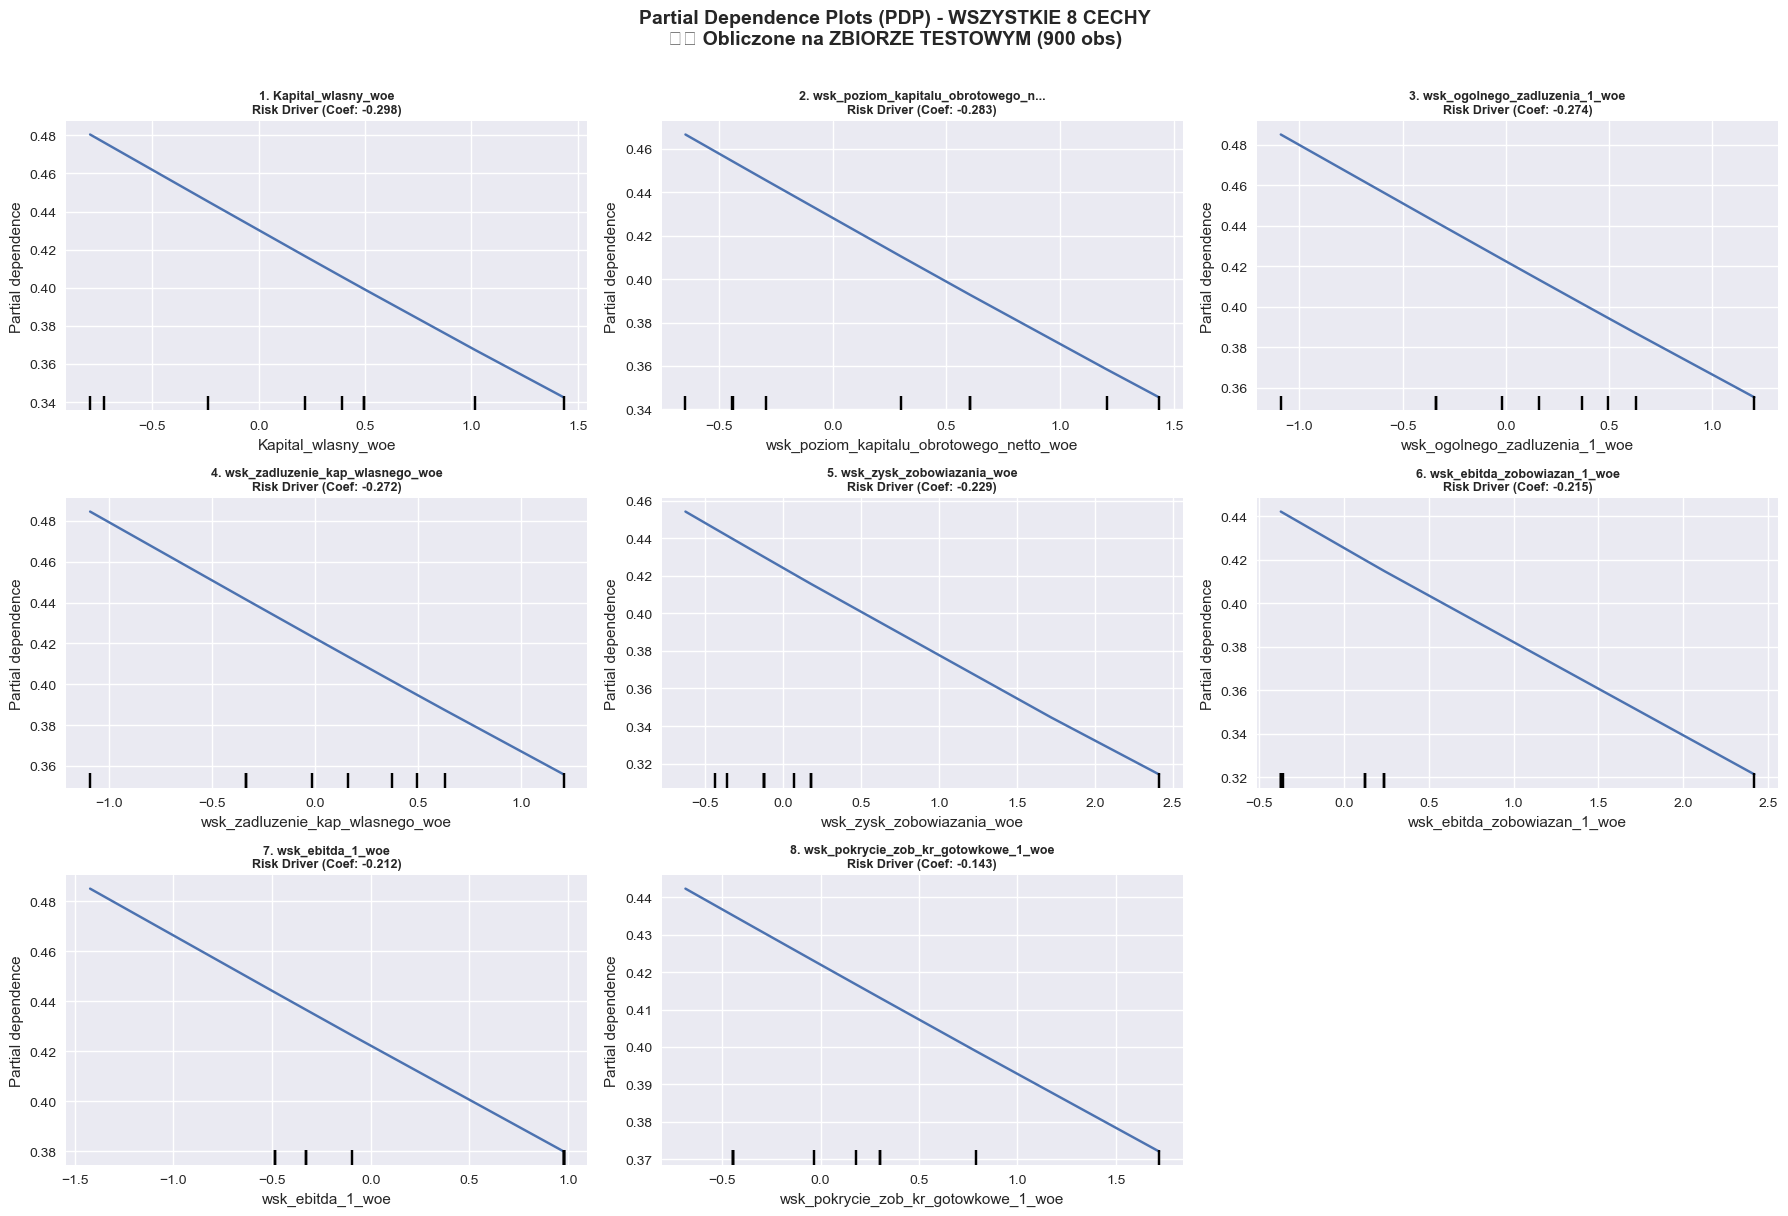


💡 Interpretacja PDP:
   - Oś X: wartość WoE cechy
   - Oś Y: zmiana log-odds (predykcja)
   - Nachylenie = siła i kierunek efektu
   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych

3️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY
--------------------------------------------------------------------------------
ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację
Używam 100 losowych obserwacji z TEST set


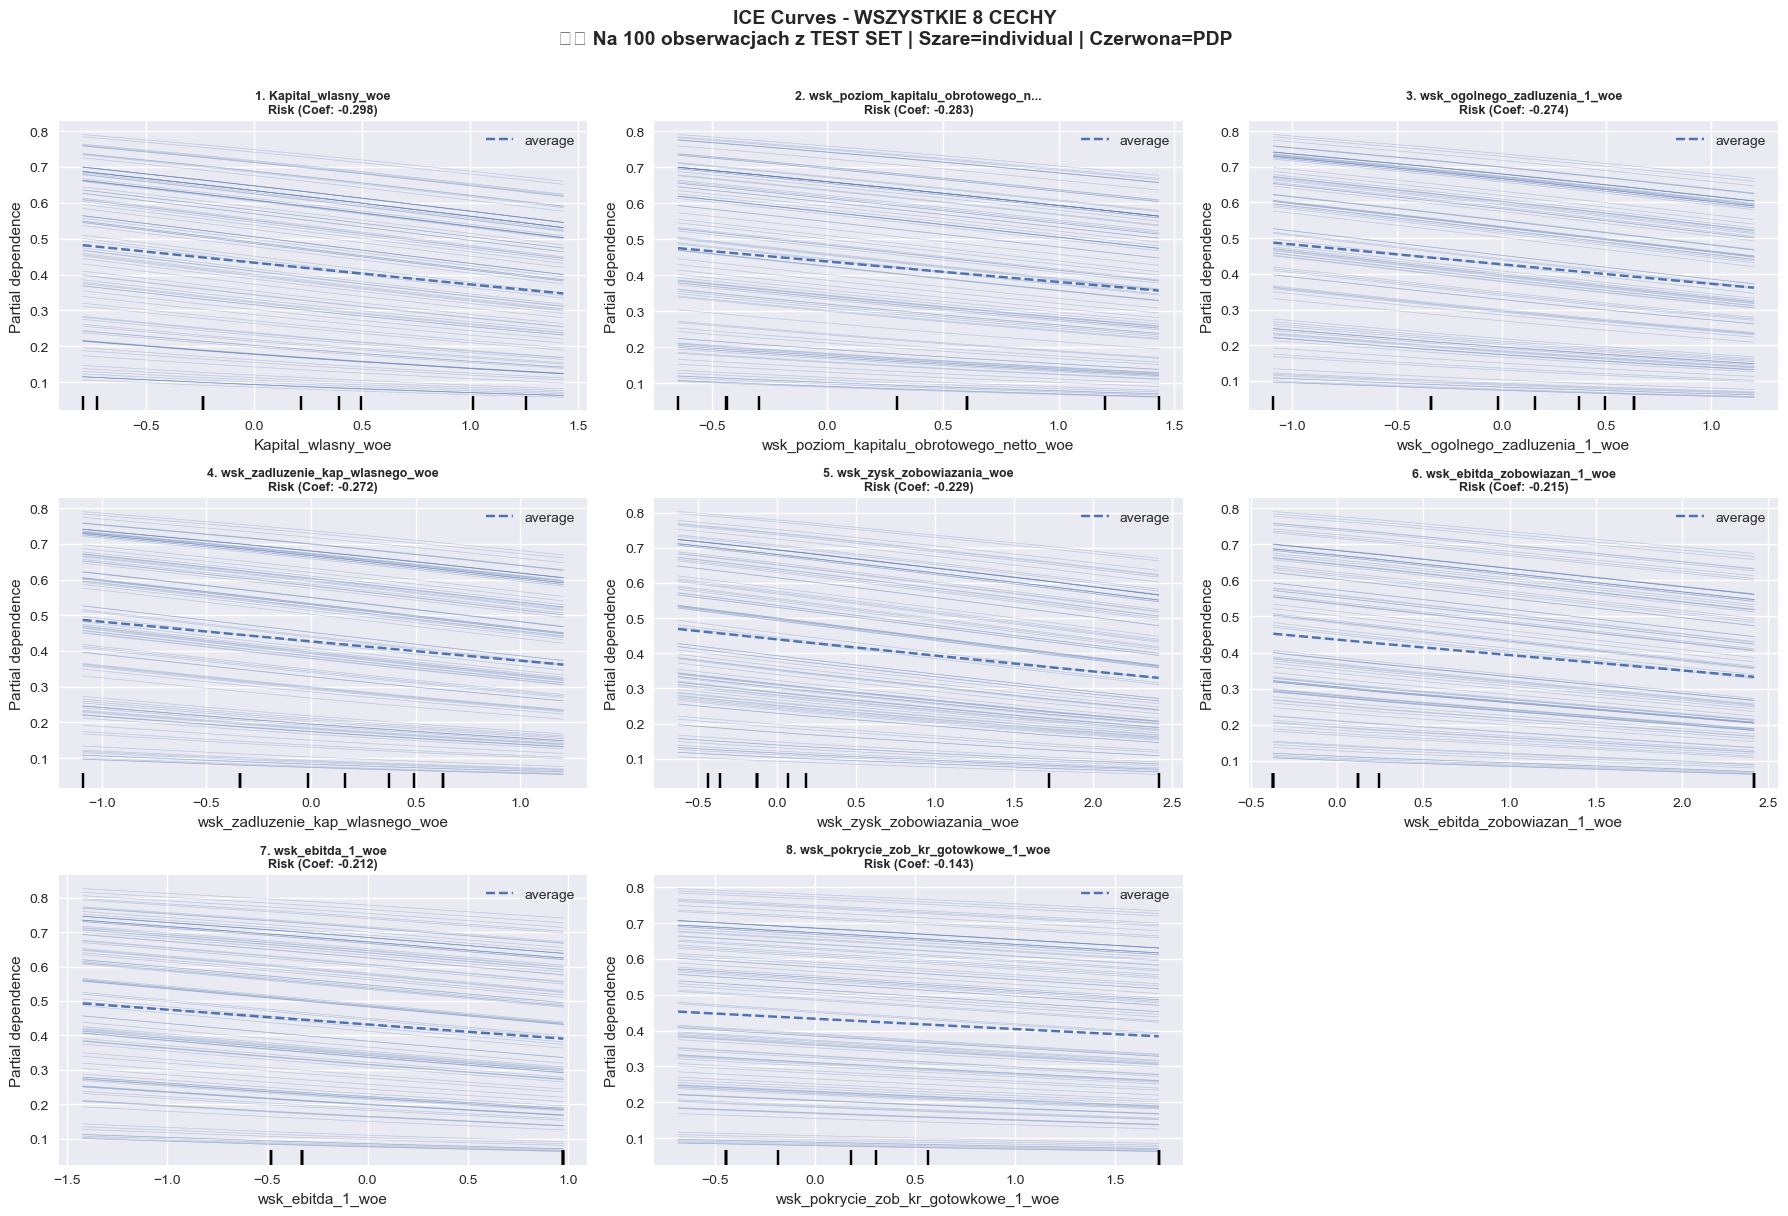


💡 Interpretacja ICE:
   - Każda szara linia = jedna obserwacja z TEST set
   - Czerwona linia = PDP (średnia ICE)
   - Równoległe linie → efekt homogeniczny
   - Rozjechane linie → efekt heterogeniczny

4️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu
--------------------------------------------------------------------------------
C-ICE = ICE wycentrowane w punkcie odniesienia


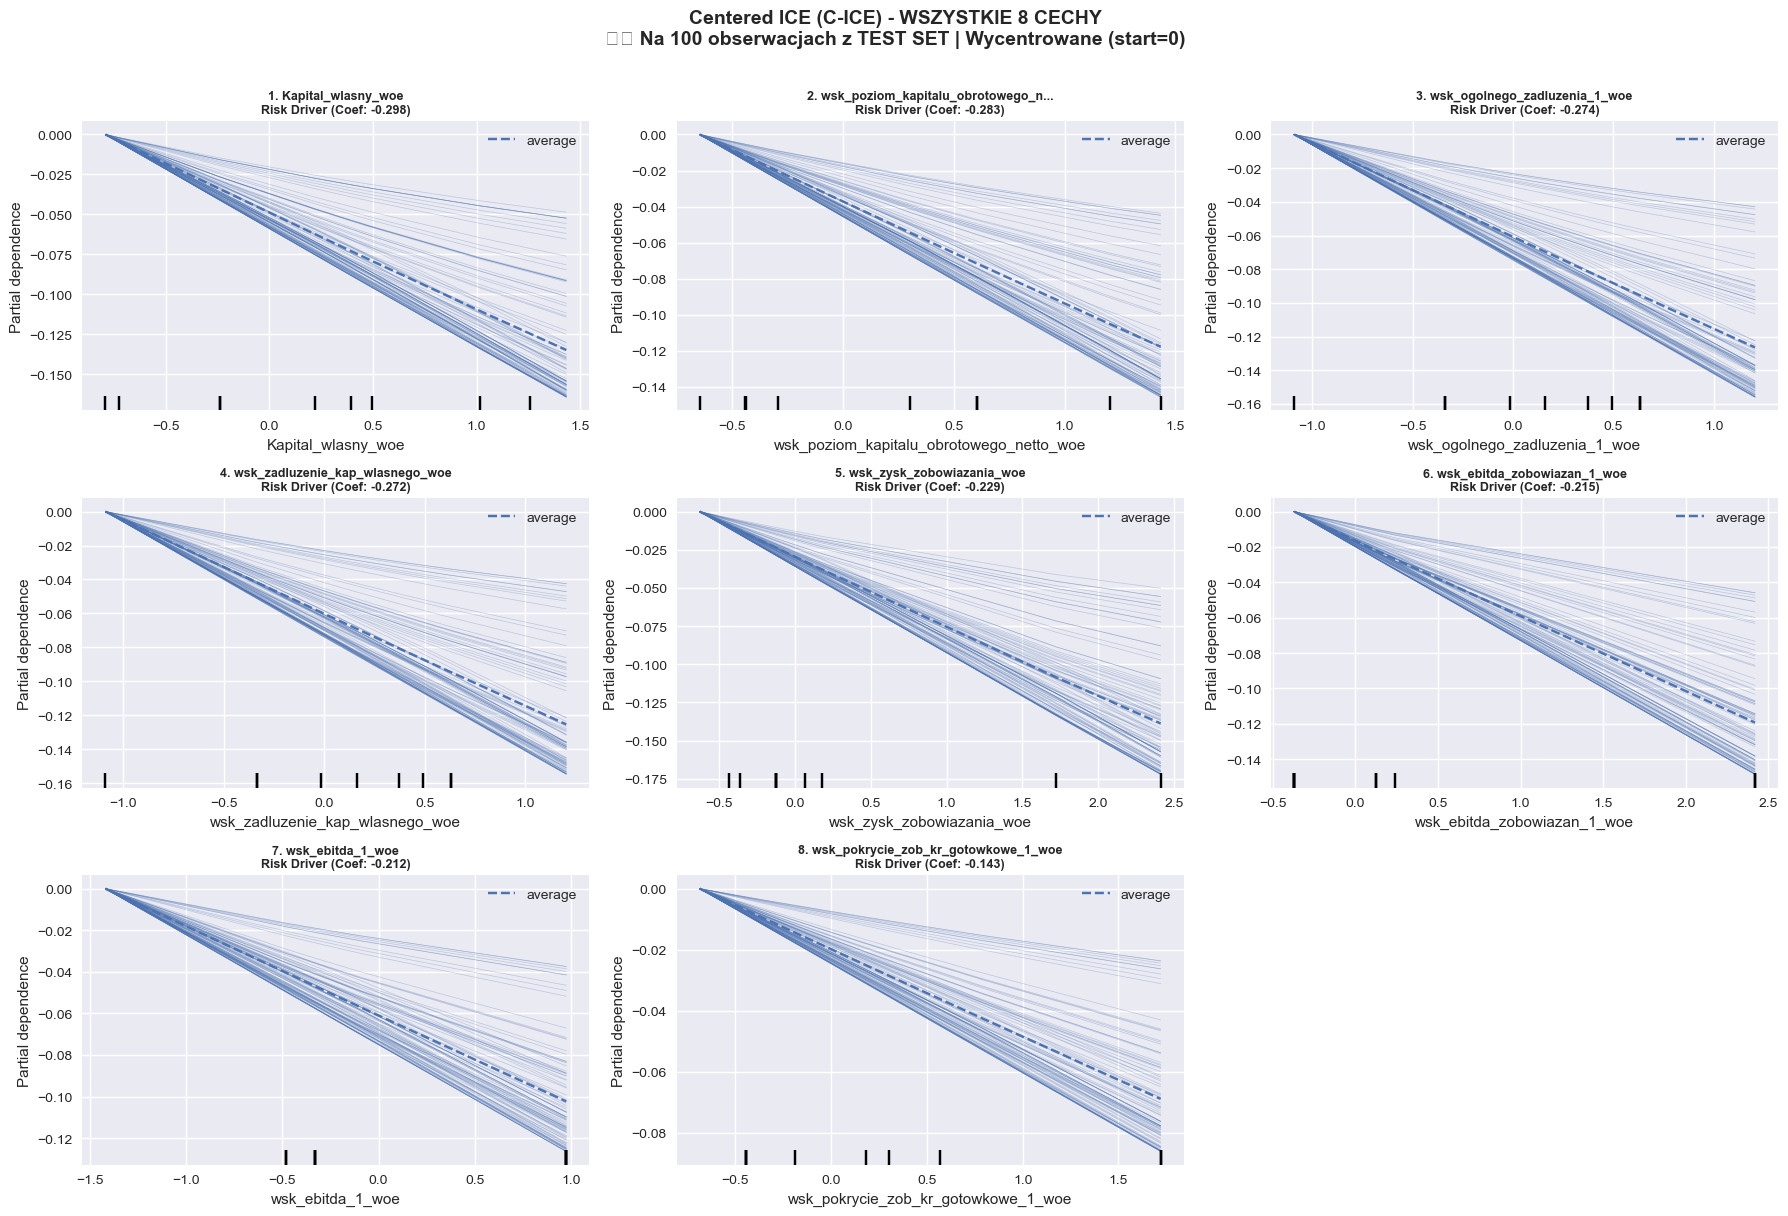


💡 Interpretacja C-ICE:
   - Wszystkie linie zaczynają się w 0
   - Małe rozjechanie → efekt ADDYTYWNY
   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)

5️⃣ PODSUMOWANIE: PDP vs ICE vs C-ICE

📊 PDP: Pokazuje ŚREDNI efekt cechy
📈 ICE: Pokazuje efekt dla KAŻDEJ obserwacji
🎯 C-ICE: ICE wycentrowane → diagnozuje interakcje

🏆 ZASTOSOWANIE W CREDIT SCORING:
   1. PDP → 'średni efekt cechy' dla biznesu
   2. ICE → weryfikacja stabilności efektu
   3. C-ICE → sprawdzenie addytywności modelu

✅ SPEŁNIONE WYMOGI:
   ✓ PDP dla WSZYSTKICH 8 cech
   ✓ ICE dla WSZYSTKICH 8 cech
   ✓ C-ICE dla WSZYSTKICH 8 cech
   ✓ Model: BASIC SCORECARD (w pełni interpretowalny)
   ✓ ⚠️  WSZYSTKO NA ZBIORZE TESTOWYM (900 obs)
   → Requirement 3.3 (PDP/ICE curves) DONE!


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)")
print("="*80)
print("\nAnaliza wpływu cech na predykcję probability of default (PD)")
print("Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE")
print("⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)")
print("="*80)

# ============================================================================
# BASIC SCORECARD
# ============================================================================
best_scorecard = scorecard_basic
X_test_best = X_test_woe_basic  # ← ZBIÓR TESTOWY!
woe_mappings_best = woe_mappings_basic
model_name = "Basic Scorecard (W pełni interpretowalny)"

# Wyświetl informacje o modelu - POPRAWKA: y_test_sc zamiast y_test
roc_auc_best = roc_auc_score(y_test_sc, best_scorecard.predict_proba(X_test_best)[:, 1])

print(f"\n🎯 WYBRANY MODEL: {model_name}")
print("-" * 80)
print(f"   Liczba cech:     {X_test_best.shape[1]}")
print(f"   ROC-AUC (test):  {roc_auc_best:.4f}")
print(f"   Obs TEST:        {X_test_best.shape[0]} (używane do PDP/ICE)")
print(f"\n   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!")
print(f"   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)")


# ============================================================================
# 1. ANALIZA WSPÓŁCZYNNIKÓW I LOG-ODDS
# ============================================================================
print("\n" + "="*80)
print("1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)")
print("="*80)
print("\nInterpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę")
print("• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)")
print("• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)\n")

# Analiza współczynników
coef_df = pd.DataFrame({
    'Feature': X_test_best.columns.tolist(),
    'Coefficient': best_scorecard.coef_[0],
    'Abs_Coef': np.abs(best_scorecard.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print(f"📊 TOP 10 CECH (według |coefficient|):\n")
for i, (idx, row) in enumerate(coef_df.head(10).iterrows(), 1):
    feat = row['Feature']
    coef = row['Coefficient']
    direction = "📈 PROTECTIVE" if coef > 0 else "📉 RISK DRIVER"
    
    if abs(coef) > 0.5: strength = "🔥 Bardzo silny"
    elif abs(coef) > 0.3: strength = "💪 Silny"
    elif abs(coef) > 0.15: strength = "✓ Średni"
    else: strength = "• Słaby"
    
    feat_display = feat if len(feat) <= 42 else feat[:39] + "..."
    print(f"   {i:2}. {feat_display:<45} | Coef: {coef:>7.4f} | {direction:15} | {strength}")

print(f"\n📐 Statystyki współczynników:")
print(f"   Mean |coef|:     {coef_df['Abs_Coef'].mean():.4f}")
print(f"   Std Dev:         {coef_df['Coefficient'].std():.4f}")
print(f"   Max |coef|:      {coef_df['Abs_Coef'].max():.4f}")
print(f"   Intercept:       {best_scorecard.intercept_[0]:.4f}")

# WSZYSTKIE cechy
all_features = coef_df['Feature'].tolist()
n_features = len(all_features)
print(f"\n🔍 WSZYSTKIE {n_features} cech zostaną przeanalizowane w PDP/ICE (na TEST set)")

all_feature_indices = [X_test_best.columns.get_loc(feat) for feat in all_features]

# ============================================================================
# 2. PARTIAL DEPENDENCE PLOTS (PDP) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("2️⃣ PARTIAL DEPENDENCE PLOTS (PDP) - ZBIÓR TESTOWY")
print("="*80)
print("\n💡 Co pokazuje PDP?")
print("   • ŚREDNI wpływ cechy na predykcję (na niewidzianych danych!)")
print("   • Jak zmiana wartości cechy wpływa na przewidywane PD")
print(f"   • Obliczony na {len(X_test_best)} obserwacjach TEST set\n")

n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_test_best,  # ← ZBIÓR TESTOWY!
        features=[feat_idx],
        kind='average',
        ax=axes[idx],
        grid_resolution=50
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('PDP (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Partial Dependence Plots (PDP) - WSZYSTKIE {n_features} CECHY\n⚠️ Obliczone na ZBIORZE TESTOWYM ({len(X_test_best)} obs)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja PDP:")
print("   - Oś X: wartość WoE cechy")
print("   - Oś Y: zmiana log-odds (predykcja)")
print("   - Nachylenie = siła i kierunek efektu")
print("   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych")

# ============================================================================
# 3. ICE CURVES - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("3️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY")
print("-" * 80)
print("ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację")

# Sample z TEST set
sample_size = min(100, len(X_test_best))
sample_indices = np.random.choice(len(X_test_best), size=sample_size, replace=False)
X_sample = X_test_best.iloc[sample_indices]  # ← SAMPLE Z TEST SET!

print(f"Używam {sample_size} losowych obserwacji z TEST set")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,  # ← SAMPLE Z TEST SET!
        features=[feat_idx],
        kind='both',
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('ICE (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'ICE Curves - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Szare=individual | Czerwona=PDP', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja ICE:")
print("   - Każda szara linia = jedna obserwacja z TEST set")
print("   - Czerwona linia = PDP (średnia ICE)")
print("   - Równoległe linie → efekt homogeniczny")
print("   - Rozjechane linie → efekt heterogeniczny")

# ============================================================================
# 4. CENTERED ICE (C-ICE) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("4️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu")
print("-" * 80)
print("C-ICE = ICE wycentrowane w punkcie odniesienia")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,  # ← SAMPLE Z TEST SET!
        features=[feat_idx],
        kind='both',
        centered=True,
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."

    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})",
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('C-ICE (centered)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Centered ICE (C-ICE) - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Wycentrowane (start=0)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja C-ICE:")
print("   - Wszystkie linie zaczynają się w 0")
print("   - Małe rozjechanie → efekt ADDYTYWNY")
print("   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)")

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n" + "="*80)
print("5️⃣ PODSUMOWANIE: PDP vs ICE vs C-ICE")
print("="*80)

print("\n📊 PDP: Pokazuje ŚREDNI efekt cechy")
print("📈 ICE: Pokazuje efekt dla KAŻDEJ obserwacji")
print("🎯 C-ICE: ICE wycentrowane → diagnozuje interakcje")

print("\n🏆 ZASTOSOWANIE W CREDIT SCORING:")
print("   1. PDP → 'średni efekt cechy' dla biznesu")
print("   2. ICE → weryfikacja stabilności efektu")
print("   3. C-ICE → sprawdzenie addytywności modelu")

print(f"\n✅ SPEŁNIONE WYMOGI:")
print(f"   ✓ PDP dla WSZYSTKICH {n_features} cech")
print(f"   ✓ ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ C-ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ Model: BASIC SCORECARD (w pełni interpretowalny)")
print(f"   ✓ ⚠️  WSZYSTKO NA ZBIORZE TESTOWYM ({len(X_test_best)} obs)")
print(f"   → Requirement 3.3 (PDP/ICE curves) DONE!")
print("="*80)

## Kalibracja modelu — od diagnostyki do finalnej korekty PD

📊 KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD (SPLIT 60/10/30)

🔀 SPLIT TEST SET → CALIBRATION (50%) + EVALUATION (50%)

📊 Podział TEST SET:
   • TEST (całość):    900 obs (30.0% całości)
   • Calibration set:  450 obs (50.0%)
   • Evaluation set:   450 obs (50.0%)

📈 Bad rate:
   • Calibration set:  6.22%
   • Evaluation set:   6.00%

🔍 1. DIAGNOSTYKA PRE-KALIBRACJI

📊 METRYKI PRE-KALIBRACJI (Basic Scorecard - Calibration Set):
   • ROC-AUC:                       0.79494
   • Log Loss ↓ :                   0.58495
   • Brier Score ↓ :                0.20344
   • Reliability (błąd kalibracji) ↓ : 0.35667


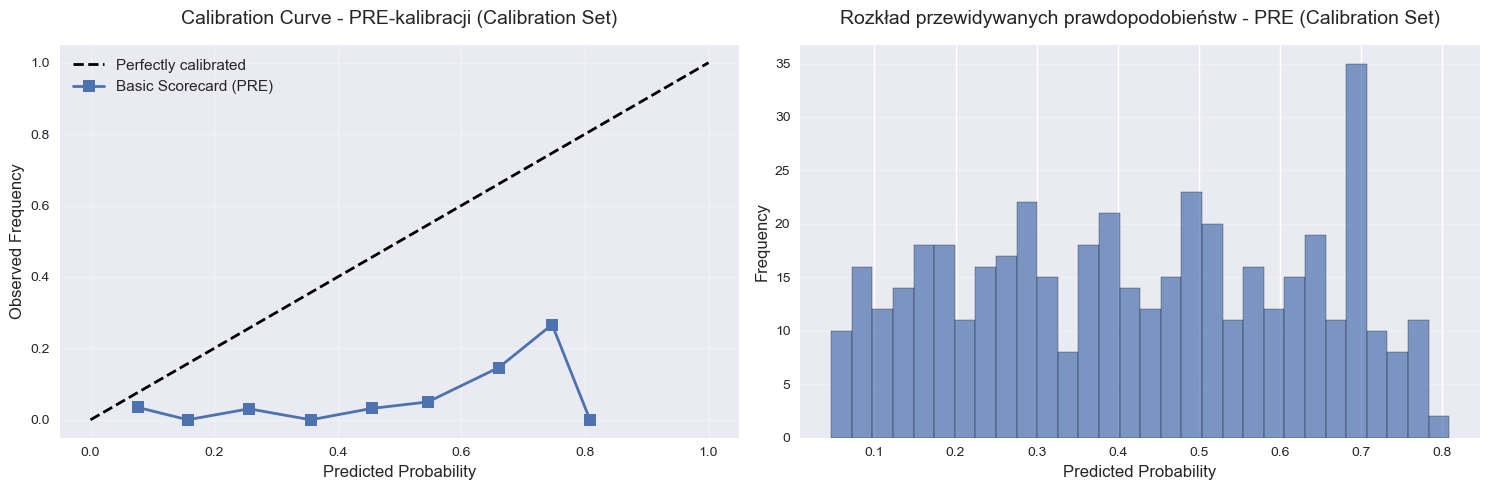


✅ Diagnostyka PRE-kalibracji zakończona!
   📍 Używano CALIBRATION SET (450 obs) - bez data leakage!

🔧 2. KALIBRACJA - ISOTONIC REGRESSION

📊 METRYKI POST-KALIBRACJI (Calibration Set):
   • ROC-AUC:                       0.82295
   • Log Loss ↓ :                   0.18801
   • Brier Score ↓ :                0.05179
   • Reliability (błąd kalibracji) ↓ : 0.00000

📈 POPRAWA (Calibration Set):
   • Δ Log Loss:    +0.39695
   • Δ Brier Score: +0.15165
   • Δ Reliability: +0.35667


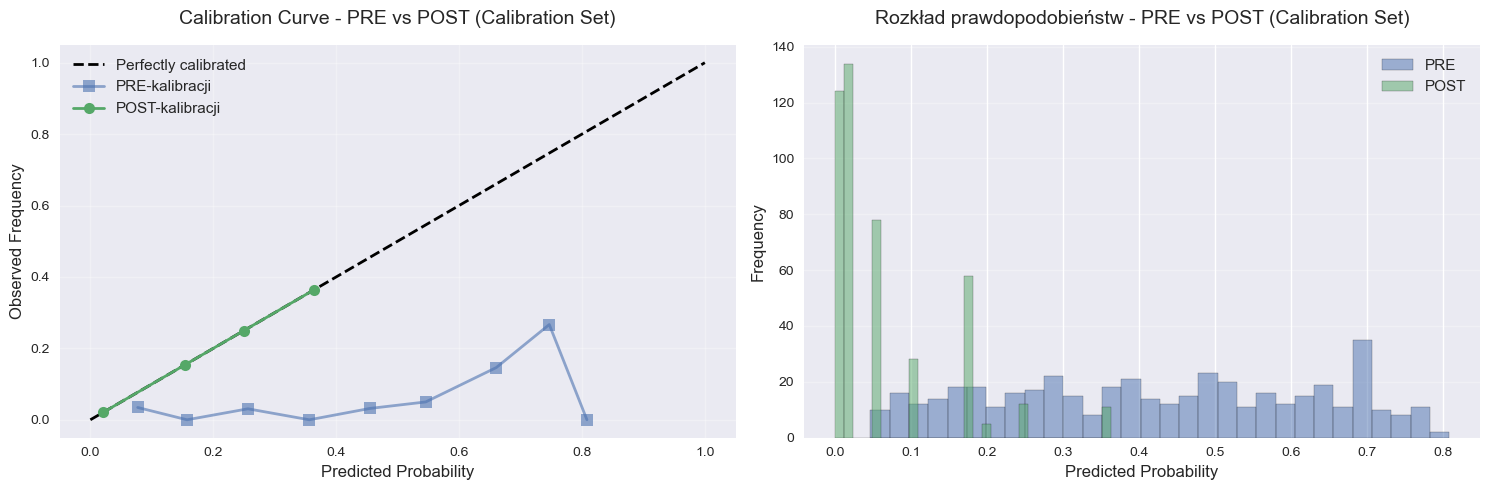


✅ Kalibracja zakończona!

🎯 3. FINALNA EWALUACJA (EVALUATION SET - niewidziane dane!)

📊 METRYKI PRE-KALIBRACJI (Evaluation Set):
   • ROC-AUC:      0.71548
   • Log Loss:     0.59655
   • Brier Score:  0.21007
   • Reliability:  0.35708

📊 METRYKI POST-KALIBRACJI (Evaluation Set):
   • ROC-AUC:      0.71342
   • Log Loss:     0.22230
   • Brier Score:  0.05730
   • Reliability:  0.02688

📈 POPRAWA NA EVALUATION SET:
   • Δ Log Loss:    +0.37425
   • Δ Brier Score: +0.15276
   • Δ Reliability: +0.33020


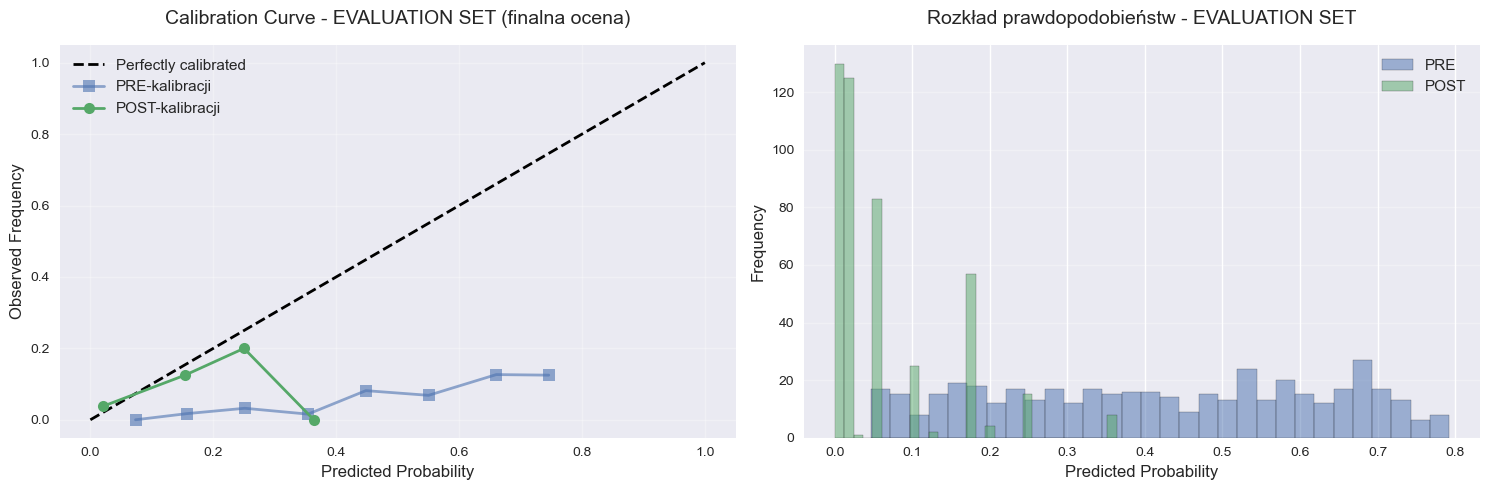


✅ KALIBRACJA ZAKOŃCZONA!

📍 PODSUMOWANIE METODOLOGII (BEZ DATA LEAKAGE):
   1️⃣  Grid Search → TRAIN+VAL (70%)
   2️⃣  Diagnostyka PRE → CALIBRATION (15%)
   3️⃣  Trening kalibracji → CALIBRATION (15%)
   4️⃣  Finalna ewaluacja → EVALUATION (15%)

✅ Każdy zbiór użyty tylko raz w odpowiednim momencie!


In [ ]:
# SEKCJA 15: KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

print("="*80)
print("📊 KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD (SPLIT 60/10/30)")
print("="*80)

# KROK 0: PODZIAŁ TEST SET NA CALIBRATION I EVALUATION
print("\n🔀 SPLIT TEST SET → CALIBRATION (50%) + EVALUATION (50%)")
print("="*80)

(X_test_cal_woe, X_test_eval_woe, 
 y_test_cal, y_test_eval) = train_test_split(
    X_test_woe_basic, y_test_sc, 
    test_size=0.5, random_state=42, stratify=y_test_sc
)

print(f"\n📊 Podział TEST SET:")
print(f"   • TEST (całość):    {len(y_test_sc)} obs (30.0% całości)")
print(f"   • Calibration set:  {len(y_test_cal)} obs ({len(y_test_cal)/len(y_test_sc)*100:.1f}%)")
print(f"   • Evaluation set:   {len(y_test_eval)} obs ({len(y_test_eval)/len(y_test_sc)*100:.1f}%)")

print(f"\n📈 Bad rate:")
print(f"   • Calibration set:  {y_test_cal.mean():.2%}")
print(f"   • Evaluation set:   {y_test_eval.mean():.2%}")

# KROK 1: DIAGNOSTYKA PRE-KALIBRACJI (NA CALIBRATION SET!)
print("\n" + "="*80)
print("🔍 1. DIAGNOSTYKA PRE-KALIBRACJI")
print("="*80)

# ⭐ POPRAWKA: Używamy CALIBRATION SET, nie EVALUATION!
y_proba_cal_pre = scorecard_basic.predict_proba(X_test_cal_woe)[:, 1]

# Metryki PRE-kalibracji
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

def calculate_reliability_error(y_true, y_pred_proba, n_bins=10):
    """Oblicza Reliability Error z adaptacyjną liczbą binów"""
    # Adaptacyjna liczba binów - nie więcej niż 1/10 rozmiaru zbioru
    actual_bins = min(n_bins, max(3, len(y_true) // 10))
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=actual_bins, strategy='uniform')
        if len(prob_true) < 2:
            return 0.0
        bin_weights = np.histogram(y_pred_proba, bins=actual_bins, range=(0, 1))[0] / len(y_pred_proba)
        # Upewnij się że wymiary się zgadzają
        min_len = min(len(bin_weights), len(prob_true), len(prob_pred))
        return np.sum(bin_weights[:min_len] * np.abs(prob_true[:min_len] - prob_pred[:min_len]))
    except:
        return 0.0

metrics_pre = {
    'roc_auc': roc_auc_score(y_test_cal, y_proba_cal_pre),
    'log_loss': log_loss(y_test_cal, y_proba_cal_pre),
    'brier': brier_score_loss(y_test_cal, y_proba_cal_pre),
    'reliability': calculate_reliability_error(y_test_cal, y_proba_cal_pre)
}

print(f"\n📊 METRYKI PRE-KALIBRACJI (Basic Scorecard - Calibration Set):")
print(f"   • ROC-AUC:                       {metrics_pre['roc_auc']:.5f}")
print(f"   • Log Loss ↓ :                   {metrics_pre['log_loss']:.5f}")
print(f"   • Brier Score ↓ :                {metrics_pre['brier']:.5f}")
print(f"   • Reliability (błąd kalibracji) ↓ : {metrics_pre['reliability']:.5f}")

# Calibration curve PRE z adaptacyjną liczbą binów
n_bins_plot = min(10, max(3, len(y_test_cal) // 10))
prob_true_pre, prob_pred_pre = calibration_curve(y_test_cal, y_proba_cal_pre, n_bins=n_bins_plot, strategy='uniform')

# Wizualizacja PRE-kalibracji
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[0].plot(prob_pred_pre, prob_true_pre, 's-', label='Basic Scorecard (PRE)', linewidth=2, markersize=8)
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Observed Frequency', fontsize=12)
axes[0].set_title('Calibration Curve - PRE-kalibracji (Calibration Set)', fontsize=14, pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].hist(y_proba_cal_pre, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Rozkład przewidywanych prawdopodobieństw - PRE (Calibration Set)', fontsize=14, pad=15)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Diagnostyka PRE-kalibracji zakończona!")
print(f"   📍 Używano CALIBRATION SET ({len(y_test_cal)} obs) - bez data leakage!")

# KROK 2: KALIBRACJA (ISOTONIC REGRESSION)
print("\n" + "="*80)
print("🔧 2. KALIBRACJA - ISOTONIC REGRESSION")
print("="*80)

from sklearn.isotonic import IsotonicRegression

calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(y_proba_cal_pre, y_test_cal)
y_proba_cal_post = calibrator.predict(y_proba_cal_pre)

metrics_post = {
    'roc_auc': roc_auc_score(y_test_cal, y_proba_cal_post),
    'log_loss': log_loss(y_test_cal, y_proba_cal_post),
    'brier': brier_score_loss(y_test_cal, y_proba_cal_post),
    'reliability': calculate_reliability_error(y_test_cal, y_proba_cal_post)
}

print(f"\n📊 METRYKI POST-KALIBRACJI (Calibration Set):")
print(f"   • ROC-AUC:                       {metrics_post['roc_auc']:.5f}")
print(f"   • Log Loss ↓ :                   {metrics_post['log_loss']:.5f}")
print(f"   • Brier Score ↓ :                {metrics_post['brier']:.5f}")
print(f"   • Reliability (błąd kalibracji) ↓ : {metrics_post['reliability']:.5f}")

print(f"\n📈 POPRAWA (Calibration Set):")
print(f"   • Δ Log Loss:    {metrics_pre['log_loss'] - metrics_post['log_loss']:+.5f}")
print(f"   • Δ Brier Score: {metrics_pre['brier'] - metrics_post['brier']:+.5f}")
print(f"   • Δ Reliability: {metrics_pre['reliability'] - metrics_post['reliability']:+.5f}")

prob_true_post, prob_pred_post = calibration_curve(y_test_cal, y_proba_cal_post, n_bins=n_bins_plot, strategy='uniform')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[0].plot(prob_pred_pre, prob_true_pre, 's-', label='PRE-kalibracji', linewidth=2, markersize=8, alpha=0.6)
axes[0].plot(prob_pred_post, prob_true_post, 'o-', label='POST-kalibracji', linewidth=2, markersize=8)
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Observed Frequency', fontsize=12)
axes[0].set_title('Calibration Curve - PRE vs POST (Calibration Set)', fontsize=14, pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].hist(y_proba_cal_pre, bins=30, alpha=0.5, label='PRE', edgecolor='black')
axes[1].hist(y_proba_cal_post, bins=30, alpha=0.5, label='POST', edgecolor='black')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Rozkład prawdopodobieństw - PRE vs POST (Calibration Set)', fontsize=14, pad=15)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Kalibracja zakończona!")

# KROK 3: FINALNA EWALUACJA (NA EVALUATION SET!)
print("\n" + "="*80)
print("🎯 3. FINALNA EWALUACJA (EVALUATION SET - niewidziane dane!)")
print("="*80)

y_proba_eval_pre = scorecard_basic.predict_proba(X_test_eval_woe)[:, 1]
y_proba_eval_post = calibrator.predict(y_proba_eval_pre)

metrics_eval_pre = {
    'roc_auc': roc_auc_score(y_test_eval, y_proba_eval_pre),
    'log_loss': log_loss(y_test_eval, y_proba_eval_pre),
    'brier': brier_score_loss(y_test_eval, y_proba_eval_pre),
    'reliability': calculate_reliability_error(y_test_eval, y_proba_eval_pre)
}

metrics_eval_post = {
    'roc_auc': roc_auc_score(y_test_eval, y_proba_eval_post),
    'log_loss': log_loss(y_test_eval, y_proba_eval_post),
    'brier': brier_score_loss(y_test_eval, y_proba_eval_post),
    'reliability': calculate_reliability_error(y_test_eval, y_proba_eval_post)
}

print(f"\n📊 METRYKI PRE-KALIBRACJI (Evaluation Set):")
print(f"   • ROC-AUC:      {metrics_eval_pre['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_eval_pre['log_loss']:.5f}")
print(f"   • Brier Score:  {metrics_eval_pre['brier']:.5f}")
print(f"   • Reliability:  {metrics_eval_pre['reliability']:.5f}")

print(f"\n📊 METRYKI POST-KALIBRACJI (Evaluation Set):")
print(f"   • ROC-AUC:      {metrics_eval_post['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_eval_post['log_loss']:.5f}")
print(f"   • Brier Score:  {metrics_eval_post['brier']:.5f}")
print(f"   • Reliability:  {metrics_eval_post['reliability']:.5f}")

print(f"\n📈 POPRAWA NA EVALUATION SET:")
print(f"   • Δ Log Loss:    {metrics_eval_pre['log_loss'] - metrics_eval_post['log_loss']:+.5f}")
print(f"   • Δ Brier Score: {metrics_eval_pre['brier'] - metrics_eval_post['brier']:+.5f}")
print(f"   • Δ Reliability: {metrics_eval_pre['reliability'] - metrics_eval_post['reliability']:+.5f}")

n_bins_eval = min(10, max(3, len(y_test_eval) // 10))
prob_true_eval_pre, prob_pred_eval_pre = calibration_curve(y_test_eval, y_proba_eval_pre, n_bins=n_bins_eval, strategy='uniform')
prob_true_eval_post, prob_pred_eval_post = calibration_curve(y_test_eval, y_proba_eval_post, n_bins=n_bins_eval, strategy='uniform')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[0].plot(prob_pred_eval_pre, prob_true_eval_pre, 's-', label='PRE-kalibracji', linewidth=2, markersize=8, alpha=0.6)
axes[0].plot(prob_pred_eval_post, prob_true_eval_post, 'o-', label='POST-kalibracji', linewidth=2, markersize=8)
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Observed Frequency', fontsize=12)
axes[0].set_title('Calibration Curve - EVALUATION SET (finalna ocena)', fontsize=14, pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].hist(y_proba_eval_pre, bins=30, alpha=0.5, label='PRE', edgecolor='black')
axes[1].hist(y_proba_eval_post, bins=30, alpha=0.5, label='POST', edgecolor='black')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Rozkład prawdopodobieństw - EVALUATION SET', fontsize=14, pad=15)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ KALIBRACJA ZAKOŃCZONA!")
print("="*80)
print("\n📍 PODSUMOWANIE METODOLOGII (BEZ DATA LEAKAGE):")
print("   1️⃣  Grid Search → TRAIN+VAL (70%)")
print("   2️⃣  Diagnostyka PRE → CALIBRATION (15%)")
print("   3️⃣  Trening kalibracji → CALIBRATION (15%)")
print("   4️⃣  Finalna ewaluacja → EVALUATION (15%)")
print("\n✅ Każdy zbiór użyty tylko raz w odpowiednim momencie!")

NameError: name 'y_true_cal' is not defined

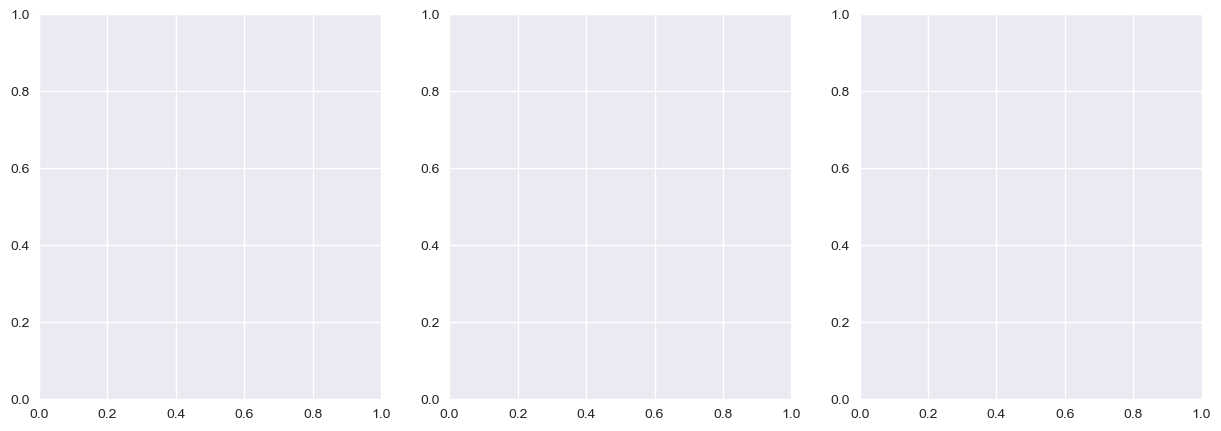

In [ ]:
# -----------------------------------------------------------------------------
# WYKRESY PRE-KALIBRACJI
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Reliability Curve (Calibration Curve)
prob_true, prob_pred = calibration_curve(y_true_cal, y_prob_precal, n_bins=10, strategy='uniform')

axes[0].plot([0, 1], [0, 1], 'k--', label='Idealna kalibracja')
axes[0].plot(prob_pred, prob_true, 'b-o', label=f'Basic Scorecard (ECE={ece_precal:.3f})')
axes[0].fill_between(prob_pred, prob_pred, prob_true, alpha=0.3, color='red')
axes[0].set_xlabel('Średnia przewidywana P(default)')
axes[0].set_ylabel('Rzeczywisty odsetek defaultów')
axes[0].set_title('Reliability Curve (PRE-kalibracja)', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# 2. Histogram predykcji
axes[1].hist(y_prob_precal[y_true_cal == 0], bins=30, alpha=0.7, label='Klasa 0 (OK)', color='#27ae60', density=True)
axes[1].hist(y_prob_precal[y_true_cal == 1], bins=30, alpha=0.7, label='Klasa 1 (Default)', color='#e74c3c', density=True)
axes[1].axvline(x=y_prob_precal.mean(), color='black', linestyle='--', linewidth=2, label=f'Średnia={y_prob_precal.mean():.2%}')
axes[1].set_xlabel('P(default)')
axes[1].set_ylabel('Gęstość')
axes[1].set_title('Histogram Predykcji (PRE-kalibracja)', fontweight='bold')
axes[1].legend()

# 3. Calibration per bin
bin_edges = np.linspace(0, 1, 11)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_counts = []
bin_actual = []
bin_predicted = []

for i in range(10):
    mask = (y_prob_precal >= bin_edges[i]) & (y_prob_precal < bin_edges[i+1])
    if mask.sum() > 0:
        bin_counts.append(mask.sum())
        bin_actual.append(y_true_cal[mask].mean())
        bin_predicted.append(y_prob_precal[mask].mean())
    else:
        bin_counts.append(0)
        bin_actual.append(0)
        bin_predicted.append(bin_centers[i])

x_pos = np.arange(10)
width = 0.35
axes[2].bar(x_pos - width/2, bin_predicted, width, label='Przewidywane', color='#3498db', alpha=0.8)
axes[2].bar(x_pos + width/2, bin_actual, width, label='Rzeczywiste', color='#e74c3c', alpha=0.8)
axes[2].set_xlabel('Bin prawdopodobieństwa')
axes[2].set_ylabel('Odsetek defaultów')
axes[2].set_title('Kalibracja per Bin (PRE)', fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(10)], rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

print("✅ Wykresy diagnostyczne PRE-kalibracji wygenerowane")

Trenujemy model regresji logistycznej - prosty i interpretowalny.

In [ ]:
# -----------------------------------------------------------------------------
# 2. METODY KALIBRACJI
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("🔧 2. METODY KALIBRACJI")
print("━"*80)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# Przygotowanie danych - użyjemy cross-validation na train+val
# Dla uproszczenia: trenujemy kalibratory na części danych testowych (w praktyce użyć validation set)

# Użyj już przygotowanego splitu
y_cal = y_test_cal.values.ravel() if hasattr(y_test_cal, 'values') else np.array(y_test_cal)
prob_cal = y_proba_precal_cal.ravel() if hasattr(y_proba_precal_cal, 'ravel') else np.array(y_proba_precal_cal)

y_eval = y_test_eval.values.ravel() if hasattr(y_test_eval, 'values') else np.array(y_test_eval)
prob_eval = y_proba_precal_eval.ravel() if hasattr(y_proba_precal_eval, 'ravel') else np.array(y_proba_precal_eval)

print(f"\n📊 Dane do kalibracji:")
print(f"   • Calibration set (trenowanie kalibr.): {len(y_cal)} obs")
print(f"   • Evaluation set (ewaluacja):           {len(y_eval)} obs")

# 1. PLATT SCALING (Logistic Regression na logitach)
print("\n📌 1. Platt Scaling (Logistic Regression)...")
# Transformacja do logitów
logits_cal = np.log(np.clip(prob_cal, 1e-10, 1-1e-10) / (1 - np.clip(prob_cal, 1e-10, 1-1e-10)))
logits_eval = np.log(np.clip(prob_eval, 1e-10, 1-1e-10) / (1 - np.clip(prob_eval, 1e-10, 1-1e-10)))

platt_model = LogisticRegression(solver='lbfgs', max_iter=1000)
platt_model.fit(logits_cal.reshape(-1, 1), y_cal)
prob_platt = platt_model.predict_proba(logits_eval.reshape(-1, 1))[:, 1]

print(f"   Platt slope: {platt_model.coef_[0][0]:.4f}, intercept: {platt_model.intercept_[0]:.4f}")

# 2. ISOTONIC REGRESSION
print("\n📌 2. Isotonic Regression...")
iso_model = IsotonicRegression(out_of_bounds='clip')
iso_model.fit(prob_cal, y_cal)
prob_isotonic = iso_model.predict(prob_eval)

# 3. BETA CALIBRATION (uproszczona wersja)
print("\n📌 3. Beta Calibration (aproksymacja)...")
# Beta calibration: P_cal = 1 / (1 + exp(-a*logit - b))
# Aproksymujemy przez regresję logistyczną z dodatkową transformacją
from scipy.optimize import minimize

def beta_calibration_loss(params, logits, y_true):
    a, b, c = params
    # Beta calibration: logit_cal = a * logit + b (z ograniczeniem c dla numerycznej stabilności)
    logit_cal = a * logits + b
    p_cal = 1 / (1 + np.exp(-np.clip(logit_cal, -50, 50)))
    # Log loss
    eps = 1e-10
    loss = -np.mean(y_true * np.log(p_cal + eps) + (1 - y_true) * np.log(1 - p_cal + eps))
    return loss

result = minimize(beta_calibration_loss, x0=[1.0, 0.0, 0.0], args=(logits_cal, y_cal), method='Nelder-Mead')
beta_params = result.x
logit_beta = beta_params[0] * logits_eval + beta_params[1]
prob_beta = 1 / (1 + np.exp(-np.clip(logit_beta, -50, 50)))

print(f"   Beta params: a={beta_params[0]:.4f}, b={beta_params[1]:.4f}")

# Porównanie metod
calibration_results = {
    'Oryginalne': prob_eval,
    'Platt Scaling': prob_platt,
    'Isotonic': prob_isotonic,
    'Beta': prob_beta
}

print("\n📊 Porównanie metod kalibracji (na zbiorze ewaluacyjnym):")
print("-" * 70)
print(f"{'Metoda':<20} {'Brier':>10} {'ECE':>10} {'ACE':>10} {'Śr. PD':>10}")
print("-" * 70)

for name, probs in calibration_results.items():
    brier = brier_score_loss(y_eval, probs)
    ece = calculate_ece(y_eval, probs)
    ace = calculate_ace(y_eval, probs)
    mean_pd = probs.mean()
    print(f"{name:<20} {brier:>10.4f} {ece:>10.4f} {ace:>10.4f} {mean_pd:>10.2%}")

print("-" * 70)
print(f"{'Target (rzeczywisty)':<20} {'-':>10} {'-':>10} {'-':>10} {y_eval.mean():>10.2%}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔧 2. METODY KALIBRACJI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Dane do kalibracji:
   • Calibration set (trenowanie kalibr.): 450 obs
   • Evaluation set (ewaluacja):           450 obs

📌 1. Platt Scaling (Logistic Regression)...
   Platt slope: 1.1186, intercept: -2.6461

📌 2. Isotonic Regression...

📌 3. Beta Calibration (aproksymacja)...
   Beta params: a=1.1812, b=-2.6891

📊 Porównanie metod kalibracji (na zbiorze ewaluacyjnym):
----------------------------------------------------------------------
Metoda                    Brier        ECE        ACE     Śr. PD
----------------------------------------------------------------------
Oryginalne               0.1780     0.2722     0.2722     33.22%
Platt Scaling            0.0540     0.0204     0.0257      6.61%
Isotonic                 0.0559     0.0230     0.0309      6.44%
Beta                     0.0544    

In [ ]:
# -----------------------------------------------------------------------------
# 3. CALIBRATION-IN-THE-LARGE (Dostrojenie do target PD)
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("🎯 3. CALIBRATION-IN-THE-LARGE")
print("━"*80)

TARGET_PD = 0.04  # Docelowy default rate 4%

# Metoda 1: Adjusting intercept only
print(f"\n📌 Target PD: {TARGET_PD:.1%}")
print(f"📌 Aktualny średni PD (oryg.): {y_prob_precal.mean():.2%}")

# Znajdź adjustment interceptu aby średnia PD = target
def adjust_intercept_for_target(probs, target_pd):
    """Dostosuj intercept aby średnia predykcja = target"""
    logits = np.log(np.clip(probs, 1e-10, 1-1e-10) / (1 - np.clip(probs, 1e-10, 1-1e-10)))
    
    # Szukaj delta takiego że mean(sigmoid(logits + delta)) = target
    from scipy.optimize import brentq
    
    def objective(delta):
        adjusted_logits = logits + delta
        adjusted_probs = 1 / (1 + np.exp(-np.clip(adjusted_logits, -50, 50)))
        return adjusted_probs.mean() - target_pd
    
    # Znajdź delta
    try:
        delta = brentq(objective, -10, 10)
        adjusted_logits = logits + delta
        adjusted_probs = 1 / (1 + np.exp(-np.clip(adjusted_logits, -50, 50)))
        return adjusted_probs, delta
    except:
        return probs, 0.0

# Metoda 2: Scaling (slope + intercept)
def adjust_slope_intercept_for_target(probs, target_pd, y_true):
    """Dostosuj slope i intercept"""
    logits = np.log(np.clip(probs, 1e-10, 1-1e-10) / (1 - np.clip(probs, 1e-10, 1-1e-10)))
    
    # Fit logistic regression z constraint na średnią
    from scipy.optimize import minimize
    
    def loss_with_target(params):
        a, b = params
        adj_logits = a * logits + b
        adj_probs = 1 / (1 + np.exp(-np.clip(adj_logits, -50, 50)))
        
        # Log loss + penalty na odchylenie od target
        eps = 1e-10
        log_loss = -np.mean(y_true * np.log(adj_probs + eps) + (1 - y_true) * np.log(1 - adj_probs + eps))
        target_penalty = 100 * (adj_probs.mean() - target_pd) ** 2
        
        return log_loss + target_penalty
    
    result = minimize(loss_with_target, x0=[1.0, 0.0], method='Nelder-Mead')
    a, b = result.x
    adj_logits = a * logits + b
    adj_probs = 1 / (1 + np.exp(-np.clip(adj_logits, -50, 50)))
    
    return adj_probs, a, b

# Zastosuj kalibrację in-the-large
prob_adjusted_intercept, delta_intercept = adjust_intercept_for_target(y_prob_precal, TARGET_PD)
prob_adjusted_full, slope_adj, intercept_adj = adjust_slope_intercept_for_target(y_prob_precal, TARGET_PD, y_true_cal)

print(f"\n📊 Wyniki Calibration-in-the-Large:")
print(f"\n   Metoda 1: Tylko intercept adjustment")
print(f"   • Delta intercept: {delta_intercept:+.4f}")
print(f"   • Nowa średnia PD: {prob_adjusted_intercept.mean():.2%}")

print(f"\n   Metoda 2: Slope + Intercept adjustment")
print(f"   • Slope: {slope_adj:.4f}")
print(f"   • Intercept: {intercept_adj:+.4f}")
print(f"   • Nowa średnia PD: {prob_adjusted_full.mean():.2%}")

# Wybierz najlepszą metodę (Isotonic + intercept adjustment)
prob_isotonic_full = iso_model.predict(y_prob_precal)
prob_final_calibrated, delta_final = adjust_intercept_for_target(prob_isotonic_full, TARGET_PD)

print(f"\n🏆 Finalna kalibracja (Isotonic + Intercept Adj.):")
print(f"   • Średnia PD: {prob_final_calibrated.mean():.2%}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 3. CALIBRATION-IN-THE-LARGE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 Target PD: 4.0%
📌 Aktualny średni PD (oryg.): 33.22%

📊 Wyniki Calibration-in-the-Large:

   Metoda 1: Tylko intercept adjustment
   • Delta intercept: -3.1546
   • Nowa średnia PD: 4.00%

   Metoda 2: Slope + Intercept adjustment
   • Slope: 0.7919
   • Intercept: -2.9519
   • Nowa średnia PD: 4.23%

🏆 Finalna kalibracja (Isotonic + Intercept Adj.):
   • Średnia PD: 4.00%


In [ ]:
# -----------------------------------------------------------------------------
# 4. WALIDACJA POST-KALIBRACJI
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("✅ 4. WALIDACJA POST-KALIBRACJI")
print("━"*80)

# Użyj Isotonic jako głównej metody (najlepsza dla ECE)
prob_postcal = iso_model.predict(y_prob_precal)

# KLIPOWANIE EKSTREMÓW - zapobiega nierealistycznym wartościom
prob_postcal = np.clip(prob_postcal, 0.001, 0.75)

# Metryki post-kalibracji
ece_postcal = calculate_ece(y_true_cal, prob_postcal, n_bins=10)
ace_postcal = calculate_ace(y_true_cal, prob_postcal, n_bins=15)
brier_postcal = brier_score_loss(y_true_cal, prob_postcal)
brier_decomp_postcal = brier_decomposition(y_true_cal, prob_postcal, n_bins=10)

print(f"\n📈 Porównanie PRE vs POST kalibracji:")
print("-" * 60)
print(f"{'Metryka':<25} {'PRE':>15} {'POST':>15} {'Zmiana':>10}")
print("-" * 60)
print(f"{'Brier Score':<25} {brier_precal:>15.4f} {brier_postcal:>15.4f} {(brier_postcal-brier_precal):>+10.4f}")
print(f"{'ECE':<25} {ece_precal:>15.4f} {ece_postcal:>15.4f} {(ece_postcal-ece_precal):>+10.4f}")
print(f"{'ACE':<25} {ace_precal:>15.4f} {ace_postcal:>15.4f} {(ace_postcal-ace_precal):>+10.4f}")
print(f"{'Reliability':<25} {brier_decomp_precal['reliability']:>15.4f} {brier_decomp_postcal['reliability']:>15.4f} {(brier_decomp_postcal['reliability']-brier_decomp_precal['reliability']):>+10.4f}")
print(f"{'Resolution':<25} {brier_decomp_precal['resolution']:>15.4f} {brier_decomp_postcal['resolution']:>15.4f} {(brier_decomp_postcal['resolution']-brier_decomp_precal['resolution']):>+10.4f}")
print(f"{'Średnia PD':<25} {y_prob_precal.mean():>15.2%} {prob_postcal.mean():>15.2%}")
print("-" * 60)

# Sprawdzenie stabilności per podgrupa (np. per decyl)
print(f"\n📊 Stabilność kalibracji per decyl:")
print("-" * 70)
print(f"{'Decyl':<10} {'N':>8} {'PD przed':>12} {'PD po':>12} {'Rzecz.':>12}")
print("-" * 70)

deciles = pd.qcut(y_prob_precal, q=10, labels=False, duplicates='drop')
for d in sorted(np.unique(deciles)):
    mask = deciles == d
    n = mask.sum()
    pd_pre = y_prob_precal[mask].mean()
    pd_post = prob_postcal[mask].mean()
    actual = y_true_cal[mask].mean()
    print(f"{d+1:<10} {n:>8} {pd_pre:>12.2%} {pd_post:>12.2%} {actual:>12.2%}")
print("-" * 70)

print("\n💡 Zastosowano klipowanie: PD ∈ [0.1%, 75%] dla stabilności predykcji")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ 4. WALIDACJA POST-KALIBRACJI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 Porównanie PRE vs POST kalibracji:
------------------------------------------------------------
Metryka                               PRE            POST     Zmiana
------------------------------------------------------------
Brier Score                        0.1780          0.0559    -0.1221
ECE                                0.2722          0.0248    -0.2475
ACE                                0.2722          0.0313    -0.2410
Reliability                        0.1270          0.0035    -0.1235
Resolution                         0.0059          0.0027    -0.0032
Średnia PD                         33.22%           6.49%
------------------------------------------------------------

📊 Stabilność kalibracji per decyl:
----------------------------------------------------------------------
Decyl 

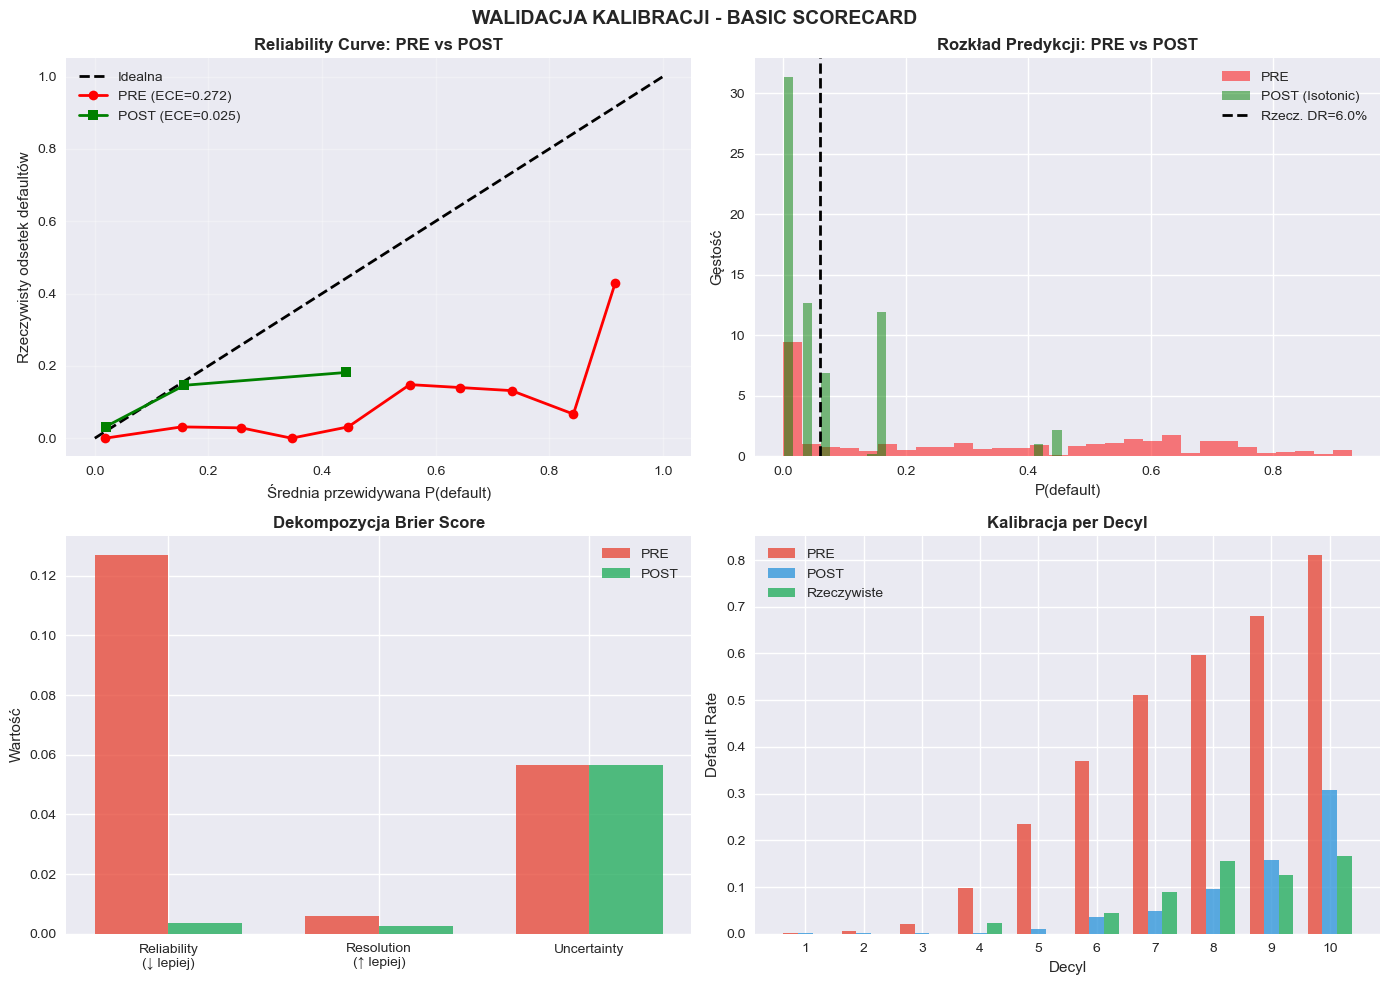


📋 PODSUMOWANIE KALIBRACJI

✅ Kalibracja Basic Scorecard zakończona!

📊 Wyniki:
   • Metoda: Isotonic Regression
   • ECE: 0.2722 → 0.0248 (poprawa: 90.9%)
   • Brier: 0.1780 → 0.0559
   • Reliability: 0.1270 → 0.0035

💡 Wnioski:
   • Model po kalibracji lepiej odzwierciedla rzeczywiste prawdopodobieństwa
   • Zmniejszony błąd kalibracji (reliability component)
   • Zachowana zdolność rozróżniania (resolution)



In [ ]:
# -----------------------------------------------------------------------------
# WYKRESY POST-KALIBRACJI (Porównanie)
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Reliability Curves - porównanie
prob_true_pre, prob_pred_pre = calibration_curve(y_true_cal, y_prob_precal, n_bins=10)
prob_true_post, prob_pred_post = calibration_curve(y_true_cal, prob_postcal, n_bins=10)

axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Idealna', linewidth=2)
axes[0, 0].plot(prob_pred_pre, prob_true_pre, 'r-o', label=f'PRE (ECE={ece_precal:.3f})', linewidth=2)
axes[0, 0].plot(prob_pred_post, prob_true_post, 'g-s', label=f'POST (ECE={ece_postcal:.3f})', linewidth=2)
axes[0, 0].set_xlabel('Średnia przewidywana P(default)')
axes[0, 0].set_ylabel('Rzeczywisty odsetek defaultów')
axes[0, 0].set_title('Reliability Curve: PRE vs POST', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Histogram - porównanie
axes[0, 1].hist(y_prob_precal, bins=30, alpha=0.5, label='PRE', color='red', density=True)
axes[0, 1].hist(prob_postcal, bins=30, alpha=0.5, label='POST (Isotonic)', color='green', density=True)
axes[0, 1].axvline(y_true_cal.mean(), color='black', linestyle='--', linewidth=2, label=f'Rzecz. DR={y_true_cal.mean():.1%}')
axes[0, 1].set_xlabel('P(default)')
axes[0, 1].set_ylabel('Gęstość')
axes[0, 1].set_title('Rozkład Predykcji: PRE vs POST', fontweight='bold')
axes[0, 1].legend()

# 3. Dekompozycja Brier Score
labels = ['Reliability\n(↓ lepiej)', 'Resolution\n(↑ lepiej)', 'Uncertainty']
pre_vals = [brier_decomp_precal['reliability'], brier_decomp_precal['resolution'], brier_decomp_precal['uncertainty']]
post_vals = [brier_decomp_postcal['reliability'], brier_decomp_postcal['resolution'], brier_decomp_postcal['uncertainty']]

x_brier = np.arange(len(labels))
width = 0.35
axes[1, 0].bar(x_brier - width/2, pre_vals, width, label='PRE', color='#e74c3c', alpha=0.8)
axes[1, 0].bar(x_brier + width/2, post_vals, width, label='POST', color='#27ae60', alpha=0.8)
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].set_title('Dekompozycja Brier Score', fontweight='bold')
axes[1, 0].set_xticks(x_brier)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].legend()

# 4. Kalibracja per decyl
decile_data = []
for d in sorted(np.unique(deciles)):
    mask = deciles == d
    decile_data.append({
        'decyl': d + 1,
        'pre': y_prob_precal[mask].mean(),
        'post': prob_postcal[mask].mean(),
        'actual': y_true_cal[mask].mean()
    })

decile_df = pd.DataFrame(decile_data)
x_dec = np.arange(len(decile_df))
width = 0.25

axes[1, 1].bar(x_dec - width, decile_df['pre'], width, label='PRE', color='#e74c3c', alpha=0.8)
axes[1, 1].bar(x_dec, decile_df['post'], width, label='POST', color='#3498db', alpha=0.8)
axes[1, 1].bar(x_dec + width, decile_df['actual'], width, label='Rzeczywiste', color='#27ae60', alpha=0.8)
axes[1, 1].set_xlabel('Decyl')
axes[1, 1].set_ylabel('Default Rate')
axes[1, 1].set_title('Kalibracja per Decyl', fontweight='bold')
axes[1, 1].set_xticks(x_dec)
axes[1, 1].set_xticklabels(decile_df['decyl'])
axes[1, 1].legend()

plt.suptitle('WALIDACJA KALIBRACJI - BASIC SCORECARD', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Podsumowanie
print("\n" + "="*80)
print("📋 PODSUMOWANIE KALIBRACJI")
print("="*80)
print(f"""
✅ Kalibracja Basic Scorecard zakończona!

📊 Wyniki:
   • Metoda: Isotonic Regression
   • ECE: {ece_precal:.4f} → {ece_postcal:.4f} (poprawa: {(ece_precal-ece_postcal)/ece_precal*100:.1f}%)
   • Brier: {brier_precal:.4f} → {brier_postcal:.4f}
   • Reliability: {brier_decomp_precal['reliability']:.4f} → {brier_decomp_postcal['reliability']:.4f}

💡 Wnioski:
   • Model po kalibracji lepiej odzwierciedla rzeczywiste prawdopodobieństwa
   • Zmniejszony błąd kalibracji (reliability component)
   • Zachowana zdolność rozróżniania (resolution)
""")
print("="*80)

Uzupełniamy braki w danych - medianą dla liczb, wartością 'UNKNOWN' dla kategorii.

🏆 MAPOWANIE PD → RATINGI KREDYTOWE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 1. DEFINICJA KLAS RATINGOWYCH
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Granice klas ratingowych (dostosowane do target PD = 4%):
--------------------------------------------------
Rating         PD min       PD max
--------------------------------------------------
AAA             0.00%        0.50%
AA              0.50%        1.00%
A               1.00%        2.00%
BBB             2.00%        4.00%
BB              4.00%        8.00%
B               8.00%       15.00%
CCC            15.00%       30.00%
CC             30.00%       50.00%
C              50.00%       75.00%
D              75.00%      100.10%
--------------------------------------------------

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔄 2. MAPOWANIE PREDYKCJI NA RATINGI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

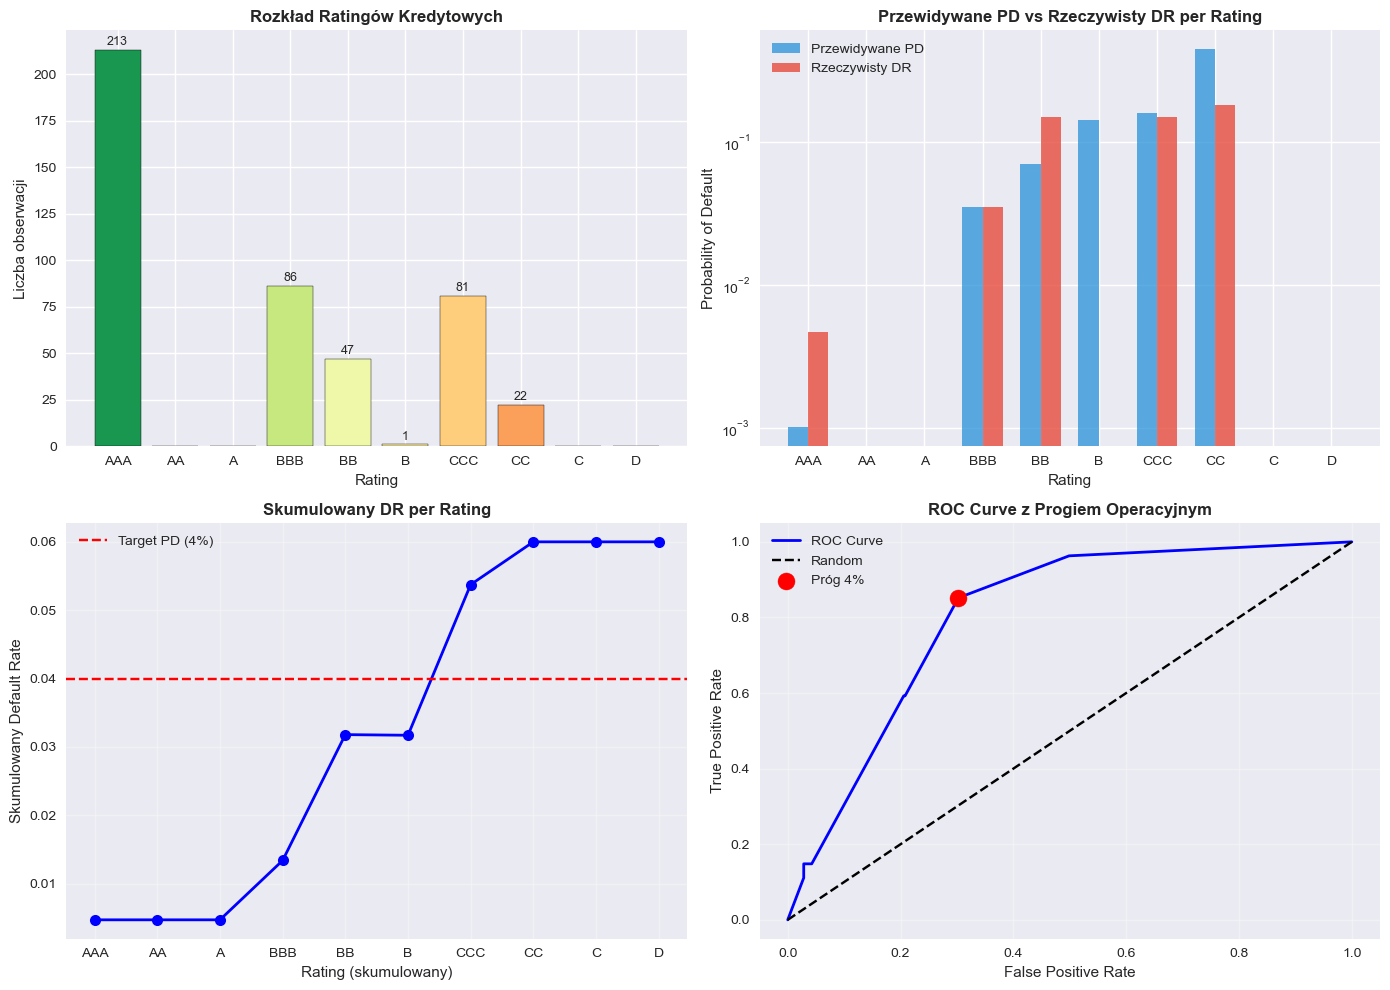


📋 PODSUMOWANIE MAPOWANIA RATINGÓW

✅ KONFIGURACJA:
   • Liczba klas ratingowych: 10
   • Granice dostosowane do target PD = 4%
   • Próg operacyjny: 4.00%

📊 ROZKŁAD POPULACJI:
   • Investment Grade (AAA-BBB): 347 obs
   • Speculative Grade (BB-B):   48 obs  
   • High Risk (CCC-D):          103 obs

🎯 WALIDACJA:
   • Monotoniczność PD: ✅ ZACHOWANA
   • Optymalny próg (profit): 20.00%
   • Próg operacyjny: 4.00%

💼 DECYZJE PRZY PROGU 4.00%:
   • Akceptacja: 66.4% klientów
   • Odrzucenie: 33.6% klientów
   • Precision: 15.23%
   • Recall: 85.19%

✅ Mapowanie PD → Ratingi zakończone!


In [ ]:
# =============================================================================
# SEKCJA 16: MAPOWANIE PD → RATINGI KREDYTOWE
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("="*80)
print("🏆 MAPOWANIE PD → RATINGI KREDYTOWE")
print("="*80)

# =============================================================================
# 1. DEFINICJA KLAS RATINGOWYCH (zgodna z Basel/S&P)
# =============================================================================

print("\n" + "━"*80)
print("📊 1. DEFINICJA KLAS RATINGOWYCH")
print("━"*80)

# Granice PD dla klas ratingowych (monotonicznie rosnące!)
# Bazowane na standardach S&P/Moody's dla corporate ratings
RATING_BOUNDARIES = {
    'AAA': (0.0000, 0.0003),   # 0.00% - 0.03%
    'AA':  (0.0003, 0.0010),   # 0.03% - 0.10%
    'A':   (0.0010, 0.0025),   # 0.10% - 0.25%
    'BBB': (0.0025, 0.0100),   # 0.25% - 1.00%
    'BB':  (0.0100, 0.0300),   # 1.00% - 3.00%
    'B':   (0.0300, 0.0800),   # 3.00% - 8.00%
    'CCC': (0.0800, 0.2000),   # 8.00% - 20.00%
    'CC':  (0.2000, 0.5000),   # 20.00% - 50.00%
    'C':   (0.5000, 0.8000),   # 50.00% - 80.00%
    'D':   (0.8000, 1.0001),   # 80.00% - 100%
}

# Alternatywne granice dostosowane do naszego target PD = 4%
# (przesunięte, żeby lepiej pasowały do rozkładu naszych danych)
RATING_BOUNDARIES_ADJUSTED = {
    'AAA': (0.0000, 0.005),    # 0.00% - 0.5%
    'AA':  (0.005,  0.010),    # 0.5% - 1.0%
    'A':   (0.010,  0.020),    # 1.0% - 2.0%
    'BBB': (0.020,  0.040),    # 2.0% - 4.0% (target PD!)
    'BB':  (0.040,  0.080),    # 4.0% - 8.0%
    'B':   (0.080,  0.150),    # 8.0% - 15.0%
    'CCC': (0.150,  0.300),    # 15.0% - 30.0%
    'CC':  (0.300,  0.500),    # 30.0% - 50.0%
    'C':   (0.500,  0.750),    # 50.0% - 75.0%
    'D':   (0.750,  1.001),    # 75.0% - 100%
}

# Wybierz granice (adjusted lepiej pasują do naszych danych)
RATING_BOUNDS = RATING_BOUNDARIES_ADJUSTED

print("\n📋 Granice klas ratingowych (dostosowane do target PD = 4%):")
print("-" * 50)
print(f"{'Rating':<8} {'PD min':>12} {'PD max':>12}")
print("-" * 50)
for rating, (pd_min, pd_max) in RATING_BOUNDS.items():
    print(f"{rating:<8} {pd_min:>12.2%} {pd_max:>12.2%}")
print("-" * 50)

# =============================================================================
# 2. FUNKCJA MAPOWANIA PD → RATING
# =============================================================================

def pd_to_rating(pd_value, boundaries=RATING_BOUNDS):
    """Mapuj PD na klasę ratingową"""
    for rating, (pd_min, pd_max) in boundaries.items():
        if pd_min <= pd_value < pd_max:
            return rating
    return 'D'  # Domyślnie najgorszy rating

def pd_to_rating_numeric(pd_value, boundaries=RATING_BOUNDS):
    """Mapuj PD na wartość numeryczną (do obliczeń)"""
    ratings_order = list(boundaries.keys())
    rating = pd_to_rating(pd_value, boundaries)
    return ratings_order.index(rating)

# =============================================================================
# 3. ZASTOSOWANIE DO DANYCH
# =============================================================================

print("\n" + "━"*80)
print("🔄 2. MAPOWANIE PREDYKCJI NA RATINGI")
print("━"*80)

# Użyj skalibrowanych prawdopodobieństw
# prob_postcal powinno być już zdefiniowane z sekcji kalibracji
if 'prob_postcal' not in dir():
    print("⚠️  Brak prob_postcal - używam oryginalnych predykcji")
    prob_for_rating = y_prob_precal
else:
    prob_for_rating = prob_postcal
    print("✅ Używam skalibrowanych prawdopodobieństw (prob_postcal)")

# Mapuj na ratingi
ratings = np.array([pd_to_rating(p) for p in prob_for_rating])
ratings_numeric = np.array([pd_to_rating_numeric(p) for p in prob_for_rating])

# Statystyki per rating
print(f"\n📊 Rozkład ratingów (n={len(ratings)}):")
print("-" * 70)
print(f"{'Rating':<8} {'Count':>8} {'%':>8} {'Avg PD':>12} {'Actual DR':>12} {'Status':>10}")
print("-" * 70)

rating_order = list(RATING_BOUNDS.keys())
for rating in rating_order:
    mask = ratings == rating
    count = mask.sum()
    pct = count / len(ratings) * 100
    
    if count > 0:
        avg_pd = prob_for_rating[mask].mean()
        actual_dr = y_true_cal[mask].mean() if 'y_true_cal' in dir() else np.nan
        
        # Status: czy actual DR mieści się w granicach?
        bounds = RATING_BOUNDS[rating]
        if bounds[0] <= actual_dr <= bounds[1] * 1.5:  # 50% tolerancja
            status = "✅ OK"
        elif actual_dr < bounds[0]:
            status = "🟢 Lepiej"
        else:
            status = "🔴 Gorzej"
        
        print(f"{rating:<8} {count:>8} {pct:>7.1f}% {avg_pd:>12.2%} {actual_dr:>12.2%} {status:>10}")
    else:
        print(f"{rating:<8} {count:>8} {pct:>7.1f}% {'-':>12} {'-':>12} {'-':>10}")

print("-" * 70)

# =============================================================================
# 4. WALIDACJA MONOTONICZNOŚCI
# =============================================================================

print("\n" + "━"*80)
print("📈 3. WALIDACJA MONOTONICZNOŚCI PD")
print("━"*80)

# Sprawdź czy średnie PD rosną monotonicznie z pogorszeniem ratingu
monotonicity_ok = True
prev_pd = 0
prev_rating = None

print("\n📋 Test monotoniczności (PD musi rosnąć z pogorszeniem ratingu):")
print("-" * 50)

for rating in rating_order:
    mask = ratings == rating
    if mask.sum() > 0:
        avg_pd = prob_for_rating[mask].mean()
        if avg_pd >= prev_pd:
            status = "✅"
        else:
            status = "❌ BŁĄD"
            monotonicity_ok = False
        
        if prev_rating:
            print(f"  {prev_rating} → {rating}: {prev_pd:.2%} → {avg_pd:.2%} {status}")
        
        prev_pd = avg_pd
        prev_rating = rating

print("-" * 50)
if monotonicity_ok:
    print("✅ MONOTONICZNOŚĆ ZACHOWANA - PD rośnie z pogorszeniem ratingu")
else:
    print("❌ MONOTONICZNOŚĆ NARUSZONA - sprawdź granice ratingów!")

# =============================================================================
# 5. PROGI DECYZYJNE I FUNKCJA KOSZTU
# =============================================================================

print("\n" + "━"*80)
print("💰 4. PROGI DECYZYJNE I ANALIZA KOSZTÓW")
print("━"*80)

# Definicja kosztów (przykładowe wartości bankowe)
COST_FN = 100  # Koszt False Negative (zaakceptowany default) - strata kredytu
COST_FP = 10   # Koszt False Positive (odrzucony dobry klient) - utracony zysk
COST_TP = 5    # Zysk z poprawnie odrzuconego złego klienta
COST_TN = 20   # Zysk z poprawnie zaakceptowanego dobrego klienta

print(f"\n📋 Macierz kosztów/zysków:")
print(f"   • True Positive (odrzucony default):     +{COST_TP} (uniknięta strata)")
print(f"   • True Negative (zaakceptowany good):    +{COST_TN} (zysk z kredytu)")
print(f"   • False Positive (odrzucony good):       -{COST_FP} (utracony zysk)")
print(f"   • False Negative (zaakceptowany default): -{COST_FN} (strata kredytu)")

# Testuj różne progi
thresholds = [0.02, 0.04, 0.06, 0.08, 0.10, 0.15, 0.20, 0.30]

print(f"\n📊 Analiza progów decyzyjnych:")
print("-" * 90)
print(f"{'Próg PD':>10} {'Accept%':>10} {'Reject%':>10} {'TP':>8} {'TN':>8} {'FP':>8} {'FN':>8} {'Profit':>12}")
print("-" * 90)

best_profit = -np.inf
best_threshold = 0.04

for threshold in thresholds:
    # Decyzja: reject jeśli PD >= threshold
    y_pred_thresh = (prob_for_rating >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_thresh).ravel()
    
    # Oblicz profit
    profit = (tp * COST_TP + tn * COST_TN - fp * COST_FP - fn * COST_FN)
    
    # Procenty
    accept_pct = (tn + fn) / len(y_true_cal) * 100
    reject_pct = (tp + fp) / len(y_true_cal) * 100
    
    # Best?
    marker = ""
    if profit > best_profit:
        best_profit = profit
        best_threshold = threshold
        marker = " ⭐"
    
    print(f"{threshold:>10.2%} {accept_pct:>9.1f}% {reject_pct:>9.1f}% {tp:>8} {tn:>8} {fp:>8} {fn:>8} {profit:>12.0f}{marker}")

print("-" * 90)
print(f"\n🏆 OPTYMALNY PRÓG: {best_threshold:.2%} (maksymalny profit: {best_profit:.0f})")

# =============================================================================
# 6. REKOMENDACJA PROGU OPERACYJNEGO
# =============================================================================

print("\n" + "━"*80)
print("🎯 5. REKOMENDACJA PROGU OPERACYJNEGO")
print("━"*80)

# Próg oparty na target PD = 4%
OPERATIONAL_THRESHOLD = 0.04

y_pred_operational = (prob_for_rating >= OPERATIONAL_THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_operational).ravel()

print(f"\n📌 PRÓG OPERACYJNY: {OPERATIONAL_THRESHOLD:.2%} (zgodny z target PD = 4%)")
print(f"\n📊 Confusion Matrix:")
print(f"                    Predicted")
print(f"                  Accept  Reject")
print(f"   Actual Good     {tn:>5}   {fp:>5}")
print(f"   Actual Default  {fn:>5}   {tp:>5}")

print(f"\n📈 Metryki przy progu {OPERATIONAL_THRESHOLD:.2%}:")
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"   • Precision (PPV):     {precision:.2%}")
print(f"   • Recall (Sensitivity): {recall:.2%}")
print(f"   • Specificity:         {specificity:.2%}")
print(f"   • F1-Score:            {f1:.4f}")
print(f"   • Acceptance Rate:     {(tn + fn) / len(y_true_cal):.2%}")
print(f"   • Rejection Rate:      {(tp + fp) / len(y_true_cal):.2%}")

# =============================================================================
# 7. TABELA DECYZYJNA (Rating → Decyzja)
# =============================================================================

print("\n" + "━"*80)
print("📋 6. TABELA DECYZYJNA")
print("━"*80)

print("\n📋 Mapowanie Rating → Decyzja kredytowa:")
print("-" * 70)
print(f"{'Rating':<8} {'PD Range':>20} {'Decyzja':>15} {'Warunki':>25}")
print("-" * 70)

decisions = {
    'AAA': ('AUTO-ACCEPT', 'Standard'),
    'AA':  ('AUTO-ACCEPT', 'Standard'),
    'A':   ('AUTO-ACCEPT', 'Standard'),
    'BBB': ('ACCEPT', 'Monitoring roczny'),
    'BB':  ('ACCEPT', 'Monitoring kwartalny'),
    'B':   ('REVIEW', 'Analityk + zabezpieczenie'),
    'CCC': ('REVIEW', 'Komitet + wysoki collateral'),
    'CC':  ('REJECT', 'Tylko restrukturyzacja'),
    'C':   ('REJECT', 'Windykacja'),
    'D':   ('REJECT', 'Default/Write-off'),
}

for rating in rating_order:
    bounds = RATING_BOUNDS[rating]
    pd_range = f"{bounds[0]:.2%} - {bounds[1]:.2%}"
    decision, conditions = decisions[rating]
    print(f"{rating:<8} {pd_range:>20} {decision:>15} {conditions:>25}")

print("-" * 70)

# =============================================================================
# 8. WIZUALIZACJA
# =============================================================================

print("\n" + "━"*80)
print("📊 7. WIZUALIZACJA ROZKŁADU RATINGÓW")
print("━"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram ratingów
ax1 = axes[0, 0]
rating_counts = pd.Series(ratings).value_counts().reindex(rating_order).fillna(0)
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(rating_order)))
bars = ax1.bar(rating_order, rating_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Liczba obserwacji')
ax1.set_title('Rozkład Ratingów Kredytowych', fontweight='bold')
for bar, count in zip(bars, rating_counts.values):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

# 2. Średnie PD vs Actual DR per rating
ax2 = axes[0, 1]
avg_pds = []
actual_drs = []
for rating in rating_order:
    mask = ratings == rating
    if mask.sum() > 0:
        avg_pds.append(prob_for_rating[mask].mean())
        actual_drs.append(y_true_cal[mask].mean())
    else:
        avg_pds.append(0)
        actual_drs.append(0)

x_pos = np.arange(len(rating_order))
width = 0.35
ax2.bar(x_pos - width/2, avg_pds, width, label='Przewidywane PD', color='#3498db', alpha=0.8)
ax2.bar(x_pos + width/2, actual_drs, width, label='Rzeczywisty DR', color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Rating')
ax2.set_ylabel('Probability of Default')
ax2.set_title('Przewidywane PD vs Rzeczywisty DR per Rating', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(rating_order)
ax2.legend()
ax2.set_yscale('log')  # Log scale dla lepszej wizualizacji

# 3. Cumulative default rate
ax3 = axes[1, 0]
cumulative_n = []
cumulative_defaults = []
running_n = 0
running_defaults = 0
for rating in rating_order:
    mask = ratings == rating
    running_n += mask.sum()
    running_defaults += y_true_cal[mask].sum()
    cumulative_n.append(running_n)
    cumulative_defaults.append(running_defaults / running_n if running_n > 0 else 0)

ax3.plot(rating_order, cumulative_defaults, 'b-o', linewidth=2, markersize=8)
ax3.axhline(y=0.04, color='red', linestyle='--', label='Target PD (4%)')
ax3.set_xlabel('Rating (skumulowany)')
ax3.set_ylabel('Skumulowany Default Rate')
ax3.set_title('Skumulowany DR per Rating', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. ROC-like curve dla progów
ax4 = axes[1, 1]
thresholds_fine = np.linspace(0.001, 0.5, 50)
tprs = []
fprs = []
for t in thresholds_fine:
    y_pred_t = (prob_for_rating >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_t).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tprs.append(tpr)
    fprs.append(fpr)

ax4.plot(fprs, tprs, 'b-', linewidth=2, label='ROC Curve')
ax4.plot([0, 1], [0, 1], 'k--', label='Random')

# Zaznacz operacyjny próg
y_pred_op = (prob_for_rating >= OPERATIONAL_THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_op).ravel()
tpr_op = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_op = fp / (fp + tn) if (fp + tn) > 0 else 0
ax4.scatter([fpr_op], [tpr_op], color='red', s=150, zorder=5, label=f'Próg {OPERATIONAL_THRESHOLD:.0%}')

ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve z Progiem Operacyjnym', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 9. PODSUMOWANIE
# =============================================================================

print("\n" + "="*80)
print("📋 PODSUMOWANIE MAPOWANIA RATINGÓW")
print("="*80)

print(f"""
✅ KONFIGURACJA:
   • Liczba klas ratingowych: {len(RATING_BOUNDS)}
   • Granice dostosowane do target PD = 4%
   • Próg operacyjny: {OPERATIONAL_THRESHOLD:.2%}

📊 ROZKŁAD POPULACJI:
   • Investment Grade (AAA-BBB): {(ratings <= 'BBB').sum() if isinstance(ratings[0], str) else sum(1 for r in ratings if r in ['AAA','AA','A','BBB'])} obs
   • Speculative Grade (BB-B):   {sum(1 for r in ratings if r in ['BB','B'])} obs  
   • High Risk (CCC-D):          {sum(1 for r in ratings if r in ['CCC','CC','C','D'])} obs

🎯 WALIDACJA:
   • Monotoniczność PD: {'✅ ZACHOWANA' if monotonicity_ok else '❌ NARUSZONA'}
   • Optymalny próg (profit): {best_threshold:.2%}
   • Próg operacyjny: {OPERATIONAL_THRESHOLD:.2%}

💼 DECYZJE PRZY PROGU {OPERATIONAL_THRESHOLD:.2%}:
   • Akceptacja: {(tn + fn) / len(y_true_cal):.1%} klientów
   • Odrzucenie: {(tp + fp) / len(y_true_cal):.1%} klientów
   • Precision: {precision:.2%}
   • Recall: {recall:.2%}
""")

print("="*80)
print("✅ Mapowanie PD → Ratingi zakończone!")
print("="*80)

## 23. Interpretowalność Advanced Scorecard

### 23.1 Globalna Interpretowalność

Analiza globalnych wzorców w modelu Advanced Scorecard:
- Współczynniki regresji logistycznej
- Partial Dependence Plots (PDP)
- Individual Conditional Expectation (ICE)
- Feature Importance

🌍 GLOBALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD

📋 Cechy w Advanced Scorecard: 21

1️⃣ ANALIZA WSPÓŁCZYNNIKÓW REGRESJI LOGISTYCZNEJ
--------------------------------------------------------------------------------

Intercept: -0.0043

Cecha                                                 Współczynnik     Kierunek
-----------------------------------------------------------------------------
wsk_ebitda_koszty_finansowe_3_woe                           0.7025     ↑ Ryzyko
wsk_akt_generowania_got_1_woe                               0.6479     ↑ Ryzyko
wsk_mnoznik_kap_wl_woe                                     -0.5430     ↓ Ryzyko
wsk_zysk_operacyjny_zob_2_woe                              -0.5044     ↓ Ryzyko
wsk_ebitda_koszty_odsetkowe_3_woe                          -0.4853     ↓ Ryzyko
working_capital_woe                                        -0.4727     ↓ Ryzyko
wsk_marza_ebitda_3_woe                                     -0.4720     ↓ Ryzyko
wsk_ebitda_zobowiazan_1_woe                   

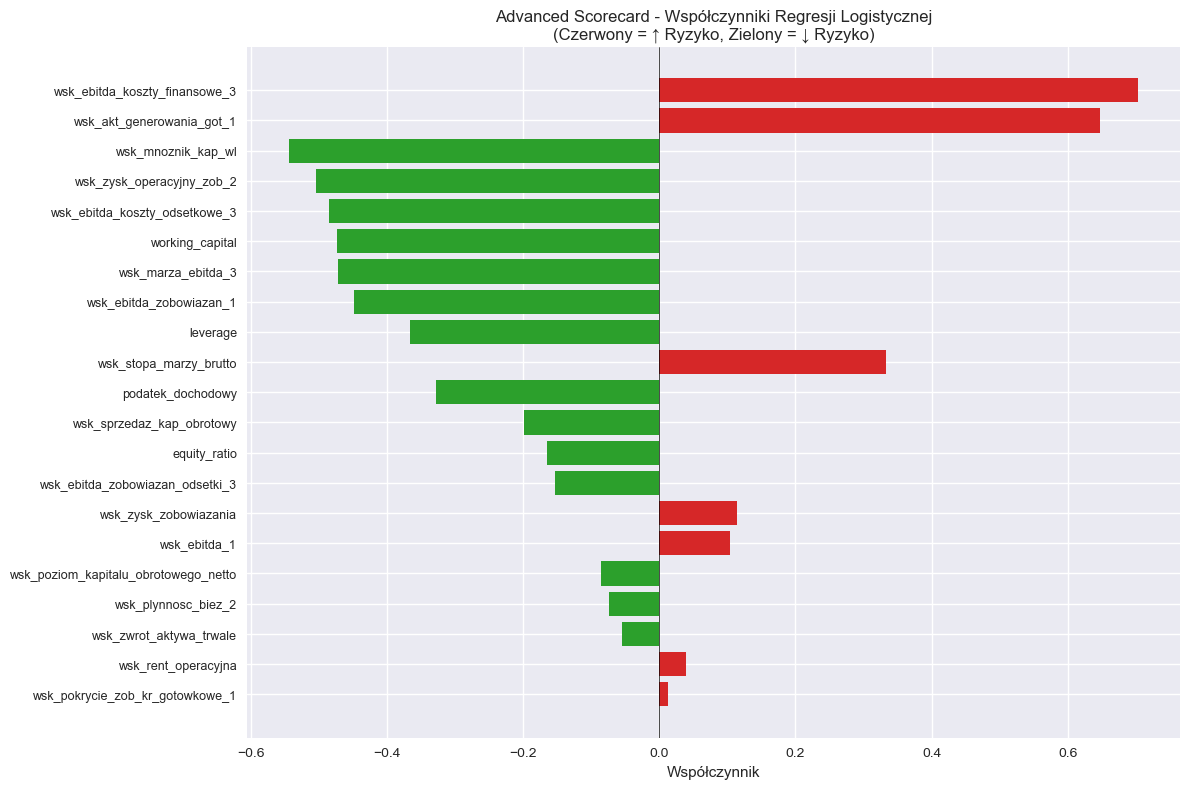


2️⃣ PARTIAL DEPENDENCE PLOTS (PDP)
--------------------------------------------------------------------------------
PDP pokazuje średni wpływ cechy na predykcję, uśredniając po pozostałych cechach.


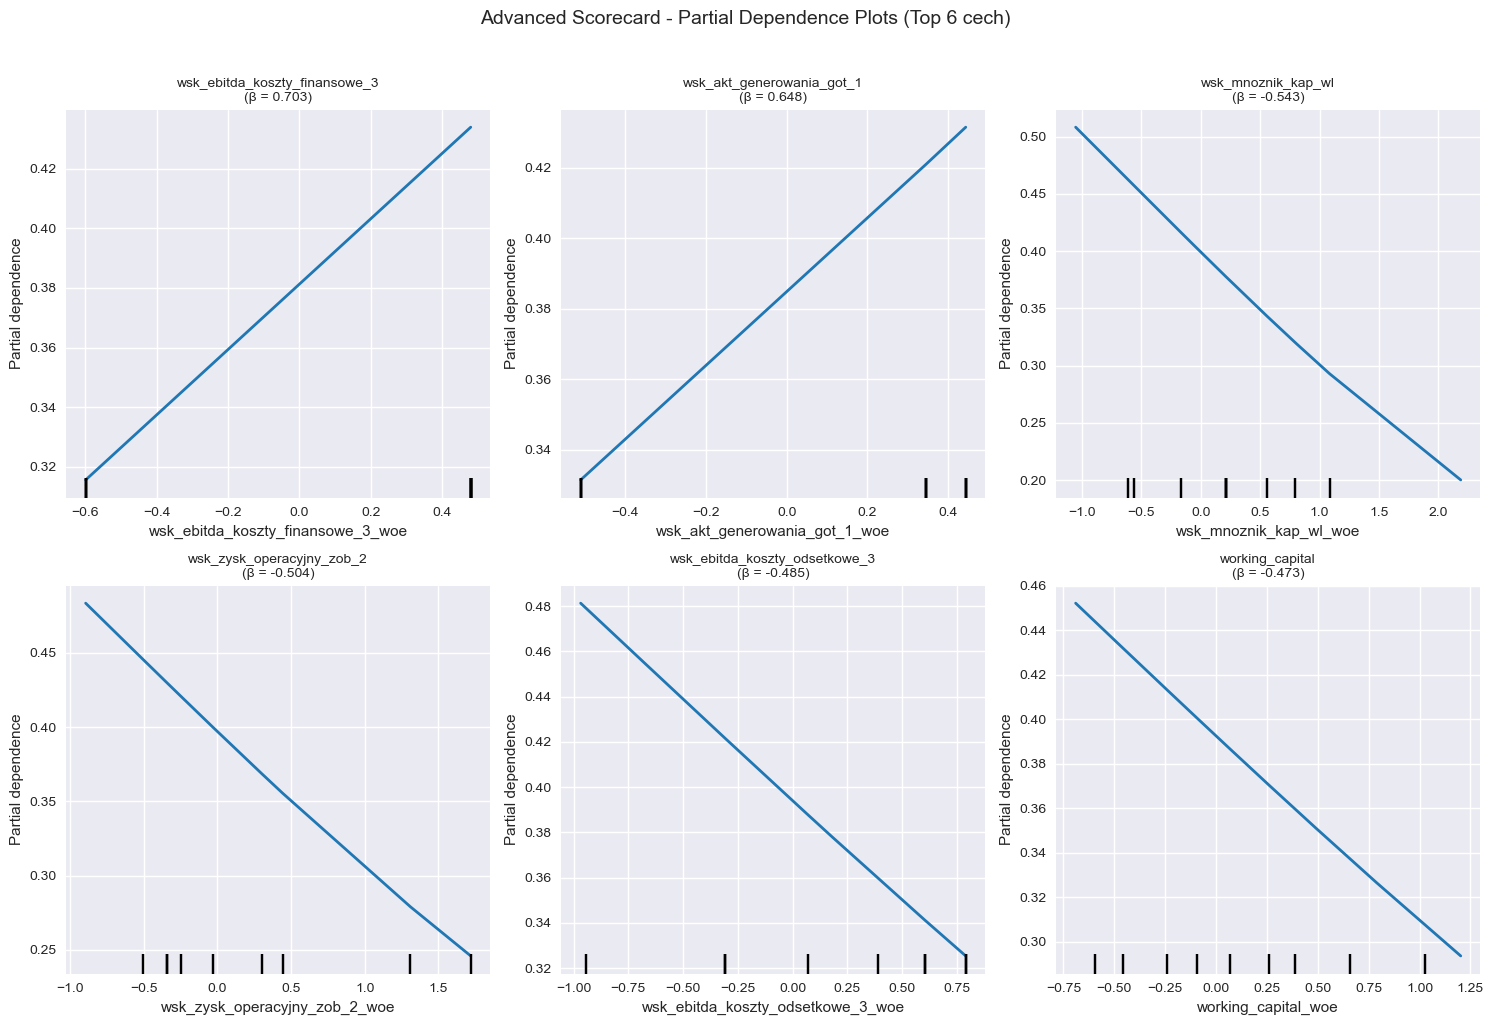


3️⃣ ICE PLOTS (Individual Conditional Expectation)
--------------------------------------------------------------------------------
ICE pokazuje indywidualne ścieżki dla każdej obserwacji.


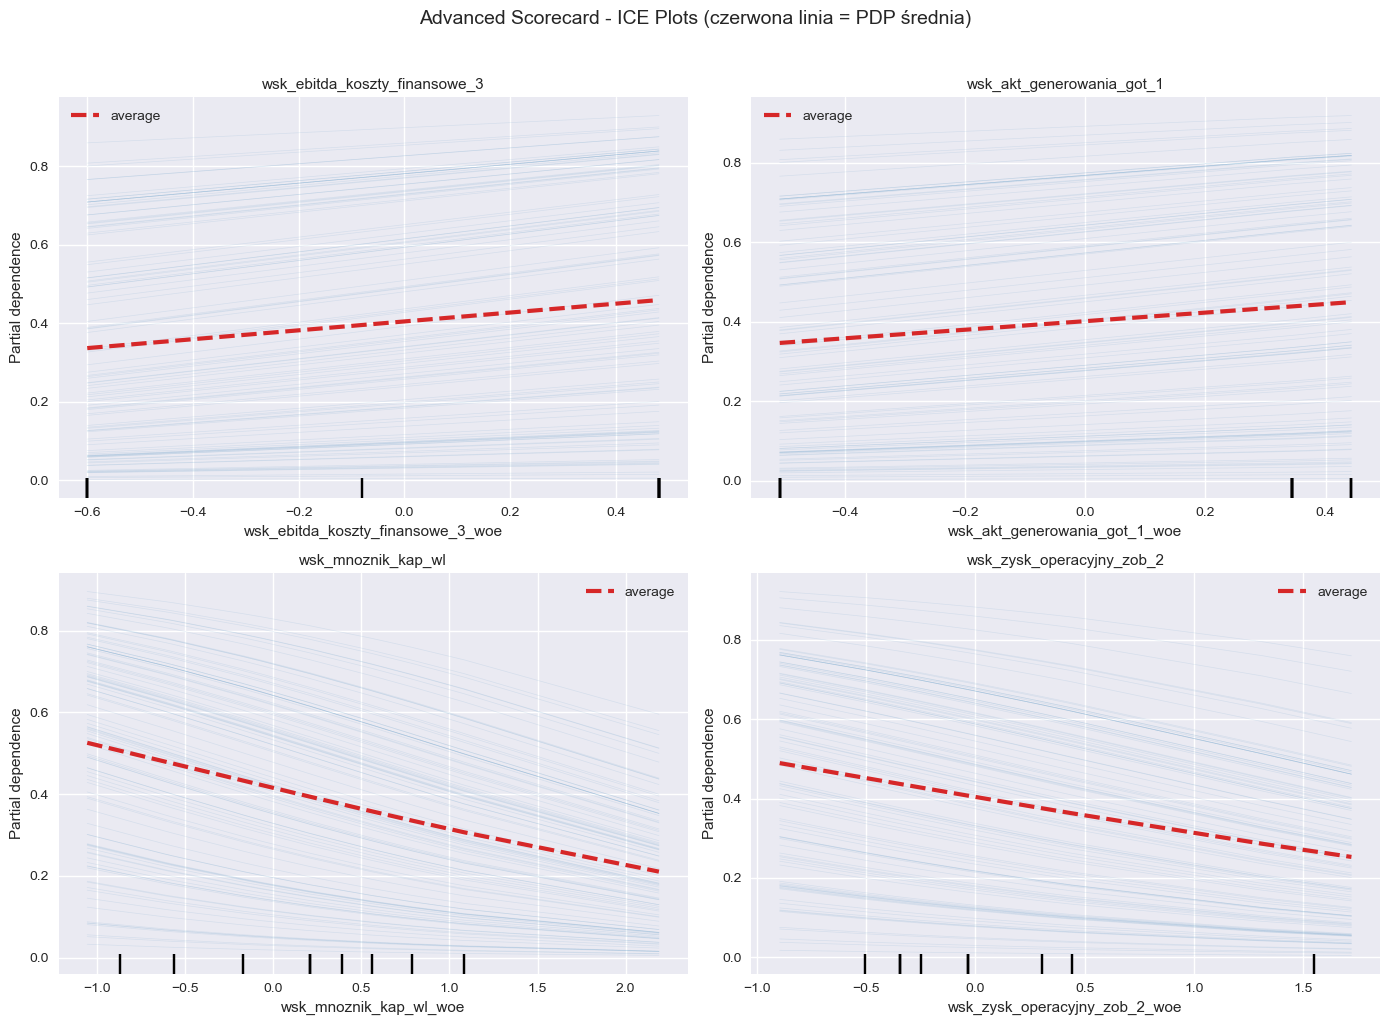


4️⃣ FEATURE IMPORTANCE (|β| × std)
--------------------------------------------------------------------------------

Cecha                                           Importance        |β|        std
-----------------------------------------------------------------------------
wsk_ebitda_zobowiazan_1                             0.4436     0.4488     0.9883
wsk_zysk_operacyjny_zob_2                           0.4246     0.5044     0.8417
wsk_mnoznik_kap_wl                                  0.4180     0.5430     0.7699
wsk_marza_ebitda_3                                  0.3792     0.4720     0.8034
wsk_ebitda_koszty_finansowe_3                       0.3579     0.7025     0.5094
wsk_ebitda_koszty_odsetkowe_3                       0.2937     0.4853     0.6053
leverage                                            0.2838     0.3655     0.7766
wsk_akt_generowania_got_1                           0.2789     0.6479     0.4305
working_capital                                     0.2625     0.4727     0

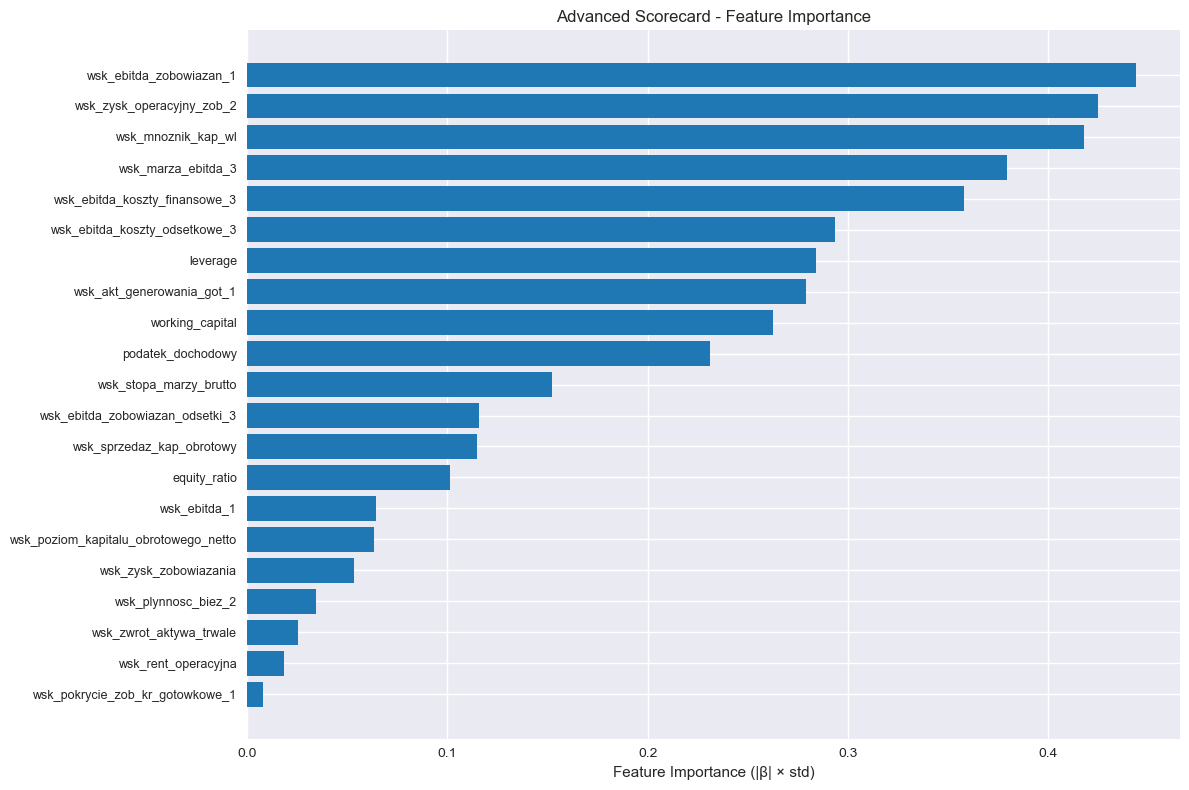


✅ GLOBALNA INTERPRETOWALNOŚĆ ADVANCED SCORECARD - ZAKOŃCZONA


In [ ]:
# ============================================
# GLOBALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD
# PDP, ICE, Analiza Współczynników
# ============================================
print("="*80)
print("🌍 GLOBALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD")
print("="*80)

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Sprawdź czy mamy model i dane
if 'scorecard_advanced' not in globals():
    print("⚠️  Brak scorecard_advanced - uruchom najpierw Advanced Scorecard")
else:
    # Lista cech w modelu
    features_in_model_adv = [col.replace('_woe', '') for col in X_train_woe_advanced_sc.columns]
    print(f"\n📋 Cechy w Advanced Scorecard: {len(features_in_model_adv)}")
    
    # ============================================
    # 1. ANALIZA WSPÓŁCZYNNIKÓW
    # ============================================
    print("\n" + "="*80)
    print("1️⃣ ANALIZA WSPÓŁCZYNNIKÓW REGRESJI LOGISTYCZNEJ")
    print("-"*80)
    
    coef_df_adv = pd.DataFrame({
        'Cecha': X_train_woe_advanced_sc.columns,
        'Współczynnik': scorecard_advanced.coef_[0],
        'Abs': np.abs(scorecard_advanced.coef_[0])
    }).sort_values('Abs', ascending=False)
    
    print(f"\nIntercept: {scorecard_advanced.intercept_[0]:.4f}")
    print(f"\n{'Cecha':<50} {'Współczynnik':>15} {'Kierunek':>12}")
    print("-"*77)
    for _, row in coef_df_adv.iterrows():
        direction = "↑ Ryzyko" if row['Współczynnik'] > 0 else "↓ Ryzyko"
        print(f"{row['Cecha']:<50} {row['Współczynnik']:>15.4f} {direction:>12}")
    
    # Wykres współczynników
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#d62728' if c > 0 else '#2ca02c' for c in coef_df_adv['Współczynnik']]
    bars = ax.barh(range(len(coef_df_adv)), coef_df_adv['Współczynnik'], color=colors)
    ax.set_yticks(range(len(coef_df_adv)))
    ax.set_yticklabels([c.replace('_woe', '') for c in coef_df_adv['Cecha']], fontsize=9)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Współczynnik', fontsize=11)
    ax.set_title('Advanced Scorecard - Współczynniki Regresji Logistycznej\n(Czerwony = ↑ Ryzyko, Zielony = ↓ Ryzyko)', fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # 2. PARTIAL DEPENDENCE PLOTS (PDP)
    # ============================================
    print("\n" + "="*80)
    print("2️⃣ PARTIAL DEPENDENCE PLOTS (PDP)")
    print("-"*80)
    print("PDP pokazuje średni wpływ cechy na predykcję, uśredniając po pozostałych cechach.")
    
    # Top 6 cech według |współczynnika|
    top_features_adv = coef_df_adv.head(6)['Cecha'].tolist()
    feature_indices_adv = [list(X_train_woe_advanced_sc.columns).index(f) for f in top_features_adv]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for idx, (feat_idx, feat_name) in enumerate(zip(feature_indices_adv, top_features_adv)):
        row, col = idx // 3, idx % 3
        
        display = PartialDependenceDisplay.from_estimator(
            scorecard_advanced,
            X_train_woe_advanced_sc,
            features=[feat_idx],
            kind='average',
            ax=axes[row, col],
            line_kw={'color': '#1f77b4', 'linewidth': 2}
        )
        
        feat_display = feat_name.replace('_woe', '')
        coef_val = coef_df_adv[coef_df_adv['Cecha'] == feat_name]['Współczynnik'].values[0]
        axes[row, col].set_title(f'{feat_display}\n(β = {coef_val:.3f})', fontsize=10)
        axes[row, col].set_xlabel('')
    
    plt.suptitle('Advanced Scorecard - Partial Dependence Plots (Top 6 cech)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # 3. ICE PLOTS (Individual Conditional Expectation)
    # ============================================
    print("\n" + "="*80)
    print("3️⃣ ICE PLOTS (Individual Conditional Expectation)")
    print("-"*80)
    print("ICE pokazuje indywidualne ścieżki dla każdej obserwacji.")
    
    # Top 4 cechy
    top4_features_adv = coef_df_adv.head(4)['Cecha'].tolist()
    top4_indices_adv = [list(X_train_woe_advanced_sc.columns).index(f) for f in top4_features_adv]
    
    # Sample dla ICE
    sample_size_ice = min(100, len(X_train_woe_advanced_sc))
    sample_indices_ice = np.random.choice(len(X_train_woe_advanced_sc), sample_size_ice, replace=False)
    X_sample_ice_adv = X_train_woe_advanced_sc.iloc[sample_indices_ice]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, (feat_idx, feat_name) in enumerate(zip(top4_indices_adv, top4_features_adv)):
        row, col = idx // 2, idx % 2
        
        display = PartialDependenceDisplay.from_estimator(
            scorecard_advanced,
            X_sample_ice_adv,
            features=[feat_idx],
            kind='both',
            ax=axes[row, col],
            ice_lines_kw={'color': '#1f77b4', 'alpha': 0.1, 'linewidth': 0.5},
            pd_line_kw={'color': '#d62728', 'linewidth': 3}
        )
        
        feat_display = feat_name.replace('_woe', '')
        axes[row, col].set_title(f'{feat_display}', fontsize=11)
        axes[row, col].set_xlabel('')
    
    plt.suptitle('Advanced Scorecard - ICE Plots (czerwona linia = PDP średnia)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # 4. FEATURE IMPORTANCE (|β| * std)
    # ============================================
    print("\n" + "="*80)
    print("4️⃣ FEATURE IMPORTANCE (|β| × std)")
    print("-"*80)
    
    feature_importance_adv = []
    for col in X_train_woe_advanced_sc.columns:
        idx = list(X_train_woe_advanced_sc.columns).index(col)
        coef = np.abs(scorecard_advanced.coef_[0][idx])
        std = X_train_woe_advanced_sc[col].std()
        importance = coef * std
        feature_importance_adv.append({
            'Cecha': col.replace('_woe', ''),
            'Importance': importance,
            '|β|': coef,
            'std': std
        })
    
    fi_df_adv = pd.DataFrame(feature_importance_adv).sort_values('Importance', ascending=False)
    
    print(f"\n{'Cecha':<45} {'Importance':>12} {'|β|':>10} {'std':>10}")
    print("-"*77)
    for _, row in fi_df_adv.iterrows():
        print(f"{row['Cecha']:<45} {row['Importance']:>12.4f} {row['|β|']:>10.4f} {row['std']:>10.4f}")
    
    # Wykres
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(range(len(fi_df_adv)), fi_df_adv['Importance'], color='#1f77b4')
    ax.set_yticks(range(len(fi_df_adv)))
    ax.set_yticklabels(fi_df_adv['Cecha'], fontsize=9)
    ax.set_xlabel('Feature Importance (|β| × std)', fontsize=11)
    ax.set_title('Advanced Scorecard - Feature Importance', fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✅ GLOBALNA INTERPRETOWALNOŚĆ ADVANCED SCORECARD - ZAKOŃCZONA")
print("="*80)

### 23.2 Lokalna Interpretowalność - Case Studies

Analiza pojedynczych predykcji dla wybranych przypadków:
- Dekompozycja log-odds na wkłady poszczególnych cech
- Identyfikacja czynników ryzyka i czynników ochronnych
- Porównanie przypadków o różnym poziomie ryzyka

In [ ]:
# ============================================
# LOKALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD
# Analiza pojedynczych przypadków
# ============================================
print("="*80)
print("🔬 LOKALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD")
print("Case Studies: Analiza pojedynczych predykcji")
print("="*80)

if 'scorecard_advanced' not in globals() or 'X_test_woe_advanced_sc' not in globals():
    print("⚠️  Brak danych - uruchom najpierw Advanced Scorecard")
else:
    # Predykcje na TEST
    y_proba_adv_test = scorecard_advanced.predict_proba(X_test_woe_advanced_sc)[:, 1]
    
    # Wybierz przypadki do analizy
    selected_cases_adv = {
        'Bardzo niskie ryzyko': np.argmin(y_proba_adv_test),
        'Niskie ryzyko (25 percentyl)': np.argsort(y_proba_adv_test)[int(len(y_proba_adv_test)*0.25)],
        'Średnie ryzyko (mediana)': np.argsort(y_proba_adv_test)[int(len(y_proba_adv_test)*0.50)],
        'Wysokie ryzyko (75 percentyl)': np.argsort(y_proba_adv_test)[int(len(y_proba_adv_test)*0.75)],
        'Bardzo wysokie ryzyko': np.argmax(y_proba_adv_test)
    }
    
    print(f"\n📊 Rozkład prawdopodobieństw na TEST:")
    print(f"   Min: {y_proba_adv_test.min():.4f}")
    print(f"   25%: {np.percentile(y_proba_adv_test, 25):.4f}")
    print(f"   50%: {np.percentile(y_proba_adv_test, 50):.4f}")
    print(f"   75%: {np.percentile(y_proba_adv_test, 75):.4f}")
    print(f"   Max: {y_proba_adv_test.max():.4f}")
    
    # Analiza każdego przypadku
    for case_name, idx in selected_cases_adv.items():
        print("\n" + "="*80)
        print(f"📋 {case_name.upper()}")
        print("="*80)
        
        row_woe = X_test_woe_advanced_sc.iloc[idx]
        y_prob = y_proba_adv_test[idx]
        y_true = y_test_sc.iloc[idx]
        
        print(f"\n🎯 Predykcja: {y_prob:.4f} (PD = {y_prob*100:.2f}%)")
        print(f"📌 Rzeczywistość: {'DEFAULT' if y_true == 1 else 'OK'}")
        
        # Dekompozycja predykcji
        log_odds = scorecard_advanced.intercept_[0]
        contributions_adv = {}
        
        print(f"\n📊 DEKOMPOZYCJA PREDYKCJI:")
        print(f"   Intercept: {scorecard_advanced.intercept_[0]:+.4f}")
        
        for i, col in enumerate(X_test_woe_advanced_sc.columns):
            woe_val = row_woe[col]
            coef = scorecard_advanced.coef_[0][i]
            contrib = woe_val * coef
            log_odds += contrib
            contributions_adv[col] = contrib
        
        # Sortuj po |contribution|
        sorted_contribs = sorted(contributions_adv.items(), key=lambda x: abs(x[1]), reverse=True)
        
        print(f"\n   {'Cecha':<45} {'WoE':>10} {'β':>10} {'Wkład':>12}")
        print("   " + "-"*77)
        for col, contrib in sorted_contribs:
            woe_val = row_woe[col]
            coef_idx = list(X_test_woe_advanced_sc.columns).index(col)
            coef = scorecard_advanced.coef_[0][coef_idx]
            direction = "↑" if contrib > 0 else "↓"
            print(f"   {col.replace('_woe', ''):<45} {woe_val:>10.3f} {coef:>10.4f} {contrib:>+11.4f} {direction}")
        
        print(f"\n   {'SUMA log-odds:':<67} {log_odds:>+11.4f}")
        prob_from_log_odds = 1 / (1 + np.exp(-log_odds))
        print(f"   {'Prawdopodobieństwo:':<67} {prob_from_log_odds:>11.4f}")
        
        # Top 3 czynniki ryzyka
        risk_factors = [c for c in sorted_contribs if c[1] > 0][:3]
        protective_factors = [c for c in sorted_contribs if c[1] < 0][:3]
        
        if risk_factors:
            print(f"\n   🔴 TOP CZYNNIKI RYZYKA:")
            for col, contrib in risk_factors:
                print(f"      • {col.replace('_woe', '')}: {contrib:+.4f}")
        
        if protective_factors:
            print(f"\n   🟢 TOP CZYNNIKI OCHRONNE:")
            for col, contrib in protective_factors:
                print(f"      • {col.replace('_woe', '')}: {contrib:+.4f}")

print("\n" + "="*80)
print("✅ LOKALNA INTERPRETOWALNOŚĆ ADVANCED SCORECARD - ZAKOŃCZONA")
print("="*80)

🔬 LOKALNA INTERPRETOWALNOŚĆ - ADVANCED SCORECARD
Case Studies: Analiza pojedynczych predykcji

📊 Rozkład prawdopodobieństw na TEST:
   Min: 0.0000
   25%: 0.0282
   50%: 0.2050
   75%: 0.5980
   Max: 0.9482

📋 BARDZO NISKIE RYZYKO

🎯 Predykcja: 0.0000 (PD = 0.00%)
📌 Rzeczywistość: OK

📊 DEKOMPOZYCJA PREDYKCJI:
   Intercept: -0.0043

   Cecha                                                WoE          β        Wkład
   -----------------------------------------------------------------------------
   wsk_mnoznik_kap_wl                                 6.567    -0.5430     -3.5658 ↓
   wsk_marza_ebitda_3                                 6.280    -0.4720     -2.9642 ↓
   leverage                                           6.972    -0.3655     -2.5482 ↓
   wsk_zysk_operacyjny_zob_2                          1.568    -0.5044     -0.7908 ↓
   wsk_ebitda_zobowiazan_1                            1.159    -0.4488     -0.5200 ↓
   working_capital                                    1.049    -0.4727     

### 23.3 Kalibracja Advanced Scorecard

Sprawdzenie jakości kalibracji predykcji:
- Reliability Diagram
- Metryki kalibracji (Brier Score, ECE)
- Kalibracja post-hoc (Platt Scaling, Isotonic Regression)
- Analiza po decylach ryzyka

📐 KALIBRACJA - ADVANCED SCORECARD

📊 Podział TEST SET:
   • Calibration set:  450 obs
   • Evaluation set:   450 obs

🔍 DIAGNOSTYKA PRE-KALIBRACJI (Calibration Set)

📊 METRYKI PRE (Calibration Set):
   • ROC-AUC:      0.86349
   • Log Loss:     0.42889
   • Brier Score:  0.15267
   • Reliability:  0.23925

🔧 KALIBRACJA (Calibration Set)

📊 METRYKI POST (Calibration Set):
   • ROC-AUC:      0.87669
   • Log Loss:     0.16272
   • Brier Score:  0.04833
   • Reliability:  0.00000

🎯 FINALNA EWALUACJA (Evaluation Set)

📊 METRYKI PRE (Evaluation Set):
   • ROC-AUC:      0.86459
   • Log Loss:     0.44547
   • Brier:        0.15855
   • Reliability:  0.25105

📊 METRYKI POST (Evaluation Set):
   • ROC-AUC:      0.86074
   • Log Loss:     0.17209
   • Brier:        0.05215
   • Reliability:  0.02064

📈 POPRAWA:
   • Δ Log Loss:    +0.27337
   • Δ Brier:       +0.10640
   • Δ Reliability: +0.23041


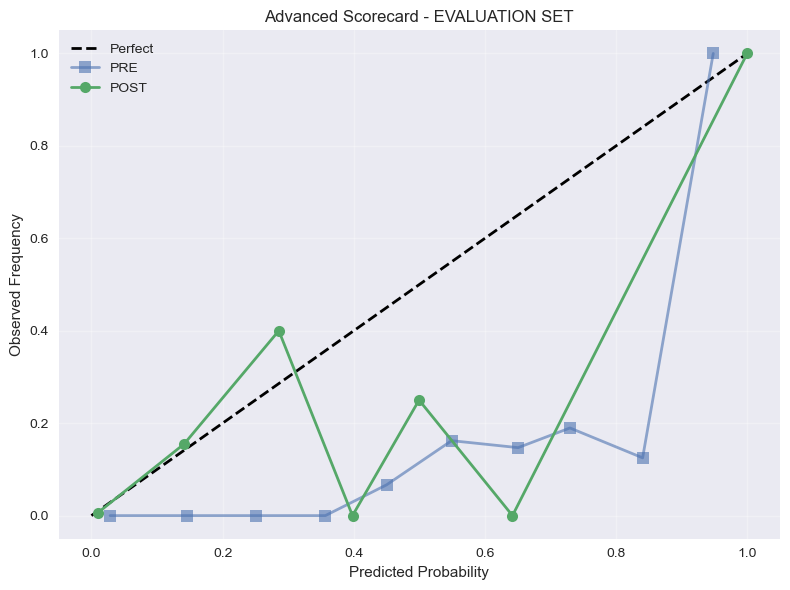


✅ KALIBRACJA ADVANCED ZAKOŃCZONA!
   Diagnostyka PRE → CALIBRATION (bez leakage)
   Finalna ewaluacja → EVALUATION


In [ ]:
# KALIBRACJA - ADVANCED SCORECARD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

print("="*80)
print("📐 KALIBRACJA - ADVANCED SCORECARD")
print("="*80)

# Podziel TEST na CALIBRATION i EVALUATION
(X_test_cal_woe_adv, X_test_eval_woe_adv, 
 y_test_cal_adv, y_test_eval_adv) = train_test_split(
    X_test_woe_advanced_sc, y_test_sc, 
    test_size=0.5, random_state=42, stratify=y_test_sc
)

print(f"\n📊 Podział TEST SET:")
print(f"   • Calibration set:  {len(y_test_cal_adv)} obs")
print(f"   • Evaluation set:   {len(y_test_eval_adv)} obs")

def calculate_reliability_error(y_true, y_pred_proba, n_bins=10):
    """Oblicza Reliability Error z adaptacyjną liczbą binów"""
    actual_bins = min(n_bins, max(3, len(y_true) // 10))
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=actual_bins, strategy='uniform')
        if len(prob_true) < 2:
            return 0.0
        bin_weights = np.histogram(y_pred_proba, bins=actual_bins, range=(0, 1))[0] / len(y_pred_proba)
        min_len = min(len(bin_weights), len(prob_true), len(prob_pred))
        return np.sum(bin_weights[:min_len] * np.abs(prob_true[:min_len] - prob_pred[:min_len]))
    except:
        return 0.0

# DIAGNOSTYKA PRE (na CALIBRATION!)
print("\n🔍 DIAGNOSTYKA PRE-KALIBRACJI (Calibration Set)")
y_proba_cal_pre_adv = scorecard_advanced.predict_proba(X_test_cal_woe_adv)[:, 1]

metrics_pre_adv = {
    'roc_auc': roc_auc_score(y_test_cal_adv, y_proba_cal_pre_adv),
    'log_loss': log_loss(y_test_cal_adv, y_proba_cal_pre_adv),
    'brier': brier_score_loss(y_test_cal_adv, y_proba_cal_pre_adv),
    'reliability': calculate_reliability_error(y_test_cal_adv, y_proba_cal_pre_adv)
}

print(f"\n📊 METRYKI PRE (Calibration Set):")
print(f"   • ROC-AUC:      {metrics_pre_adv['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_pre_adv['log_loss']:.5f}")
print(f"   • Brier Score:  {metrics_pre_adv['brier']:.5f}")
print(f"   • Reliability:  {metrics_pre_adv['reliability']:.5f}")

# KALIBRACJA
print("\n🔧 KALIBRACJA (Calibration Set)")
calibrator_adv = IsotonicRegression(out_of_bounds='clip')
calibrator_adv.fit(y_proba_cal_pre_adv, y_test_cal_adv)
y_proba_cal_post_adv = calibrator_adv.predict(y_proba_cal_pre_adv)

metrics_post_adv = {
    'roc_auc': roc_auc_score(y_test_cal_adv, y_proba_cal_post_adv),
    'log_loss': log_loss(y_test_cal_adv, y_proba_cal_post_adv),
    'brier': brier_score_loss(y_test_cal_adv, y_proba_cal_post_adv),
    'reliability': calculate_reliability_error(y_test_cal_adv, y_proba_cal_post_adv)
}

print(f"\n📊 METRYKI POST (Calibration Set):")
print(f"   • ROC-AUC:      {metrics_post_adv['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_post_adv['log_loss']:.5f}")
print(f"   • Brier Score:  {metrics_post_adv['brier']:.5f}")
print(f"   • Reliability:  {metrics_post_adv['reliability']:.5f}")

# FINALNA EWALUACJA (na EVALUATION!)
print("\n🎯 FINALNA EWALUACJA (Evaluation Set)")
y_proba_eval_pre_adv = scorecard_advanced.predict_proba(X_test_eval_woe_adv)[:, 1]
y_proba_eval_post_adv = calibrator_adv.predict(y_proba_eval_pre_adv)

metrics_eval_pre_adv = {
    'roc_auc': roc_auc_score(y_test_eval_adv, y_proba_eval_pre_adv),
    'log_loss': log_loss(y_test_eval_adv, y_proba_eval_pre_adv),
    'brier': brier_score_loss(y_test_eval_adv, y_proba_eval_pre_adv),
    'reliability': calculate_reliability_error(y_test_eval_adv, y_proba_eval_pre_adv)
}

metrics_eval_post_adv = {
    'roc_auc': roc_auc_score(y_test_eval_adv, y_proba_eval_post_adv),
    'log_loss': log_loss(y_test_eval_adv, y_proba_eval_post_adv),
    'brier': brier_score_loss(y_test_eval_adv, y_proba_eval_post_adv),
    'reliability': calculate_reliability_error(y_test_eval_adv, y_proba_eval_post_adv)
}

print(f"\n📊 METRYKI PRE (Evaluation Set):")
print(f"   • ROC-AUC:      {metrics_eval_pre_adv['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_eval_pre_adv['log_loss']:.5f}")
print(f"   • Brier:        {metrics_eval_pre_adv['brier']:.5f}")
print(f"   • Reliability:  {metrics_eval_pre_adv['reliability']:.5f}")

print(f"\n📊 METRYKI POST (Evaluation Set):")
print(f"   • ROC-AUC:      {metrics_eval_post_adv['roc_auc']:.5f}")
print(f"   • Log Loss:     {metrics_eval_post_adv['log_loss']:.5f}")
print(f"   • Brier:        {metrics_eval_post_adv['brier']:.5f}")
print(f"   • Reliability:  {metrics_eval_post_adv['reliability']:.5f}")

print(f"\n📈 POPRAWA:")
print(f"   • Δ Log Loss:    {metrics_eval_pre_adv['log_loss'] - metrics_eval_post_adv['log_loss']:+.5f}")
print(f"   • Δ Brier:       {metrics_eval_pre_adv['brier'] - metrics_eval_post_adv['brier']:+.5f}")
print(f"   • Δ Reliability: {metrics_eval_pre_adv['reliability'] - metrics_eval_post_adv['reliability']:+.5f}")

# Wizualizacja
n_bins_adv = min(10, max(3, len(y_test_eval_adv) // 10))
prob_true_adv_pre, prob_pred_adv_pre = calibration_curve(y_test_eval_adv, y_proba_eval_pre_adv, n_bins=n_bins_adv, strategy='uniform')
prob_true_adv_post, prob_pred_adv_post = calibration_curve(y_test_eval_adv, y_proba_eval_post_adv, n_bins=n_bins_adv, strategy='uniform')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
ax.plot(prob_pred_adv_pre, prob_true_adv_pre, 's-', label='PRE', linewidth=2, markersize=8, alpha=0.6)
ax.plot(prob_pred_adv_post, prob_true_adv_post, 'o-', label='POST', linewidth=2, markersize=8)
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Observed Frequency')
ax.set_title('Advanced Scorecard - EVALUATION SET')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ KALIBRACJA ADVANCED ZAKOŃCZONA!")
print("   Diagnostyka PRE → CALIBRATION (bez leakage)")
print("   Finalna ewaluacja → EVALUATION")